In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, feats, strategies, models_core
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import os
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)
# df_trainval

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds_trainval = pd.read_csv(params.indunsc_test_csv, index_col=0, parse_dates=True) ###############
df_inds_trainval = df_inds_trainval[df_inds_trainval.index.to_period("M") == params.month_to_check] ################################
# compute synthetic ask/bid from close_raw and configured spread
df_inds_trainval['ask'] = df_inds_trainval['close'] * (1 + params.bidask_spread_pct/100)
df_inds_trainval['bid'] = df_inds_trainval['close'] * (1 - params.bidask_spread_pct/100)

df_inds_trainval

,open,high,low,close,volume,signal,ret,log_ret,sma_9,sma_21,sma_pct_9,sma_pct_21,ema_9,ema_21,roc_9,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,macd_line,macd_signal,macd_diff,atr_14,atr_pct_14,bb_lband_20,bb_hband_20,bb_w_20,plus_di,minus_di,adx,obv,vwap_14,vwap_dev_pct_14,vol_spike,vol_z_14,rolling_max_close_21,rolling_min_close_21,dist_high_21,dist_low_21,obv_sma,obv_diff_14,obv_pct_14,obv_sma_14,obv_z_14,ret_30,sma_30,sma_pct_30,ema_30,roc_30,rsi_30,atr_30,atr_pct_30,bb_lband_30,bb_hband_30,bb_w_30,plus_di_30,minus_di_30,adx_30,obv_diff_30,obv_pct_30,obv_sma_30,obv_z_30,vwap_30,vwap_dev_pct_30,z_vwap_dev_30,vol_spike_30,vol_z_30,ret_std_30,rolling_max_close_30,rolling_min_close_30,dist_high_30,dist_low_30,macd_line_30,macd_signal_30,macd_diff_30,ret_45,sma_45,sma_pct_45,ema_45,roc_45,rsi_45,atr_45,atr_pct_45,bb_lband_45,bb_hband_45,bb_w_45,plus_di_45,minus_di_45,adx_45,obv_diff_45,obv_pct_45,obv_sma_45,obv_z_45,vwap_45,vwap_dev_pct_45,z_vwap_dev_45,vol_spike_45,vol_z_45,ret_std_45,rolling_max_close_45,rolling_min_close_45,dist_high_45,dist_low_45,macd_line_45,macd_signal_45,macd_diff_45,ret_60,sma_60,sma_pct_60,ema_60,roc_60,rsi_60,atr_60,atr_pct_60,bb_lband_60,bb_hband_60,bb_w_60,plus_di_60,minus_di_60,adx_60,obv_diff_60,obv_pct_60,obv_sma_60,obv_z_60,vwap_60,vwap_dev_pct_60,z_vwap_dev_60,vol_spike_60,vol_z_60,ret_std_60,rolling_max_close_60,rolling_min_close_60,dist_high_60,dist_low_60,macd_line_60,macd_signal_60,macd_diff_60,volume_z_30,vol_spike_z_30,ret_std_z_30,obv_pct_z_30,vwap_dev_pct_z_30,bb_w_z_30,atr_z_30,macd_diff_z_30,volume_z_45,vol_spike_z_45,ret_std_z_45,obv_pct_z_45,vwap_dev_pct_z_45,bb_w_z_45,atr_z_45,macd_diff_z_45,volume_z_60,vol_spike_z_60,ret_std_z_60,obv_pct_z_60,vwap_dev_pct_z_60,bb_w_z_60,atr_z_60,macd_diff_z_60,minute_time,hour_time,dow_time,month_time,day_of_year_time,week_of_year_time,in_sess_time,eng_ma,eng_macd,eng_bb,eng_bb_mid,eng_rsi,eng_adx,eng_obv,eng_atr_div,z_eng_atr,eng_sma_short,eng_sma_long,eng_vwap,z_vwap_dev,z_bb_w,z_obv,mom_sum_30,mom_std_30,mom_sum_45,mom_std_45,mom_sum_60,mom_std_60,eng_ema_cross_up,eng_ema_cross_down,ask,bid
2024-02-01 10:58:00,185.6400,185.69,185.63,185.690,523.0,0.067635,0.000054,0.000054,185.561111,185.488571,0.000695,0.001086,185.579927,185.512718,0.001024,0.001618,0.0500,0.000269,0.000,0.0100,0.000323,92.282975,0.060081,0.039090,0.020990,0.037966,0.000204,185.324234,185.662766,0.001825,44.251165,7.410001,38.147116,20589.0,185.552522,0.074091,0.583333,-0.295859,185.69,185.39,0.000000,0.001616,1.410479e+04,12320.0,66.402821,1.410479e+04,3.136310,0.001618,185.449000,0.001300,185.488711,0.001618,68.502853,0.039108,0.000211,185.259028,185.638972,0.002049,31.955014,15.185614,20.270538,15997.0,86.260913,9.958033e+03,1.869365,185.484905,0.110572,2.179338,0.793747,-0.137844,0.000157,185.69,185.32,0.000000,0.001993,0.006583,-0.002201,0.008783,0.001564,185.427333,0.001417,185.475296,0.001564,61.087529,0.045131,0.000243,185.259609,185.595058,0.001809,26.470113,18.803206,18.195826,19429.0,104.779590,7.768378e+03,1.952041,185.468159,0.119611,2.340905,0.994675,-0.003241,0.000139,185.69,185.32,0.000000,0.001993,-0.006962,-0.015602,0.008640,0.000539,185.419333,0.001460,185.479025,0.000539,57.429976,0.050148,0.000270,185.265369,185.573297,0.001661,23.835564,20.664596,0.000000,18855.0,101.688425,5.563167e+03,2.868514,185.448516,0.130216,2.578466,0.881981,-0.084520,0.000166,185.69,185.32,0.000000,0.001993,-0.019219,-0.024766,0.005547,1.561420,3.565522e-06,0.683747,1.384041,1.939474,1.160944,0.063004,20.000000,1.713800,0.000007,-20.000000,20.000000,20.000000,20.000000,-0.377086,0.000000,1.094071,7.506000e-10,0.000000,0.000000,20.000000,-20.000000,-0.372183,0.000000,0.352778,0.312500,0.928571,0.583333,0.584932,0.576923,0.0,0.000391,0.000113,14.922411,-0.001058,0.222830,0.066856,1.039957,0.365502,1.634322,-0.000694,-0.001085,-99.960100,1.415550,1.807764,1.453517,0.009603,0.000580,-0.026001,0.001067,0.000000,0.000000,1.0,0.0,185.727138,185.652862
2024-02-01 10:59:0

In [5]:
df = df_inds_trainval # SELECT THE CORRECT DATAFRAME

start = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
end   = df.loc[df.index.normalize() == df.index.normalize().max(),  "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df.index.normalize().nunique()
baseline_pnl

-137.00901680000035

In [6]:
# trading_combinations = {
#     "tc_001": {"col_signal":"ema_9",               "sign_thresh":"ema_21"},
#     "tc_002": {"col_signal":"sma_9",               "sign_thresh":"sma_21"},
#     "tc_003": {"col_signal":"close",               "sign_thresh":"ema_9"},
#     "tc_004": {"col_signal":"close",               "sign_thresh":"ema_21"},
#     "tc_005": {"col_signal":"macd_line",            "sign_thresh":"macd_signal"},
#     "tc_006": {"col_signal":"macd_diff",            "sign_thresh":0.0},
#     "tc_007": {"col_signal":"dist_low_21",          "sign_thresh":0.0},
#     "tc_008": {"col_signal":"dist_high_21",         "sign_thresh":0.0},
#     "tc_009": {"col_signal":"sma_pct_9",            "sign_thresh":0.0},
#     "tc_010": {"col_signal":"sma_pct_21",           "sign_thresh":0.0},
#     "tc_011": {"col_signal":"roc_9",                "sign_thresh":0.0},
#     "tc_012": {"col_signal":"roc_21",               "sign_thresh":0.0},
#     "tc_013": {"col_signal":"vwap_dev_pct_14",      "sign_thresh":0.0},
#     "tc_014": {"col_signal":"obv_pct_14",           "sign_thresh":0.0},
#     "tc_015": {"col_signal":"vol_spike",            "sign_thresh":1.0},
#     "tc_016": {"col_signal":"rolling_max_close_21", "sign_thresh":"dist_high_21"},
#     "tc_017": {"col_signal":"rolling_min_close_21", "sign_thresh":"dist_low_21"},
#     "tc_018": {"col_signal":"obv_sma",              "sign_thresh":"obv_sma_14"},
#     "tc_019": {"col_signal":"obv_diff_14",          "sign_thresh":0.0},
#     "tc_020": {"col_signal":"obv_z_14",             "sign_thresh":0.0},
#     "tc_021": {"col_signal":"body_pct",             "sign_thresh":0.0},
#     "tc_022": {"col_signal":"upper_shad",           "sign_thresh":"range_pct"},
#     "tc_023": {"col_signal":"lower_shad",           "sign_thresh":"range_pct"},
#     "tc_024": {"col_signal":"plus_di",              "sign_thresh":"minus_di"},
#     "tc_025": {"col_signal":"adx",                  "sign_thresh":20.0},
#     "tc_026": {"col_signal":"bb_w_20",              "sign_thresh":0.0},
#     "tc_027": {"col_signal":"atr_14",               "sign_thresh":"atr_pct_14"},
#     "tc_028": {"col_signal":"atr_pct_14",           "sign_thresh":0.0},
#     "tc_029": {"col_signal":"ret",                  "sign_thresh":0.0},
#     "tc_030": {"col_signal":"log_ret",              "sign_thresh":0.0},
#     "tc_031": {"col_signal":"ema_9",               "sign_thresh":"vwap_dev_pct_14"},
#     "tc_032": {"col_signal":"sma_9",               "sign_thresh":"vwap_dev_pct_14"},
#     "tc_033": {"col_signal":"macd_line",            "sign_thresh":"ema_9"},
#     "tc_034": {"col_signal":"macd_line",            "sign_thresh":"ema_21"},
#     "tc_035": {"col_signal":"sma_pct_9",            "sign_thresh":"sma_pct_21"},
#     "tc_036": {"col_signal":"vwap_dev_pct_14",      "sign_thresh":"sma_pct_9"},
#     "tc_037": {"col_signal":"roc_9",                "sign_thresh":"ema_21"},
#     "tc_038": {"col_signal":"vol_z_14",             "sign_thresh":1.5},
#     "tc_039": {"col_signal":"rolling_min_close_21", "sign_thresh":"ema_9"},
#     "tc_040": {"col_signal":"rolling_max_close_21", "sign_thresh":"ema_21"},
#     "tc_041": {"col_signal":"obv_pct_14",           "sign_thresh":"obv_sma_14"},
#     "tc_042": {"col_signal":"obv_diff_14",          "sign_thresh":"obv_sma_14"},
#     "tc_043": {"col_signal":"body",                 "sign_thresh":0.0},
#     "tc_044": {"col_signal":"range_pct",            "sign_thresh":0.0},
#     "tc_045": {"col_signal":"ema_9",               "sign_thresh":"sma_21"},
#     "tc_046": {"col_signal":"sma_9",               "sign_thresh":"ema_21"},
#     "tc_047": {"col_signal":"bb_w_20",              "sign_thresh":"roc_9"},
#     "tc_048": {"col_signal":"vwap_dev_pct_14",      "sign_thresh":"roc_9"},
# }


# replace zero thresholds with a tiny epsilon to avoid divide-by-zero
_eps = 1e-9
trading_combinations = {
    "tc_001": {"col_signal": "ema_9",               "sign_thresh": "ema_21"},
    "tc_002": {"col_signal": "sma_9",               "sign_thresh": "sma_21"},
    "tc_003": {"col_signal": "close",               "sign_thresh": "ema_9"},
    "tc_004": {"col_signal": "close",               "sign_thresh": "ema_21"},
    "tc_005": {"col_signal": "macd_line",           "sign_thresh": "macd_signal"},
    "tc_006": {"col_signal": "macd_diff",           "sign_thresh": _eps},
    "tc_007": {"col_signal": "dist_low_21",         "sign_thresh": _eps},
    "tc_008": {"col_signal": "dist_high_21",        "sign_thresh": _eps},
    "tc_009": {"col_signal": "sma_pct_9",           "sign_thresh": _eps},
    "tc_010": {"col_signal": "sma_pct_21",          "sign_thresh": _eps},
    "tc_011": {"col_signal": "roc_9",               "sign_thresh": _eps},
    "tc_012": {"col_signal": "roc_21",              "sign_thresh": _eps},
    "tc_013": {"col_signal": "vwap_dev_pct_14",     "sign_thresh": _eps},
    "tc_014": {"col_signal": "obv_pct_14",          "sign_thresh": "obv_sma_14"},
    "tc_015": {"col_signal": "vol_spike",           "sign_thresh": 1.0},
    "tc_016": {"col_signal": "rolling_max_close_21","sign_thresh": "dist_high_21"},
    "tc_017": {"col_signal": "rolling_min_close_21","sign_thresh": "dist_low_21"},
    "tc_018": {"col_signal": "obv_sma",             "sign_thresh": "obv_sma_14"},
    "tc_019": {"col_signal": "vol_z_14",            "sign_thresh": 1.5},
    "tc_020": {"col_signal": "adx",                 "sign_thresh": 20.0},
    "tc_021": {"col_signal": "plus_di",             "sign_thresh": "minus_di"},
    "tc_022": {"col_signal": "atr_pct_14",          "sign_thresh": _eps},
    "tc_023": {"col_signal": "body_pct",            "sign_thresh": _eps},
    "tc_024": {"col_signal": "range_pct",           "sign_thresh": _eps},
}



In [7]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    trad_comb     = trading_combinations[trial.suggest_categorical("tc_id", list(trading_combinations.keys()))]
    reset_peak    = trial.suggest_categorical("reset_peak", [True, False]) 
    trailstop_pct = trial.suggest_float("trailstop_pct", 0.01, 0.30, log=True)
    rsi_thresh    = trial.suggest_int("rsi_thresh", 30, 75)
    atr_mult      = trial.suggest_float("atr_mult", 0.1, 6.0, log=True)
    vwap_atr_mult = trial.suggest_float("vwap_atr_mult", -4.0, 4.0)
    invest_frac   = trial.suggest_float("invest_frac", 0.05, 0.95)
    buy_factor    = trial.suggest_float("buy_factor", 0.05, 0.95)
    sell_factor   = trial.suggest_float("sell_factor", 0.05, 0.95)
    sess_start    = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))

    print('-' * 150)
    print(f"Params => trad_comb={trad_comb}, reset_peak={reset_peak}, trailstop_pct={trailstop_pct:.4f}, rsi_thresh={rsi_thresh:.2f}, atr_mult={atr_mult:.3f}, vwap_atr_mult={vwap_atr_mult:.3f}, invest_frac={invest_frac}, buy_factor={buy_factor}, sell_factor={sell_factor}, sess_start={sess_start},")
    
    daily_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strategies.generate_tradact_elab(
            df              = df_day,
            col_signal      = trad_comb["col_signal"],
            sign_thresh     = trad_comb["sign_thresh"],
            col_atr         = "atr_14",
            col_rsi         = "rsi_6",
            col_vwap        = "vwap_14",
            reset_peak      = reset_peak,
            trailstop_pct   = trailstop_pct,
            rsi_thresh      = rsi_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            sess_start      = sess_start
        )

        sim = strategies.simulate_trading(
            day             = day,
            df              = df_actions,
            invest_frac     = invest_frac,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
            sess_start      = sess_start
        )
   
        df_sim, trades, stats = next(iter(sim.values()))
        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        strategy_val = float(_findall(stats["STRATEGY"])[-1])
        daily_pnls.append(strategy_val)

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim, stats
        df_day = df_actions = sim = stats = None

        # Report for pruning
        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(daily_pnls))
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(__import__("numpy").percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # Soft min/max trades penalty (simplified)
    min_trades = 5
    max_trades = 20
    penalty = 1.0

    mean_pnl = float(np.mean(daily_pnls)) if daily_pnls else 0.0

    if trades_count < min_trades:
        scale = (min_trades - trades_count) / max(1, min_trades)
        return mean_pnl - penalty * scale

    if trades_count > max_trades:
        scale = (trades_count - max_trades) / max(1, max_trades)
        return mean_pnl - penalty * scale

    return mean_pnl


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1079, rsi_thresh=66.00, atr_mult=0.542, vwap_atr_mult=-3.871, invest_frac=0.6736846911924931, buy_factor=0.3171161172189547, sell_factor=0.052597561197204934, sess_start=13:30:00,


Trial 0: 100%|██████████| 20/20 [00:03<00:00,  6.55it/s]


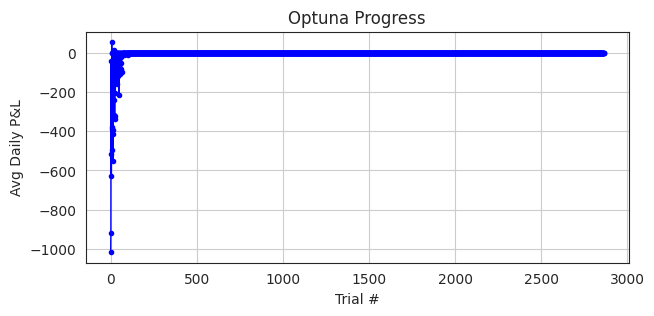

[Results] Trial 0 finished with value: -1018.2358. Improvement over baseline: 643.19%.     Best is trial 0 with value: -1018.2358.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0676, rsi_thresh=46.00, atr_mult=3.361, vwap_atr_mult=3.723, invest_frac=0.9480348289020625, buy_factor=0.7648697548454773, sell_factor=0.21401349167558908, sess_start=13:30:00,


Trial 1: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


[Results] Trial 1 finished with value: -920.6464. Improvement over baseline: 571.96%.     Best is trial 1 with value: -920.6464.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0851, rsi_thresh=69.00, atr_mult=0.101, vwap_atr_mult=3.545, invest_frac=0.09644952321899897, buy_factor=0.4222603415128295, sell_factor=0.26717306277336345, sess_start=13:30:00,


Trial 2: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


[Results] Trial 2 finished with value: -39.6887. Improvement over baseline: -71.03%.     Best is trial 2 with value: -39.6887.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1362, rsi_thresh=31.00, atr_mult=3.678, vwap_atr_mult=2.700, invest_frac=0.8111029174147926, buy_factor=0.6758404077801979, sell_factor=0.11830425857264652, sess_start=14:30:00,


Trial 3: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]


[Results] Trial 3 finished with value: -516.1929. Improvement over baseline: 276.76%.     Best is trial 2 with value: -39.6887.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0739, rsi_thresh=45.00, atr_mult=1.535, vwap_atr_mult=-2.408, invest_frac=0.9340301089519539, buy_factor=0.15718221106684044, sell_factor=0.428925227302457, sess_start=13:30:00,


Trial 4: 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


[Results] Trial 4 finished with value: -628.0420. Improvement over baseline: 358.39%.     Best is trial 2 with value: -39.6887.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.2266, rsi_thresh=59.00, atr_mult=4.647, vwap_atr_mult=-2.691, invest_frac=0.5790144964146625, buy_factor=0.6874594417928236, sell_factor=0.2894975027460048, sess_start=13:30:00,


Trial 5: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


[Results] Trial 5 finished with value: -497.5116. Improvement over baseline: 263.12%.     Best is trial 2 with value: -39.6887.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0393, rsi_thresh=45.00, atr_mult=1.078, vwap_atr_mult=3.487, invest_frac=0.5082906459836656, buy_factor=0.3570359180536436, sell_factor=0.6386404752182113, sess_start=13:30:00,


Trial 6: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s]


[Results] Trial 6 finished with value: 55.8674. Improvement over baseline: -140.78%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0414, rsi_thresh=74.00, atr_mult=0.489, vwap_atr_mult=0.307, invest_frac=0.6945733591986927, buy_factor=0.4965397418102699, sell_factor=0.7423804323657586, sess_start=14:30:00,


Trial 7: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


[Results] Trial 7 finished with value: -378.3399. Improvement over baseline: 176.14%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0698, rsi_thresh=46.00, atr_mult=2.047, vwap_atr_mult=-3.006, invest_frac=0.8832649036453667, buy_factor=0.5089612545068943, sell_factor=0.7414344831837918, sess_start=14:30:00,


Trial 8: 100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


[Results] Trial 8 finished with value: -389.0862. Improvement over baseline: 183.99%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0586, rsi_thresh=33.00, atr_mult=0.649, vwap_atr_mult=-1.155, invest_frac=0.7576493657741671, buy_factor=0.7350368816736584, sell_factor=0.6436168637662573, sess_start=14:30:00,


Trial 9: 100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


[Results] Trial 9 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0169, rsi_thresh=56.00, atr_mult=0.230, vwap_atr_mult=1.300, invest_frac=0.3356978966362091, buy_factor=0.12643777799244854, sell_factor=0.9248352393483934, sess_start=13:30:00,


Trial 10: 100%|██████████| 20/20 [00:02<00:00,  7.28it/s]


[Results] Trial 10 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0278, rsi_thresh=30.00, atr_mult=1.043, vwap_atr_mult=-0.867, invest_frac=0.39701274234404704, buy_factor=0.9410153721172771, sell_factor=0.6220398636040235, sess_start=14:30:00,


Trial 11: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


[Results] Trial 11 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0320, rsi_thresh=37.00, atr_mult=0.692, vwap_atr_mult=-1.000, invest_frac=0.4627204432249634, buy_factor=0.28631827560851014, sell_factor=0.5679362011859, sess_start=14:30:00,


Trial 12: 100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


[Results] Trial 12 finished with value: -392.0562. Improvement over baseline: 186.15%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0123, rsi_thresh=40.00, atr_mult=0.277, vwap_atr_mult=1.372, invest_frac=0.21387944849038315, buy_factor=0.9023736179831796, sell_factor=0.43663503205334353, sess_start=14:30:00,


Trial 13: 100%|██████████| 20/20 [00:02<00:00,  7.26it/s]


[Results] Trial 13 finished with value: -553.2845. Improvement over baseline: 303.83%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0431, rsi_thresh=39.00, atr_mult=1.097, vwap_atr_mult=-1.079, invest_frac=0.5784530914546571, buy_factor=0.6160198410148618, sell_factor=0.7172569627208754, sess_start=13:30:00,


Trial 14: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


[Results] Trial 14 finished with value: -0.4783. Improvement over baseline: -99.65%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0210, rsi_thresh=51.00, atr_mult=1.482, vwap_atr_mult=1.999, invest_frac=0.5625715723099288, buy_factor=0.6038854073623035, sell_factor=0.8852219935436374, sess_start=13:30:00,


Trial 15: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


[Results] Trial 15 finished with value: -412.0591. Improvement over baseline: 200.75%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0390, rsi_thresh=40.00, atr_mult=2.601, vwap_atr_mult=0.340, invest_frac=0.29722851193887, buy_factor=0.33105092329710245, sell_factor=0.7991963591580955, sess_start=13:30:00,


Trial 16: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 16 finished with value: 10.3174. Improvement over baseline: -107.53%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0109, rsi_thresh=52.00, atr_mult=2.374, vwap_atr_mult=0.255, invest_frac=0.2923821096684517, buy_factor=0.26479292701396423, sell_factor=0.8209644590190692, sess_start=13:30:00,


Trial 17: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


[Results] Trial 17 finished with value: -242.1563. Improvement over baseline: 76.74%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0276, rsi_thresh=43.00, atr_mult=5.656, vwap_atr_mult=2.233, invest_frac=0.1654149747470526, buy_factor=0.06313171174549392, sell_factor=0.522764776985096, sess_start=13:30:00,


Trial 18: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


[Results] Trial 18 finished with value: 13.6840. Improvement over baseline: -109.99%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0231, rsi_thresh=60.00, atr_mult=0.295, vwap_atr_mult=2.730, invest_frac=0.06398632096312935, buy_factor=0.05072783313760836, sell_factor=0.5140911682399373, sess_start=13:30:00,


Trial 19: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 19 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0160, rsi_thresh=48.00, atr_mult=5.709, vwap_atr_mult=2.321, invest_frac=0.1794624054277086, buy_factor=0.18722992834501687, sell_factor=0.392088510871977, sess_start=13:30:00,


Trial 20: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 20 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0388, rsi_thresh=40.00, atr_mult=2.756, vwap_atr_mult=1.140, invest_frac=0.24604863808544997, buy_factor=0.4096710757383665, sell_factor=0.6706036168133092, sess_start=13:30:00,


Trial 21: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


[Results] Trial 21 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0491, rsi_thresh=43.00, atr_mult=4.340, vwap_atr_mult=3.245, invest_frac=0.4117993693557669, buy_factor=0.38296715100132794, sell_factor=0.816377476021081, sess_start=13:30:00,


Trial 22: 100%|██████████| 20/20 [00:02<00:00,  6.78it/s]


[Results] Trial 22 finished with value: -314.0120. Improvement over baseline: 129.19%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0296, rsi_thresh=35.00, atr_mult=5.861, vwap_atr_mult=3.954, invest_frac=0.14044849905521234, buy_factor=0.05001495269996864, sell_factor=0.5287225291976754, sess_start=13:30:00,


Trial 23: 100%|██████████| 20/20 [00:02<00:00,  6.77it/s]


[Results] Trial 23 finished with value: -337.8296. Improvement over baseline: 146.57%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0338, rsi_thresh=42.00, atr_mult=1.775, vwap_atr_mult=1.512, invest_frac=0.3334598861642341, buy_factor=0.24349282831585106, sell_factor=0.8131091601818918, sess_start=13:30:00,


Trial 24: 100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


[Results] Trial 24 finished with value: -322.4343. Improvement over baseline: 135.34%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0226, rsi_thresh=49.00, atr_mult=2.980, vwap_atr_mult=2.883, invest_frac=0.47890962421793937, buy_factor=0.34673091685284796, sell_factor=0.5748870732049737, sess_start=13:30:00,


Trial 25: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


[Results] Trial 25 finished with value: -132.8993. Improvement over baseline: -3.00%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0469, rsi_thresh=54.00, atr_mult=1.053, vwap_atr_mult=-0.309, invest_frac=0.300822227107792, buy_factor=0.48214303905944245, sell_factor=0.46257105239573193, sess_start=13:30:00,


Trial 26: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 26 finished with value: -64.9766. Improvement over baseline: -52.57%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0183, rsi_thresh=35.00, atr_mult=2.100, vwap_atr_mult=0.752, invest_frac=0.1431157660731903, buy_factor=0.22902930351928485, sell_factor=0.36645226438407213, sess_start=13:30:00,


Trial 27: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


[Results] Trial 27 finished with value: -202.6347. Improvement over baseline: 47.90%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1591, rsi_thresh=44.00, atr_mult=1.333, vwap_atr_mult=1.992, invest_frac=0.42607367677615904, buy_factor=0.09603081176243472, sell_factor=0.6858362776720961, sess_start=13:30:00,


Trial 28: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


[Results] Trial 28 finished with value: 1.8720. Improvement over baseline: -101.37%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.1099, rsi_thresh=37.00, atr_mult=0.512, vwap_atr_mult=3.194, invest_frac=0.5298826296058301, buy_factor=0.33620847509736246, sell_factor=0.7692279814642906, sess_start=13:30:00,


Trial 29: 100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


[Results] Trial 29 finished with value: -150.0047. Improvement over baseline: 9.49%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0563, rsi_thresh=48.00, atr_mult=4.119, vwap_atr_mult=-2.027, invest_frac=0.6545006109999667, buy_factor=0.20792529078002348, sell_factor=0.5812919603862182, sess_start=13:30:00,


Trial 30: 100%|██████████| 20/20 [00:02<00:00,  7.32it/s]


[Results] Trial 30 finished with value: -51.5496. Improvement over baseline: -62.38%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1918, rsi_thresh=43.00, atr_mult=1.292, vwap_atr_mult=2.240, invest_frac=0.3933991662556703, buy_factor=0.10386331989070952, sell_factor=0.6935979165115548, sess_start=13:30:00,


Trial 31: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


[Results] Trial 31 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1665, rsi_thresh=45.00, atr_mult=0.972, vwap_atr_mult=2.027, invest_frac=0.24243823995759034, buy_factor=0.11575833258869285, sell_factor=0.6372773471242309, sess_start=13:30:00,


Trial 32: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


[Results] Trial 32 finished with value: -57.9643. Improvement over baseline: -57.69%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0919, rsi_thresh=41.00, atr_mult=0.784, vwap_atr_mult=0.743, invest_frac=0.436274465578673, buy_factor=0.3000951189084117, sell_factor=0.8621164532810831, sess_start=13:30:00,


Trial 33: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 33 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.2790, rsi_thresh=38.00, atr_mult=3.172, vwap_atr_mult=1.685, invest_frac=0.35036780376459126, buy_factor=0.4487575049836303, sell_factor=0.7760495368420609, sess_start=13:30:00,


Trial 34: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


[Results] Trial 34 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1178, rsi_thresh=46.00, atr_mult=2.462, vwap_atr_mult=3.541, invest_frac=0.4981009022177932, buy_factor=0.16144902295735153, sell_factor=0.6108904135228133, sess_start=13:30:00,


Trial 35: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


[Results] Trial 35 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0266, rsi_thresh=50.00, atr_mult=1.844, vwap_atr_mult=2.547, invest_frac=0.6281138754932982, buy_factor=0.542068903105876, sell_factor=0.6875116073047078, sess_start=13:30:00,


Trial 36: 100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


[Results] Trial 36 finished with value: -14.3431. Improvement over baseline: -89.53%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0362, rsi_thresh=44.00, atr_mult=1.403, vwap_atr_mult=3.108, invest_frac=0.2690156166456673, buy_factor=0.36893576065082867, sell_factor=0.15188338808679364, sess_start=13:30:00,


Trial 37: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


[Results] Trial 37 finished with value: 0.4368. Improvement over baseline: -100.32%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0786, rsi_thresh=55.00, atr_mult=0.109, vwap_atr_mult=-0.381, invest_frac=0.12902312130401525, buy_factor=0.10753168419492959, sell_factor=0.30483082116680926, sess_start=13:30:00,


Trial 38: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


[Results] Trial 38 finished with value: -159.2583. Improvement over baseline: 16.24%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0595, rsi_thresh=63.00, atr_mult=3.692, vwap_atr_mult=-1.731, invest_frac=0.2116335768949107, buy_factor=0.18851186312153473, sell_factor=0.49500878544508525, sess_start=13:30:00,


Trial 39: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 39 finished with value: 2.4588. Improvement over baseline: -101.79%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0602, rsi_thresh=66.00, atr_mult=5.020, vwap_atr_mult=-3.574, invest_frac=0.05351659504241685, buy_factor=0.19412169808648091, sell_factor=0.4889402925134786, sess_start=14:30:00,


Trial 40: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


[Results] Trial 40 finished with value: -116.7639. Improvement over baseline: -14.78%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1382, rsi_thresh=63.00, atr_mult=3.570, vwap_atr_mult=-1.874, invest_frac=0.16997249126165648, buy_factor=0.08162656301613232, sell_factor=0.536105540244106, sess_start=13:30:00,


Trial 41: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 41 finished with value: 1.2142. Improvement over baseline: -100.89%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0901, rsi_thresh=58.00, atr_mult=3.860, vwap_atr_mult=0.858, invest_frac=0.20506180848148148, buy_factor=0.16552398138941105, sell_factor=0.4902139431542775, sess_start=13:30:00,


Trial 42: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 42 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0485, rsi_thresh=73.00, atr_mult=4.767, vwap_atr_mult=-1.703, invest_frac=0.3720295150318914, buy_factor=0.3028186515281494, sell_factor=0.39115721173892826, sess_start=13:30:00,


Trial 43: 100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


[Results] Trial 43 finished with value: -76.6453. Improvement over baseline: -44.06%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0657, rsi_thresh=71.00, atr_mult=2.805, vwap_atr_mult=3.667, invest_frac=0.5237430416624791, buy_factor=0.15319442067182798, sell_factor=0.6587254721816691, sess_start=13:30:00,


Trial 44: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


[Results] Trial 44 finished with value: -66.8127. Improvement over baseline: -51.23%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0250, rsi_thresh=34.00, atr_mult=0.874, vwap_atr_mult=-3.080, invest_frac=0.09799806232900529, buy_factor=0.2608868500530104, sell_factor=0.7256436978366524, sess_start=14:30:00,


Trial 45: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 45 finished with value: 0.1638. Improvement over baseline: -100.12%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.2849, rsi_thresh=47.00, atr_mult=1.254, vwap_atr_mult=1.826, invest_frac=0.3228746815099843, buy_factor=0.08048415813644046, sell_factor=0.934635532459313, sess_start=13:30:00,


Trial 46: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 46 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0418, rsi_thresh=63.00, atr_mult=1.737, vwap_atr_mult=0.138, invest_frac=0.4460944170161266, buy_factor=0.1581870727090422, sell_factor=0.5905773451286889, sess_start=13:30:00,


Trial 47: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


[Results] Trial 47 finished with value: -216.4240. Improvement over baseline: 57.96%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0329, rsi_thresh=68.00, atr_mult=0.386, vwap_atr_mult=-0.641, invest_frac=0.21609737778205435, buy_factor=0.22420940150933397, sell_factor=0.7723720834359264, sess_start=14:30:00,


Trial 48: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


[Results] Trial 48 finished with value: -108.6514. Improvement over baseline: -20.70%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0147, rsi_thresh=42.00, atr_mult=0.628, vwap_atr_mult=-1.409, invest_frac=0.28015537789030126, buy_factor=0.44672786343685666, sell_factor=0.3267761334298399, sess_start=13:30:00,


Trial 49: 100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


[Results] Trial 49 finished with value: -98.0322. Improvement over baseline: -28.45%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1538, rsi_thresh=53.00, atr_mult=2.355, vwap_atr_mult=-3.999, invest_frac=0.7363759719959666, buy_factor=0.802815191001344, sell_factor=0.42947471523505637, sess_start=13:30:00,


Trial 50: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


[Results] Trial 50 finished with value: -50.7113. Improvement over baseline: -62.99%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1312, rsi_thresh=64.00, atr_mult=3.487, vwap_atr_mult=-1.836, invest_frac=0.18463069451730169, buy_factor=0.08821691833222012, sell_factor=0.553335615012514, sess_start=13:30:00,


Trial 51: 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


[Results] Trial 51 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2134, rsi_thresh=62.00, atr_mult=3.724, vwap_atr_mult=-2.311, invest_frac=0.16299531989944013, buy_factor=0.13326905154126836, sell_factor=0.515622226848444, sess_start=13:30:00,


Trial 52: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


[Results] Trial 52 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1608, rsi_thresh=58.00, atr_mult=5.454, vwap_atr_mult=-2.640, invest_frac=0.25595130738283445, buy_factor=0.07259015470772126, sell_factor=0.5433006353980205, sess_start=13:30:00,


Trial 53: 100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


[Results] Trial 53 finished with value: -104.3383. Improvement over baseline: -23.85%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1012, rsi_thresh=66.00, atr_mult=4.599, vwap_atr_mult=-1.341, invest_frac=0.10344689571108698, buy_factor=0.05054809586931603, sell_factor=0.4710659643523142, sess_start=13:30:00,


Trial 54: 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


[Results] Trial 54 finished with value: -0.3628. Improvement over baseline: -99.74%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0298, rsi_thresh=61.00, atr_mult=3.278, vwap_atr_mult=0.411, invest_frac=0.23436976828615286, buy_factor=0.13106071232779923, sell_factor=0.6173646336179106, sess_start=13:30:00,


Trial 55: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


[Results] Trial 55 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.1312, rsi_thresh=32.00, atr_mult=2.518, vwap_atr_mult=-0.173, invest_frac=0.5998761370570453, buy_factor=0.27805286655147243, sell_factor=0.7112347841675812, sess_start=13:30:00,


Trial 56: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


[Results] Trial 56 finished with value: -52.1071. Improvement over baseline: -61.97%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0523, rsi_thresh=39.00, atr_mult=2.085, vwap_atr_mult=2.452, invest_frac=0.3032758133778022, buy_factor=0.18741400100582484, sell_factor=0.8554380041113584, sess_start=14:30:00,


Trial 57: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


[Results] Trial 57 finished with value: -48.0748. Improvement over baseline: -64.91%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0751, rsi_thresh=56.00, atr_mult=1.597, vwap_atr_mult=-0.691, invest_frac=0.3633737000437599, buy_factor=0.2440275734124918, sell_factor=0.2521469887312662, sess_start=13:30:00,


Trial 58: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


[Results] Trial 58 finished with value: -82.5049. Improvement over baseline: -39.78%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0381, rsi_thresh=51.00, atr_mult=4.113, vwap_atr_mult=2.905, invest_frac=0.18826687417388938, buy_factor=0.5317767772792371, sell_factor=0.6536042112294692, sess_start=13:30:00,


Trial 59: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 59 finished with value: -12.3372. Improvement over baseline: -91.00%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.1965, rsi_thresh=37.00, atr_mult=2.874, vwap_atr_mult=-2.268, invest_frac=0.11184822383404908, buy_factor=0.39669739800328996, sell_factor=0.6019965679377008, sess_start=13:30:00,


Trial 60: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


[Results] Trial 60 finished with value: -22.1228. Improvement over baseline: -83.85%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0371, rsi_thresh=44.00, atr_mult=1.370, vwap_atr_mult=3.286, invest_frac=0.26839354553785755, buy_factor=0.3664066944008075, sell_factor=0.13983439676189463, sess_start=13:30:00,


Trial 61: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 61 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0195, rsi_thresh=45.00, atr_mult=1.116, vwap_atr_mult=3.987, invest_frac=0.15145223403460079, buy_factor=0.330185410682298, sell_factor=0.1823864495521067, sess_start=13:30:00,


Trial 62: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 62 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0357, rsi_thresh=41.00, atr_mult=1.522, vwap_atr_mult=2.996, invest_frac=0.4181872645700604, buy_factor=0.42815598375466085, sell_factor=0.897912779820488, sess_start=13:30:00,


Trial 63: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


[Results] Trial 63 finished with value: -97.2974. Improvement over baseline: -28.98%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0442, rsi_thresh=44.00, atr_mult=0.812, vwap_atr_mult=3.481, invest_frac=0.2270542893237544, buy_factor=0.36553118408572993, sell_factor=0.4531364307928998, sess_start=13:30:00,


Trial 64: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 64 finished with value: -0.8038. Improvement over baseline: -99.41%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.2506, rsi_thresh=48.00, atr_mult=1.197, vwap_atr_mult=2.101, invest_frac=0.3261925765075789, buy_factor=0.477273290514715, sell_factor=0.13385396240621333, sess_start=13:30:00,


Trial 65: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


[Results] Trial 65 finished with value: -9.1254. Improvement over baseline: -93.34%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0282, rsi_thresh=40.00, atr_mult=5.981, vwap_atr_mult=2.649, invest_frac=0.07849331096767029, buy_factor=0.09210986264224807, sell_factor=0.739525060108531, sess_start=13:30:00,


Trial 66: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 66 finished with value: -5.2313. Improvement over baseline: -96.18%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0235, rsi_thresh=46.00, atr_mult=0.930, vwap_atr_mult=1.088, invest_frac=0.8515377331090739, buy_factor=0.5839928303451396, sell_factor=0.08964350041505703, sess_start=13:30:00,


Trial 67: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


[Results] Trial 67 finished with value: -7.5865. Improvement over baseline: -94.46%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0613, rsi_thresh=43.00, atr_mult=2.106, vwap_atr_mult=1.530, invest_frac=0.5557711231258347, buy_factor=0.3226961098569139, sell_factor=0.3971118761819481, sess_start=13:30:00,


Trial 68: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


[Results] Trial 68 finished with value: -0.8038. Improvement over baseline: -99.41%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0318, rsi_thresh=36.00, atr_mult=5.011, vwap_atr_mult=-3.137, invest_frac=0.4722337576417601, buy_factor=0.13286600462254436, sell_factor=0.05974593983719528, sess_start=14:30:00,


Trial 69: 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]


[Results] Trial 69 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0530, rsi_thresh=68.00, atr_mult=0.631, vwap_atr_mult=3.385, invest_frac=0.38702503208375366, buy_factor=0.21688461844859078, sell_factor=0.535491844441312, sess_start=13:30:00,


Trial 70: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 70 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=34.00, atr_mult=0.760, vwap_atr_mult=-3.032, invest_frac=0.08762034177982148, buy_factor=0.25094821085821345, sell_factor=0.8010700805186358, sess_start=14:30:00,


Trial 71: 100%|██████████| 20/20 [00:02<00:00,  7.72it/s]


[Results] Trial 71 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0261, rsi_thresh=32.00, atr_mult=0.923, vwap_atr_mult=-2.759, invest_frac=0.16971695879453463, buy_factor=0.2736276327665813, sell_factor=0.7531079717193435, sess_start=14:30:00,


Trial 72: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


[Results] Trial 72 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0214, rsi_thresh=39.00, atr_mult=0.869, vwap_atr_mult=-3.480, invest_frac=0.11721489940654087, buy_factor=0.18349975341595207, sell_factor=0.7114478897357515, sess_start=14:30:00,


Trial 73: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


[Results] Trial 73 finished with value: -0.1817. Improvement over baseline: -99.87%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0400, rsi_thresh=30.00, atr_mult=1.358, vwap_atr_mult=2.983, invest_frac=0.19173735431944633, buy_factor=0.29804731471475104, sell_factor=0.6784643373915896, sess_start=14:30:00,


Trial 74: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


[Results] Trial 74 finished with value: -0.8038. Improvement over baseline: -99.41%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0298, rsi_thresh=41.00, atr_mult=1.039, vwap_atr_mult=3.792, invest_frac=0.25746971264069374, buy_factor=0.07151099349510989, sell_factor=0.6310762207048982, sess_start=14:30:00,


Trial 75: 100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


[Results] Trial 75 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0445, rsi_thresh=50.00, atr_mult=0.696, vwap_atr_mult=0.500, invest_frac=0.3021594866944799, buy_factor=0.2568826433413238, sell_factor=0.7343405780009371, sess_start=13:30:00,


Trial 76: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 76 finished with value: -1.4434. Improvement over baseline: -98.95%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0336, rsi_thresh=47.00, atr_mult=1.902, vwap_atr_mult=-3.270, invest_frac=0.13679138060171542, buy_factor=0.10869108007272472, sell_factor=0.5598621821645008, sess_start=13:30:00,


Trial 77: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


[Results] Trial 77 finished with value: -0.0128. Improvement over baseline: -99.99%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0159, rsi_thresh=64.00, atr_mult=3.125, vwap_atr_mult=2.323, invest_frac=0.5055573805835919, buy_factor=0.35023874950094575, sell_factor=0.8385006762992829, sess_start=14:30:00,


Trial 78: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 78 finished with value: -0.8038. Improvement over baseline: -99.41%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0239, rsi_thresh=44.00, atr_mult=0.438, vwap_atr_mult=-1.559, invest_frac=0.22035202474039015, buy_factor=0.1439618092315642, sell_factor=0.7983897842383735, sess_start=13:30:00,


Trial 79: 100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


[Results] Trial 79 finished with value: -7.3525. Improvement over baseline: -94.63%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1821, rsi_thresh=35.00, atr_mult=3.613, vwap_atr_mult=-2.010, invest_frac=0.051589033406290515, buy_factor=0.38395746317043383, sell_factor=0.3450499909853481, sess_start=13:30:00,


Trial 80: 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


[Results] Trial 80 finished with value: -0.8038. Improvement over baseline: -99.41%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0344, rsi_thresh=47.00, atr_mult=1.679, vwap_atr_mult=-3.253, invest_frac=0.14104318825352186, buy_factor=0.11189645986276615, sell_factor=0.5542119465075118, sess_start=13:30:00,


Trial 81: 100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


[Results] Trial 81 finished with value: -6.5329. Improvement over baseline: -95.23%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0325, rsi_thresh=42.00, atr_mult=2.497, vwap_atr_mult=-3.600, invest_frac=0.16167058794873437, buy_factor=0.20382725185489223, sell_factor=0.58171192879298, sess_start=13:30:00,


Trial 82: 100%|██████████| 20/20 [00:02<00:00,  7.09it/s]


[Results] Trial 82 finished with value: -0.0011. Improvement over baseline: -100.00%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0274, rsi_thresh=42.00, atr_mult=2.705, vwap_atr_mult=-3.898, invest_frac=0.20614666178303973, buy_factor=0.2077670083840633, sell_factor=0.59166282773703, sess_start=13:30:00,


Trial 83: 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


[Results] Trial 83 finished with value: -0.0101. Improvement over baseline: -99.99%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1443, rsi_thresh=38.00, atr_mult=2.273, vwap_atr_mult=-3.405, invest_frac=0.17330232179668226, buy_factor=0.17650473322668783, sell_factor=0.5778392130803052, sess_start=13:30:00,


Trial 84: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


[Results] Trial 84 finished with value: -0.6056. Improvement over baseline: -99.56%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0303, rsi_thresh=75.00, atr_mult=3.911, vwap_atr_mult=-3.675, invest_frac=0.08294790959820854, buy_factor=0.3142847581601074, sell_factor=0.6449917400414604, sess_start=13:30:00,


Trial 85: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


[Results] Trial 85 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0488, rsi_thresh=45.00, atr_mult=4.341, vwap_atr_mult=-2.684, invest_frac=0.2830242170138314, buy_factor=0.2275875028932063, sell_factor=0.6975160395518251, sess_start=13:30:00,


Trial 86: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


[Results] Trial 86 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0186, rsi_thresh=43.00, atr_mult=0.567, vwap_atr_mult=-3.684, invest_frac=0.1593113084117726, buy_factor=0.28668769564038027, sell_factor=0.508994056220338, sess_start=13:30:00,


Trial 87: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 87 finished with value: -0.7534. Improvement over baseline: -99.45%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0405, rsi_thresh=40.00, atr_mult=0.150, vwap_atr_mult=-2.791, invest_frac=0.10877621771406268, buy_factor=0.07156640381958101, sell_factor=0.48049375689380097, sess_start=13:30:00,


Trial 88: 100%|██████████| 20/20 [00:02<00:00,  7.35it/s]


[Results] Trial 88 finished with value: -0.8038. Improvement over baseline: -99.41%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0210, rsi_thresh=59.00, atr_mult=1.453, vwap_atr_mult=-1.200, invest_frac=0.19809842382980364, buy_factor=0.19968822927805865, sell_factor=0.6663706067347824, sess_start=13:30:00,


Trial 89: 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


[Results] Trial 89 finished with value: -6.8762. Improvement over baseline: -94.98%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1222, rsi_thresh=42.00, atr_mult=1.150, vwap_atr_mult=-0.906, invest_frac=0.24419891739615718, buy_factor=0.42475685750222414, sell_factor=0.2655512775471603, sess_start=14:30:00,


Trial 90: 100%|██████████| 20/20 [00:02<00:00,  6.74it/s]


[Results] Trial 90 finished with value: -0.8038. Improvement over baseline: -99.41%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0265, rsi_thresh=44.00, atr_mult=2.639, vwap_atr_mult=-3.809, invest_frac=0.20152199716879315, buy_factor=0.20628239459031822, sell_factor=0.5967404740121156, sess_start=13:30:00,


Trial 91: 100%|██████████| 20/20 [00:02<00:00,  7.24it/s]


[Results] Trial 91 finished with value: -6.8534. Improvement over baseline: -95.00%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0279, rsi_thresh=41.00, atr_mult=3.044, vwap_atr_mult=2.780, invest_frac=0.1273625528583327, buy_factor=0.1589977062830239, sell_factor=0.61787428485345, sess_start=13:30:00,


Trial 92: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


[Results] Trial 92 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0317, rsi_thresh=42.00, atr_mult=3.347, vwap_atr_mult=1.850, invest_frac=0.22141891006213404, buy_factor=0.23658236648394015, sell_factor=0.5736167983868045, sess_start=13:30:00,


Trial 93: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


[Results] Trial 93 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0363, rsi_thresh=38.00, atr_mult=1.950, vwap_atr_mult=-2.413, invest_frac=0.1629600380310266, buy_factor=0.26607536841909224, sell_factor=0.22329019664186406, sess_start=13:30:00,


Trial 94: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


[Results] Trial 94 finished with value: -0.6067. Improvement over baseline: -99.56%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0249, rsi_thresh=40.00, atr_mult=2.236, vwap_atr_mult=3.118, invest_frac=0.34328495588919694, buy_factor=0.09587617351544736, sell_factor=0.5282141726993044, sess_start=13:30:00,


Trial 95: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


[Results] Trial 95 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0459, rsi_thresh=46.00, atr_mult=2.692, vwap_atr_mult=-3.804, invest_frac=0.4450878086923351, buy_factor=0.355333098186619, sell_factor=0.5015676341503545, sess_start=13:30:00,


Trial 96: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


[Results] Trial 96 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0217, rsi_thresh=49.00, atr_mult=5.301, vwap_atr_mult=-3.928, invest_frac=0.24642076208433802, buy_factor=0.1754338350299142, sell_factor=0.44487169180177294, sess_start=13:30:00,


Trial 97: 100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


[Results] Trial 97 finished with value: -0.8038. Improvement over baseline: -99.41%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0692, rsi_thresh=36.00, atr_mult=4.230, vwap_atr_mult=1.216, invest_frac=0.5354199386015446, buy_factor=0.14141874732143672, sell_factor=0.7218584541771138, sess_start=13:30:00,


Trial 98: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


[Results] Trial 98 finished with value: -7.8420. Improvement over baseline: -94.28%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0394, rsi_thresh=42.00, atr_mult=2.895, vwap_atr_mult=3.825, invest_frac=0.3128711888712686, buy_factor=0.12425903494620252, sell_factor=0.7614734542304766, sess_start=13:30:00,


Trial 99: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


[Results] Trial 99 finished with value: 0.0230. Improvement over baseline: -100.02%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0564, rsi_thresh=33.00, atr_mult=1.048, vwap_atr_mult=3.729, invest_frac=0.2700609904518518, buy_factor=0.05684944907518788, sell_factor=0.7656119450139837, sess_start=13:30:00,


Trial 100: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


[Results] Trial 100 finished with value: -0.6317. Improvement over baseline: -99.54%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0380, rsi_thresh=42.00, atr_mult=2.910, vwap_atr_mult=3.810, invest_frac=0.3014553428150276, buy_factor=0.12210090419731245, sell_factor=0.6936707163346166, sess_start=13:30:00,


Trial 101: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


[Results] Trial 101 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0283, rsi_thresh=45.00, atr_mult=2.487, vwap_atr_mult=3.433, invest_frac=0.3169169098451552, buy_factor=0.20653474022176596, sell_factor=0.6351606326024624, sess_start=13:30:00,


Trial 102: 100%|██████████| 20/20 [00:02<00:00,  6.81it/s]


[Results] Trial 102 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0348, rsi_thresh=43.00, atr_mult=3.399, vwap_atr_mult=3.628, invest_frac=0.49199647134453645, buy_factor=0.08312764671939922, sell_factor=0.5957064593797692, sess_start=13:30:00,


Trial 103: 100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


[Results] Trial 103 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0394, rsi_thresh=39.00, atr_mult=1.231, vwap_atr_mult=3.148, invest_frac=0.36230617582380586, buy_factor=0.1536780113171193, sell_factor=0.4086730651054439, sess_start=13:30:00,


Trial 104: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 104 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0426, rsi_thresh=41.00, atr_mult=4.633, vwap_atr_mult=-0.031, invest_frac=0.20878147425935514, buy_factor=0.8361544164349094, sell_factor=0.7986229161495688, sess_start=13:30:00,


Trial 105: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


[Results] Trial 105 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0830, rsi_thresh=44.00, atr_mult=3.841, vwap_atr_mult=-3.400, invest_frac=0.40719953634801737, buy_factor=0.12280749780066885, sell_factor=0.7547575782985618, sess_start=13:30:00,


Trial 106: 100%|██████████| 20/20 [00:02<00:00,  7.15it/s]


[Results] Trial 106 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0320, rsi_thresh=62.00, atr_mult=1.655, vwap_atr_mult=-2.977, invest_frac=0.27160573036384167, buy_factor=0.31023801559206826, sell_factor=0.6718132702350496, sess_start=13:30:00,


Trial 107: 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


[Results] Trial 107 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1111, rsi_thresh=71.00, atr_mult=2.708, vwap_atr_mult=-0.586, invest_frac=0.07080231187990915, buy_factor=0.7159133683098341, sell_factor=0.8409169527901147, sess_start=14:30:00,


Trial 108: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


[Results] Trial 108 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1000, rsi_thresh=46.00, atr_mult=2.229, vwap_atr_mult=2.498, invest_frac=0.18329699906590458, buy_factor=0.1695462785933249, sell_factor=0.8771235124808936, sess_start=13:30:00,


Trial 109: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 109 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1733, rsi_thresh=37.00, atr_mult=1.839, vwap_atr_mult=3.282, invest_frac=0.1477995014830338, buy_factor=0.3324639643115764, sell_factor=0.5278065403841323, sess_start=13:30:00,


Trial 110: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 110 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0355, rsi_thresh=47.00, atr_mult=2.023, vwap_atr_mult=-3.318, invest_frac=0.1375446572468066, buy_factor=0.09448692278206369, sell_factor=0.5550710227467718, sess_start=13:30:00,


Trial 111: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


[Results] Trial 111 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0335, rsi_thresh=47.00, atr_mult=1.416, vwap_atr_mult=-3.608, invest_frac=0.1009121503556436, buy_factor=0.11057493612735143, sell_factor=0.5566892427396279, sess_start=13:30:00,


Trial 112: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


[Results] Trial 112 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0510, rsi_thresh=65.00, atr_mult=2.471, vwap_atr_mult=0.933, invest_frac=0.12030733629757383, buy_factor=0.06745859589311964, sell_factor=0.612031332983925, sess_start=13:30:00,


Trial 113: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 113 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0302, rsi_thresh=43.00, atr_mult=1.779, vwap_atr_mult=-2.918, invest_frac=0.22984078986924256, buy_factor=0.18986921564140236, sell_factor=0.7255073943168944, sess_start=13:30:00,


Trial 114: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 114 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.1445, rsi_thresh=48.00, atr_mult=3.165, vwap_atr_mult=-3.186, invest_frac=0.17759753632690406, buy_factor=0.4050897513187106, sell_factor=0.7841001338904497, sess_start=13:30:00,


Trial 115: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 115 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0265, rsi_thresh=45.00, atr_mult=1.553, vwap_atr_mult=-1.827, invest_frac=0.15573797119180524, buy_factor=0.14401903377867478, sell_factor=0.6486967396844339, sess_start=13:30:00,


Trial 116: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 116 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.2296, rsi_thresh=52.00, atr_mult=0.996, vwap_atr_mult=-3.512, invest_frac=0.2039254545505442, buy_factor=0.28963474069529593, sell_factor=0.5828216125657788, sess_start=14:30:00,


Trial 117: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


[Results] Trial 117 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0432, rsi_thresh=42.00, atr_mult=1.303, vwap_atr_mult=-2.459, invest_frac=0.1313076172265675, buy_factor=0.10307161632060682, sell_factor=0.5137660050468654, sess_start=13:30:00,


Trial 118: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


[Results] Trial 118 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0229, rsi_thresh=44.00, atr_mult=1.869, vwap_atr_mult=-2.150, invest_frac=0.23939989080577773, buy_factor=0.22201182891180024, sell_factor=0.5680964028487832, sess_start=13:30:00,


Trial 119: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


[Results] Trial 119 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0636, rsi_thresh=40.00, atr_mult=2.903, vwap_atr_mult=3.949, invest_frac=0.2551065826355928, buy_factor=0.2417977635767165, sell_factor=0.7065779417714079, sess_start=13:30:00,


Trial 120: 100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


[Results] Trial 120 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0140, rsi_thresh=41.00, atr_mult=0.716, vwap_atr_mult=-3.493, invest_frac=0.0970778828701663, buy_factor=0.17868203673260002, sell_factor=0.7453449994299398, sess_start=14:30:00,


Trial 121: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


[Results] Trial 121 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0213, rsi_thresh=39.00, atr_mult=0.833, vwap_atr_mult=1.433, invest_frac=0.11869741388463746, buy_factor=0.1273349238566876, sell_factor=0.6601069347601757, sess_start=14:30:00,


Trial 122: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


[Results] Trial 122 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0197, rsi_thresh=39.00, atr_mult=3.540, vwap_atr_mult=-3.817, invest_frac=0.17411572712988607, buy_factor=0.05134110772196558, sell_factor=0.8217941826855791, sess_start=14:30:00,


Trial 123: 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]


[Results] Trial 123 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0320, rsi_thresh=38.00, atr_mult=2.571, vwap_atr_mult=-3.176, invest_frac=0.14516349702386383, buy_factor=0.38446741931538597, sell_factor=0.6876721948185445, sess_start=14:30:00,


Trial 124: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


[Results] Trial 124 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0286, rsi_thresh=43.00, atr_mult=0.879, vwap_atr_mult=-2.595, invest_frac=0.06548304998130253, buy_factor=0.18738722733383248, sell_factor=0.6254047977725083, sess_start=14:30:00,


Trial 125: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


[Results] Trial 125 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0250, rsi_thresh=45.00, atr_mult=1.159, vwap_atr_mult=-3.981, invest_frac=0.5810315443132134, buy_factor=0.2608738699825813, sell_factor=0.541362275530525, sess_start=14:30:00,


Trial 126: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


[Results] Trial 126 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0373, rsi_thresh=60.00, atr_mult=0.941, vwap_atr_mult=1.650, invest_frac=0.37991889835288856, buy_factor=0.21137873000671836, sell_factor=0.7102969604800771, sess_start=13:30:00,


Trial 127: 100%|██████████| 20/20 [00:02<00:00,  6.72it/s]


[Results] Trial 127 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0336, rsi_thresh=42.00, atr_mult=2.146, vwap_atr_mult=2.214, invest_frac=0.4643838329037089, buy_factor=0.10781288828806322, sell_factor=0.4661093346237368, sess_start=13:30:00,


Trial 128: 100%|██████████| 20/20 [00:02<00:00,  6.86it/s]


[Results] Trial 128 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0176, rsi_thresh=36.00, atr_mult=2.309, vwap_atr_mult=-3.677, invest_frac=0.2099890691166583, buy_factor=0.16161076787538373, sell_factor=0.49264885239157213, sess_start=13:30:00,


Trial 129: 100%|██████████| 20/20 [00:02<00:00,  6.74it/s]


[Results] Trial 129 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0201, rsi_thresh=49.00, atr_mult=0.862, vwap_atr_mult=-3.359, invest_frac=0.2884283678120614, buy_factor=0.075311789122353, sell_factor=0.7818015192250356, sess_start=13:30:00,


Trial 130: 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]


[Results] Trial 130 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0469, rsi_thresh=68.00, atr_mult=4.625, vwap_atr_mult=-1.417, invest_frac=0.07946547054569292, buy_factor=0.06645500872756349, sell_factor=0.5285079772499528, sess_start=13:30:00,


Trial 131: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 131 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0966, rsi_thresh=64.00, atr_mult=5.166, vwap_atr_mult=-1.078, invest_frac=0.10446451672902762, buy_factor=0.08981407424307582, sell_factor=0.4636885791591434, sess_start=13:30:00,


Trial 132: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 132 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1490, rsi_thresh=67.00, atr_mult=4.427, vwap_atr_mult=-1.344, invest_frac=0.1643284022698972, buy_factor=0.05387793403019061, sell_factor=0.5980857980577524, sess_start=13:30:00,


Trial 133: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 133 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1317, rsi_thresh=65.00, atr_mult=4.100, vwap_atr_mult=-1.607, invest_frac=0.1300735783556984, buy_factor=0.13780732649891236, sell_factor=0.4804482844243227, sess_start=13:30:00,


Trial 134: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


[Results] Trial 134 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.1622, rsi_thresh=71.00, atr_mult=5.724, vwap_atr_mult=-2.020, invest_frac=0.09632777498437321, buy_factor=0.45144018906658456, sell_factor=0.19387603780335863, sess_start=13:30:00,


Trial 135: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


[Results] Trial 135 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1194, rsi_thresh=66.00, atr_mult=0.746, vwap_atr_mult=3.502, invest_frac=0.19205640162849705, buy_factor=0.11316528951950645, sell_factor=0.7347604038078762, sess_start=13:30:00,


Trial 136: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 136 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0405, rsi_thresh=69.00, atr_mult=3.273, vwap_atr_mult=-0.419, invest_frac=0.11289519756411515, buy_factor=0.08230956237125586, sell_factor=0.5672106914698166, sess_start=14:30:00,


Trial 137: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 137 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0305, rsi_thresh=41.00, atr_mult=3.581, vwap_atr_mult=-1.800, invest_frac=0.3146937238628581, buy_factor=0.23721048511186804, sell_factor=0.2954141951435485, sess_start=13:30:00,


Trial 138: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


[Results] Trial 138 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1963, rsi_thresh=63.00, atr_mult=1.083, vwap_atr_mult=0.269, invest_frac=0.5102246043957647, buy_factor=0.6570304751070891, sell_factor=0.6783501224449521, sess_start=13:30:00,


Trial 139: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 139 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0277, rsi_thresh=46.00, atr_mult=2.980, vwap_atr_mult=-3.017, invest_frac=0.15248651705956232, buy_factor=0.1973485078921199, sell_factor=0.42204458685346946, sess_start=13:30:00,


Trial 140: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 140 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0368, rsi_thresh=43.00, atr_mult=1.261, vwap_atr_mult=-1.214, invest_frac=0.5560683600561596, buy_factor=0.6075873759682378, sell_factor=0.7630330483660869, sess_start=13:30:00,


Trial 141: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 141 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0416, rsi_thresh=39.00, atr_mult=0.987, vwap_atr_mult=-1.580, invest_frac=0.6437445923260968, buy_factor=0.6328552574782221, sell_factor=0.7205951450372523, sess_start=13:30:00,


Trial 142: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


[Results] Trial 142 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0339, rsi_thresh=31.00, atr_mult=1.142, vwap_atr_mult=2.833, invest_frac=0.7184346954428065, buy_factor=0.5094421811800371, sell_factor=0.6373603977758212, sess_start=13:30:00,


Trial 143: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


[Results] Trial 143 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0389, rsi_thresh=40.00, atr_mult=3.954, vwap_atr_mult=-0.801, invest_frac=0.42138262774685764, buy_factor=0.5817211546166775, sell_factor=0.7025115852183483, sess_start=13:30:00,


Trial 144: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 144 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0233, rsi_thresh=44.00, atr_mult=4.945, vwap_atr_mult=-1.006, invest_frac=0.6131589354043336, buy_factor=0.3623823509913826, sell_factor=0.5447560828204144, sess_start=13:30:00,


Trial 145: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


[Results] Trial 145 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0447, rsi_thresh=38.00, atr_mult=1.548, vwap_atr_mult=2.632, invest_frac=0.669053012039792, buy_factor=0.1452365307385939, sell_factor=0.6133063990488739, sess_start=13:30:00,


Trial 146: 100%|██████████| 20/20 [00:03<00:00,  6.27it/s]


[Results] Trial 146 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0496, rsi_thresh=42.00, atr_mult=2.753, vwap_atr_mult=0.526, invest_frac=0.5822168378912637, buy_factor=0.09172384225990768, sell_factor=0.7485233203284656, sess_start=13:30:00,


Trial 147: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x77c14a8ff410>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


[Results] Trial 147 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0249, rsi_thresh=54.00, atr_mult=1.358, vwap_atr_mult=1.905, invest_frac=0.5253406870144345, buy_factor=0.2733234411043424, sell_factor=0.6652496773881291, sess_start=14:30:00,


Trial 148: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 148 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0738, rsi_thresh=41.00, atr_mult=0.793, vwap_atr_mult=3.047, invest_frac=0.912661720056382, buy_factor=0.781104376732629, sell_factor=0.5122864083857126, sess_start=13:30:00,


Trial 149: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


[Results] Trial 149 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0353, rsi_thresh=44.00, atr_mult=3.699, vwap_atr_mult=3.867, invest_frac=0.18481018252377046, buy_factor=0.16267498481411352, sell_factor=0.7879450746082866, sess_start=13:30:00,


Trial 150: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 150 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0575, rsi_thresh=37.00, atr_mult=2.382, vwap_atr_mult=-3.563, invest_frac=0.16714460995624028, buy_factor=0.21832308036968429, sell_factor=0.5829465191743661, sess_start=13:30:00,


Trial 151: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


[Results] Trial 151 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1083, rsi_thresh=34.00, atr_mult=2.285, vwap_atr_mult=-3.294, invest_frac=0.3414120026355195, buy_factor=0.12548649870746775, sell_factor=0.5831339054775895, sess_start=13:30:00,


Trial 152: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


[Results] Trial 152 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1386, rsi_thresh=40.00, atr_mult=1.961, vwap_atr_mult=-3.461, invest_frac=0.22127387569693255, buy_factor=0.18572255789139863, sell_factor=0.5726124936267227, sess_start=13:30:00,


Trial 153: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


[Results] Trial 153 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1413, rsi_thresh=38.00, atr_mult=1.035, vwap_atr_mult=-3.770, invest_frac=0.13474769014617285, buy_factor=0.17596949817948573, sell_factor=0.5578974271979708, sess_start=13:30:00,


Trial 154: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


[Results] Trial 154 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1588, rsi_thresh=43.00, atr_mult=2.639, vwap_atr_mult=-2.848, invest_frac=0.1164754243767624, buy_factor=0.0649561397038725, sell_factor=0.6025692247395894, sess_start=13:30:00,


Trial 155: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 155 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1246, rsi_thresh=36.00, atr_mult=0.897, vwap_atr_mult=3.635, invest_frac=0.4862910129886785, buy_factor=0.34116267567070363, sell_factor=0.8202099159671652, sess_start=13:30:00,


Trial 156: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 156 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0308, rsi_thresh=42.00, atr_mult=3.078, vwap_atr_mult=-3.182, invest_frac=0.1794655416986692, buy_factor=0.1013683183597158, sell_factor=0.35779492889209685, sess_start=13:30:00,


Trial 157: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


[Results] Trial 157 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1744, rsi_thresh=39.00, atr_mult=5.374, vwap_atr_mult=-3.452, invest_frac=0.543148034810347, buy_factor=0.1507659929329171, sell_factor=0.5251582745986103, sess_start=14:30:00,


Trial 158: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 158 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0271, rsi_thresh=62.00, atr_mult=0.645, vwap_atr_mult=3.321, invest_frac=0.09050746244784148, buy_factor=0.9413415456654344, sell_factor=0.7281201788139338, sess_start=13:30:00,


Trial 159: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 159 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0291, rsi_thresh=45.00, atr_mult=1.690, vwap_atr_mult=-1.372, invest_frac=0.2606924413770726, buy_factor=0.05076903882664416, sell_factor=0.6913744855195963, sess_start=13:30:00,


Trial 160: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 160 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0373, rsi_thresh=38.00, atr_mult=1.869, vwap_atr_mult=-2.074, invest_frac=0.158382339983688, buy_factor=0.24836509504725646, sell_factor=0.19128916341287502, sess_start=13:30:00,


Trial 161: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


[Results] Trial 161 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0426, rsi_thresh=40.00, atr_mult=2.112, vwap_atr_mult=-2.537, invest_frac=0.14416878395388374, buy_factor=0.26152654805946907, sell_factor=0.15431741171079388, sess_start=13:30:00,


Trial 162: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 162 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0325, rsi_thresh=34.00, atr_mult=2.417, vwap_atr_mult=-2.375, invest_frac=0.1929508801817486, buy_factor=0.2962383395420473, sell_factor=0.09947038951228401, sess_start=13:30:00,


Trial 163: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 163 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0356, rsi_thresh=37.00, atr_mult=1.195, vwap_atr_mult=-3.635, invest_frac=0.0509837707472746, buy_factor=0.3148350480965421, sell_factor=0.22796111682966053, sess_start=13:30:00,


Trial 164: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


[Results] Trial 164 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0399, rsi_thresh=35.00, atr_mult=2.006, vwap_atr_mult=-2.311, invest_frac=0.16880500875713372, buy_factor=0.2347469177578908, sell_factor=0.2179683219684762, sess_start=13:30:00,


Trial 165: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


[Results] Trial 165 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0475, rsi_thresh=42.00, atr_mult=1.441, vwap_atr_mult=-3.023, invest_frac=0.23499208338442168, buy_factor=0.19735570626522575, sell_factor=0.17103456808288792, sess_start=13:30:00,


Trial 166: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


[Results] Trial 166 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0380, rsi_thresh=41.00, atr_mult=2.778, vwap_atr_mult=-1.893, invest_frac=0.12460857227413664, buy_factor=0.2138833241622113, sell_factor=0.5500467116402937, sess_start=13:30:00,


Trial 167: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


[Results] Trial 167 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0326, rsi_thresh=38.00, atr_mult=3.242, vwap_atr_mult=-3.904, invest_frac=0.20810686221705121, buy_factor=0.0801210727026977, sell_factor=0.11260215471468232, sess_start=14:30:00,


Trial 168: 100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


[Results] Trial 168 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2137, rsi_thresh=46.00, atr_mult=2.190, vwap_atr_mult=-3.291, invest_frac=0.15371735178587967, buy_factor=0.27564871767346655, sell_factor=0.6511778365146775, sess_start=13:30:00,


Trial 169: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


[Results] Trial 169 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0540, rsi_thresh=39.00, atr_mult=2.514, vwap_atr_mult=-1.781, invest_frac=0.8148166118560293, buy_factor=0.11979429347152758, sell_factor=0.3151720948171395, sess_start=13:30:00,


Trial 170: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


[Results] Trial 170 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1531, rsi_thresh=33.00, atr_mult=1.099, vwap_atr_mult=3.766, invest_frac=0.2890462701032937, buy_factor=0.06864566983819627, sell_factor=0.7705323488015215, sess_start=13:30:00,


Trial 171: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


[Results] Trial 171 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0843, rsi_thresh=33.00, atr_mult=0.989, vwap_atr_mult=3.702, invest_frac=0.27332084417054137, buy_factor=0.3776454644855392, sell_factor=0.742775585013862, sess_start=13:30:00,


Trial 172: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 172 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0589, rsi_thresh=31.00, atr_mult=1.062, vwap_atr_mult=3.565, invest_frac=0.3136078681165668, buy_factor=0.05716377668219108, sell_factor=0.7618044305439384, sess_start=13:30:00,


Trial 173: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


[Results] Trial 173 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0650, rsi_thresh=43.00, atr_mult=0.849, vwap_atr_mult=3.356, invest_frac=0.2568763740857022, buy_factor=0.10455917590982856, sell_factor=0.5386954695034011, sess_start=13:30:00,


Trial 174: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 174 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0445, rsi_thresh=36.00, atr_mult=1.293, vwap_atr_mult=-2.770, invest_frac=0.22345385247351923, buy_factor=0.08677956309157896, sell_factor=0.501722512936591, sess_start=13:30:00,


Trial 175: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 175 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0350, rsi_thresh=41.00, atr_mult=0.965, vwap_atr_mult=-1.457, invest_frac=0.19580228280074827, buy_factor=0.17316837268390395, sell_factor=0.6226577816666357, sess_start=13:30:00,


Trial 176: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


[Results] Trial 176 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0223, rsi_thresh=44.00, atr_mult=4.645, vwap_atr_mult=3.176, invest_frac=0.17249333562553615, buy_factor=0.7163686208220829, sell_factor=0.718843311296371, sess_start=13:30:00,


Trial 177: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


[Results] Trial 177 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0514, rsi_thresh=57.00, atr_mult=1.196, vwap_atr_mult=3.905, invest_frac=0.10994559327777875, buy_factor=0.13254151136687314, sell_factor=0.058995011230663114, sess_start=14:30:00,


Trial 178: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 178 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0256, rsi_thresh=33.00, atr_mult=5.905, vwap_atr_mult=0.030, invest_frac=0.35876965549869394, buy_factor=0.0861453285805624, sell_factor=0.4780591378734079, sess_start=13:30:00,


Trial 179: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 179 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0102, rsi_thresh=60.00, atr_mult=2.861, vwap_atr_mult=-3.765, invest_frac=0.1407574799934027, buy_factor=0.2246322732090227, sell_factor=0.7066689604748924, sess_start=13:30:00,


Trial 180: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 180 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0184, rsi_thresh=43.00, atr_mult=0.563, vwap_atr_mult=-3.585, invest_frac=0.14878773859027367, buy_factor=0.2877832738742595, sell_factor=0.5182537924572135, sess_start=13:30:00,


Trial 181: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 181 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0413, rsi_thresh=45.00, atr_mult=0.439, vwap_atr_mult=-1.218, invest_frac=0.1733639351747613, buy_factor=0.318836973763538, sell_factor=0.5699929315307163, sess_start=13:30:00,


Trial 182: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 182 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0180, rsi_thresh=43.00, atr_mult=0.819, vwap_atr_mult=-3.998, invest_frac=0.08095159552939114, buy_factor=0.2644623802185162, sell_factor=0.4942253900614465, sess_start=13:30:00,


Trial 183: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


[Results] Trial 183 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0159, rsi_thresh=42.00, atr_mult=0.935, vwap_atr_mult=-3.687, invest_frac=0.1266334464058813, buy_factor=0.5513578810533255, sell_factor=0.7640520411497511, sess_start=13:30:00,


Trial 184: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 184 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0195, rsi_thresh=41.00, atr_mult=0.351, vwap_atr_mult=-3.485, invest_frac=0.16078960997529623, buy_factor=0.3426774617237618, sell_factor=0.5050079801412566, sess_start=13:30:00,


Trial 185: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 185 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0213, rsi_thresh=66.00, atr_mult=1.974, vwap_atr_mult=-3.351, invest_frac=0.2013538022764066, buy_factor=0.29260130862735534, sell_factor=0.8108345827716793, sess_start=13:30:00,


Trial 186: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 186 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0555, rsi_thresh=40.00, atr_mult=0.512, vwap_atr_mult=-1.663, invest_frac=0.3327548873155649, buy_factor=0.3254178319859382, sell_factor=0.44072121025073097, sess_start=13:30:00,


Trial 187: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 187 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0239, rsi_thresh=45.00, atr_mult=0.566, vwap_atr_mult=3.988, invest_frac=0.2789606577533624, buy_factor=0.8701402492712413, sell_factor=0.7919033986806782, sess_start=13:30:00,


Trial 188: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 188 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1802, rsi_thresh=73.00, atr_mult=0.712, vwap_atr_mult=-2.214, invest_frac=0.24355083629724056, buy_factor=0.24982282662633754, sell_factor=0.5907512979429526, sess_start=14:30:00,


Trial 189: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 189 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0288, rsi_thresh=44.00, atr_mult=3.390, vwap_atr_mult=-3.137, invest_frac=0.13206627056527648, buy_factor=0.06724627575869901, sell_factor=0.5398786364261573, sess_start=13:30:00,


Trial 190: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


[Results] Trial 190 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0457, rsi_thresh=44.00, atr_mult=0.234, vwap_atr_mult=3.560, invest_frac=0.23424713004086561, buy_factor=0.35796285260496274, sell_factor=0.445366614877547, sess_start=13:30:00,


Trial 191: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 191 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0391, rsi_thresh=47.00, atr_mult=0.871, vwap_atr_mult=3.411, invest_frac=0.21605603911174145, buy_factor=0.38927176094466226, sell_factor=0.4857540304222065, sess_start=13:30:00,


Trial 192: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 192 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0429, rsi_thresh=42.00, atr_mult=1.036, vwap_atr_mult=3.738, invest_frac=0.1863582903047082, buy_factor=0.3715210099961402, sell_factor=0.4633727429167726, sess_start=13:30:00,


Trial 193: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 193 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0365, rsi_thresh=43.00, atr_mult=0.666, vwap_atr_mult=1.031, invest_frac=0.2986874570785185, buy_factor=0.3059052442309331, sell_factor=0.6765319872414148, sess_start=13:30:00,


Trial 194: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


[Results] Trial 194 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0338, rsi_thresh=40.00, atr_mult=0.767, vwap_atr_mult=-3.702, invest_frac=0.099790177934563, buy_factor=0.40146863235909847, sell_factor=0.521482351356011, sess_start=13:30:00,


Trial 195: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


[Results] Trial 195 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0479, rsi_thresh=39.00, atr_mult=2.631, vwap_atr_mult=0.700, invest_frac=0.2705215786758385, buy_factor=0.19648446604266614, sell_factor=0.3792170974114809, sess_start=13:30:00,


Trial 196: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 196 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0397, rsi_thresh=32.00, atr_mult=1.573, vwap_atr_mult=2.961, invest_frac=0.188768124095078, buy_factor=0.05307541110865881, sell_factor=0.25547090367596886, sess_start=13:30:00,


Trial 197: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 197 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0318, rsi_thresh=38.00, atr_mult=2.442, vwap_atr_mult=1.305, invest_frac=0.43145618951462594, buy_factor=0.34223095650732854, sell_factor=0.7359027338028998, sess_start=13:30:00,


Trial 198: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 198 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1341, rsi_thresh=46.00, atr_mult=4.177, vwap_atr_mult=2.384, invest_frac=0.15964622092306177, buy_factor=0.42133181674202824, sell_factor=0.5045435549554885, sess_start=13:30:00,


Trial 199: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 199 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0370, rsi_thresh=42.00, atr_mult=1.747, vwap_atr_mult=3.597, invest_frac=0.21711613068629168, buy_factor=0.10469162857475832, sell_factor=0.08109705625719955, sess_start=14:30:00,


Trial 200: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 200 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0659, rsi_thresh=43.00, atr_mult=2.164, vwap_atr_mult=1.631, invest_frac=0.5594646633743192, buy_factor=0.3304365808427097, sell_factor=0.4161951021333716, sess_start=13:30:00,


Trial 201: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 201 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0533, rsi_thresh=44.00, atr_mult=2.349, vwap_atr_mult=2.084, invest_frac=0.6067736745108286, buy_factor=0.2832159412979318, sell_factor=0.5608410267278777, sess_start=13:30:00,


Trial 202: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


[Results] Trial 202 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0591, rsi_thresh=45.00, atr_mult=1.104, vwap_atr_mult=1.915, invest_frac=0.5625111322276359, buy_factor=0.3586374783642495, sell_factor=0.4487259449108798, sess_start=13:30:00,


Trial 203: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 203 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.1457, rsi_thresh=43.00, atr_mult=0.921, vwap_atr_mult=1.758, invest_frac=0.5179816547367687, buy_factor=0.3086854427766526, sell_factor=0.5339150805414763, sess_start=13:30:00,


Trial 204: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


[Results] Trial 204 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0910, rsi_thresh=70.00, atr_mult=1.936, vwap_atr_mult=2.228, invest_frac=0.5441102338864215, buy_factor=0.15715724554409244, sell_factor=0.3927256400051308, sess_start=13:30:00,


Trial 205: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


[Results] Trial 205 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.1015, rsi_thresh=41.00, atr_mult=0.811, vwap_atr_mult=-3.844, invest_frac=0.5713918514678689, buy_factor=0.07748048591306872, sell_factor=0.4845128588347266, sess_start=13:30:00,


Trial 206: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


[Results] Trial 206 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0731, rsi_thresh=65.00, atr_mult=2.194, vwap_atr_mult=-3.362, invest_frac=0.49591065268080564, buy_factor=0.21004666482479883, sell_factor=0.46654217037654616, sess_start=13:30:00,


Trial 207: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 207 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1638, rsi_thresh=63.00, atr_mult=3.022, vwap_atr_mult=3.790, invest_frac=0.5947442029650546, buy_factor=0.2665961337506887, sell_factor=0.7793898789397968, sess_start=13:30:00,


Trial 208: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 208 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0268, rsi_thresh=37.00, atr_mult=2.546, vwap_atr_mult=-0.289, invest_frac=0.6257750837148934, buy_factor=0.1162308002607689, sell_factor=0.2803220816544292, sess_start=13:30:00,


Trial 209: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


[Results] Trial 209 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0605, rsi_thresh=44.00, atr_mult=1.409, vwap_atr_mult=-1.937, invest_frac=0.17075256104042602, buy_factor=0.3261678767722035, sell_factor=0.13119473753427077, sess_start=13:30:00,


Trial 210: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 210 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0435, rsi_thresh=30.00, atr_mult=1.804, vwap_atr_mult=2.720, invest_frac=0.2029268911358676, buy_factor=0.281201027606504, sell_factor=0.696450010764991, sess_start=14:30:00,


Trial 211: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 211 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0419, rsi_thresh=30.00, atr_mult=1.250, vwap_atr_mult=3.141, invest_frac=0.18161678181606633, buy_factor=0.23642571531987275, sell_factor=0.6822371117137305, sess_start=14:30:00,


Trial 212: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 212 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0405, rsi_thresh=35.00, atr_mult=1.324, vwap_atr_mult=3.527, invest_frac=0.14071974076629384, buy_factor=0.2948951525167469, sell_factor=0.7190142548249612, sess_start=14:30:00,


Trial 213: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 213 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0377, rsi_thresh=31.00, atr_mult=1.137, vwap_atr_mult=3.374, invest_frac=0.23564187116596996, buy_factor=0.3077415696909638, sell_factor=0.6420387990967755, sess_start=14:30:00,


Trial 214: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 214 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0335, rsi_thresh=32.00, atr_mult=1.647, vwap_atr_mult=2.590, invest_frac=0.2540926019419621, buy_factor=0.18060466222980628, sell_factor=0.7462284795711653, sess_start=14:30:00,


Trial 215: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


[Results] Trial 215 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0358, rsi_thresh=61.00, atr_mult=2.038, vwap_atr_mult=1.525, invest_frac=0.11955606687907468, buy_factor=0.3334126967019471, sell_factor=0.663373219593145, sess_start=14:30:00,


Trial 216: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 216 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0508, rsi_thresh=42.00, atr_mult=0.604, vwap_atr_mult=3.222, invest_frac=0.1552939999763251, buy_factor=0.3528148608571507, sell_factor=0.5804185512717089, sess_start=13:30:00,


Trial 217: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 217 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0612, rsi_thresh=41.00, atr_mult=1.473, vwap_atr_mult=2.982, invest_frac=0.4625029022987915, buy_factor=0.08961319343962279, sell_factor=0.6069792073139497, sess_start=13:30:00,


Trial 218: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 218 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0300, rsi_thresh=39.00, atr_mult=2.296, vwap_atr_mult=-3.564, invest_frac=0.18717933869318118, buy_factor=0.2553964831858257, sell_factor=0.5540261866807149, sess_start=13:30:00,


Trial 219: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


[Results] Trial 219 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0457, rsi_thresh=45.00, atr_mult=4.946, vwap_atr_mult=-3.227, invest_frac=0.2206556326270912, buy_factor=0.06767024724128225, sell_factor=0.7131204015301138, sess_start=13:30:00,


Trial 220: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 220 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0388, rsi_thresh=63.00, atr_mult=3.452, vwap_atr_mult=2.887, invest_frac=0.5342219458887876, buy_factor=0.34821446625127184, sell_factor=0.8611382216301391, sess_start=14:30:00,


Trial 221: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 221 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0148, rsi_thresh=67.00, atr_mult=3.155, vwap_atr_mult=2.282, invest_frac=0.5113497446219939, buy_factor=0.3797862218595202, sell_factor=0.519698630584885, sess_start=14:30:00,


Trial 222: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s]


[Results] Trial 222 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0141, rsi_thresh=65.00, atr_mult=2.604, vwap_atr_mult=-1.533, invest_frac=0.4552976449969294, buy_factor=0.050463839263197245, sell_factor=0.8296841308353842, sess_start=14:30:00,


Trial 223: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 223 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0177, rsi_thresh=43.00, atr_mult=3.747, vwap_atr_mult=2.033, invest_frac=0.20291854598762893, buy_factor=0.3110318250588835, sell_factor=0.8434387032089932, sess_start=14:30:00,


Trial 224: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 224 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0161, rsi_thresh=63.00, atr_mult=3.117, vwap_atr_mult=2.434, invest_frac=0.48412365786827505, buy_factor=0.47249292897476586, sell_factor=0.8882425937439965, sess_start=14:30:00,


Trial 225: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


[Results] Trial 225 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0167, rsi_thresh=67.00, atr_mult=2.885, vwap_atr_mult=-0.862, invest_frac=0.5037323143210879, buy_factor=0.3603212937072361, sell_factor=0.6881273839578019, sess_start=13:30:00,


Trial 226: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


[Results] Trial 226 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0189, rsi_thresh=64.00, atr_mult=1.003, vwap_atr_mult=2.178, invest_frac=0.1643727072363023, buy_factor=0.22353725498842913, sell_factor=0.23237734652494146, sess_start=13:30:00,


Trial 227: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 227 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0202, rsi_thresh=64.00, atr_mult=2.892, vwap_atr_mult=-3.447, invest_frac=0.1452492587478134, buy_factor=0.3277577291231642, sell_factor=0.7340646218125151, sess_start=13:30:00,


Trial 228: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


[Results] Trial 228 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0231, rsi_thresh=44.00, atr_mult=0.132, vwap_atr_mult=3.470, invest_frac=0.5884638152308508, buy_factor=0.13862294519548402, sell_factor=0.7608252881446587, sess_start=14:30:00,


Trial 229: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 229 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0351, rsi_thresh=42.00, atr_mult=0.881, vwap_atr_mult=-1.251, invest_frac=0.1113162449147324, buy_factor=0.1675319595827912, sell_factor=0.5006413894043563, sess_start=13:30:00,


Trial 230: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


[Results] Trial 230 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1572, rsi_thresh=37.00, atr_mult=3.380, vwap_atr_mult=-2.044, invest_frac=0.059649404063884595, buy_factor=0.4071988991332709, sell_factor=0.46383388425072236, sess_start=13:30:00,


Trial 231: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


[Results] Trial 231 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.1975, rsi_thresh=34.00, atr_mult=3.716, vwap_atr_mult=-1.682, invest_frac=0.08717690094680841, buy_factor=0.3756118211338064, sell_factor=0.3579077072529363, sess_start=13:30:00,


Trial 232: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 232 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1864, rsi_thresh=35.00, atr_mult=3.909, vwap_atr_mult=-1.763, invest_frac=0.28934266804503483, buy_factor=0.3486501556489555, sell_factor=0.8095694443178624, sess_start=13:30:00,


Trial 233: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 233 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1675, rsi_thresh=34.00, atr_mult=3.585, vwap_atr_mult=-2.469, invest_frac=0.07495054107430851, buy_factor=0.3816022573350445, sell_factor=0.42014799635492894, sess_start=13:30:00,


Trial 234: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


[Results] Trial 234 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0410, rsi_thresh=33.00, atr_mult=2.761, vwap_atr_mult=-1.911, invest_frac=0.18266237607265062, buy_factor=0.0937061303554692, sell_factor=0.3321528948378616, sess_start=13:30:00,


Trial 235: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 235 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0132, rsi_thresh=40.00, atr_mult=4.286, vwap_atr_mult=-3.799, invest_frac=0.05332636811279154, buy_factor=0.6649279129457731, sell_factor=0.39318000187258917, sess_start=13:30:00,


Trial 236: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 236 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0310, rsi_thresh=32.00, atr_mult=0.785, vwap_atr_mult=-3.075, invest_frac=0.13488806422575295, buy_factor=0.196458969391014, sell_factor=0.539070360578002, sess_start=13:30:00,


Trial 237: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


[Results] Trial 237 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1262, rsi_thresh=36.00, atr_mult=1.244, vwap_atr_mult=-2.245, invest_frac=0.09479243837991666, buy_factor=0.33957772428021554, sell_factor=0.5882975927672118, sess_start=13:30:00,


Trial 238: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 238 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0381, rsi_thresh=38.00, atr_mult=3.058, vwap_atr_mult=-3.634, invest_frac=0.16549256147526056, buy_factor=0.2880953962378091, sell_factor=0.7045271995501919, sess_start=13:30:00,


Trial 239: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 239 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0556, rsi_thresh=39.00, atr_mult=2.403, vwap_atr_mult=-0.506, invest_frac=0.5443847682021928, buy_factor=0.07154629501926349, sell_factor=0.5677890003340054, sess_start=14:30:00,


Trial 240: 100%|██████████| 20/20 [00:02<00:00,  8.12it/s]


[Results] Trial 240 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0414, rsi_thresh=40.00, atr_mult=1.365, vwap_atr_mult=-2.617, invest_frac=0.10888684754938023, buy_factor=0.05136167985682643, sell_factor=0.9108280348322069, sess_start=13:30:00,


Trial 241: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


[Results] Trial 241 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0390, rsi_thresh=41.00, atr_mult=0.157, vwap_atr_mult=-2.938, invest_frac=0.12639350964191598, buy_factor=0.07363667037814257, sell_factor=0.4697106991826235, sess_start=13:30:00,


Trial 242: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 242 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0443, rsi_thresh=43.00, atr_mult=0.201, vwap_atr_mult=3.775, invest_frac=0.07204188937842254, buy_factor=0.10838711006292777, sell_factor=0.4517180938212163, sess_start=13:30:00,


Trial 243: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 243 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1483, rsi_thresh=40.00, atr_mult=0.107, vwap_atr_mult=-2.882, invest_frac=0.39876575917058743, buy_factor=0.08445721885113674, sell_factor=0.5095733505865557, sess_start=13:30:00,


Trial 244: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 244 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0357, rsi_thresh=38.00, atr_mult=5.429, vwap_atr_mult=-3.178, invest_frac=0.15111490502339203, buy_factor=0.3165240060803048, sell_factor=0.48827461566722696, sess_start=13:30:00,


Trial 245: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 245 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0472, rsi_thresh=42.00, atr_mult=1.122, vwap_atr_mult=-2.127, invest_frac=0.19639363228714957, buy_factor=0.07366435674243545, sell_factor=0.43570163868457856, sess_start=13:30:00,


Trial 246: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 246 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0337, rsi_thresh=43.00, atr_mult=0.278, vwap_atr_mult=-3.407, invest_frac=0.2675752420873176, buy_factor=0.3651973373741162, sell_factor=0.4822764962456801, sess_start=13:30:00,


Trial 247: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 247 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0803, rsi_thresh=44.00, atr_mult=1.034, vwap_atr_mult=2.406, invest_frac=0.3146555960435266, buy_factor=0.1015819683366149, sell_factor=0.15838090648446576, sess_start=13:30:00,


Trial 248: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 248 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0251, rsi_thresh=40.00, atr_mult=2.689, vwap_atr_mult=3.694, invest_frac=0.09366990490511322, buy_factor=0.29888136486598343, sell_factor=0.7776385308424492, sess_start=13:30:00,


Trial 249: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 249 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0285, rsi_thresh=39.00, atr_mult=2.060, vwap_atr_mult=-2.811, invest_frac=0.11952138002057935, buy_factor=0.3885224263118546, sell_factor=0.5252147377313294, sess_start=13:30:00,


Trial 250: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 250 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2149, rsi_thresh=51.00, atr_mult=0.940, vwap_atr_mult=-2.394, invest_frac=0.16532842351979798, buy_factor=0.2735229191360384, sell_factor=0.7265685361496411, sess_start=14:30:00,


Trial 251: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 251 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1712, rsi_thresh=35.00, atr_mult=0.325, vwap_atr_mult=-3.273, invest_frac=0.21492837522668987, buy_factor=0.20511915028761218, sell_factor=0.6648772385906168, sess_start=13:30:00,


Trial 252: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 252 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0401, rsi_thresh=45.00, atr_mult=4.682, vwap_atr_mult=3.250, invest_frac=0.24260530864239685, buy_factor=0.18396875598675744, sell_factor=0.6203075364117253, sess_start=13:30:00,


Trial 253: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 253 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0688, rsi_thresh=41.00, atr_mult=3.249, vwap_atr_mult=2.707, invest_frac=0.4758743812717858, buy_factor=0.06552317984998338, sell_factor=0.5529540992351223, sess_start=13:30:00,


Trial 254: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 254 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0364, rsi_thresh=62.00, atr_mult=1.559, vwap_atr_mult=-2.702, invest_frac=0.14444061095050517, buy_factor=0.12355769504144187, sell_factor=0.3435119414423359, sess_start=13:30:00,


Trial 255: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 255 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0219, rsi_thresh=47.00, atr_mult=0.843, vwap_atr_mult=2.034, invest_frac=0.17951993107284064, buy_factor=0.24184344555338239, sell_factor=0.7529094828652203, sess_start=14:30:00,


Trial 256: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 256 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.1391, rsi_thresh=42.00, atr_mult=2.262, vwap_atr_mult=-3.064, invest_frac=0.5211257532969101, buy_factor=0.3263755694877523, sell_factor=0.5024721731967862, sess_start=13:30:00,


Trial 257: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


[Results] Trial 257 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0421, rsi_thresh=44.00, atr_mult=1.883, vwap_atr_mult=-3.658, invest_frac=0.10646316345516443, buy_factor=0.3640914906277349, sell_factor=0.6923725091428634, sess_start=13:30:00,


Trial 258: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


[Results] Trial 258 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0122, rsi_thresh=37.00, atr_mult=2.582, vwap_atr_mult=3.449, invest_frac=0.20114304600964386, buy_factor=0.34422353103423936, sell_factor=0.7924231079554112, sess_start=13:30:00,


Trial 259: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 259 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0502, rsi_thresh=46.00, atr_mult=3.928, vwap_atr_mult=3.964, invest_frac=0.12871901327694238, buy_factor=0.09176073125420464, sell_factor=0.3720840448558397, sess_start=14:30:00,


Trial 260: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 260 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0327, rsi_thresh=65.00, atr_mult=1.162, vwap_atr_mult=1.810, invest_frac=0.5752502320270673, buy_factor=0.16346644058421636, sell_factor=0.40800995237828075, sess_start=13:30:00,


Trial 261: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 261 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1880, rsi_thresh=43.00, atr_mult=3.404, vwap_atr_mult=-1.934, invest_frac=0.17473762470488707, buy_factor=0.5194962830531445, sell_factor=0.19650028255155105, sess_start=13:30:00,


Trial 262: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 262 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0156, rsi_thresh=39.00, atr_mult=0.724, vwap_atr_mult=2.560, invest_frac=0.22880915427173498, buy_factor=0.050130132106048664, sell_factor=0.8404877004212472, sess_start=13:30:00,


Trial 263: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 263 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0267, rsi_thresh=31.00, atr_mult=2.851, vwap_atr_mult=-3.932, invest_frac=0.1429059422949436, buy_factor=0.1382497147167977, sell_factor=0.5986979032907956, sess_start=13:30:00,


Trial 264: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 264 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0438, rsi_thresh=64.00, atr_mult=1.331, vwap_atr_mult=-1.589, invest_frac=0.2931914733925894, buy_factor=0.7526408701585936, sell_factor=0.48272823739607773, sess_start=14:30:00,


Trial 265: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 265 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=38.00, atr_mult=0.227, vwap_atr_mult=-1.014, invest_frac=0.1630267428829753, buy_factor=0.558525819250738, sell_factor=0.5394630222886336, sess_start=13:30:00,


Trial 266: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


[Results] Trial 266 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0347, rsi_thresh=61.00, atr_mult=1.714, vwap_atr_mult=-3.529, invest_frac=0.25750545295431987, buy_factor=0.2614212303849268, sell_factor=0.6754137253152677, sess_start=13:30:00,


Trial 267: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 267 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0634, rsi_thresh=34.00, atr_mult=2.171, vwap_atr_mult=-1.394, invest_frac=0.07129453692022036, buy_factor=0.21649755155088946, sell_factor=0.711081889818529, sess_start=13:30:00,


Trial 268: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 268 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0298, rsi_thresh=36.00, atr_mult=4.414, vwap_atr_mult=3.068, invest_frac=0.1962229679376491, buy_factor=0.4369258790066742, sell_factor=0.6339674166763919, sess_start=13:30:00,


Trial 269: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


[Results] Trial 269 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2405, rsi_thresh=41.00, atr_mult=1.051, vwap_atr_mult=3.672, invest_frac=0.1081746770251053, buy_factor=0.08166830236403388, sell_factor=0.3068039419725653, sess_start=14:30:00,


Trial 270: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


[Results] Trial 270 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0561, rsi_thresh=45.00, atr_mult=1.478, vwap_atr_mult=-2.175, invest_frac=0.3309593247350696, buy_factor=0.2975466179249219, sell_factor=0.4542238018834053, sess_start=13:30:00,


Trial 271: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


[Results] Trial 271 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0244, rsi_thresh=42.00, atr_mult=2.372, vwap_atr_mult=-3.320, invest_frac=0.15737621014182498, buy_factor=0.31672420835502546, sell_factor=0.7385609383514937, sess_start=13:30:00,


Trial 272: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


[Results] Trial 272 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1112, rsi_thresh=44.00, atr_mult=0.978, vwap_atr_mult=-1.792, invest_frac=0.2770297495187524, buy_factor=0.3965418818633904, sell_factor=0.5804391730908199, sess_start=13:30:00,


Trial 273: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 273 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0390, rsi_thresh=41.00, atr_mult=3.594, vwap_atr_mult=0.382, invest_frac=0.1789949515024983, buy_factor=0.112560751680791, sell_factor=0.5132985939508204, sess_start=13:30:00,


Trial 274: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 274 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0449, rsi_thresh=66.00, atr_mult=1.215, vwap_atr_mult=0.630, invest_frac=0.5468244804123, buy_factor=0.18635586285368955, sell_factor=0.5649916586574109, sess_start=13:30:00,


Trial 275: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 275 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1527, rsi_thresh=43.00, atr_mult=0.903, vwap_atr_mult=-0.159, invest_frac=0.502923219492715, buy_factor=0.6893727795521686, sell_factor=0.5273232555812836, sess_start=14:30:00,


Trial 276: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


[Results] Trial 276 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0406, rsi_thresh=40.00, atr_mult=3.048, vwap_atr_mult=0.887, invest_frac=0.09416801235603799, buy_factor=0.06568079154317594, sell_factor=0.24340656539289982, sess_start=13:30:00,


Trial 277: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


[Results] Trial 277 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0316, rsi_thresh=33.00, atr_mult=0.151, vwap_atr_mult=-0.694, invest_frac=0.1341108201490141, buy_factor=0.15169485112323766, sell_factor=0.7593740580775267, sess_start=13:30:00,


Trial 278: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 278 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0371, rsi_thresh=55.00, atr_mult=5.996, vwap_atr_mult=1.186, invest_frac=0.22257993594432054, buy_factor=0.27961796190032034, sell_factor=0.47287213092683755, sess_start=13:30:00,


Trial 279: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 279 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0483, rsi_thresh=35.00, atr_mult=2.489, vwap_atr_mult=1.475, invest_frac=0.19125321418983726, buy_factor=0.6224307782786752, sell_factor=0.871890188898645, sess_start=13:30:00,


Trial 280: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 280 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0281, rsi_thresh=30.00, atr_mult=0.771, vwap_atr_mult=2.351, invest_frac=0.11890435982945663, buy_factor=0.34834495830068635, sell_factor=0.49725075279318126, sess_start=14:30:00,


Trial 281: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 281 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0206, rsi_thresh=48.00, atr_mult=2.006, vwap_atr_mult=-3.795, invest_frac=0.3060986342762492, buy_factor=0.2291750513428245, sell_factor=0.6956623843528053, sess_start=13:30:00,


Trial 282: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


[Results] Trial 282 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0188, rsi_thresh=42.00, atr_mult=0.420, vwap_atr_mult=3.586, invest_frac=0.24541932876121064, buy_factor=0.1009373124959274, sell_factor=0.6556589143076796, sess_start=13:30:00,


Trial 283: 100%|██████████| 20/20 [00:02<00:00,  6.96it/s]


[Results] Trial 283 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0344, rsi_thresh=43.00, atr_mult=2.773, vwap_atr_mult=-3.474, invest_frac=0.15021881847282617, buy_factor=0.37562114086693627, sell_factor=0.8052920869977166, sess_start=13:30:00,


Trial 284: 100%|██████████| 20/20 [00:02<00:00,  6.80it/s]


[Results] Trial 284 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1747, rsi_thresh=44.00, atr_mult=4.050, vwap_atr_mult=3.394, invest_frac=0.6163412675660209, buy_factor=0.33042156859033456, sell_factor=0.6075396739511417, sess_start=13:30:00,


Trial 285: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


[Results] Trial 285 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0430, rsi_thresh=37.00, atr_mult=5.116, vwap_atr_mult=2.198, invest_frac=0.21096477782674758, buy_factor=0.08313353726697492, sell_factor=0.7260096917356161, sess_start=14:30:00,


Trial 286: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


[Results] Trial 286 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0522, rsi_thresh=39.00, atr_mult=1.381, vwap_atr_mult=-3.656, invest_frac=0.08373626261193186, buy_factor=0.4142288644300084, sell_factor=0.20554377380548594, sess_start=13:30:00,


Trial 287: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


[Results] Trial 287 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0368, rsi_thresh=41.00, atr_mult=3.319, vwap_atr_mult=-2.523, invest_frac=0.16273202844708573, buy_factor=0.2544171118378114, sell_factor=0.9470793577969961, sess_start=13:30:00,


Trial 288: 100%|██████████| 20/20 [00:03<00:00,  6.28it/s]


[Results] Trial 288 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1333, rsi_thresh=38.00, atr_mult=1.086, vwap_atr_mult=3.848, invest_frac=0.13180611190959618, buy_factor=0.1714618705094436, sell_factor=0.5563309655535814, sess_start=13:30:00,


Trial 289: 100%|██████████| 20/20 [00:02<00:00,  6.82it/s]


[Results] Trial 289 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0224, rsi_thresh=32.00, atr_mult=0.839, vwap_atr_mult=2.861, invest_frac=0.17628303258943964, buy_factor=0.12899808388233824, sell_factor=0.5374895564858051, sess_start=13:30:00,


Trial 290: 100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


[Results] Trial 290 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0400, rsi_thresh=46.00, atr_mult=2.152, vwap_atr_mult=-2.001, invest_frac=0.529820270205561, buy_factor=0.3031383171898481, sell_factor=0.511604675014636, sess_start=14:30:00,


Trial 291: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


[Results] Trial 291 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0166, rsi_thresh=45.00, atr_mult=1.851, vwap_atr_mult=-3.297, invest_frac=0.06250081640045638, buy_factor=0.06486328328140017, sell_factor=0.27919376831037535, sess_start=13:30:00,


Trial 292: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


[Results] Trial 292 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0595, rsi_thresh=40.00, atr_mult=2.651, vwap_atr_mult=-2.898, invest_frac=0.48642382891099734, buy_factor=0.20657402790538965, sell_factor=0.8270718575262903, sess_start=13:30:00,


Trial 293: 100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


[Results] Trial 293 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1621, rsi_thresh=43.00, atr_mult=1.624, vwap_atr_mult=3.261, invest_frac=0.20875000723301873, buy_factor=0.348158134170165, sell_factor=0.582859085375994, sess_start=13:30:00,


Trial 294: 100%|██████████| 20/20 [00:03<00:00,  6.63it/s]


[Results] Trial 294 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0328, rsi_thresh=42.00, atr_mult=2.998, vwap_atr_mult=-3.123, invest_frac=0.11007246455431888, buy_factor=0.36584385993926327, sell_factor=0.4341866428742047, sess_start=13:30:00,


Trial 295: 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


[Results] Trial 295 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0472, rsi_thresh=68.00, atr_mult=1.234, vwap_atr_mult=-3.999, invest_frac=0.23145877812105667, buy_factor=0.2780898238411361, sell_factor=0.7149173032764042, sess_start=14:30:00,


Trial 296: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


[Results] Trial 296 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0254, rsi_thresh=44.00, atr_mult=0.930, vwap_atr_mult=1.971, invest_frac=0.262924115468971, buy_factor=0.08946906899729794, sell_factor=0.77664095440832, sess_start=13:30:00,


Trial 297: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


[Results] Trial 297 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0417, rsi_thresh=62.00, atr_mult=3.626, vwap_atr_mult=1.657, invest_frac=0.5590097857503377, buy_factor=0.10703739686674484, sell_factor=0.6839028524409608, sess_start=13:30:00,


Trial 298: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 298 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1186, rsi_thresh=36.00, atr_mult=2.271, vwap_atr_mult=-1.691, invest_frac=0.13770069207033053, buy_factor=0.23680360826766872, sell_factor=0.46883902015544743, sess_start=13:30:00,


Trial 299: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


[Results] Trial 299 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2019, rsi_thresh=50.00, atr_mult=2.473, vwap_atr_mult=-3.545, invest_frac=0.18703077937129653, buy_factor=0.3189247492727625, sell_factor=0.4921494696169877, sess_start=13:30:00,


Trial 300: 100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


[Results] Trial 300 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0355, rsi_thresh=39.00, atr_mult=3.254, vwap_atr_mult=-1.138, invest_frac=0.349890546714836, buy_factor=0.052797498385218605, sell_factor=0.11956872815037459, sess_start=14:30:00,


Trial 301: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


[Results] Trial 301 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0310, rsi_thresh=42.00, atr_mult=0.991, vwap_atr_mult=3.633, invest_frac=0.1599168964731727, buy_factor=0.1988863412626804, sell_factor=0.4082463216664425, sess_start=13:30:00,


Trial 302: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


[Results] Trial 302 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0377, rsi_thresh=53.00, atr_mult=0.689, vwap_atr_mult=0.167, invest_frac=0.44674441722589237, buy_factor=0.14884622512430934, sell_factor=0.1804585240091298, sess_start=13:30:00,


Trial 303: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 303 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0268, rsi_thresh=66.00, atr_mult=1.462, vwap_atr_mult=-2.708, invest_frac=0.2920136628914522, buy_factor=0.07701449253726413, sell_factor=0.7342547370683974, sess_start=13:30:00,


Trial 304: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 304 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.1425, rsi_thresh=40.00, atr_mult=4.632, vwap_atr_mult=3.137, invest_frac=0.14451261732464016, buy_factor=0.17425920156482438, sell_factor=0.6343948359008182, sess_start=13:30:00,


Trial 305: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 305 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0237, rsi_thresh=34.00, atr_mult=3.902, vwap_atr_mult=2.508, invest_frac=0.6401402774053817, buy_factor=0.9160508992333185, sell_factor=0.5523191081685087, sess_start=14:30:00,


Trial 306: 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


[Results] Trial 306 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1798, rsi_thresh=45.00, atr_mult=1.127, vwap_atr_mult=-2.296, invest_frac=0.052031987897299216, buy_factor=0.3318313364190419, sell_factor=0.7468930642800896, sess_start=13:30:00,


Trial 307: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


[Results] Trial 307 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0388, rsi_thresh=38.00, atr_mult=2.817, vwap_atr_mult=-3.780, invest_frac=0.08218556541390351, buy_factor=0.3021645818390668, sell_factor=0.15617982665004113, sess_start=13:30:00,


Trial 308: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


[Results] Trial 308 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0175, rsi_thresh=64.00, atr_mult=2.024, vwap_atr_mult=-3.395, invest_frac=0.5987783989423608, buy_factor=0.11655364876387987, sell_factor=0.08136609320108484, sess_start=13:30:00,


Trial 309: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


[Results] Trial 309 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0541, rsi_thresh=41.00, atr_mult=5.480, vwap_atr_mult=-1.513, invest_frac=0.19162908793096267, buy_factor=0.3879717347732836, sell_factor=0.5239128951178044, sess_start=13:30:00,


Trial 310: 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


[Results] Trial 310 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0445, rsi_thresh=75.00, atr_mult=1.292, vwap_atr_mult=3.482, invest_frac=0.1750636089718833, buy_factor=0.357668351593055, sell_factor=0.5681137915050273, sess_start=14:30:00,


Trial 311: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 311 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0951, rsi_thresh=44.00, atr_mult=0.853, vwap_atr_mult=3.982, invest_frac=0.5736033035617514, buy_factor=0.25410870419659304, sell_factor=0.7937118073650415, sess_start=13:30:00,


Trial 312: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


[Results] Trial 312 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0293, rsi_thresh=37.00, atr_mult=1.730, vwap_atr_mult=-2.150, invest_frac=0.11935330663115182, buy_factor=0.22134092023572058, sell_factor=0.6700839073879358, sess_start=13:30:00,


Trial 313: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


[Results] Trial 313 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.2719, rsi_thresh=43.00, atr_mult=4.268, vwap_atr_mult=2.743, invest_frac=0.5215305119330932, buy_factor=0.065007675480909, sell_factor=0.7662632238983054, sess_start=13:30:00,


Trial 314: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


[Results] Trial 314 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0687, rsi_thresh=58.00, atr_mult=3.022, vwap_atr_mult=3.753, invest_frac=0.3830321784861289, buy_factor=0.4669142410883259, sell_factor=0.7014086512797143, sess_start=13:30:00,


Trial 315: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


[Results] Trial 315 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0342, rsi_thresh=42.00, atr_mult=2.420, vwap_atr_mult=-3.237, invest_frac=0.2781893471827843, buy_factor=0.0813527972925209, sell_factor=0.4521153153607297, sess_start=13:30:00,


Trial 316: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


[Results] Trial 316 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0414, rsi_thresh=35.00, atr_mult=0.770, vwap_atr_mult=-3.035, invest_frac=0.24707906302705843, buy_factor=0.2744189527527138, sell_factor=0.5984954319296975, sess_start=14:30:00,


Trial 317: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


[Results] Trial 317 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0756, rsi_thresh=47.00, atr_mult=2.697, vwap_atr_mult=2.174, invest_frac=0.09986735447443468, buy_factor=0.5003738311694068, sell_factor=0.34496519503234496, sess_start=13:30:00,


Trial 318: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


[Results] Trial 318 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0150, rsi_thresh=63.00, atr_mult=1.009, vwap_atr_mult=-3.580, invest_frac=0.2092180339426255, buy_factor=0.18899207760175654, sell_factor=0.48379390238331615, sess_start=13:30:00,


Trial 319: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


[Results] Trial 319 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0626, rsi_thresh=33.00, atr_mult=3.527, vwap_atr_mult=-1.916, invest_frac=0.3173064432541864, buy_factor=0.09810544087586709, sell_factor=0.6532334962458978, sess_start=13:30:00,


Trial 320: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 320 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0196, rsi_thresh=39.00, atr_mult=2.222, vwap_atr_mult=3.023, invest_frac=0.16809144408124654, buy_factor=0.3339106751232408, sell_factor=0.5179649951421379, sess_start=13:30:00,


Trial 321: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


[Results] Trial 321 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1535, rsi_thresh=46.00, atr_mult=1.158, vwap_atr_mult=3.369, invest_frac=0.22571217881975733, buy_factor=0.05050137286126005, sell_factor=0.5351811656022797, sess_start=14:30:00,


Trial 322: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 322 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0373, rsi_thresh=32.00, atr_mult=1.839, vwap_atr_mult=-3.824, invest_frac=0.5011023686687626, buy_factor=0.13839854476130425, sell_factor=0.6236911171068321, sess_start=13:30:00,


Trial 323: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 323 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0324, rsi_thresh=43.00, atr_mult=0.177, vwap_atr_mult=-2.414, invest_frac=0.12870317576928553, buy_factor=0.31452510178531995, sell_factor=0.42986787697779966, sess_start=13:30:00,


Trial 324: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 324 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0215, rsi_thresh=41.00, atr_mult=1.550, vwap_atr_mult=-1.367, invest_frac=0.15189540687965966, buy_factor=0.12343230445055708, sell_factor=0.5040914485186445, sess_start=13:30:00,


Trial 325: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


[Results] Trial 325 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0493, rsi_thresh=31.00, atr_mult=0.926, vwap_atr_mult=1.844, invest_frac=0.4211419490924243, buy_factor=0.3675304853511812, sell_factor=0.7172168844541846, sess_start=13:30:00,


Trial 326: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


[Results] Trial 326 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0446, rsi_thresh=40.00, atr_mult=0.122, vwap_atr_mult=-3.443, invest_frac=0.18656848730824513, buy_factor=0.28801336909718694, sell_factor=0.8411222150728392, sess_start=14:30:00,


Trial 327: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 327 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0387, rsi_thresh=45.00, atr_mult=2.567, vwap_atr_mult=-1.766, invest_frac=0.10785434979729482, buy_factor=0.1584663791442264, sell_factor=0.5474033741263945, sess_start=13:30:00,


Trial 328: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 328 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0270, rsi_thresh=44.00, atr_mult=0.250, vwap_atr_mult=-2.968, invest_frac=0.202324621485256, buy_factor=0.09193823614127902, sell_factor=0.578259854875747, sess_start=13:30:00,


Trial 329: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


[Results] Trial 329 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1022, rsi_thresh=43.00, atr_mult=1.364, vwap_atr_mult=-3.681, invest_frac=0.157182865185227, buy_factor=0.3941004781734639, sell_factor=0.7465647757168405, sess_start=13:30:00,


Trial 330: 100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


[Results] Trial 330 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0345, rsi_thresh=38.00, atr_mult=3.200, vwap_atr_mult=3.568, invest_frac=0.13644014162216117, buy_factor=0.34538982889207354, sell_factor=0.8110394873520984, sess_start=13:30:00,


Trial 331: 100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


[Results] Trial 331 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1282, rsi_thresh=42.00, atr_mult=1.042, vwap_atr_mult=1.373, invest_frac=0.46739900420026725, buy_factor=0.2159104908444285, sell_factor=0.6890307402968261, sess_start=14:30:00,


Trial 332: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 332 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0864, rsi_thresh=41.00, atr_mult=3.776, vwap_atr_mult=3.846, invest_frac=0.07986338369682008, buy_factor=0.07511558692852283, sell_factor=0.47355448802290195, sess_start=13:30:00,


Trial 333: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 333 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0131, rsi_thresh=37.00, atr_mult=4.981, vwap_atr_mult=-2.767, invest_frac=0.25629450719522173, buy_factor=0.2630094089037124, sell_factor=0.4945276379286129, sess_start=13:30:00,


Trial 334: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


[Results] Trial 334 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0573, rsi_thresh=67.00, atr_mult=1.898, vwap_atr_mult=-3.177, invest_frac=0.9497986008616193, buy_factor=0.5842853681587645, sell_factor=0.777925549913981, sess_start=13:30:00,


Trial 335: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 335 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0411, rsi_thresh=61.00, atr_mult=2.083, vwap_atr_mult=-2.561, invest_frac=0.17508340981905116, buy_factor=0.18303776341537908, sell_factor=0.5991619730943297, sess_start=13:30:00,


Trial 336: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


[Results] Trial 336 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0310, rsi_thresh=65.00, atr_mult=2.863, vwap_atr_mult=3.318, invest_frac=0.2373837461427393, buy_factor=0.8250095576460208, sell_factor=0.3911776888153413, sess_start=14:30:00,


Trial 337: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 337 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0352, rsi_thresh=40.00, atr_mult=0.839, vwap_atr_mult=-2.028, invest_frac=0.120849156375215, buy_factor=0.24295861214550615, sell_factor=0.5612036858305302, sess_start=13:30:00,


Trial 338: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 338 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.1666, rsi_thresh=39.00, atr_mult=3.320, vwap_atr_mult=-3.379, invest_frac=0.14841089780716163, buy_factor=0.29347736643371936, sell_factor=0.8573043335562511, sess_start=13:30:00,


Trial 339: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 339 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0246, rsi_thresh=44.00, atr_mult=1.202, vwap_atr_mult=3.683, invest_frac=0.5579834376899487, buy_factor=0.06789892109731702, sell_factor=0.7047980902485995, sess_start=13:30:00,


Trial 340: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 340 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0431, rsi_thresh=43.00, atr_mult=4.213, vwap_atr_mult=2.396, invest_frac=0.09477081030780064, buy_factor=0.10418412820489148, sell_factor=0.4504140370564869, sess_start=13:30:00,


Trial 341: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 341 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0378, rsi_thresh=30.00, atr_mult=2.345, vwap_atr_mult=-3.565, invest_frac=0.2955828634806612, buy_factor=0.3664865544383481, sell_factor=0.3220512623199456, sess_start=14:30:00,


Trial 342: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 342 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0292, rsi_thresh=34.00, atr_mult=0.739, vwap_atr_mult=2.876, invest_frac=0.20226645349460418, buy_factor=0.20382656718835415, sell_factor=0.7275020167322773, sess_start=13:30:00,


Trial 343: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 343 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.2077, rsi_thresh=44.00, atr_mult=1.076, vwap_atr_mult=1.991, invest_frac=0.21493043945483944, buy_factor=0.3214311891252428, sell_factor=0.678583618851764, sess_start=13:30:00,


Trial 344: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 344 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0471, rsi_thresh=46.00, atr_mult=0.914, vwap_atr_mult=2.567, invest_frac=0.1691485543168298, buy_factor=0.05033337299098657, sell_factor=0.757141467755044, sess_start=13:30:00,


Trial 345: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 345 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1837, rsi_thresh=36.00, atr_mult=3.014, vwap_atr_mult=2.273, invest_frac=0.18579398951316076, buy_factor=0.34073129159593624, sell_factor=0.645908876953683, sess_start=13:30:00,


Trial 346: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 346 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1430, rsi_thresh=42.00, atr_mult=2.591, vwap_atr_mult=-1.844, invest_frac=0.2736948355641807, buy_factor=0.1263665045164136, sell_factor=0.5171099664816485, sess_start=14:30:00,


Trial 347: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 347 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0409, rsi_thresh=41.00, atr_mult=0.465, vwap_atr_mult=-1.550, invest_frac=0.5289942700895067, buy_factor=0.3029474947814674, sell_factor=0.5442024214617434, sess_start=13:30:00,


Trial 348: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


[Results] Trial 348 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0184, rsi_thresh=64.00, atr_mult=1.288, vwap_atr_mult=3.190, invest_frac=0.12233840493224524, buy_factor=0.16936142602766416, sell_factor=0.3752300996256678, sess_start=13:30:00,


Trial 349: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 349 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0347, rsi_thresh=39.00, atr_mult=0.381, vwap_atr_mult=-0.908, invest_frac=0.5910684081088573, buy_factor=0.0894779832904392, sell_factor=0.21754429206018425, sess_start=13:30:00,


Trial 350: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


[Results] Trial 350 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0512, rsi_thresh=33.00, atr_mult=2.266, vwap_atr_mult=-1.280, invest_frac=0.15105348636979873, buy_factor=0.22967313964010558, sell_factor=0.4949177958394134, sess_start=13:30:00,


Trial 351: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 351 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0395, rsi_thresh=38.00, atr_mult=1.463, vwap_atr_mult=-3.745, invest_frac=0.10289147978582798, buy_factor=0.07174927429165577, sell_factor=0.47753017803087255, sess_start=14:30:00,


Trial 352: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 352 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0365, rsi_thresh=43.00, atr_mult=1.631, vwap_atr_mult=-3.929, invest_frac=0.33573674722398034, buy_factor=0.41550140658102463, sell_factor=0.6171704960307679, sess_start=13:30:00,


Trial 353: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 353 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0459, rsi_thresh=59.00, atr_mult=0.802, vwap_atr_mult=-3.144, invest_frac=0.0716809667644413, buy_factor=0.11062017702168951, sell_factor=0.5720233486685933, sess_start=13:30:00,


Trial 354: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


[Results] Trial 354 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1149, rsi_thresh=45.00, atr_mult=3.734, vwap_atr_mult=3.447, invest_frac=0.22615984184404236, buy_factor=0.2767918142795456, sell_factor=0.7922809378322134, sess_start=13:30:00,


Trial 355: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 355 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0324, rsi_thresh=40.00, atr_mult=2.037, vwap_atr_mult=1.566, invest_frac=0.138553155707737, buy_factor=0.3552456148786168, sell_factor=0.5905888257212609, sess_start=13:30:00,


Trial 356: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


[Results] Trial 356 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0225, rsi_thresh=42.00, atr_mult=4.609, vwap_atr_mult=-2.250, invest_frac=0.1954331752227776, buy_factor=0.19621941568570814, sell_factor=0.4608561779863968, sess_start=14:30:00,


Trial 357: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


[Results] Trial 357 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0279, rsi_thresh=42.00, atr_mult=5.623, vwap_atr_mult=1.100, invest_frac=0.17360768321946576, buy_factor=0.3804960240466955, sell_factor=0.7343244704822933, sess_start=13:30:00,


Trial 358: 100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


[Results] Trial 358 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0208, rsi_thresh=63.00, atr_mult=2.698, vwap_atr_mult=-3.314, invest_frac=0.484332739622357, buy_factor=0.31867968227612486, sell_factor=0.5366088560626052, sess_start=13:30:00,


Trial 359: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


[Results] Trial 359 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0258, rsi_thresh=35.00, atr_mult=0.995, vwap_atr_mult=-3.494, invest_frac=0.24586865362486038, buy_factor=0.14028086133635947, sell_factor=0.7036549287080799, sess_start=13:30:00,


Trial 360: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


[Results] Trial 360 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0658, rsi_thresh=70.00, atr_mult=3.219, vwap_atr_mult=3.805, invest_frac=0.15792672858394088, buy_factor=0.0957174769721896, sell_factor=0.10697744133650582, sess_start=13:30:00,


Trial 361: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


[Results] Trial 361 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1565, rsi_thresh=44.00, atr_mult=0.662, vwap_atr_mult=-0.074, invest_frac=0.3075283241356583, buy_factor=0.25608460079628853, sell_factor=0.2621184993210418, sess_start=13:30:00,


Trial 362: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 362 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0573, rsi_thresh=45.00, atr_mult=2.450, vwap_atr_mult=-0.270, invest_frac=0.537577115342757, buy_factor=0.06798963789774594, sell_factor=0.5024578624914726, sess_start=14:30:00,


Trial 363: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 363 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0376, rsi_thresh=40.00, atr_mult=3.497, vwap_atr_mult=2.112, invest_frac=0.21578936270871044, buy_factor=0.697404738258644, sell_factor=0.8256166515644593, sess_start=13:30:00,


Trial 364: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


[Results] Trial 364 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0425, rsi_thresh=65.00, atr_mult=1.185, vwap_atr_mult=-2.992, invest_frac=0.0911303085829785, buy_factor=0.16532464881419814, sell_factor=0.6756952184839604, sess_start=13:30:00,


Trial 365: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


[Results] Trial 365 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0306, rsi_thresh=37.00, atr_mult=2.934, vwap_atr_mult=3.008, invest_frac=0.3693470609565438, buy_factor=0.3353277524294805, sell_factor=0.419549710531123, sess_start=13:30:00,


Trial 366: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


[Results] Trial 366 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0402, rsi_thresh=43.00, atr_mult=4.003, vwap_atr_mult=-1.621, invest_frac=0.26483015069142724, buy_factor=0.2941299478961741, sell_factor=0.52554659354693, sess_start=13:30:00,


Trial 367: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 367 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0331, rsi_thresh=41.00, atr_mult=1.716, vwap_atr_mult=-2.065, invest_frac=0.12108322344896144, buy_factor=0.05015478867365789, sell_factor=0.7728494783325378, sess_start=14:30:00,


Trial 368: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 368 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0171, rsi_thresh=38.00, atr_mult=1.362, vwap_atr_mult=-3.672, invest_frac=0.507622005040305, buy_factor=0.21444912166183688, sell_factor=0.7149050549869056, sess_start=13:30:00,


Trial 369: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 369 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1366, rsi_thresh=46.00, atr_mult=2.126, vwap_atr_mult=-0.725, invest_frac=0.05059080912593844, buy_factor=0.6501001641247997, sell_factor=0.14532825369514163, sess_start=13:30:00,


Trial 370: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 370 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1710, rsi_thresh=49.00, atr_mult=0.905, vwap_atr_mult=3.552, invest_frac=0.2835046387792256, buy_factor=0.0801417803810711, sell_factor=0.5568751001407747, sess_start=13:30:00,


Trial 371: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 371 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0359, rsi_thresh=44.00, atr_mult=1.076, vwap_atr_mult=1.744, invest_frac=0.1433583756798011, buy_factor=0.3698964104803744, sell_factor=0.7434947101369536, sess_start=13:30:00,


Trial 372: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 372 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0239, rsi_thresh=62.00, atr_mult=0.305, vwap_atr_mult=2.652, invest_frac=0.18822309839643725, buy_factor=0.399127695292653, sell_factor=0.6115431753611744, sess_start=14:30:00,


Trial 373: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 373 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0525, rsi_thresh=39.00, atr_mult=1.888, vwap_atr_mult=-2.608, invest_frac=0.5717469198362397, buy_factor=0.23931150116419117, sell_factor=0.43549074035721214, sess_start=13:30:00,


Trial 374: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


[Results] Trial 374 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0612, rsi_thresh=32.00, atr_mult=2.453, vwap_atr_mult=-2.819, invest_frac=0.16908942316810285, buy_factor=0.1854070824814361, sell_factor=0.6621308205366043, sess_start=13:30:00,


Trial 375: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


[Results] Trial 375 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0434, rsi_thresh=36.00, atr_mult=1.242, vwap_atr_mult=-3.861, invest_frac=0.10721115653299326, buy_factor=0.11663716114782352, sell_factor=0.48177550473633635, sess_start=13:30:00,


Trial 376: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 376 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1476, rsi_thresh=41.00, atr_mult=2.734, vwap_atr_mult=-3.272, invest_frac=0.8724480550585839, buy_factor=0.5318918192586375, sell_factor=0.5821039806966776, sess_start=13:30:00,


Trial 377: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 377 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.2218, rsi_thresh=66.00, atr_mult=3.107, vwap_atr_mult=-0.506, invest_frac=0.12974024223095998, buy_factor=0.1483906622002729, sell_factor=0.5112597998411434, sess_start=14:30:00,


Trial 378: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 378 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0721, rsi_thresh=48.00, atr_mult=5.086, vwap_atr_mult=3.662, invest_frac=0.44218740213544233, buy_factor=0.3106313586785091, sell_factor=0.7577306370948703, sess_start=13:30:00,


Trial 379: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 379 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0290, rsi_thresh=33.00, atr_mult=2.223, vwap_atr_mult=-2.440, invest_frac=0.19445519120394733, buy_factor=0.2691042782676188, sell_factor=0.6977347056688729, sess_start=13:30:00,


Trial 380: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 380 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1938, rsi_thresh=31.00, atr_mult=4.326, vwap_atr_mult=-1.048, invest_frac=0.23693079066273753, buy_factor=0.35289826170787986, sell_factor=0.17752108049028734, sess_start=13:30:00,


Trial 381: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 381 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0384, rsi_thresh=43.00, atr_mult=0.594, vwap_atr_mult=2.347, invest_frac=0.15510254340648924, buy_factor=0.4425798463739465, sell_factor=0.6364518320078388, sess_start=13:30:00,


Trial 382: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


[Results] Trial 382 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0484, rsi_thresh=34.00, atr_mult=0.850, vwap_atr_mult=3.240, invest_frac=0.20869995335618333, buy_factor=0.08649032051125885, sell_factor=0.8074160750917209, sess_start=14:30:00,


Trial 383: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


[Results] Trial 383 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0157, rsi_thresh=56.00, atr_mult=0.978, vwap_atr_mult=3.995, invest_frac=0.06501615832909753, buy_factor=0.3316805882487882, sell_factor=0.29634521469357766, sess_start=13:30:00,


Trial 384: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 384 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0338, rsi_thresh=42.00, atr_mult=3.564, vwap_atr_mult=-3.068, invest_frac=0.7020252499989273, buy_factor=0.06450881001572933, sell_factor=0.5438932999305621, sess_start=13:30:00,


Trial 385: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


[Results] Trial 385 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0256, rsi_thresh=40.00, atr_mult=1.493, vwap_atr_mult=-3.504, invest_frac=0.1780645351640032, buy_factor=0.19954394845266107, sell_factor=0.34966205894742725, sess_start=13:30:00,


Trial 386: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 386 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0195, rsi_thresh=45.00, atr_mult=2.774, vwap_atr_mult=-1.708, invest_frac=0.322493397484365, buy_factor=0.09665401468629196, sell_factor=0.7232238018500207, sess_start=13:30:00,


Trial 387: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 387 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0400, rsi_thresh=38.00, atr_mult=0.732, vwap_atr_mult=0.819, invest_frac=0.08760027082484745, buy_factor=0.12481901229875147, sell_factor=0.3988348166060543, sess_start=14:30:00,


Trial 388: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 388 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0365, rsi_thresh=42.00, atr_mult=1.128, vwap_atr_mult=-1.886, invest_frac=0.13328546994872434, buy_factor=0.284206079911146, sell_factor=0.4607101227729026, sess_start=13:30:00,


Trial 389: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 389 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0561, rsi_thresh=44.00, atr_mult=2.355, vwap_atr_mult=-3.662, invest_frac=0.11320526060077357, buy_factor=0.3549598704429684, sell_factor=0.6840336335746986, sess_start=13:30:00,


Trial 390: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 390 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0447, rsi_thresh=41.00, atr_mult=3.920, vwap_atr_mult=-1.442, invest_frac=0.40151983537060565, buy_factor=0.3776868365229057, sell_factor=0.5194731454683937, sess_start=13:30:00,


Trial 391: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


[Results] Trial 391 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1220, rsi_thresh=63.00, atr_mult=1.947, vwap_atr_mult=3.364, invest_frac=0.5527591237096534, buy_factor=0.3062302503752796, sell_factor=0.5604823270320667, sess_start=13:30:00,


Trial 392: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 392 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0310, rsi_thresh=73.00, atr_mult=0.811, vwap_atr_mult=-3.425, invest_frac=0.16245400791698777, buy_factor=0.23149354943449346, sell_factor=0.2405098477596162, sess_start=14:30:00,


Trial 393: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 393 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1619, rsi_thresh=35.00, atr_mult=2.522, vwap_atr_mult=-3.998, invest_frac=0.5183638886605335, buy_factor=0.1566911177863798, sell_factor=0.49682446538320335, sess_start=13:30:00,


Trial 394: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


[Results] Trial 394 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0141, rsi_thresh=39.00, atr_mult=1.734, vwap_atr_mult=2.826, invest_frac=0.4686011529763734, buy_factor=0.07116289664301972, sell_factor=0.5986648498595593, sess_start=13:30:00,


Trial 395: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 395 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0421, rsi_thresh=43.00, atr_mult=3.340, vwap_atr_mult=3.818, invest_frac=0.6072077433540927, buy_factor=0.17620485440203537, sell_factor=0.5691079352616638, sess_start=13:30:00,


Trial 396: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 396 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0353, rsi_thresh=37.00, atr_mult=2.962, vwap_atr_mult=-2.330, invest_frac=0.2597434143943025, buy_factor=0.10812363937895303, sell_factor=0.782683077456177, sess_start=13:30:00,


Trial 397: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 397 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0218, rsi_thresh=64.00, atr_mult=1.287, vwap_atr_mult=-2.077, invest_frac=0.2183786635865126, buy_factor=0.3364886622455384, sell_factor=0.47710521792266947, sess_start=14:30:00,


Trial 398: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 398 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0273, rsi_thresh=44.00, atr_mult=4.741, vwap_atr_mult=0.438, invest_frac=0.7819804492523694, buy_factor=0.253802830578707, sell_factor=0.06665653069832883, sess_start=13:30:00,


Trial 399: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


[Results] Trial 399 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0390, rsi_thresh=40.00, atr_mult=0.926, vwap_atr_mult=-3.178, invest_frac=0.5847678278277539, buy_factor=0.0633772777414905, sell_factor=0.538173963269966, sess_start=13:30:00,


Trial 400: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 400 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1787, rsi_thresh=47.00, atr_mult=0.186, vwap_atr_mult=1.894, invest_frac=0.19133202281184164, buy_factor=0.20442198393853522, sell_factor=0.6579303729434114, sess_start=13:30:00,


Trial 401: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 401 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0330, rsi_thresh=46.00, atr_mult=2.110, vwap_atr_mult=3.110, invest_frac=0.14333561930503352, buy_factor=0.322237785601382, sell_factor=0.7550739957428599, sess_start=13:30:00,


Trial 402: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 402 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0462, rsi_thresh=42.00, atr_mult=1.098, vwap_atr_mult=3.489, invest_frac=0.3011270991263831, buy_factor=0.08262360148371838, sell_factor=0.7346789183910596, sess_start=13:30:00,


Trial 403: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 403 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0235, rsi_thresh=68.00, atr_mult=1.407, vwap_atr_mult=-2.928, invest_frac=0.17444239718467736, buy_factor=0.28530940777960356, sell_factor=0.4532499363471492, sess_start=14:30:00,


Trial 404: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 404 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.1054, rsi_thresh=30.00, atr_mult=1.592, vwap_atr_mult=-3.787, invest_frac=0.2340863216120628, buy_factor=0.13982892585520487, sell_factor=0.5277159934814344, sess_start=13:30:00,


Trial 405: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 405 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0417, rsi_thresh=43.00, atr_mult=0.129, vwap_atr_mult=-3.379, invest_frac=0.2826124379036634, buy_factor=0.37776371428654043, sell_factor=0.8432013658712458, sess_start=13:30:00,


Trial 406: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 406 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0781, rsi_thresh=45.00, atr_mult=5.824, vwap_atr_mult=-1.257, invest_frac=0.4961046537141444, buy_factor=0.10891258893843568, sell_factor=0.7090204001347722, sess_start=13:30:00,


Trial 407: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 407 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0502, rsi_thresh=36.00, atr_mult=1.032, vwap_atr_mult=2.071, invest_frac=0.10181681259838114, buy_factor=0.34583878517405064, sell_factor=0.13141635850748468, sess_start=13:30:00,


Trial 408: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


[Results] Trial 408 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.1313, rsi_thresh=54.00, atr_mult=3.134, vwap_atr_mult=3.695, invest_frac=0.07735470695438808, buy_factor=0.22132549893215694, sell_factor=0.5819007693640161, sess_start=14:30:00,


Trial 409: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 409 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0382, rsi_thresh=39.00, atr_mult=2.644, vwap_atr_mult=-2.696, invest_frac=0.20284700475302728, buy_factor=0.18042747213840565, sell_factor=0.5061153531634365, sess_start=13:30:00,


Trial 410: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


[Results] Trial 410 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0644, rsi_thresh=41.00, atr_mult=3.592, vwap_atr_mult=2.532, invest_frac=0.15484741443562616, buy_factor=0.0518684195792128, sell_factor=0.6126162998143914, sess_start=13:30:00,


Trial 411: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


[Results] Trial 411 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0180, rsi_thresh=67.00, atr_mult=5.356, vwap_atr_mult=-3.597, invest_frac=0.12355715020776685, buy_factor=0.3975285861320981, sell_factor=0.3673163237405276, sess_start=13:30:00,


Trial 412: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


[Results] Trial 412 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0303, rsi_thresh=32.00, atr_mult=2.304, vwap_atr_mult=0.035, invest_frac=0.18148420292951278, buy_factor=0.0855190733019636, sell_factor=0.43544825620873606, sess_start=13:30:00,


Trial 413: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 413 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.1485, rsi_thresh=43.00, atr_mult=0.953, vwap_atr_mult=1.275, invest_frac=0.2509601122704267, buy_factor=0.3052327999063961, sell_factor=0.7938109472603484, sess_start=14:30:00,


Trial 414: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 414 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0364, rsi_thresh=41.00, atr_mult=1.179, vwap_atr_mult=-3.228, invest_frac=0.1465892502693134, buy_factor=0.36025471818445065, sell_factor=0.4883904965699765, sess_start=13:30:00,


Trial 415: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 415 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0343, rsi_thresh=51.00, atr_mult=0.882, vwap_atr_mult=-1.804, invest_frac=0.5350794604654705, buy_factor=0.24334324483945924, sell_factor=0.6265281566612906, sess_start=13:30:00,


Trial 416: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


[Results] Trial 416 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0544, rsi_thresh=62.00, atr_mult=2.924, vwap_atr_mult=3.548, invest_frac=0.34735417473887, buy_factor=0.7730396654319482, sell_factor=0.8846594278536662, sess_start=13:30:00,


Trial 417: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 417 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0164, rsi_thresh=60.00, atr_mult=4.044, vwap_atr_mult=2.280, invest_frac=0.17088326306009125, buy_factor=0.2750159117835733, sell_factor=0.7219556161378372, sess_start=13:30:00,


Trial 418: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 418 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0267, rsi_thresh=38.00, atr_mult=0.787, vwap_atr_mult=3.304, invest_frac=0.11954154888170757, buy_factor=0.12619660178576458, sell_factor=0.767856890199386, sess_start=14:30:00,


Trial 419: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 419 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0405, rsi_thresh=34.00, atr_mult=1.981, vwap_atr_mult=-2.225, invest_frac=0.20697930305873113, buy_factor=0.09638761318374701, sell_factor=0.6925866390438274, sess_start=13:30:00,


Trial 420: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 420 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0445, rsi_thresh=65.00, atr_mult=2.638, vwap_atr_mult=0.632, invest_frac=0.09130718504771068, buy_factor=0.5787623074957324, sell_factor=0.6701722132270029, sess_start=13:30:00,


Trial 421: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 421 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0287, rsi_thresh=44.00, atr_mult=2.151, vwap_atr_mult=2.726, invest_frac=0.22704340094431283, buy_factor=0.48340103476173957, sell_factor=0.54832540843291, sess_start=13:30:00,


Trial 422: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 422 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0205, rsi_thresh=40.00, atr_mult=4.429, vwap_atr_mult=-1.983, invest_frac=0.13552289794025757, buy_factor=0.32675972620107735, sell_factor=0.4713060133955999, sess_start=13:30:00,


Trial 423: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


[Results] Trial 423 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0119, rsi_thresh=42.00, atr_mult=3.313, vwap_atr_mult=3.851, invest_frac=0.2676617350030161, buy_factor=0.06360644563702417, sell_factor=0.5657328912220984, sess_start=14:30:00,


Trial 424: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


[Results] Trial 424 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0328, rsi_thresh=45.00, atr_mult=1.830, vwap_atr_mult=-3.800, invest_frac=0.16450048041004908, buy_factor=0.19419123212274617, sell_factor=0.5138311395312736, sess_start=13:30:00,


Trial 425: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


[Results] Trial 425 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0601, rsi_thresh=39.00, atr_mult=0.524, vwap_atr_mult=-1.569, invest_frac=0.19063232993049595, buy_factor=0.1599483395708761, sell_factor=0.5994182390505918, sess_start=13:30:00,


Trial 426: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 426 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0365, rsi_thresh=69.00, atr_mult=1.289, vwap_atr_mult=2.928, invest_frac=0.07212942778226326, buy_factor=0.2949804075853649, sell_factor=0.7412936052917931, sess_start=13:30:00,


Trial 427: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 427 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0478, rsi_thresh=43.00, atr_mult=0.994, vwap_atr_mult=-3.490, invest_frac=0.565969579460993, buy_factor=0.07620161985257103, sell_factor=0.6489531673307072, sess_start=13:30:00,


Trial 428: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 428 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.1605, rsi_thresh=37.00, atr_mult=2.345, vwap_atr_mult=1.689, invest_frac=0.14229269483678963, buy_factor=0.2579855483623308, sell_factor=0.8205374887042891, sess_start=14:30:00,


Trial 429: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


[Results] Trial 429 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0876, rsi_thresh=42.00, atr_mult=0.669, vwap_atr_mult=-3.097, invest_frac=0.10574567529264392, buy_factor=0.21569701805177546, sell_factor=0.5249588893025047, sess_start=13:30:00,


Trial 430: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 430 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=40.00, atr_mult=2.862, vwap_atr_mult=-3.359, invest_frac=0.4823226314445229, buy_factor=0.7470601986740875, sell_factor=0.694746374534024, sess_start=13:30:00,


Trial 431: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 431 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0254, rsi_thresh=36.00, atr_mult=0.101, vwap_atr_mult=-3.686, invest_frac=0.15587398521595494, buy_factor=0.34615936344925835, sell_factor=0.5894651610313424, sess_start=13:30:00,


Trial 432: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 432 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0355, rsi_thresh=44.00, atr_mult=1.516, vwap_atr_mult=-2.936, invest_frac=0.303443698944398, buy_factor=0.050710003362700304, sell_factor=0.4157519207234128, sess_start=13:30:00,


Trial 433: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


[Results] Trial 433 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0427, rsi_thresh=33.00, atr_mult=2.491, vwap_atr_mult=0.968, invest_frac=0.5154985195805981, buy_factor=0.1002838494163286, sell_factor=0.5500420733729846, sess_start=14:30:00,


Trial 434: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 434 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1943, rsi_thresh=41.00, atr_mult=3.768, vwap_atr_mult=3.672, invest_frac=0.21839710469687393, buy_factor=0.6082571961602715, sell_factor=0.28391928691854784, sess_start=13:30:00,


Trial 435: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 435 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0301, rsi_thresh=43.00, atr_mult=1.151, vwap_atr_mult=2.128, invest_frac=0.177760975355888, buy_factor=0.32426873171118487, sell_factor=0.1662899125702226, sess_start=13:30:00,


Trial 436: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 436 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0235, rsi_thresh=47.00, atr_mult=0.856, vwap_atr_mult=3.125, invest_frac=0.6671229277606492, buy_factor=0.4134409763890541, sell_factor=0.488907742749859, sess_start=13:30:00,


Trial 437: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 437 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0321, rsi_thresh=35.00, atr_mult=0.261, vwap_atr_mult=-3.569, invest_frac=0.5490585342628691, buy_factor=0.369524816140248, sell_factor=0.7694240766946566, sess_start=13:30:00,


Trial 438: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 438 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1400, rsi_thresh=66.00, atr_mult=0.750, vwap_atr_mult=3.422, invest_frac=0.19752280935614755, buy_factor=0.13146533497817361, sell_factor=0.7201420672809462, sess_start=14:30:00,


Trial 439: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


[Results] Trial 439 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0190, rsi_thresh=38.00, atr_mult=0.156, vwap_atr_mult=-1.442, invest_frac=0.24927031840138317, buy_factor=0.08086563048989451, sell_factor=0.44469519550558956, sess_start=13:30:00,


Trial 440: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


[Results] Trial 440 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0377, rsi_thresh=41.00, atr_mult=1.384, vwap_atr_mult=-1.707, invest_frac=0.28511766389934884, buy_factor=0.17942395615569343, sell_factor=0.8590720759530232, sess_start=13:30:00,


Trial 441: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 441 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0685, rsi_thresh=31.00, atr_mult=3.355, vwap_atr_mult=-1.116, invest_frac=0.1139462019283985, buy_factor=0.30979148928453165, sell_factor=0.31974260273999894, sess_start=13:30:00,


Trial 442: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 442 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0523, rsi_thresh=45.00, atr_mult=1.061, vwap_atr_mult=-2.842, invest_frac=0.6342895466548798, buy_factor=0.26735832696197964, sell_factor=0.46536741155248573, sess_start=13:30:00,


Trial 443: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 443 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1767, rsi_thresh=44.00, atr_mult=1.213, vwap_atr_mult=3.867, invest_frac=0.1356896304683644, buy_factor=0.15337264845675375, sell_factor=0.6813337374376843, sess_start=14:30:00,


Trial 444: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


[Results] Trial 444 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0461, rsi_thresh=63.00, atr_mult=3.075, vwap_atr_mult=2.469, invest_frac=0.1583309342016504, buy_factor=0.11568614933167035, sell_factor=0.5724532151102295, sess_start=13:30:00,


Trial 445: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 445 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0425, rsi_thresh=52.00, atr_mult=0.368, vwap_atr_mult=-3.293, invest_frac=0.08795698673099575, buy_factor=0.07009480596747739, sell_factor=0.7484318515616081, sess_start=13:30:00,


Trial 446: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 446 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0393, rsi_thresh=42.00, atr_mult=4.944, vwap_atr_mult=0.300, invest_frac=0.18376340371700695, buy_factor=0.38522959764822867, sell_factor=0.21288747438027883, sess_start=13:30:00,


Trial 447: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 447 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0277, rsi_thresh=39.00, atr_mult=2.640, vwap_atr_mult=-2.591, invest_frac=0.5887329181994618, buy_factor=0.23089801926861292, sell_factor=0.05073675916804837, sess_start=13:30:00,


Trial 448: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 448 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0221, rsi_thresh=40.00, atr_mult=1.685, vwap_atr_mult=3.517, invest_frac=0.125637481876054, buy_factor=0.19667768407390834, sell_factor=0.8026154685256373, sess_start=13:30:00,


Trial 449: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


[Results] Trial 449 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0335, rsi_thresh=64.00, atr_mult=2.208, vwap_atr_mult=-2.382, invest_frac=0.31864107565520056, buy_factor=0.2907817981898522, sell_factor=0.5095856022417512, sess_start=14:30:00,


Trial 450: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 450 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0172, rsi_thresh=43.00, atr_mult=2.021, vwap_atr_mult=-0.895, invest_frac=0.45506477673030676, buy_factor=0.3558141759950889, sell_factor=0.38125484229040296, sess_start=13:30:00,


Trial 451: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 451 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.1545, rsi_thresh=46.00, atr_mult=3.767, vwap_atr_mult=-3.863, invest_frac=0.06434281628098498, buy_factor=0.09362328028315393, sell_factor=0.5331474839224013, sess_start=13:30:00,


Trial 452: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


[Results] Trial 452 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0151, rsi_thresh=42.00, atr_mult=0.894, vwap_atr_mult=-3.513, invest_frac=0.20757434252394188, buy_factor=0.342462554201805, sell_factor=0.7127169074616306, sess_start=13:30:00,


Trial 453: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 453 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0356, rsi_thresh=41.00, atr_mult=4.154, vwap_atr_mult=-2.125, invest_frac=0.23673742812434284, buy_factor=0.21455844138465477, sell_factor=0.6297309296748896, sess_start=13:30:00,


Trial 454: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


[Results] Trial 454 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0943, rsi_thresh=45.00, atr_mult=2.799, vwap_atr_mult=3.274, invest_frac=0.16355579791463243, buy_factor=0.2443246143520486, sell_factor=0.7319869428601711, sess_start=14:30:00,


Trial 455: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 455 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0575, rsi_thresh=38.00, atr_mult=1.810, vwap_atr_mult=-1.927, invest_frac=0.27029983985994266, buy_factor=0.0790593056011514, sell_factor=0.502292560228622, sess_start=13:30:00,


Trial 456: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 456 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.1234, rsi_thresh=35.00, atr_mult=2.467, vwap_atr_mult=3.674, invest_frac=0.4221562034835544, buy_factor=0.17002297872910221, sell_factor=0.4869341148171631, sess_start=13:30:00,


Trial 457: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


[Results] Trial 457 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0389, rsi_thresh=37.00, atr_mult=3.168, vwap_atr_mult=1.955, invest_frac=0.5059482782726252, buy_factor=0.31603941580169675, sell_factor=0.09643212845511917, sess_start=13:30:00,


Trial 458: 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


[Results] Trial 458 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0308, rsi_thresh=65.00, atr_mult=3.501, vwap_atr_mult=2.207, invest_frac=0.1027149985290714, buy_factor=0.10914174793391693, sell_factor=0.916401737357083, sess_start=13:30:00,


Trial 459: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 459 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0427, rsi_thresh=44.00, atr_mult=1.327, vwap_atr_mult=-3.722, invest_frac=0.19010659136912353, buy_factor=0.06070950277041913, sell_factor=0.5605481738609825, sess_start=14:30:00,


Trial 460: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 460 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0632, rsi_thresh=43.00, atr_mult=1.003, vwap_atr_mult=-3.130, invest_frac=0.1498790882848712, buy_factor=0.1377569925077255, sell_factor=0.6459076491090275, sess_start=13:30:00,


Trial 461: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 461 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0374, rsi_thresh=62.00, atr_mult=0.215, vwap_atr_mult=-3.407, invest_frac=0.0516363809372025, buy_factor=0.6327677841538533, sell_factor=0.7855209228974004, sess_start=13:30:00,


Trial 462: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 462 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0249, rsi_thresh=34.00, atr_mult=1.573, vwap_atr_mult=3.997, invest_frac=0.21989558406041437, buy_factor=0.2759576018432301, sell_factor=0.5842279347447056, sess_start=13:30:00,


Trial 463: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


[Results] Trial 463 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2335, rsi_thresh=50.00, atr_mult=1.122, vwap_atr_mult=1.842, invest_frac=0.13231730552286874, buy_factor=0.05025141219801446, sell_factor=0.5411348189598582, sess_start=13:30:00,


Trial 464: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


[Results] Trial 464 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1336, rsi_thresh=61.00, atr_mult=0.780, vwap_atr_mult=2.968, invest_frac=0.6187616449916542, buy_factor=0.33491563793284307, sell_factor=0.705515977019513, sess_start=14:30:00,


Trial 465: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


[Results] Trial 465 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0482, rsi_thresh=30.00, atr_mult=2.318, vwap_atr_mult=-1.779, invest_frac=0.17296407166900687, buy_factor=0.30090397750750686, sell_factor=0.6129861191027342, sess_start=13:30:00,


Trial 466: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 466 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0347, rsi_thresh=39.00, atr_mult=5.298, vwap_atr_mult=2.601, invest_frac=0.53796325458503, buy_factor=0.3718140281629074, sell_factor=0.4639197301543841, sess_start=13:30:00,


Trial 467: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 467 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0407, rsi_thresh=33.00, atr_mult=2.863, vwap_atr_mult=-3.912, invest_frac=0.11878981994908858, buy_factor=0.09825679827708649, sell_factor=0.33242725232720133, sess_start=13:30:00,


Trial 468: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


[Results] Trial 468 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0287, rsi_thresh=42.00, atr_mult=4.489, vwap_atr_mult=-1.289, invest_frac=0.36152134209629017, buy_factor=0.20440736572844054, sell_factor=0.6663622786276495, sess_start=13:30:00,


Trial 469: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 469 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0203, rsi_thresh=40.00, atr_mult=5.955, vwap_atr_mult=1.526, invest_frac=0.08300475951164743, buy_factor=0.3965709368364147, sell_factor=0.4285312331206595, sess_start=14:30:00,


Trial 470: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


[Results] Trial 470 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0448, rsi_thresh=32.00, atr_mult=1.465, vwap_atr_mult=2.382, invest_frac=0.25254132002306523, buy_factor=0.18638273549787507, sell_factor=0.7604275233758164, sess_start=13:30:00,


Trial 471: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 471 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0534, rsi_thresh=36.00, atr_mult=2.053, vwap_atr_mult=-1.592, invest_frac=0.1985014072819137, buy_factor=0.2624535355424842, sell_factor=0.5257315293936313, sess_start=13:30:00,


Trial 472: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 472 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0261, rsi_thresh=44.00, atr_mult=0.702, vwap_atr_mult=-3.044, invest_frac=0.2924554646814161, buy_factor=0.0871439654351585, sell_factor=0.6913236947493379, sess_start=13:30:00,


Trial 473: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 473 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0322, rsi_thresh=41.00, atr_mult=0.963, vwap_atr_mult=-3.244, invest_frac=0.33079665438249617, buy_factor=0.3565910419802265, sell_factor=0.48180862327080254, sess_start=13:30:00,


Trial 474: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 474 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0368, rsi_thresh=45.00, atr_mult=0.819, vwap_atr_mult=-2.752, invest_frac=0.15295062230746684, buy_factor=0.43310414787862433, sell_factor=0.1945350779603394, sess_start=14:30:00,


Trial 475: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 475 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1664, rsi_thresh=57.00, atr_mult=1.238, vwap_atr_mult=-3.604, invest_frac=0.17611428377294008, buy_factor=0.06985970413396961, sell_factor=0.8187335836526458, sess_start=13:30:00,


Trial 476: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 476 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1840, rsi_thresh=38.00, atr_mult=0.329, vwap_atr_mult=3.539, invest_frac=0.4876673782253958, buy_factor=0.3212645900672948, sell_factor=0.8352040835565626, sess_start=13:30:00,


Trial 477: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 477 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2080, rsi_thresh=49.00, atr_mult=2.523, vwap_atr_mult=3.783, invest_frac=0.5720535921953545, buy_factor=0.1501090802358035, sell_factor=0.7487810453558169, sess_start=13:30:00,


Trial 478: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


[Results] Trial 478 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0404, rsi_thresh=43.00, atr_mult=3.525, vwap_atr_mult=3.351, invest_frac=0.22756151900005592, buy_factor=0.12214087234460595, sell_factor=0.4050316949398531, sess_start=13:30:00,


Trial 479: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 479 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0340, rsi_thresh=42.00, atr_mult=1.941, vwap_atr_mult=-2.531, invest_frac=0.14673189945516105, buy_factor=0.23676350977694732, sell_factor=0.5703134623167643, sess_start=14:30:00,


Trial 480: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 480 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0231, rsi_thresh=72.00, atr_mult=3.032, vwap_atr_mult=-2.305, invest_frac=0.10248946476181553, buy_factor=0.707728017476527, sell_factor=0.5010592183847691, sess_start=13:30:00,


Trial 481: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 481 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.1098, rsi_thresh=46.00, atr_mult=0.878, vwap_atr_mult=-2.128, invest_frac=0.19988796849505078, buy_factor=0.3401821949074469, sell_factor=0.2506615432202819, sess_start=13:30:00,


Trial 482: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 482 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1503, rsi_thresh=40.00, atr_mult=1.132, vwap_atr_mult=-0.599, invest_frac=0.1684454795759977, buy_factor=0.2886943167948073, sell_factor=0.5945881585810745, sess_start=13:30:00,


Trial 483: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


[Results] Trial 483 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0501, rsi_thresh=67.00, atr_mult=0.143, vwap_atr_mult=3.202, invest_frac=0.11868868663278469, buy_factor=0.4562214733576583, sell_factor=0.44922096521781546, sess_start=13:30:00,


Trial 484: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 484 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0432, rsi_thresh=43.00, atr_mult=0.621, vwap_atr_mult=-3.423, invest_frac=0.13726995086655536, buy_factor=0.5601858259303927, sell_factor=0.7235688486787554, sess_start=14:30:00,


Trial 485: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 485 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0592, rsi_thresh=39.00, atr_mult=2.192, vwap_atr_mult=-0.314, invest_frac=0.27666394596244176, buy_factor=0.16701955729927917, sell_factor=0.5168707808164145, sess_start=13:30:00,


Trial 486: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 486 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0187, rsi_thresh=37.00, atr_mult=1.076, vwap_atr_mult=2.784, invest_frac=0.2394754720890427, buy_factor=0.06821487831963556, sell_factor=0.5473824710850604, sess_start=13:30:00,


Trial 487: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 487 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0392, rsi_thresh=44.00, atr_mult=4.049, vwap_atr_mult=-3.768, invest_frac=0.18034618206710332, buy_factor=0.0954671147179617, sell_factor=0.13160990205017994, sess_start=13:30:00,


Trial 488: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 488 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0135, rsi_thresh=31.00, atr_mult=2.680, vwap_atr_mult=1.386, invest_frac=0.21474137109451366, buy_factor=0.31074304115115275, sell_factor=0.6781040226038125, sess_start=13:30:00,


Trial 489: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


[Results] Trial 489 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0371, rsi_thresh=42.00, atr_mult=1.710, vwap_atr_mult=3.645, invest_frac=0.5500380798689398, buy_factor=0.212363036382546, sell_factor=0.7846786492232913, sess_start=14:30:00,


Trial 490: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


[Results] Trial 490 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0304, rsi_thresh=41.00, atr_mult=3.329, vwap_atr_mult=-3.646, invest_frac=0.07326368137437629, buy_factor=0.3870402452182997, sell_factor=0.4749755964171225, sess_start=13:30:00,


Trial 491: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


[Results] Trial 491 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0345, rsi_thresh=64.00, atr_mult=2.313, vwap_atr_mult=-3.987, invest_frac=0.9272913430805156, buy_factor=0.0502383275028587, sell_factor=0.708087799147189, sess_start=13:30:00,


Trial 492: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 492 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1434, rsi_thresh=44.00, atr_mult=1.275, vwap_atr_mult=2.045, invest_frac=0.6034893743406176, buy_factor=0.25349127329737203, sell_factor=0.5336843045122905, sess_start=13:30:00,


Trial 493: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 493 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0214, rsi_thresh=40.00, atr_mult=2.818, vwap_atr_mult=-1.443, invest_frac=0.5208640921273024, buy_factor=0.35936635959861124, sell_factor=0.22808446906379792, sess_start=13:30:00,


Trial 494: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 494 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0449, rsi_thresh=66.00, atr_mult=3.757, vwap_atr_mult=-1.893, invest_frac=0.09390756131296107, buy_factor=0.11409063909894473, sell_factor=0.7394790963512075, sess_start=14:30:00,


Trial 495: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 495 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1735, rsi_thresh=34.00, atr_mult=0.954, vwap_atr_mult=-3.254, invest_frac=0.3906822935383425, buy_factor=0.6761170286199425, sell_factor=0.6618335187155737, sess_start=13:30:00,


Trial 496: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 496 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0322, rsi_thresh=43.00, atr_mult=0.424, vwap_atr_mult=-2.898, invest_frac=0.3076102932742538, buy_factor=0.08396964614115904, sell_factor=0.49536105326920093, sess_start=13:30:00,


Trial 497: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 497 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0278, rsi_thresh=38.00, atr_mult=3.090, vwap_atr_mult=2.999, invest_frac=0.15863825165877285, buy_factor=0.33059296090142143, sell_factor=0.5575200661139339, sess_start=13:30:00,


Trial 498: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 498 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0395, rsi_thresh=46.00, atr_mult=4.674, vwap_atr_mult=3.422, invest_frac=0.13109671402315076, buy_factor=0.22408349002819133, sell_factor=0.6337648364244508, sess_start=13:30:00,


Trial 499: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


[Results] Trial 499 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0168, rsi_thresh=42.00, atr_mult=1.051, vwap_atr_mult=2.260, invest_frac=0.18733747193411837, buy_factor=0.18933094924167299, sell_factor=0.6106049184729835, sess_start=13:30:00,


Trial 500: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 500 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0805, rsi_thresh=39.00, atr_mult=2.439, vwap_atr_mult=-3.499, invest_frac=0.26410318376408765, buy_factor=0.14312403281748504, sell_factor=0.3538943723838409, sess_start=14:30:00,


Trial 501: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 501 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0365, rsi_thresh=41.00, atr_mult=0.118, vwap_atr_mult=-1.160, invest_frac=0.49773720622476625, buy_factor=0.5154061161683919, sell_factor=0.5827669665891665, sess_start=13:30:00,


Trial 502: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


[Results] Trial 502 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0418, rsi_thresh=45.00, atr_mult=0.821, vwap_atr_mult=3.849, invest_frac=0.4643999082870759, buy_factor=0.28398988442145456, sell_factor=0.7649780228623644, sess_start=13:30:00,


Trial 503: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 503 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0721, rsi_thresh=64.00, atr_mult=1.841, vwap_atr_mult=-2.033, invest_frac=0.10975736941880473, buy_factor=0.4165803108432924, sell_factor=0.45954950572130876, sess_start=13:30:00,


Trial 504: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 504 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0548, rsi_thresh=37.00, atr_mult=2.605, vwap_atr_mult=-3.063, invest_frac=0.20935317603397485, buy_factor=0.3702394828637121, sell_factor=0.5109600184921631, sess_start=13:30:00,


Trial 505: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 505 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0262, rsi_thresh=48.00, atr_mult=0.922, vwap_atr_mult=3.165, invest_frac=0.16411941000079183, buy_factor=0.06343998463864312, sell_factor=0.8679025677821591, sess_start=14:30:00,


Trial 506: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 506 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0454, rsi_thresh=33.00, atr_mult=1.436, vwap_atr_mult=-3.299, invest_frac=0.1404538055781124, buy_factor=0.30651790958264835, sell_factor=0.7344633849511784, sess_start=13:30:00,


Trial 507: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 507 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0238, rsi_thresh=44.00, atr_mult=1.367, vwap_atr_mult=1.138, invest_frac=0.23750925143003374, buy_factor=0.17065262270087528, sell_factor=0.809978722860256, sess_start=13:30:00,


Trial 508: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


[Results] Trial 508 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1649, rsi_thresh=43.00, atr_mult=0.181, vwap_atr_mult=1.720, invest_frac=0.19345942390827303, buy_factor=0.866377415775818, sell_factor=0.6974897017413454, sess_start=13:30:00,


Trial 509: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 509 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0500, rsi_thresh=35.00, atr_mult=2.072, vwap_atr_mult=-2.664, invest_frac=0.11859782725402787, buy_factor=0.10351078289632468, sell_factor=0.4287167895493333, sess_start=13:30:00,


Trial 510: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 510 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0301, rsi_thresh=40.00, atr_mult=3.352, vwap_atr_mult=-1.657, invest_frac=0.5833022393732042, buy_factor=0.34458505840682785, sell_factor=0.5677958171334693, sess_start=14:30:00,


Trial 511: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 511 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.1159, rsi_thresh=36.00, atr_mult=1.622, vwap_atr_mult=-3.765, invest_frac=0.15449105880341701, buy_factor=0.271292019292789, sell_factor=0.5319170144468084, sess_start=13:30:00,


Trial 512: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 512 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0385, rsi_thresh=63.00, atr_mult=1.189, vwap_atr_mult=2.458, invest_frac=0.08267743955333465, buy_factor=0.7262526179820086, sell_factor=0.2731609424731334, sess_start=13:30:00,


Trial 513: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 513 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0343, rsi_thresh=42.00, atr_mult=0.740, vwap_atr_mult=3.552, invest_frac=0.2900759943475148, buy_factor=0.08084502465617414, sell_factor=0.6788898597164431, sess_start=13:30:00,


Trial 514: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


[Results] Trial 514 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0202, rsi_thresh=45.00, atr_mult=4.297, vwap_atr_mult=-2.449, invest_frac=0.1785822944446897, buy_factor=0.11794629779709637, sell_factor=0.7924331809515214, sess_start=13:30:00,


Trial 515: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 515 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2702, rsi_thresh=39.00, atr_mult=4.999, vwap_atr_mult=3.708, invest_frac=0.25616708987557985, buy_factor=0.19503668645862038, sell_factor=0.4907226806223588, sess_start=14:30:00,


Trial 516: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 516 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0157, rsi_thresh=65.00, atr_mult=2.783, vwap_atr_mult=-3.555, invest_frac=0.4336401020142297, buy_factor=0.24436933649897347, sell_factor=0.3937987951081132, sess_start=13:30:00,


Trial 517: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


[Results] Trial 517 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0414, rsi_thresh=41.00, atr_mult=3.081, vwap_atr_mult=-1.830, invest_frac=0.2181605286310177, buy_factor=0.06811341205729449, sell_factor=0.5497761648062502, sess_start=13:30:00,


Trial 518: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 518 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0650, rsi_thresh=38.00, atr_mult=2.290, vwap_atr_mult=2.670, invest_frac=0.5274630332147621, buy_factor=0.3271230241721286, sell_factor=0.8966842446650839, sess_start=13:30:00,


Trial 519: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 519 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1275, rsi_thresh=69.00, atr_mult=3.642, vwap_atr_mult=0.129, invest_frac=0.5646206114524335, buy_factor=0.29467690222648457, sell_factor=0.649447955604372, sess_start=13:30:00,


Trial 520: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


[Results] Trial 520 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0360, rsi_thresh=43.00, atr_mult=1.018, vwap_atr_mult=-3.422, invest_frac=0.13769724434433167, buy_factor=0.3847044563261099, sell_factor=0.7751156419220704, sess_start=14:30:00,


Trial 521: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 521 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0176, rsi_thresh=39.00, atr_mult=2.509, vwap_atr_mult=-2.279, invest_frac=0.09546563827358888, buy_factor=0.13304322619016135, sell_factor=0.7107488265320968, sess_start=13:30:00,


Trial 522: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 522 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0320, rsi_thresh=47.00, atr_mult=2.162, vwap_atr_mult=0.551, invest_frac=0.06158615420398239, buy_factor=0.09238960839541588, sell_factor=0.15019596660396636, sess_start=13:30:00,


Trial 523: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 523 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1548, rsi_thresh=32.00, atr_mult=3.951, vwap_atr_mult=-2.832, invest_frac=0.16524915663939396, buy_factor=0.3531211947984952, sell_factor=0.5978808368865972, sess_start=13:30:00,


Trial 524: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 524 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0383, rsi_thresh=44.00, atr_mult=1.934, vwap_atr_mult=1.966, invest_frac=0.1886999566923581, buy_factor=0.21630570912789993, sell_factor=0.2996338648815391, sess_start=13:30:00,


Trial 525: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 525 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1909, rsi_thresh=42.00, atr_mult=0.905, vwap_atr_mult=-3.097, invest_frac=0.47433233425232363, buy_factor=0.05216588759138374, sell_factor=0.5096996291046682, sess_start=14:30:00,


Trial 526: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 526 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0470, rsi_thresh=66.00, atr_mult=1.250, vwap_atr_mult=3.323, invest_frac=0.12699844654212547, buy_factor=0.0740663642100448, sell_factor=0.467031720734641, sess_start=13:30:00,


Trial 527: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 527 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0609, rsi_thresh=61.00, atr_mult=0.472, vwap_atr_mult=-3.695, invest_frac=0.15122289684841053, buy_factor=0.49118969133537305, sell_factor=0.5242581165578312, sess_start=13:30:00,


Trial 528: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 528 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0147, rsi_thresh=34.00, atr_mult=1.540, vwap_atr_mult=-0.772, invest_frac=0.20790349421270396, buy_factor=0.2680285351514953, sell_factor=0.7563776889776551, sess_start=13:30:00,


Trial 529: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 529 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0289, rsi_thresh=40.00, atr_mult=1.087, vwap_atr_mult=3.913, invest_frac=0.2254071237174475, buy_factor=0.15389646850708866, sell_factor=0.44467088122660337, sess_start=13:30:00,


Trial 530: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 530 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0434, rsi_thresh=45.00, atr_mult=2.969, vwap_atr_mult=-3.316, invest_frac=0.8220102766307729, buy_factor=0.1774102422525767, sell_factor=0.571758999889449, sess_start=14:30:00,


Trial 531: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 531 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0270, rsi_thresh=41.00, atr_mult=5.351, vwap_atr_mult=-3.844, invest_frac=0.328401835232539, buy_factor=0.31381448126731387, sell_factor=0.7312197058789179, sess_start=13:30:00,


Trial 532: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 532 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1426, rsi_thresh=37.00, atr_mult=0.829, vwap_atr_mult=-1.438, invest_frac=0.17081708274279672, buy_factor=0.1083944774918135, sell_factor=0.6237736605423969, sess_start=13:30:00,


Trial 533: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


[Results] Trial 533 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0406, rsi_thresh=43.00, atr_mult=3.388, vwap_atr_mult=3.041, invest_frac=0.265132334786406, buy_factor=0.3690196488860974, sell_factor=0.3788804891172319, sess_start=13:30:00,


Trial 534: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 534 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0251, rsi_thresh=62.00, atr_mult=2.454, vwap_atr_mult=-1.982, invest_frac=0.1114058737214941, buy_factor=0.4050916940875808, sell_factor=0.6934965865519448, sess_start=13:30:00,


Trial 535: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 535 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0340, rsi_thresh=55.00, atr_mult=2.755, vwap_atr_mult=2.133, invest_frac=0.5123661446594859, buy_factor=0.32749551488738476, sell_factor=0.4915235511873213, sess_start=14:30:00,


Trial 536: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 536 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.1015, rsi_thresh=30.00, atr_mult=0.977, vwap_atr_mult=-1.680, invest_frac=0.3054649068680612, buy_factor=0.22950569913914715, sell_factor=0.5476381099075819, sess_start=13:30:00,


Trial 537: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 537 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0571, rsi_thresh=42.00, atr_mult=1.412, vwap_atr_mult=3.571, invest_frac=0.1965417599877955, buy_factor=0.08323726364129379, sell_factor=0.7201565560226337, sess_start=13:30:00,


Trial 538: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 538 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0223, rsi_thresh=35.00, atr_mult=1.175, vwap_atr_mult=-3.189, invest_frac=0.14393899540455302, buy_factor=0.19963079109019335, sell_factor=0.5877516162340496, sess_start=13:30:00,


Trial 539: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 539 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0378, rsi_thresh=46.00, atr_mult=3.177, vwap_atr_mult=2.838, invest_frac=0.24686174210874964, buy_factor=0.2938337576858404, sell_factor=0.6679640999802396, sess_start=13:30:00,


Trial 540: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 540 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0318, rsi_thresh=60.00, atr_mult=1.739, vwap_atr_mult=2.318, invest_frac=0.08983177920885922, buy_factor=0.35000858410078967, sell_factor=0.8517079064896812, sess_start=14:30:00,


Trial 541: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s]


[Results] Trial 541 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0192, rsi_thresh=38.00, atr_mult=2.140, vwap_atr_mult=3.429, invest_frac=0.2770860103490655, buy_factor=0.2582334028789482, sell_factor=0.18379020667319906, sess_start=13:30:00,


Trial 542: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 542 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0353, rsi_thresh=40.00, atr_mult=1.327, vwap_atr_mult=-0.974, invest_frac=0.05009783997544331, buy_factor=0.13400134806797867, sell_factor=0.747775641634122, sess_start=13:30:00,


Trial 543: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


[Results] Trial 543 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0496, rsi_thresh=44.00, atr_mult=0.779, vwap_atr_mult=-3.538, invest_frac=0.18226246737399063, buy_factor=0.0939978684436997, sell_factor=0.47353444077450524, sess_start=13:30:00,


Trial 544: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


[Results] Trial 544 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0426, rsi_thresh=44.00, atr_mult=4.391, vwap_atr_mult=-3.679, invest_frac=0.10995102242231028, buy_factor=0.05112417762307718, sell_factor=0.523734835697947, sess_start=13:30:00,


Trial 545: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 545 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0288, rsi_thresh=41.00, atr_mult=3.800, vwap_atr_mult=3.717, invest_frac=0.5496804825723852, buy_factor=0.3359518442102468, sell_factor=0.8270814614098009, sess_start=13:30:00,


Trial 546: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


[Results] Trial 546 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0395, rsi_thresh=31.00, atr_mult=2.637, vwap_atr_mult=-3.390, invest_frac=0.16365661970124282, buy_factor=0.16806110802594415, sell_factor=0.41556239885787327, sess_start=14:30:00,


Trial 547: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 547 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0679, rsi_thresh=68.00, atr_mult=0.872, vwap_atr_mult=1.839, invest_frac=0.07743449552640214, buy_factor=0.3729262502799169, sell_factor=0.5051039331668624, sess_start=13:30:00,


Trial 548: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 548 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0546, rsi_thresh=33.00, atr_mult=2.367, vwap_atr_mult=-2.208, invest_frac=0.13379060889537636, buy_factor=0.06808856021098529, sell_factor=0.7708784811935777, sess_start=13:30:00,


Trial 549: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 549 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1715, rsi_thresh=63.00, atr_mult=2.862, vwap_atr_mult=1.504, invest_frac=0.22652247424016791, buy_factor=0.30763255921150756, sell_factor=0.12236846822877168, sess_start=13:30:00,


Trial 550: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 550 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0463, rsi_thresh=53.00, atr_mult=1.867, vwap_atr_mult=-2.952, invest_frac=0.19832991980601392, buy_factor=0.27975803089540136, sell_factor=0.6861001823260859, sess_start=13:30:00,


Trial 551: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 551 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0367, rsi_thresh=43.00, atr_mult=1.116, vwap_atr_mult=-2.638, invest_frac=0.15300336953668073, buy_factor=0.11872468985371451, sell_factor=0.802205996549733, sess_start=14:30:00,


Trial 552: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 552 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1571, rsi_thresh=37.00, atr_mult=0.687, vwap_atr_mult=2.484, invest_frac=0.12373537220294414, buy_factor=0.2065607312771663, sell_factor=0.6487302492896424, sess_start=13:30:00,


Trial 553: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 553 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.2016, rsi_thresh=42.00, atr_mult=1.016, vwap_atr_mult=0.760, invest_frac=0.1746478267329763, buy_factor=0.07631180788273609, sell_factor=0.6070112859370388, sess_start=13:30:00,


Trial 554: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 554 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0236, rsi_thresh=36.00, atr_mult=3.482, vwap_atr_mult=3.268, invest_frac=0.3482652702484719, buy_factor=0.15383238201482088, sell_factor=0.5447900250667266, sess_start=13:30:00,


Trial 555: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 555 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0318, rsi_thresh=39.00, atr_mult=4.738, vwap_atr_mult=-1.351, invest_frac=0.41337617076813493, buy_factor=0.24868049483705051, sell_factor=0.4804133167343449, sess_start=13:30:00,


Trial 556: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 556 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0347, rsi_thresh=45.00, atr_mult=1.579, vwap_atr_mult=-3.926, invest_frac=0.2963477846972081, buy_factor=0.10158765729162637, sell_factor=0.7100983271023474, sess_start=14:30:00,


Trial 557: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 557 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0416, rsi_thresh=41.00, atr_mult=5.997, vwap_atr_mult=-1.875, invest_frac=0.4915312194261073, buy_factor=0.3455051931880423, sell_factor=0.4531612977216285, sess_start=13:30:00,


Trial 558: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


[Results] Trial 558 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0386, rsi_thresh=43.00, atr_mult=3.042, vwap_atr_mult=-3.617, invest_frac=0.3753416142273236, buy_factor=0.18389418583607794, sell_factor=0.577106529198718, sess_start=13:30:00,


Trial 559: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


[Results] Trial 559 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0216, rsi_thresh=65.00, atr_mult=4.099, vwap_atr_mult=3.793, invest_frac=0.6045586243873304, buy_factor=0.3896490883103412, sell_factor=0.739798194732414, sess_start=13:30:00,


Trial 560: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s]


[Results] Trial 560 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1317, rsi_thresh=48.00, atr_mult=2.005, vwap_atr_mult=-1.539, invest_frac=0.535138732434017, buy_factor=0.22272344146489872, sell_factor=0.5252713338768383, sess_start=13:30:00,


Trial 561: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 561 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0435, rsi_thresh=38.00, atr_mult=0.293, vwap_atr_mult=-2.142, invest_frac=0.20890829430212915, buy_factor=0.317890212372807, sell_factor=0.565038146408715, sess_start=14:30:00,


Trial 562: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 562 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1833, rsi_thresh=40.00, atr_mult=2.580, vwap_atr_mult=3.970, invest_frac=0.6507192046089206, buy_factor=0.3634225225512553, sell_factor=0.7218909869871317, sess_start=13:30:00,


Trial 563: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


[Results] Trial 563 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0367, rsi_thresh=42.00, atr_mult=2.274, vwap_atr_mult=-3.197, invest_frac=0.10560750454188245, buy_factor=0.2824076371334949, sell_factor=0.0723958211432069, sess_start=13:30:00,


Trial 564: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 564 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0258, rsi_thresh=44.00, atr_mult=0.730, vwap_atr_mult=3.117, invest_frac=0.14821829361229083, buy_factor=0.06480129347024702, sell_factor=0.43921397220570835, sess_start=13:30:00,


Trial 565: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 565 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1388, rsi_thresh=46.00, atr_mult=1.224, vwap_atr_mult=2.656, invest_frac=0.18282414257937354, buy_factor=0.0864533444463037, sell_factor=0.4984784016788245, sess_start=13:30:00,


Trial 566: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 566 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0178, rsi_thresh=39.00, atr_mult=3.650, vwap_atr_mult=3.582, invest_frac=0.23464594105535724, buy_factor=0.12637712920205244, sell_factor=0.6255419481734921, sess_start=14:30:00,


Trial 567: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 567 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0332, rsi_thresh=34.00, atr_mult=0.978, vwap_atr_mult=-0.162, invest_frac=0.07144968388382703, buy_factor=0.2385041648354167, sell_factor=0.7813465863760797, sess_start=13:30:00,


Trial 568: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 568 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0604, rsi_thresh=43.00, atr_mult=5.537, vwap_atr_mult=-0.493, invest_frac=0.5669252757617741, buy_factor=0.1905132319954753, sell_factor=0.6940449501325413, sess_start=13:30:00,


Trial 569: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 569 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=45.00, atr_mult=0.911, vwap_atr_mult=3.450, invest_frac=0.2540599746154382, buy_factor=0.5411186594532531, sell_factor=0.5530216540156022, sess_start=13:30:00,


Trial 570: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 570 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0913, rsi_thresh=41.00, atr_mult=3.225, vwap_atr_mult=-1.171, invest_frac=0.13057074811349134, buy_factor=0.30031427350768625, sell_factor=0.3295603430259014, sess_start=13:30:00,


Trial 571: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 571 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0275, rsi_thresh=67.00, atr_mult=2.853, vwap_atr_mult=-1.699, invest_frac=0.1648887064626936, buy_factor=0.10348786727390463, sell_factor=0.36788620697461466, sess_start=14:30:00,


Trial 572: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 572 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2524, rsi_thresh=42.00, atr_mult=1.405, vwap_atr_mult=-3.382, invest_frac=0.098440041417497, buy_factor=0.3225603408007073, sell_factor=0.672485911935619, sess_start=13:30:00,


Trial 573: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 573 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0486, rsi_thresh=32.00, atr_mult=2.115, vwap_atr_mult=-2.507, invest_frac=0.45082561625721335, buy_factor=0.14846812139158638, sell_factor=0.7512904734870663, sess_start=13:30:00,


Trial 574: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 574 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0292, rsi_thresh=64.00, atr_mult=0.548, vwap_atr_mult=1.241, invest_frac=0.2042620195289129, buy_factor=0.3557341876157301, sell_factor=0.5887254554562442, sess_start=13:30:00,


Trial 575: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 575 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0533, rsi_thresh=44.00, atr_mult=0.842, vwap_atr_mult=2.199, invest_frac=0.59021745300468, buy_factor=0.07778109555602167, sell_factor=0.26187763278379245, sess_start=13:30:00,


Trial 576: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 576 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0450, rsi_thresh=40.00, atr_mult=1.833, vwap_atr_mult=-3.021, invest_frac=0.7609034835653533, buy_factor=0.27303160044306285, sell_factor=0.5355763547324576, sess_start=14:30:00,


Trial 577: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 577 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1512, rsi_thresh=38.00, atr_mult=1.321, vwap_atr_mult=-3.858, invest_frac=0.28606750226761646, buy_factor=0.33834336649918956, sell_factor=0.46609113968598603, sess_start=13:30:00,


Trial 578: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


[Results] Trial 578 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0756, rsi_thresh=43.00, atr_mult=1.105, vwap_atr_mult=-3.507, invest_frac=0.1848912865059102, buy_factor=0.17028996765635668, sell_factor=0.09757898651145172, sess_start=13:30:00,


Trial 579: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 579 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0358, rsi_thresh=41.00, atr_mult=2.424, vwap_atr_mult=-2.750, invest_frac=0.31726408268989115, buy_factor=0.06424558067745115, sell_factor=0.21021868364762844, sess_start=13:30:00,


Trial 580: 100%|██████████| 20/20 [00:01<00:00, 10.37it/s]


[Results] Trial 580 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0207, rsi_thresh=36.00, atr_mult=2.603, vwap_atr_mult=1.630, invest_frac=0.5140539799283175, buy_factor=0.4031937194410785, sell_factor=0.5087310046791175, sess_start=13:30:00,


Trial 581: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 581 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0393, rsi_thresh=40.00, atr_mult=3.326, vwap_atr_mult=-2.003, invest_frac=0.1454862912237368, buy_factor=0.09009782214123821, sell_factor=0.7127235374913613, sess_start=14:30:00,


Trial 582: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 582 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0316, rsi_thresh=62.00, atr_mult=5.098, vwap_atr_mult=2.876, invest_frac=0.15988760506019714, buy_factor=0.2001613471969695, sell_factor=0.4853993964755494, sess_start=13:30:00,


Trial 583: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 583 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0415, rsi_thresh=33.00, atr_mult=1.633, vwap_atr_mult=-3.213, invest_frac=0.12160515102797777, buy_factor=0.7926352897341612, sell_factor=0.8074990957740906, sess_start=13:30:00,


Trial 584: 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]


[Results] Trial 584 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0247, rsi_thresh=39.00, atr_mult=4.002, vwap_atr_mult=3.716, invest_frac=0.22129697795747902, buy_factor=0.05088077616125822, sell_factor=0.16705675792492783, sess_start=13:30:00,


Trial 585: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


[Results] Trial 585 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0127, rsi_thresh=45.00, atr_mult=1.190, vwap_atr_mult=-3.750, invest_frac=0.2644858151581933, buy_factor=0.42484032116123155, sell_factor=0.6008664639920652, sess_start=13:30:00,


Trial 586: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 586 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0112, rsi_thresh=43.00, atr_mult=2.248, vwap_atr_mult=3.263, invest_frac=0.08821678780959642, buy_factor=0.3730688234061342, sell_factor=0.5203423950824628, sess_start=14:30:00,


Trial 587: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 587 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1680, rsi_thresh=74.00, atr_mult=0.211, vwap_atr_mult=2.022, invest_frac=0.1782925867248872, buy_factor=0.6586531630742527, sell_factor=0.5617739824432704, sess_start=13:30:00,


Trial 588: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


[Results] Trial 588 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0159, rsi_thresh=47.00, atr_mult=0.793, vwap_atr_mult=-1.808, invest_frac=0.24177995809226976, buy_factor=0.225925932092648, sell_factor=0.6593282547312285, sess_start=13:30:00,


Trial 589: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 589 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1213, rsi_thresh=51.00, atr_mult=1.041, vwap_atr_mult=-3.555, invest_frac=0.19772030363823773, buy_factor=0.30132858289672276, sell_factor=0.6398056275923674, sess_start=13:30:00,


Trial 590: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 590 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0374, rsi_thresh=59.00, atr_mult=1.948, vwap_atr_mult=-2.953, invest_frac=0.13729455545927927, buy_factor=0.26503366759857094, sell_factor=0.4072785426546978, sess_start=13:30:00,


Trial 591: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 591 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0337, rsi_thresh=35.00, atr_mult=1.490, vwap_atr_mult=-3.999, invest_frac=0.47970146327508306, buy_factor=0.10697025951281373, sell_factor=0.833789894795167, sess_start=13:30:00,


Trial 592: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 592 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0303, rsi_thresh=42.00, atr_mult=2.855, vwap_atr_mult=-2.370, invest_frac=0.16839490870236573, buy_factor=0.13621238871212332, sell_factor=0.7725285138746758, sess_start=14:30:00,


Trial 593: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 593 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0642, rsi_thresh=31.00, atr_mult=0.893, vwap_atr_mult=2.353, invest_frac=0.11715946652909819, buy_factor=0.3304922348549477, sell_factor=0.7253067799592402, sess_start=13:30:00,


Trial 594: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 594 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0512, rsi_thresh=44.00, atr_mult=3.557, vwap_atr_mult=3.553, invest_frac=0.07070684439114433, buy_factor=0.2501878680730558, sell_factor=0.6994575666302247, sess_start=13:30:00,


Trial 595: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 595 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0196, rsi_thresh=36.00, atr_mult=4.312, vwap_atr_mult=1.015, invest_frac=0.21935643222310103, buy_factor=0.38396341648926746, sell_factor=0.5416898958138127, sess_start=13:30:00,


Trial 596: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 596 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0414, rsi_thresh=30.00, atr_mult=2.643, vwap_atr_mult=3.840, invest_frac=0.2790302428073691, buy_factor=0.08274006959563347, sell_factor=0.4867200145598662, sess_start=13:30:00,


Trial 597: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 597 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0452, rsi_thresh=37.00, atr_mult=0.654, vwap_atr_mult=-3.361, invest_frac=0.4993472324318413, buy_factor=0.05114105108802824, sell_factor=0.4538802216017559, sess_start=14:30:00,


Trial 598: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


[Results] Trial 598 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0142, rsi_thresh=43.00, atr_mult=1.739, vwap_atr_mult=3.098, invest_frac=0.542954883116568, buy_factor=0.5912673979973275, sell_factor=0.5712999362828597, sess_start=13:30:00,


Trial 599: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 599 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2184, rsi_thresh=42.00, atr_mult=3.040, vwap_atr_mult=-3.684, invest_frac=0.15678191666793295, buy_factor=0.21208011457614043, sell_factor=0.4253884153606138, sess_start=13:30:00,


Trial 600: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 600 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0228, rsi_thresh=34.00, atr_mult=2.368, vwap_atr_mult=3.434, invest_frac=0.1020045974791612, buy_factor=0.11983262810839979, sell_factor=0.7567661950758751, sess_start=13:30:00,


Trial 601: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 601 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0355, rsi_thresh=64.00, atr_mult=1.303, vwap_atr_mult=-2.123, invest_frac=0.6271969771886005, buy_factor=0.2914180839579183, sell_factor=0.5058581800101645, sess_start=13:30:00,


Trial 602: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 602 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0567, rsi_thresh=41.00, atr_mult=2.122, vwap_atr_mult=-1.575, invest_frac=0.1383285301033485, buy_factor=0.3528537110907031, sell_factor=0.6151307487183775, sess_start=14:30:00,


Trial 603: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 603 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0272, rsi_thresh=39.00, atr_mult=4.744, vwap_atr_mult=-3.149, invest_frac=0.19462561889827737, buy_factor=0.18854887578799873, sell_factor=0.7953350443980624, sess_start=13:30:00,


Trial 604: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 604 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0387, rsi_thresh=45.00, atr_mult=0.166, vwap_atr_mult=2.558, invest_frac=0.17805073319233378, buy_factor=0.1621466502361167, sell_factor=0.7343435768059071, sess_start=13:30:00,


Trial 605: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


[Results] Trial 605 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1604, rsi_thresh=44.00, atr_mult=0.967, vwap_atr_mult=-2.814, invest_frac=0.11883182652563695, buy_factor=0.09758456384105074, sell_factor=0.675628300693759, sess_start=13:30:00,


Trial 606: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 606 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0335, rsi_thresh=38.00, atr_mult=0.248, vwap_atr_mult=3.717, invest_frac=0.5771445283183523, buy_factor=0.319846016839302, sell_factor=0.584522937426893, sess_start=13:30:00,


Trial 607: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 607 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0468, rsi_thresh=46.00, atr_mult=3.240, vwap_atr_mult=1.761, invest_frac=0.24367166461129025, buy_factor=0.06797316772000078, sell_factor=0.3454137279197328, sess_start=14:30:00,


Trial 608: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 608 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0428, rsi_thresh=40.00, atr_mult=3.837, vwap_atr_mult=-3.411, invest_frac=0.20668119858090528, buy_factor=0.33839620946225607, sell_factor=0.5328347202193527, sess_start=13:30:00,


Trial 609: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 609 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0246, rsi_thresh=66.00, atr_mult=1.053, vwap_atr_mult=-1.310, invest_frac=0.15725477887146433, buy_factor=0.6185259027660474, sell_factor=0.4739262934182752, sess_start=13:30:00,


Trial 610: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 610 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1455, rsi_thresh=32.00, atr_mult=2.735, vwap_atr_mult=2.140, invest_frac=0.3283139514922997, buy_factor=0.3647595379881818, sell_factor=0.3106744516805396, sess_start=13:30:00,


Trial 611: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 611 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1797, rsi_thresh=42.00, atr_mult=1.147, vwap_atr_mult=-1.972, invest_frac=0.09389256143697541, buy_factor=0.07524688364666857, sell_factor=0.704756982600444, sess_start=13:30:00,


Trial 612: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


[Results] Trial 612 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0358, rsi_thresh=44.00, atr_mult=0.759, vwap_atr_mult=-3.738, invest_frac=0.05102085270968517, buy_factor=0.22914143432155223, sell_factor=0.5566547422734938, sess_start=14:30:00,


Trial 613: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


[Results] Trial 613 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0187, rsi_thresh=63.00, atr_mult=2.506, vwap_atr_mult=-1.016, invest_frac=0.5297810779983025, buy_factor=0.17903863537444448, sell_factor=0.5155311328788199, sess_start=13:30:00,


Trial 614: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 614 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1094, rsi_thresh=41.00, atr_mult=2.023, vwap_atr_mult=-3.237, invest_frac=0.1417844976172306, buy_factor=0.3073115991421429, sell_factor=0.496990872959044, sess_start=13:30:00,


Trial 615: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


[Results] Trial 615 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0818, rsi_thresh=35.00, atr_mult=0.863, vwap_atr_mult=3.992, invest_frac=0.3097099449718652, buy_factor=0.28161618637600655, sell_factor=0.8699247374744372, sess_start=13:30:00,


Trial 616: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 616 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1355, rsi_thresh=39.00, atr_mult=2.988, vwap_atr_mult=2.801, invest_frac=0.1911338217850955, buy_factor=0.11526237071272065, sell_factor=0.6314512526287277, sess_start=13:30:00,


Trial 617: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 617 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0304, rsi_thresh=43.00, atr_mult=0.137, vwap_atr_mult=-3.552, invest_frac=0.22872020433761822, buy_factor=0.45917551845414306, sell_factor=0.3879308260992418, sess_start=14:30:00,


Trial 618: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 618 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0603, rsi_thresh=38.00, atr_mult=1.492, vwap_atr_mult=0.250, invest_frac=0.2720653589991732, buy_factor=0.1342195536782571, sell_factor=0.6858934907352269, sess_start=13:30:00,


Trial 619: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 619 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0380, rsi_thresh=49.00, atr_mult=3.449, vwap_atr_mult=3.286, invest_frac=0.12602269302913946, buy_factor=0.20821125146622674, sell_factor=0.7539990237826459, sess_start=13:30:00,


Trial 620: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 620 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0437, rsi_thresh=42.00, atr_mult=0.932, vwap_atr_mult=-2.448, invest_frac=0.17053886860284007, buy_factor=0.2632351054404922, sell_factor=0.8167984063023669, sess_start=13:30:00,


Trial 621: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 621 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0414, rsi_thresh=40.00, atr_mult=1.224, vwap_atr_mult=-1.794, invest_frac=0.15309842514465297, buy_factor=0.09292274023510691, sell_factor=0.4476204745239241, sess_start=13:30:00,


Trial 622: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 622 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0165, rsi_thresh=46.00, atr_mult=1.054, vwap_atr_mult=1.942, invest_frac=0.5642329255751604, buy_factor=0.051092307626124656, sell_factor=0.7288775145349824, sess_start=14:30:00,


Trial 623: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 623 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.1932, rsi_thresh=33.00, atr_mult=2.378, vwap_atr_mult=-3.063, invest_frac=0.20697123469242665, buy_factor=0.39212376762960427, sell_factor=0.5543581312150989, sess_start=13:30:00,


Trial 624: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 624 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0266, rsi_thresh=57.00, atr_mult=2.252, vwap_atr_mult=1.386, invest_frac=0.46583810517844326, buy_factor=0.07062522597231197, sell_factor=0.6009809756672262, sess_start=13:30:00,


Trial 625: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 625 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0489, rsi_thresh=37.00, atr_mult=5.610, vwap_atr_mult=3.487, invest_frac=0.10123188756793697, buy_factor=0.1563513453220075, sell_factor=0.47203487620397977, sess_start=13:30:00,


Trial 626: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


[Results] Trial 626 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0372, rsi_thresh=45.00, atr_mult=3.719, vwap_atr_mult=3.002, invest_frac=0.0760261908237527, buy_factor=0.24206577120898587, sell_factor=0.7756450284809749, sess_start=13:30:00,


Trial 627: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 627 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0316, rsi_thresh=43.00, atr_mult=1.374, vwap_atr_mult=-2.241, invest_frac=0.2565808567104379, buy_factor=0.5691060281071499, sell_factor=0.8477704880271877, sess_start=14:30:00,


Trial 628: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 628 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0399, rsi_thresh=71.00, atr_mult=3.141, vwap_atr_mult=-0.374, invest_frac=0.1819889448476477, buy_factor=0.35567678856615775, sell_factor=0.5330682298751386, sess_start=13:30:00,


Trial 629: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 629 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0358, rsi_thresh=65.00, atr_mult=1.728, vwap_atr_mult=-0.671, invest_frac=0.29471166531053394, buy_factor=0.3165930028827653, sell_factor=0.14820283375696552, sess_start=13:30:00,


Trial 630: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 630 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0970, rsi_thresh=41.00, atr_mult=0.114, vwap_atr_mult=2.352, invest_frac=0.3452142392691815, buy_factor=0.33242715941676443, sell_factor=0.2004161668591773, sess_start=13:30:00,


Trial 631: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


[Results] Trial 631 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0283, rsi_thresh=44.00, atr_mult=2.728, vwap_atr_mult=-3.295, invest_frac=0.1387238244077933, buy_factor=0.08947308403462086, sell_factor=0.22647712544523715, sess_start=13:30:00,


Trial 632: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 632 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0522, rsi_thresh=39.00, atr_mult=1.956, vwap_atr_mult=3.606, invest_frac=0.5051991994024984, buy_factor=0.1893440356308884, sell_factor=0.653826979854684, sess_start=14:30:00,


Trial 633: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 633 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0686, rsi_thresh=43.00, atr_mult=4.052, vwap_atr_mult=-1.464, invest_frac=0.1638637228750826, buy_factor=0.30017592220242056, sell_factor=0.574355188287306, sess_start=13:30:00,


Trial 634: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 634 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0338, rsi_thresh=42.00, atr_mult=0.949, vwap_atr_mult=-3.728, invest_frac=0.11159928480250061, buy_factor=0.10799095543222205, sell_factor=0.49507157671420743, sess_start=13:30:00,


Trial 635: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


[Results] Trial 635 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0228, rsi_thresh=41.00, atr_mult=2.510, vwap_atr_mult=-2.637, invest_frac=0.21482842329724533, buy_factor=0.07014294575698701, sell_factor=0.7141291019430696, sess_start=13:30:00,


Trial 636: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 636 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1536, rsi_thresh=64.00, atr_mult=0.820, vwap_atr_mult=3.813, invest_frac=0.23613062573075128, buy_factor=0.37106871218437426, sell_factor=0.5229992315466022, sess_start=13:30:00,


Trial 637: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 637 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2949, rsi_thresh=45.00, atr_mult=0.699, vwap_atr_mult=-3.462, invest_frac=0.1264467008873434, buy_factor=0.14676868980571395, sell_factor=0.792292821548073, sess_start=14:30:00,


Trial 638: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 638 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0174, rsi_thresh=37.00, atr_mult=4.392, vwap_atr_mult=0.494, invest_frac=0.5547852265490806, buy_factor=0.3475372962178716, sell_factor=0.6869043140417648, sess_start=13:30:00,


Trial 639: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 639 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0457, rsi_thresh=34.00, atr_mult=5.078, vwap_atr_mult=-3.877, invest_frac=0.43713768433269923, buy_factor=0.28443349741718876, sell_factor=0.7438638463297731, sess_start=13:30:00,


Trial 640: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 640 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0209, rsi_thresh=40.00, atr_mult=1.148, vwap_atr_mult=-1.649, invest_frac=0.1834312588619085, buy_factor=0.21180401691671447, sell_factor=0.3651171123023814, sess_start=13:30:00,


Trial 641: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 641 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0407, rsi_thresh=67.00, atr_mult=0.389, vwap_atr_mult=2.699, invest_frac=0.5932679617296519, buy_factor=0.1749420019049972, sell_factor=0.5839563077988009, sess_start=13:30:00,


Trial 642: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s]


[Results] Trial 642 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.1700, rsi_thresh=44.00, atr_mult=0.604, vwap_atr_mult=-0.058, invest_frac=0.1504683354078324, buy_factor=0.25927747609855917, sell_factor=0.4598558780812786, sess_start=13:30:00,


Trial 643: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 643 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0573, rsi_thresh=63.00, atr_mult=0.192, vwap_atr_mult=3.335, invest_frac=0.20050253406322097, buy_factor=0.083264314522466, sell_factor=0.5418973280849411, sess_start=14:30:00,


Trial 644: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 644 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0328, rsi_thresh=32.00, atr_mult=2.227, vwap_atr_mult=-2.961, invest_frac=0.16953922544473737, buy_factor=0.05009926137033724, sell_factor=0.6127582696342884, sess_start=13:30:00,


Trial 645: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 645 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0374, rsi_thresh=43.00, atr_mult=1.278, vwap_atr_mult=-3.621, invest_frac=0.08568549042616012, buy_factor=0.40742742425930156, sell_factor=0.5072465348017128, sess_start=13:30:00,


Trial 646: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 646 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0430, rsi_thresh=40.00, atr_mult=2.911, vwap_atr_mult=-1.965, invest_frac=0.2644308621832764, buy_factor=0.12684983163932714, sell_factor=0.48225228529833636, sess_start=13:30:00,


Trial 647: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 647 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0245, rsi_thresh=38.00, atr_mult=3.611, vwap_atr_mult=-3.998, invest_frac=0.28525715237622395, buy_factor=0.33287673933776096, sell_factor=0.4252895345284836, sess_start=13:30:00,


Trial 648: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 648 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0300, rsi_thresh=42.00, atr_mult=3.211, vwap_atr_mult=3.661, invest_frac=0.06275595276487317, buy_factor=0.2393235354276416, sell_factor=0.11508958896606843, sess_start=14:30:00,


Trial 649: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 649 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0625, rsi_thresh=39.00, atr_mult=1.631, vwap_atr_mult=0.838, invest_frac=0.5223409525332182, buy_factor=0.38318475812474023, sell_factor=0.6746564519056997, sess_start=13:30:00,


Trial 650: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 650 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.1438, rsi_thresh=36.00, atr_mult=2.051, vwap_atr_mult=2.521, invest_frac=0.11078124715600447, buy_factor=0.10357784448354597, sell_factor=0.24678886023259833, sess_start=13:30:00,


Trial 651: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 651 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1237, rsi_thresh=41.00, atr_mult=1.027, vwap_atr_mult=-1.218, invest_frac=0.4048858780587145, buy_factor=0.06941227901193855, sell_factor=0.701187224731045, sess_start=13:30:00,


Trial 652: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 652 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0391, rsi_thresh=70.00, atr_mult=2.702, vwap_atr_mult=-3.427, invest_frac=0.224292154478118, buy_factor=0.3028633929756428, sell_factor=0.7665572779355524, sess_start=13:30:00,


Trial 653: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 653 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0482, rsi_thresh=47.00, atr_mult=0.846, vwap_atr_mult=2.920, invest_frac=0.12860387829430905, buy_factor=0.19963204322631928, sell_factor=0.6419752928068467, sess_start=14:30:00,


Trial 654: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 654 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0355, rsi_thresh=30.00, atr_mult=1.776, vwap_atr_mult=-2.798, invest_frac=0.18714151422966374, buy_factor=0.3172100117571717, sell_factor=0.7406342596670479, sess_start=13:30:00,


Trial 655: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 655 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0265, rsi_thresh=44.00, atr_mult=1.418, vwap_atr_mult=2.222, invest_frac=0.16160028471863164, buy_factor=0.16479714491085326, sell_factor=0.5647640466290926, sess_start=13:30:00,


Trial 656: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 656 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0531, rsi_thresh=61.00, atr_mult=2.963, vwap_atr_mult=-2.309, invest_frac=0.6112006480199373, buy_factor=0.2712344747868617, sell_factor=0.4407841568080181, sess_start=13:30:00,


Trial 657: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 657 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0288, rsi_thresh=45.00, atr_mult=3.426, vwap_atr_mult=-3.130, invest_frac=0.4908241276769754, buy_factor=0.09129839817798685, sell_factor=0.7139918193415701, sess_start=13:30:00,


Trial 658: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 658 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0334, rsi_thresh=65.00, atr_mult=2.508, vwap_atr_mult=3.203, invest_frac=0.14509964138041084, buy_factor=0.0628444322451682, sell_factor=0.8222581922809534, sess_start=14:30:00,


Trial 659: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 659 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0875, rsi_thresh=35.00, atr_mult=4.615, vwap_atr_mult=3.427, invest_frac=0.09466330761019856, buy_factor=0.35841256666922705, sell_factor=0.40137241305624427, sess_start=13:30:00,


Trial 660: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 660 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0182, rsi_thresh=42.00, atr_mult=0.760, vwap_atr_mult=3.869, invest_frac=0.19843103880987992, buy_factor=0.12154232054423066, sell_factor=0.5468042798430673, sess_start=13:30:00,


Trial 661: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 661 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0405, rsi_thresh=43.00, atr_mult=0.960, vwap_atr_mult=2.039, invest_frac=0.36522376610053425, buy_factor=0.2232197583395572, sell_factor=0.5048485703635146, sess_start=13:30:00,


Trial 662: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 662 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2028, rsi_thresh=62.00, atr_mult=1.537, vwap_atr_mult=-3.287, invest_frac=0.2427947110395585, buy_factor=0.3393367005340889, sell_factor=0.5217575621811639, sess_start=13:30:00,


Trial 663: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


[Results] Trial 663 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0438, rsi_thresh=68.00, atr_mult=1.115, vwap_atr_mult=-3.573, invest_frac=0.18012745845238398, buy_factor=0.8098274735076632, sell_factor=0.5986244190767365, sess_start=14:30:00,


Trial 664: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 664 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0203, rsi_thresh=39.00, atr_mult=1.916, vwap_atr_mult=1.628, invest_frac=0.30042394146326, buy_factor=0.0818516676635615, sell_factor=0.6673677361934137, sess_start=13:30:00,


Trial 665: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


[Results] Trial 665 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0372, rsi_thresh=66.00, atr_mult=2.261, vwap_atr_mult=-0.827, invest_frac=0.21528249556705645, buy_factor=0.28668062689269685, sell_factor=0.47364817826265404, sess_start=13:30:00,


Trial 666: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 666 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0154, rsi_thresh=33.00, atr_mult=1.176, vwap_atr_mult=-1.757, invest_frac=0.14836975340051325, buy_factor=0.05000885279456312, sell_factor=0.7320006485629519, sess_start=13:30:00,


Trial 667: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 667 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.1312, rsi_thresh=52.00, atr_mult=1.286, vwap_atr_mult=-2.527, invest_frac=0.11687861148225079, buy_factor=0.143932245361491, sell_factor=0.28632624349100194, sess_start=13:30:00,


Trial 668: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 668 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0343, rsi_thresh=38.00, atr_mult=2.710, vwap_atr_mult=-2.096, invest_frac=0.07694802571899946, buy_factor=0.17813863398610885, sell_factor=0.7954493356438678, sess_start=14:30:00,


Trial 669: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 669 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0317, rsi_thresh=46.00, atr_mult=0.321, vwap_atr_mult=-3.797, invest_frac=0.16784879371728256, buy_factor=0.43137207439899716, sell_factor=0.7615000316353239, sess_start=13:30:00,


Trial 670: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 670 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1165, rsi_thresh=41.00, atr_mult=0.904, vwap_atr_mult=3.611, invest_frac=0.2539942515607485, buy_factor=0.9120026152306036, sell_factor=0.49107595791102837, sess_start=13:30:00,


Trial 671: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 671 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0394, rsi_thresh=43.00, atr_mult=3.954, vwap_atr_mult=-1.874, invest_frac=0.5408237499228464, buy_factor=0.10356675103695782, sell_factor=0.17936178296969602, sess_start=13:30:00,


Trial 672: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 672 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.1854, rsi_thresh=40.00, atr_mult=2.152, vwap_atr_mult=-1.492, invest_frac=0.1324382025228408, buy_factor=0.3774107648845847, sell_factor=0.5804627474611144, sess_start=13:30:00,


Trial 673: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 673 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0222, rsi_thresh=45.00, atr_mult=2.992, vwap_atr_mult=1.838, invest_frac=0.1868496100381253, buy_factor=0.25349657186403257, sell_factor=0.702288926079833, sess_start=14:30:00,


Trial 674: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 674 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1554, rsi_thresh=44.00, atr_mult=3.354, vwap_atr_mult=-3.485, invest_frac=0.6924180477928082, buy_factor=0.35273794727724417, sell_factor=0.5528359660336551, sess_start=13:30:00,


Trial 675: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 675 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0416, rsi_thresh=31.00, atr_mult=2.402, vwap_atr_mult=-3.038, invest_frac=0.319272147757807, buy_factor=0.5114103071207992, sell_factor=0.5206770961791238, sess_start=13:30:00,


Trial 676: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 676 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.1620, rsi_thresh=37.00, atr_mult=5.422, vwap_atr_mult=2.363, invest_frac=0.2754836711905468, buy_factor=0.32601493977503526, sell_factor=0.6867003235827307, sess_start=13:30:00,


Trial 677: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 677 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0373, rsi_thresh=63.00, atr_mult=1.017, vwap_atr_mult=3.124, invest_frac=0.5736946361563706, buy_factor=0.20538336862170822, sell_factor=0.6323302244804926, sess_start=13:30:00,


Trial 678: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 678 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0477, rsi_thresh=35.00, atr_mult=3.709, vwap_atr_mult=-3.623, invest_frac=0.47532477105683973, buy_factor=0.06914254850495519, sell_factor=0.4570180621950491, sess_start=14:30:00,


Trial 679: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 679 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0253, rsi_thresh=42.00, atr_mult=5.996, vwap_atr_mult=3.416, invest_frac=0.10262528297839119, buy_factor=0.30646383053279397, sell_factor=0.7231446201108255, sess_start=13:30:00,


Trial 680: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 680 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0562, rsi_thresh=40.00, atr_mult=1.874, vwap_atr_mult=-3.318, invest_frac=0.20121487626188114, buy_factor=0.11634180540697354, sell_factor=0.6573039528529541, sess_start=13:30:00,


Trial 681: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


[Results] Trial 681 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0706, rsi_thresh=44.00, atr_mult=1.395, vwap_atr_mult=-2.720, invest_frac=0.15773599784012235, buy_factor=0.40106343634295283, sell_factor=0.6145576662538177, sess_start=13:30:00,


Trial 682: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 682 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0307, rsi_thresh=54.00, atr_mult=4.352, vwap_atr_mult=3.771, invest_frac=0.23249247146826102, buy_factor=0.08643009569864613, sell_factor=0.7821255916261691, sess_start=13:30:00,


Trial 683: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 683 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0445, rsi_thresh=42.00, atr_mult=0.838, vwap_atr_mult=-3.772, invest_frac=0.1307669518726608, buy_factor=0.18996733343681893, sell_factor=0.48352646699946017, sess_start=14:30:00,


Trial 684: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 684 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0282, rsi_thresh=34.00, atr_mult=2.560, vwap_atr_mult=-2.193, invest_frac=0.1706565938640121, buy_factor=0.2893892862759141, sell_factor=0.5332217453306086, sess_start=13:30:00,


Trial 685: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 685 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0364, rsi_thresh=43.00, atr_mult=1.232, vwap_atr_mult=-1.108, invest_frac=0.5045677422290185, buy_factor=0.15634328884049736, sell_factor=0.5942554652789258, sess_start=13:30:00,


Trial 686: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 686 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0659, rsi_thresh=39.00, atr_mult=3.163, vwap_atr_mult=-2.868, invest_frac=0.45172972197048566, buy_factor=0.36756853837560066, sell_factor=0.5595532053310441, sess_start=13:30:00,


Trial 687: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 687 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0341, rsi_thresh=38.00, atr_mult=1.111, vwap_atr_mult=-1.640, invest_frac=0.21189249891000303, buy_factor=0.6809051327167543, sell_factor=0.7452070667302082, sess_start=13:30:00,


Trial 688: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 688 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0239, rsi_thresh=41.00, atr_mult=2.855, vwap_atr_mult=-3.165, invest_frac=0.15153562006252966, buy_factor=0.2408077165384354, sell_factor=0.5035446067442392, sess_start=14:30:00,


Trial 689: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 689 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1417, rsi_thresh=46.00, atr_mult=0.101, vwap_atr_mult=2.803, invest_frac=0.38694316896149367, buy_factor=0.2721805655699566, sell_factor=0.3425397032691063, sess_start=13:30:00,


Trial 690: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 690 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1757, rsi_thresh=37.00, atr_mult=2.028, vwap_atr_mult=3.566, invest_frac=0.0863154704872165, buy_factor=0.22582743424902868, sell_factor=0.8351857842003679, sess_start=13:30:00,


Trial 691: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 691 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0396, rsi_thresh=36.00, atr_mult=2.370, vwap_atr_mult=-1.373, invest_frac=0.5243016016527461, buy_factor=0.3211034519846028, sell_factor=0.46761450636928986, sess_start=13:30:00,


Trial 692: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 692 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0594, rsi_thresh=41.00, atr_mult=4.970, vwap_atr_mult=3.043, invest_frac=0.06320338094303489, buy_factor=0.6339972575916668, sell_factor=0.8111779353838428, sess_start=13:30:00,


Trial 693: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 693 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0427, rsi_thresh=31.00, atr_mult=0.731, vwap_atr_mult=-3.438, invest_frac=0.1175640389141221, buy_factor=0.3454423917575432, sell_factor=0.44068456830270714, sess_start=13:30:00,


Trial 694: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


[Results] Trial 694 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0198, rsi_thresh=44.00, atr_mult=1.594, vwap_atr_mult=2.171, invest_frac=0.5503122503881828, buy_factor=0.06754740486903246, sell_factor=0.7608283454394248, sess_start=14:30:00,


Trial 695: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 695 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0324, rsi_thresh=42.00, atr_mult=0.955, vwap_atr_mult=2.565, invest_frac=0.18572539595843354, buy_factor=0.8802880083080202, sell_factor=0.6934108434929933, sess_start=13:30:00,


Trial 696: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 696 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0503, rsi_thresh=65.00, atr_mult=3.492, vwap_atr_mult=-2.372, invest_frac=0.14187509279951568, buy_factor=0.09614902757609922, sell_factor=0.5326570020195242, sess_start=13:30:00,


Trial 697: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 697 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0356, rsi_thresh=39.00, atr_mult=2.137, vwap_atr_mult=3.959, invest_frac=0.17103048484197936, buy_factor=0.12933250764169527, sell_factor=0.08289269651386078, sess_start=13:30:00,


Trial 698: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 698 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0394, rsi_thresh=32.00, atr_mult=1.022, vwap_atr_mult=-2.029, invest_frac=0.29902372583014253, buy_factor=0.17467722639427347, sell_factor=0.41466267919400224, sess_start=13:30:00,


Trial 699: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 699 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0455, rsi_thresh=55.00, atr_mult=4.007, vwap_atr_mult=-3.841, invest_frac=0.24782187255725927, buy_factor=0.3840583229039773, sell_factor=0.5120725537522552, sess_start=14:30:00,


Trial 700: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 700 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0260, rsi_thresh=43.00, atr_mult=2.677, vwap_atr_mult=3.275, invest_frac=0.33595883238836266, buy_factor=0.08029096778990902, sell_factor=0.5837178536557579, sess_start=13:30:00,


Trial 701: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 701 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0296, rsi_thresh=45.00, atr_mult=0.872, vwap_atr_mult=3.754, invest_frac=0.09833398264237386, buy_factor=0.7505960334094963, sell_factor=0.7114685035136467, sess_start=13:30:00,


Trial 702: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 702 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0214, rsi_thresh=40.00, atr_mult=0.227, vwap_atr_mult=-3.659, invest_frac=0.22443940745853777, buy_factor=0.21000599523545072, sell_factor=0.3851500012897045, sess_start=13:30:00,


Trial 703: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


[Results] Trial 703 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0151, rsi_thresh=41.00, atr_mult=1.779, vwap_atr_mult=1.222, invest_frac=0.1964285756985878, buy_factor=0.1122427749788844, sell_factor=0.727137522383038, sess_start=13:30:00,


Trial 704: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 704 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0527, rsi_thresh=47.00, atr_mult=0.274, vwap_atr_mult=1.882, invest_frac=0.14608807909358307, buy_factor=0.302040843328341, sell_factor=0.5635639614937398, sess_start=14:30:00,


Trial 705: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 705 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0418, rsi_thresh=42.00, atr_mult=3.220, vwap_atr_mult=-3.353, invest_frac=0.28117767843950314, buy_factor=0.2529295846933414, sell_factor=0.8767149447281402, sess_start=13:30:00,


Trial 706: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


[Results] Trial 706 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0171, rsi_thresh=33.00, atr_mult=1.364, vwap_atr_mult=-1.795, invest_frac=0.1228503488167785, buy_factor=0.3382803802505548, sell_factor=0.49487687863758995, sess_start=13:30:00,


Trial 707: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 707 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1497, rsi_thresh=48.00, atr_mult=0.793, vwap_atr_mult=0.363, invest_frac=0.1682945566868666, buy_factor=0.06547458767772085, sell_factor=0.6801441854047253, sess_start=13:30:00,


Trial 708: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 708 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0755, rsi_thresh=44.00, atr_mult=2.317, vwap_atr_mult=-3.053, invest_frac=0.590035505302979, buy_factor=0.13755704557167073, sell_factor=0.31629053709589716, sess_start=13:30:00,


Trial 709: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 709 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0279, rsi_thresh=64.00, atr_mult=1.474, vwap_atr_mult=0.683, invest_frac=0.21554551152752555, buy_factor=0.5309922360553552, sell_factor=0.5430236761084731, sess_start=14:30:00,


Trial 710: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 710 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0373, rsi_thresh=43.00, atr_mult=1.100, vwap_atr_mult=3.490, invest_frac=0.05019718323074965, buy_factor=0.051184801628793936, sell_factor=0.8577066368795458, sess_start=13:30:00,


Trial 711: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 711 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0356, rsi_thresh=44.00, atr_mult=0.656, vwap_atr_mult=-3.522, invest_frac=0.26153194369349864, buy_factor=0.4815663905750575, sell_factor=0.1375627252953493, sess_start=13:30:00,


Trial 712: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


[Results] Trial 712 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1694, rsi_thresh=34.00, atr_mult=1.207, vwap_atr_mult=-3.276, invest_frac=0.19351050039519985, buy_factor=0.3583478736043984, sell_factor=0.658568843595868, sess_start=13:30:00,


Trial 713: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


[Results] Trial 713 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0184, rsi_thresh=40.00, atr_mult=2.971, vwap_atr_mult=-2.578, invest_frac=0.08040681621218351, buy_factor=0.1915661676008607, sell_factor=0.744109237995491, sess_start=13:30:00,


Trial 714: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


[Results] Trial 714 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0318, rsi_thresh=38.00, atr_mult=4.703, vwap_atr_mult=2.455, invest_frac=0.10828648025906847, buy_factor=0.27932632388897327, sell_factor=0.6197108797514495, sess_start=14:30:00,


Trial 715: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 715 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1054, rsi_thresh=35.00, atr_mult=2.481, vwap_atr_mult=0.057, invest_frac=0.15834611352420566, buy_factor=0.09432273995330775, sell_factor=0.7874357637515599, sess_start=13:30:00,


Trial 716: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 716 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1302, rsi_thresh=40.00, atr_mult=3.839, vwap_atr_mult=-3.872, invest_frac=0.8918903745032946, buy_factor=0.3144988528921806, sell_factor=0.4832216297669649, sess_start=13:30:00,


Trial 717: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 717 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0139, rsi_thresh=42.00, atr_mult=1.669, vwap_atr_mult=2.690, invest_frac=0.13496192833474516, buy_factor=0.23114705390706733, sell_factor=0.5172558133216804, sess_start=13:30:00,


Trial 718: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 718 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0384, rsi_thresh=63.00, atr_mult=0.486, vwap_atr_mult=-0.964, invest_frac=0.18012513750625947, buy_factor=0.16638226224692393, sell_factor=0.462533359889667, sess_start=13:30:00,


Trial 719: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


[Results] Trial 719 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0466, rsi_thresh=37.00, atr_mult=0.918, vwap_atr_mult=3.576, invest_frac=0.5129625621994934, buy_factor=0.07966347728002314, sell_factor=0.5746119691497444, sess_start=14:30:00,


Trial 720: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 720 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.2106, rsi_thresh=62.00, atr_mult=2.763, vwap_atr_mult=1.475, invest_frac=0.24087637570510775, buy_factor=0.36658664542866987, sell_factor=0.7705464208004377, sess_start=13:30:00,


Trial 721: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 721 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0405, rsi_thresh=43.00, atr_mult=3.522, vwap_atr_mult=-1.297, invest_frac=0.49181886587964696, buy_factor=0.33698575466361214, sell_factor=0.6045122852998226, sess_start=13:30:00,


Trial 722: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 722 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0340, rsi_thresh=46.00, atr_mult=2.166, vwap_atr_mult=-1.936, invest_frac=0.20398354582805267, buy_factor=0.2655638016795113, sell_factor=0.2738743870735748, sess_start=13:30:00,


Trial 723: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


[Results] Trial 723 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0629, rsi_thresh=41.00, atr_mult=3.209, vwap_atr_mult=3.749, invest_frac=0.11251102254206924, buy_factor=0.14696823448511218, sell_factor=0.7162372565678863, sess_start=13:30:00,


Trial 724: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 724 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1894, rsi_thresh=39.00, atr_mult=1.923, vwap_atr_mult=-1.584, invest_frac=0.3149745700305426, buy_factor=0.10202970310077, sell_factor=0.5430568722341801, sess_start=14:30:00,


Trial 725: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 725 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0230, rsi_thresh=45.00, atr_mult=1.270, vwap_atr_mult=2.963, invest_frac=0.14641244062558598, buy_factor=0.06222208774955619, sell_factor=0.4422849965152812, sess_start=13:30:00,


Trial 726: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 726 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0562, rsi_thresh=67.00, atr_mult=1.000, vwap_atr_mult=-2.908, invest_frac=0.5350254635510676, buy_factor=0.29212817048238504, sell_factor=0.23701700956024807, sess_start=13:30:00,


Trial 727: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 727 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0442, rsi_thresh=66.00, atr_mult=4.168, vwap_atr_mult=-3.616, invest_frac=0.5742655354621345, buy_factor=0.41512031325953586, sell_factor=0.6964840014958597, sess_start=13:30:00,


Trial 728: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 728 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0164, rsi_thresh=38.00, atr_mult=0.805, vwap_atr_mult=2.061, invest_frac=0.6199358408513932, buy_factor=0.39166992295920633, sell_factor=0.4938159190106328, sess_start=13:30:00,


Trial 729: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 729 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0381, rsi_thresh=36.00, atr_mult=1.070, vwap_atr_mult=2.251, invest_frac=0.17199470790934343, buy_factor=0.21385041278642952, sell_factor=0.5630922819090498, sess_start=14:30:00,


Trial 730: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 730 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0421, rsi_thresh=30.00, atr_mult=2.495, vwap_atr_mult=3.367, invest_frac=0.13075390407325177, buy_factor=0.32178220556714465, sell_factor=0.6362603468115378, sess_start=13:30:00,


Trial 731: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 731 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0301, rsi_thresh=44.00, atr_mult=2.915, vwap_atr_mult=3.186, invest_frac=0.27365421725764943, buy_factor=0.11868066579019931, sell_factor=0.7353844968518394, sess_start=13:30:00,


Trial 732: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


[Results] Trial 732 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2296, rsi_thresh=42.00, atr_mult=5.320, vwap_atr_mult=1.767, invest_frac=0.22122030118808877, buy_factor=0.08577212579218951, sell_factor=0.16218858094679284, sess_start=13:30:00,


Trial 733: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 733 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0331, rsi_thresh=43.00, atr_mult=1.529, vwap_atr_mult=-2.128, invest_frac=0.09491846640093451, buy_factor=0.18319554452351108, sell_factor=0.7563251230800951, sess_start=13:30:00,


Trial 734: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 734 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0506, rsi_thresh=61.00, atr_mult=0.166, vwap_atr_mult=-3.206, invest_frac=0.15553391244044562, buy_factor=0.35081881866916237, sell_factor=0.6767961323927372, sess_start=14:30:00,


Trial 735: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 735 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0268, rsi_thresh=32.00, atr_mult=2.643, vwap_atr_mult=0.928, invest_frac=0.1826104143272725, buy_factor=0.24901696112539715, sell_factor=0.5329661529760721, sess_start=13:30:00,


Trial 736: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 736 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1631, rsi_thresh=50.00, atr_mult=1.179, vwap_atr_mult=3.862, invest_frac=0.5594270940580047, buy_factor=0.5999612267991061, sell_factor=0.8037427955676445, sess_start=13:30:00,


Trial 737: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 737 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0354, rsi_thresh=33.00, atr_mult=2.233, vwap_atr_mult=-3.529, invest_frac=0.42303228856019426, buy_factor=0.2004366486788597, sell_factor=0.42466243939711334, sess_start=13:30:00,


Trial 738: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 738 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0404, rsi_thresh=45.00, atr_mult=0.879, vwap_atr_mult=-3.744, invest_frac=0.29215101084409933, buy_factor=0.4429152463507274, sell_factor=0.10447103960452683, sess_start=13:30:00,


Trial 739: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 739 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1373, rsi_thresh=41.00, atr_mult=2.045, vwap_atr_mult=-0.209, invest_frac=0.06767874534563231, buy_factor=0.37550266872949967, sell_factor=0.5742915347141747, sess_start=14:30:00,


Trial 740: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 740 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0246, rsi_thresh=43.00, atr_mult=1.334, vwap_atr_mult=-3.425, invest_frac=0.20644191648583354, buy_factor=0.3030532078797315, sell_factor=0.5138435542069449, sess_start=13:30:00,


Trial 741: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 741 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0471, rsi_thresh=60.00, atr_mult=0.707, vwap_atr_mult=-2.399, invest_frac=0.46268658824273196, buy_factor=0.06882520944697167, sell_factor=0.4827207591082522, sess_start=13:30:00,


Trial 742: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 742 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0372, rsi_thresh=36.00, atr_mult=4.452, vwap_atr_mult=3.676, invest_frac=0.252987031133184, buy_factor=0.10697195059986028, sell_factor=0.829530469152142, sess_start=13:30:00,


Trial 743: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 743 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0190, rsi_thresh=38.00, atr_mult=1.832, vwap_atr_mult=-1.735, invest_frac=0.12795942771640223, buy_factor=0.15350230166869083, sell_factor=0.3684918395805358, sess_start=13:30:00,


Trial 744: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 744 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0605, rsi_thresh=40.00, atr_mult=3.125, vwap_atr_mult=-3.050, invest_frac=0.15971909307766646, buy_factor=0.050935412497000856, sell_factor=0.7095159657755149, sess_start=13:30:00,


Trial 745: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 745 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.1473, rsi_thresh=39.00, atr_mult=2.402, vwap_atr_mult=3.991, invest_frac=0.2330418236765797, buy_factor=0.33155423127004835, sell_factor=0.20035131214021246, sess_start=14:30:00,


Trial 746: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 746 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0216, rsi_thresh=46.00, atr_mult=3.734, vwap_atr_mult=-3.989, invest_frac=0.1147822447620908, buy_factor=0.08198438255823967, sell_factor=0.5946404356484475, sess_start=13:30:00,


Trial 747: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 747 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0421, rsi_thresh=64.00, atr_mult=0.780, vwap_atr_mult=-2.665, invest_frac=0.1795317734301204, buy_factor=0.27189539827322484, sell_factor=0.4643387362213852, sess_start=13:30:00,


Trial 748: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


[Results] Trial 748 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0321, rsi_thresh=44.00, atr_mult=3.470, vwap_atr_mult=3.397, invest_frac=0.07985817367825258, buy_factor=0.22605148498978672, sell_factor=0.6536754605320526, sess_start=13:30:00,


Trial 749: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 749 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0291, rsi_thresh=42.00, atr_mult=0.964, vwap_atr_mult=-3.228, invest_frac=0.1409482697766378, buy_factor=0.1357603226651772, sell_factor=0.5517085667496269, sess_start=13:30:00,


Trial 750: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


[Results] Trial 750 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0358, rsi_thresh=41.00, atr_mult=0.572, vwap_atr_mult=3.171, invest_frac=0.19499228692078502, buy_factor=0.3140324316557423, sell_factor=0.29830882483225096, sess_start=14:30:00,


Trial 751: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 751 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0540, rsi_thresh=44.00, atr_mult=2.820, vwap_atr_mult=-2.217, invest_frac=0.1027715268659364, buy_factor=0.3627729547853829, sell_factor=0.7727632039757503, sess_start=13:30:00,


Trial 752: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 752 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0384, rsi_thresh=34.00, atr_mult=1.097, vwap_atr_mult=2.314, invest_frac=0.16665830952413013, buy_factor=0.2871295492125224, sell_factor=0.527107018565295, sess_start=13:30:00,


Trial 753: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 753 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1785, rsi_thresh=65.00, atr_mult=1.648, vwap_atr_mult=-1.440, invest_frac=0.2642147948881735, buy_factor=0.16987368896992233, sell_factor=0.4004930140094912, sess_start=13:30:00,


Trial 754: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 754 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1165, rsi_thresh=68.00, atr_mult=2.639, vwap_atr_mult=-3.622, invest_frac=0.30884946149308157, buy_factor=0.09356994853756735, sell_factor=0.9012869242561755, sess_start=13:30:00,


Trial 755: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 755 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0959, rsi_thresh=47.00, atr_mult=5.593, vwap_atr_mult=-2.902, invest_frac=0.21259141811019042, buy_factor=0.07412435414478744, sell_factor=0.49808396152778867, sess_start=14:30:00,


Trial 756: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


[Results] Trial 756 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.2498, rsi_thresh=42.00, atr_mult=4.876, vwap_atr_mult=-1.842, invest_frac=0.14288544131904501, buy_factor=0.11896560027944185, sell_factor=0.7296454190193505, sess_start=13:30:00,


Trial 757: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s]


[Results] Trial 757 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0444, rsi_thresh=37.00, atr_mult=0.349, vwap_atr_mult=-3.399, invest_frac=0.4870386352418301, buy_factor=0.3413960843467041, sell_factor=0.6192546827724353, sess_start=13:30:00,


Trial 758: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


[Results] Trial 758 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0270, rsi_thresh=39.00, atr_mult=1.460, vwap_atr_mult=-0.563, invest_frac=0.185815636256797, buy_factor=0.18975444738976904, sell_factor=0.9314270386458188, sess_start=13:30:00,


Trial 759: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 759 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0666, rsi_thresh=72.00, atr_mult=2.272, vwap_atr_mult=1.950, invest_frac=0.12439942850538063, buy_factor=0.2384663735979688, sell_factor=0.6974113782970705, sess_start=13:30:00,


Trial 760: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 760 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1568, rsi_thresh=35.00, atr_mult=0.398, vwap_atr_mult=1.103, invest_frac=0.5328655646246556, buy_factor=0.06788701880013995, sell_factor=0.6668989197118607, sess_start=14:30:00,


Trial 761: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 761 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0344, rsi_thresh=43.00, atr_mult=0.146, vwap_atr_mult=2.649, invest_frac=0.5127783749695283, buy_factor=0.2635485506238554, sell_factor=0.7470808813072964, sess_start=13:30:00,


Trial 762: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 762 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0305, rsi_thresh=45.00, atr_mult=3.308, vwap_atr_mult=3.577, invest_frac=0.23136708319925126, buy_factor=0.38756142950355965, sell_factor=0.8441994337745042, sess_start=13:30:00,


Trial 763: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 763 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0234, rsi_thresh=40.00, atr_mult=1.280, vwap_atr_mult=1.631, invest_frac=0.6018703772709237, buy_factor=0.2988054185621551, sell_factor=0.5128087576101156, sess_start=13:30:00,


Trial 764: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 764 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0400, rsi_thresh=43.00, atr_mult=2.047, vwap_atr_mult=-3.771, invest_frac=0.08897638038657958, buy_factor=0.32214381751146104, sell_factor=0.5891346289134584, sess_start=13:30:00,


Trial 765: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 765 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0472, rsi_thresh=31.00, atr_mult=0.945, vwap_atr_mult=2.873, invest_frac=0.16055304880230364, buy_factor=0.21006737250416416, sell_factor=0.4784904270942862, sess_start=14:30:00,


Trial 766: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 766 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0433, rsi_thresh=42.00, atr_mult=0.126, vwap_atr_mult=-3.178, invest_frac=0.201077617311532, buy_factor=0.3511764832205639, sell_factor=0.7932426032997196, sess_start=13:30:00,


Trial 767: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 767 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0198, rsi_thresh=57.00, atr_mult=4.257, vwap_atr_mult=2.096, invest_frac=0.35349204618850105, buy_factor=0.09997677787255647, sell_factor=0.4527322843231856, sess_start=13:30:00,


Trial 768: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 768 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0374, rsi_thresh=40.00, atr_mult=3.044, vwap_atr_mult=3.771, invest_frac=0.2822536346582328, buy_factor=0.3738957061688502, sell_factor=0.5713132126272161, sess_start=13:30:00,


Trial 769: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


[Results] Trial 769 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0255, rsi_thresh=38.00, atr_mult=1.163, vwap_atr_mult=-2.033, invest_frac=0.5592530076915238, buy_factor=0.7012865499223511, sell_factor=0.5517875946119016, sess_start=13:30:00,


Trial 770: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 770 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0353, rsi_thresh=41.00, atr_mult=0.836, vwap_atr_mult=-3.482, invest_frac=0.06852853153217499, buy_factor=0.08090069084668011, sell_factor=0.7158097370760974, sess_start=14:30:00,


Trial 771: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 771 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0824, rsi_thresh=64.00, atr_mult=3.708, vwap_atr_mult=-1.547, invest_frac=0.17329870997791383, buy_factor=0.15479548941311788, sell_factor=0.6811809511436597, sess_start=13:30:00,


Trial 772: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 772 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.1966, rsi_thresh=45.00, atr_mult=1.046, vwap_atr_mult=2.449, invest_frac=0.7309029303132393, buy_factor=0.13125031963801842, sell_factor=0.43715944926605876, sess_start=13:30:00,


Trial 773: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 773 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0399, rsi_thresh=43.00, atr_mult=2.618, vwap_atr_mult=3.468, invest_frac=0.14214735715556392, buy_factor=0.19565182343945414, sell_factor=0.21707836137679382, sess_start=13:30:00,


Trial 774: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 774 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0589, rsi_thresh=42.00, atr_mult=2.360, vwap_atr_mult=-2.736, invest_frac=0.582176293577491, buy_factor=0.06558500610744858, sell_factor=0.35360539556257686, sess_start=13:30:00,


Trial 775: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 775 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0149, rsi_thresh=44.00, atr_mult=0.897, vwap_atr_mult=-1.191, invest_frac=0.10550131092305662, buy_factor=0.40703483728358875, sell_factor=0.5397562703144142, sess_start=14:30:00,


Trial 776: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 776 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0507, rsi_thresh=38.00, atr_mult=2.846, vwap_atr_mult=-3.663, invest_frac=0.2500641863104471, buy_factor=0.6475110903980945, sell_factor=0.7606183938637842, sess_start=13:30:00,


Trial 777: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


[Results] Trial 777 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0324, rsi_thresh=69.00, atr_mult=1.354, vwap_atr_mult=3.086, invest_frac=0.19165844419106165, buy_factor=0.2836720010064427, sell_factor=0.6397331588408741, sess_start=13:30:00,


Trial 778: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 778 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0177, rsi_thresh=39.00, atr_mult=1.886, vwap_atr_mult=-3.880, invest_frac=0.15747831752794328, buy_factor=0.33590739087279897, sell_factor=0.5075711443083392, sess_start=13:30:00,


Trial 779: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 779 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1382, rsi_thresh=66.00, atr_mult=3.938, vwap_atr_mult=-3.349, invest_frac=0.3346508855523258, buy_factor=0.17761001922436798, sell_factor=0.6015101072956565, sess_start=13:30:00,


Trial 780: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 780 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1233, rsi_thresh=33.00, atr_mult=3.379, vwap_atr_mult=-0.821, invest_frac=0.1321760796744325, buy_factor=0.22160258006027647, sell_factor=0.25955289244447344, sess_start=14:30:00,


Trial 781: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 781 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1676, rsi_thresh=58.00, atr_mult=2.111, vwap_atr_mult=3.252, invest_frac=0.22279512763093823, buy_factor=0.10521885560639249, sell_factor=0.33612155450196163, sess_start=13:30:00,


Trial 782: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 782 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0392, rsi_thresh=63.00, atr_mult=1.769, vwap_atr_mult=1.375, invest_frac=0.11843305375482996, buy_factor=0.303145325580064, sell_factor=0.778161227431345, sess_start=13:30:00,


Trial 783: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 783 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0287, rsi_thresh=62.00, atr_mult=1.223, vwap_atr_mult=-2.406, invest_frac=0.08804539517778526, buy_factor=0.052459529151091, sell_factor=0.8107008271336807, sess_start=13:30:00,


Trial 784: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 784 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0330, rsi_thresh=30.00, atr_mult=2.499, vwap_atr_mult=-3.033, invest_frac=0.47688132048735205, buy_factor=0.25610623646027947, sell_factor=0.730704097630872, sess_start=13:30:00,


Trial 785: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 785 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0434, rsi_thresh=37.00, atr_mult=1.032, vwap_atr_mult=-1.696, invest_frac=0.169031549532375, buy_factor=0.08907430854676117, sell_factor=0.4724768214236312, sess_start=14:30:00,


Trial 786: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 786 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0360, rsi_thresh=41.00, atr_mult=3.057, vwap_atr_mult=3.671, invest_frac=0.4387200582039481, buy_factor=0.554951429252538, sell_factor=0.5228201308152917, sess_start=13:30:00,


Trial 787: 100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


[Results] Trial 787 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0213, rsi_thresh=43.00, atr_mult=1.526, vwap_atr_mult=-3.537, invest_frac=0.21125582407871477, buy_factor=0.3226609840925757, sell_factor=0.6947136530160294, sess_start=13:30:00,


Trial 788: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


[Results] Trial 788 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1493, rsi_thresh=46.00, atr_mult=0.705, vwap_atr_mult=-2.081, invest_frac=0.5424935561576271, buy_factor=0.3569242190881726, sell_factor=0.4928029746425465, sess_start=13:30:00,


Trial 789: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 789 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0310, rsi_thresh=34.00, atr_mult=0.765, vwap_atr_mult=0.216, invest_frac=0.05115231335846754, buy_factor=0.16397262272569857, sell_factor=0.5761884051294387, sess_start=13:30:00,


Trial 790: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


[Results] Trial 790 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0162, rsi_thresh=40.00, atr_mult=0.869, vwap_atr_mult=-1.885, invest_frac=0.29702802163734354, buy_factor=0.11892075440316285, sell_factor=0.5598222092198676, sess_start=13:30:00,


Trial 791: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 791 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0413, rsi_thresh=32.00, atr_mult=1.112, vwap_atr_mult=3.811, invest_frac=0.6383981453767342, buy_factor=0.3717881970453595, sell_factor=0.6473294749904557, sess_start=14:30:00,


Trial 792: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 792 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0559, rsi_thresh=36.00, atr_mult=2.896, vwap_atr_mult=2.757, invest_frac=0.15086301176286004, buy_factor=0.05080607518934483, sell_factor=0.054260107335747904, sess_start=13:30:00,


Trial 793: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 793 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0374, rsi_thresh=44.00, atr_mult=5.121, vwap_atr_mult=-2.266, invest_frac=0.2665030755860331, buy_factor=0.07915819714009156, sell_factor=0.41040079599273904, sess_start=13:30:00,


Trial 794: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


[Results] Trial 794 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0715, rsi_thresh=41.00, atr_mult=2.293, vwap_atr_mult=2.170, invest_frac=0.18471472974108477, buy_factor=0.24333316900258728, sell_factor=0.749586819451394, sess_start=13:30:00,


Trial 795: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 795 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0240, rsi_thresh=49.00, atr_mult=3.676, vwap_atr_mult=3.310, invest_frac=0.23665835422876164, buy_factor=0.2794379196297597, sell_factor=0.6193169252001398, sess_start=13:30:00,


Trial 796: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 796 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0635, rsi_thresh=45.00, atr_mult=4.529, vwap_atr_mult=-2.532, invest_frac=0.1057571176437603, buy_factor=0.3453749540458999, sell_factor=0.6682114092236514, sess_start=14:30:00,


Trial 797: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 797 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0479, rsi_thresh=42.00, atr_mult=0.970, vwap_atr_mult=-3.159, invest_frac=0.13604705006305665, buy_factor=0.2036369856751193, sell_factor=0.182238055501814, sess_start=13:30:00,


Trial 798: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 798 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0346, rsi_thresh=39.00, atr_mult=2.646, vwap_atr_mult=-3.347, invest_frac=0.49877106340181226, buy_factor=0.13503083925118387, sell_factor=0.45699485274062096, sess_start=13:30:00,


Trial 799: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 799 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0267, rsi_thresh=44.00, atr_mult=1.677, vwap_atr_mult=3.996, invest_frac=0.17616608666223085, buy_factor=0.8454301158994342, sell_factor=0.7139267508189947, sess_start=13:30:00,


Trial 800: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 800 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0123, rsi_thresh=53.00, atr_mult=3.267, vwap_atr_mult=-3.788, invest_frac=0.2049778902482674, buy_factor=0.09947749567438241, sell_factor=0.5392579488845447, sess_start=13:30:00,


Trial 801: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 801 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0458, rsi_thresh=43.00, atr_mult=2.031, vwap_atr_mult=-2.828, invest_frac=0.15709890370940785, buy_factor=0.3144566826256125, sell_factor=0.13292363787902212, sess_start=14:30:00,


Trial 802: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 802 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1783, rsi_thresh=41.00, atr_mult=1.395, vwap_atr_mult=-1.084, invest_frac=0.32072743437893675, buy_factor=0.3953156082568649, sell_factor=0.5075681245405248, sess_start=13:30:00,


Trial 803: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 803 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0389, rsi_thresh=39.00, atr_mult=2.461, vwap_atr_mult=3.527, invest_frac=0.12104236076009711, buy_factor=0.0679573261676015, sell_factor=0.48122699675351666, sess_start=13:30:00,


Trial 804: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 804 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0421, rsi_thresh=40.00, atr_mult=1.139, vwap_atr_mult=-3.985, invest_frac=0.07453606930781326, buy_factor=0.18148576760178026, sell_factor=0.5253462870428305, sess_start=13:30:00,


Trial 805: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 805 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0285, rsi_thresh=34.00, atr_mult=3.997, vwap_atr_mult=2.951, invest_frac=0.19326203927594265, buy_factor=0.2931007199055613, sell_factor=0.6866179130807977, sess_start=13:30:00,


Trial 806: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 806 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0339, rsi_thresh=45.00, atr_mult=0.437, vwap_atr_mult=-1.390, invest_frac=0.5178214810686481, buy_factor=0.22792936163437338, sell_factor=0.42729141451008035, sess_start=14:30:00,


Trial 807: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


[Results] Trial 807 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1593, rsi_thresh=42.00, atr_mult=2.834, vwap_atr_mult=-0.375, invest_frac=0.1414027052262657, buy_factor=0.2646254480206182, sell_factor=0.5952136747059366, sess_start=13:30:00,


Trial 808: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 808 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1021, rsi_thresh=35.00, atr_mult=2.184, vwap_atr_mult=2.457, invest_frac=0.22553681069445122, buy_factor=0.3317160119838388, sell_factor=0.7782035057012019, sess_start=13:30:00,


Trial 809: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 809 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0186, rsi_thresh=65.00, atr_mult=3.563, vwap_atr_mult=1.914, invest_frac=0.40144298300750514, buy_factor=0.14858959356146648, sell_factor=0.3767984449562994, sess_start=13:30:00,


Trial 810: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 810 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0381, rsi_thresh=36.00, atr_mult=0.640, vwap_atr_mult=-1.922, invest_frac=0.8338265440425106, buy_factor=0.050090657141512326, sell_factor=0.5659933873781349, sess_start=13:30:00,


Trial 811: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 811 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0541, rsi_thresh=67.00, atr_mult=1.935, vwap_atr_mult=3.650, invest_frac=0.28177401984632156, buy_factor=0.08409016068986126, sell_factor=0.7308419774393178, sess_start=14:30:00,


Trial 812: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 812 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0504, rsi_thresh=37.00, atr_mult=0.815, vwap_atr_mult=-1.598, invest_frac=0.17501306950597276, buy_factor=0.7327617580854238, sell_factor=0.7039529062842586, sess_start=13:30:00,


Trial 813: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 813 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0415, rsi_thresh=47.00, atr_mult=3.122, vwap_atr_mult=-3.682, invest_frac=0.2479596712087958, buy_factor=0.35563395781374374, sell_factor=0.4937792931612109, sess_start=13:30:00,


Trial 814: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


[Results] Trial 814 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0310, rsi_thresh=43.00, atr_mult=0.915, vwap_atr_mult=-3.311, invest_frac=0.0876863183863068, buy_factor=0.12236318589431733, sell_factor=0.8168663968152343, sess_start=13:30:00,


Trial 815: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 815 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0228, rsi_thresh=44.00, atr_mult=1.257, vwap_atr_mult=3.372, invest_frac=0.10496705903363446, buy_factor=0.3786429163752971, sell_factor=0.5493452558356972, sess_start=13:30:00,


Trial 816: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 816 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0253, rsi_thresh=41.00, atr_mult=2.698, vwap_atr_mult=3.837, invest_frac=0.1570922447134065, buy_factor=0.10374225010094404, sell_factor=0.7417610020285595, sess_start=14:30:00,


Trial 817: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 817 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1297, rsi_thresh=39.00, atr_mult=0.197, vwap_atr_mult=-2.959, invest_frac=0.18899270134923865, buy_factor=0.1998564162890624, sell_factor=0.7934547934924348, sess_start=13:30:00,


Trial 818: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


[Results] Trial 818 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0372, rsi_thresh=63.00, atr_mult=4.167, vwap_atr_mult=1.719, invest_frac=0.13267549523431188, buy_factor=0.42711006425588627, sell_factor=0.468294521217277, sess_start=13:30:00,


Trial 819: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 819 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0449, rsi_thresh=42.00, atr_mult=0.979, vwap_atr_mult=-3.525, invest_frac=0.5741977142127871, buy_factor=0.30918955823504607, sell_factor=0.581626293859488, sess_start=13:30:00,


Trial 820: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


[Results] Trial 820 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0884, rsi_thresh=31.00, atr_mult=1.471, vwap_atr_mult=2.300, invest_frac=0.21338532638166546, buy_factor=0.07293321416774301, sell_factor=0.8577040487775308, sess_start=13:30:00,


Trial 821: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 821 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0350, rsi_thresh=33.00, atr_mult=2.323, vwap_atr_mult=-3.162, invest_frac=0.5476069125576153, buy_factor=0.1642296989193878, sell_factor=0.7625164214474209, sess_start=14:30:00,


Trial 822: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 822 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0207, rsi_thresh=38.00, atr_mult=1.319, vwap_atr_mult=3.055, invest_frac=0.5984378882690268, buy_factor=0.22009858765245044, sell_factor=0.5145763135628395, sess_start=13:30:00,


Trial 823: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 823 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0589, rsi_thresh=43.00, atr_mult=1.066, vwap_atr_mult=-3.861, invest_frac=0.16591175345074155, buy_factor=0.3354670028059061, sell_factor=0.6285016796884928, sess_start=13:30:00,


Trial 824: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 824 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1418, rsi_thresh=45.00, atr_mult=5.490, vwap_atr_mult=-3.449, invest_frac=0.26784597310539393, buy_factor=0.248800749482008, sell_factor=0.15299823067822999, sess_start=13:30:00,


Trial 825: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 825 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0397, rsi_thresh=44.00, atr_mult=0.747, vwap_atr_mult=-1.796, invest_frac=0.12257366808779566, buy_factor=0.2770497096448507, sell_factor=0.6662981154765999, sess_start=13:30:00,


Trial 826: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 826 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0277, rsi_thresh=66.00, atr_mult=3.406, vwap_atr_mult=2.643, invest_frac=0.36743799170198616, buy_factor=0.06468177474504308, sell_factor=0.7182238786511931, sess_start=14:30:00,


Trial 827: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s]


[Results] Trial 827 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0330, rsi_thresh=46.00, atr_mult=1.760, vwap_atr_mult=-3.598, invest_frac=0.1483561716572846, buy_factor=0.0902666825423564, sell_factor=0.5376859798948157, sess_start=13:30:00,


Trial 828: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 828 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1900, rsi_thresh=40.00, atr_mult=4.708, vwap_atr_mult=-2.204, invest_frac=0.0676281813103069, buy_factor=0.3011373052457766, sell_factor=0.4540273859523229, sess_start=13:30:00,


Trial 829: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


[Results] Trial 829 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.2141, rsi_thresh=41.00, atr_mult=2.441, vwap_atr_mult=3.488, invest_frac=0.3014496188450285, buy_factor=0.3643508704587777, sell_factor=0.4989365177923289, sess_start=13:30:00,


Trial 830: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 830 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0372, rsi_thresh=75.00, atr_mult=1.184, vwap_atr_mult=-3.723, invest_frac=0.46103606102500444, buy_factor=0.11179876159813065, sell_factor=0.6850523323924668, sess_start=13:30:00,


Trial 831: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 831 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0299, rsi_thresh=43.00, atr_mult=1.588, vwap_atr_mult=-2.581, invest_frac=0.19849909320863485, buy_factor=0.18090486398073163, sell_factor=0.6104942932545468, sess_start=14:30:00,


Trial 832: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 832 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0171, rsi_thresh=42.00, atr_mult=2.943, vwap_atr_mult=3.690, invest_frac=0.23525491022648615, buy_factor=0.3194494857397029, sell_factor=0.5288255128607945, sess_start=13:30:00,


Trial 833: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 833 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0410, rsi_thresh=38.00, atr_mult=2.175, vwap_atr_mult=-1.306, invest_frac=0.09563501435950342, buy_factor=0.3443908217646907, sell_factor=0.7001513500774033, sess_start=13:30:00,


Trial 834: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 834 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1110, rsi_thresh=32.00, atr_mult=0.850, vwap_atr_mult=3.207, invest_frac=0.1774288329221563, buy_factor=0.14436405779339007, sell_factor=0.3238389594916176, sess_start=13:30:00,


Trial 835: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 835 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0440, rsi_thresh=64.00, atr_mult=5.892, vwap_atr_mult=2.048, invest_frac=0.11156823375928522, buy_factor=0.3949434386162924, sell_factor=0.3895118393736425, sess_start=13:30:00,


Trial 836: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s]


[Results] Trial 836 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0486, rsi_thresh=39.00, atr_mult=0.299, vwap_atr_mult=-3.265, invest_frac=0.4991996216641855, buy_factor=0.07792435792870026, sell_factor=0.43782594647430767, sess_start=14:30:00,


Trial 837: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 837 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1656, rsi_thresh=35.00, atr_mult=3.257, vwap_atr_mult=-2.817, invest_frac=0.21351071895272067, buy_factor=0.23751036180252846, sell_factor=0.47744485120959773, sess_start=13:30:00,


Trial 838: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 838 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0133, rsi_thresh=44.00, atr_mult=0.510, vwap_atr_mult=-1.640, invest_frac=0.5283986826536667, buy_factor=0.19584154035628507, sell_factor=0.5651307075469373, sess_start=13:30:00,


Trial 839: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


[Results] Trial 839 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0391, rsi_thresh=42.00, atr_mult=2.613, vwap_atr_mult=-2.028, invest_frac=0.14806689547561885, buy_factor=0.09763090767678073, sell_factor=0.6538525933728297, sess_start=13:30:00,


Trial 840: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 840 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0353, rsi_thresh=40.00, atr_mult=2.010, vwap_atr_mult=-3.101, invest_frac=0.25108768544790183, buy_factor=0.06374559942808505, sell_factor=0.11186431810926098, sess_start=13:30:00,


Trial 841: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


[Results] Trial 841 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0104, rsi_thresh=61.00, atr_mult=0.939, vwap_atr_mult=-2.371, invest_frac=0.16918868165897857, buy_factor=0.29029357169492026, sell_factor=0.88702905523066, sess_start=13:30:00,


Trial 842: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 842 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0223, rsi_thresh=37.00, atr_mult=3.562, vwap_atr_mult=1.516, invest_frac=0.12848543774219964, buy_factor=0.47404657687682183, sell_factor=0.7531997743538743, sess_start=14:30:00,


Trial 843: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 843 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.1508, rsi_thresh=43.00, atr_mult=3.987, vwap_atr_mult=-3.415, invest_frac=0.2894827827919634, buy_factor=0.21520694967448464, sell_factor=0.6001694557733243, sess_start=13:30:00,


Trial 844: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 844 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0321, rsi_thresh=45.00, atr_mult=1.045, vwap_atr_mult=0.505, invest_frac=0.1897073475071684, buy_factor=0.2562676795377567, sell_factor=0.0835434507388106, sess_start=13:30:00,


Trial 845: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 845 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0615, rsi_thresh=41.00, atr_mult=1.876, vwap_atr_mult=2.245, invest_frac=0.15741279517257853, buy_factor=0.050274174310646534, sell_factor=0.5855213778383415, sess_start=13:30:00,


Trial 846: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 846 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=48.00, atr_mult=2.903, vwap_atr_mult=3.528, invest_frac=0.5571807066928969, buy_factor=0.5037345499801426, sell_factor=0.5509691856381708, sess_start=13:30:00,


Trial 847: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 847 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0428, rsi_thresh=51.00, atr_mult=0.250, vwap_atr_mult=3.336, invest_frac=0.22219834934152524, buy_factor=0.1269220843943541, sell_factor=0.8277903622988411, sess_start=14:30:00,


Trial 848: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 848 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0528, rsi_thresh=38.00, atr_mult=1.203, vwap_atr_mult=2.859, invest_frac=0.050223137645678206, buy_factor=0.3749470268682026, sell_factor=0.729817492478624, sess_start=13:30:00,


Trial 849: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 849 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0689, rsi_thresh=42.00, atr_mult=2.540, vwap_atr_mult=-1.501, invest_frac=0.08723300204519703, buy_factor=0.32597850037881715, sell_factor=0.5105302061803958, sess_start=13:30:00,


Trial 850: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


[Results] Trial 850 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0373, rsi_thresh=39.00, atr_mult=0.110, vwap_atr_mult=-3.703, invest_frac=0.11571240232753073, buy_factor=0.35239507627395644, sell_factor=0.7856141039632896, sess_start=13:30:00,


Trial 851: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 851 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0275, rsi_thresh=62.00, atr_mult=2.254, vwap_atr_mult=-0.969, invest_frac=0.47400752299896515, buy_factor=0.15833001864352492, sell_factor=0.4864524361199553, sess_start=13:30:00,


Trial 852: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 852 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0195, rsi_thresh=30.00, atr_mult=1.405, vwap_atr_mult=3.843, invest_frac=0.20099201614561635, buy_factor=0.08379305639879077, sell_factor=0.35625011658663697, sess_start=14:30:00,


Trial 853: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 853 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0155, rsi_thresh=34.00, atr_mult=0.806, vwap_atr_mult=-2.935, invest_frac=0.3288690481712993, buy_factor=0.11267744105255126, sell_factor=0.29075584379083497, sess_start=13:30:00,


Trial 854: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 854 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0339, rsi_thresh=59.00, atr_mult=3.171, vwap_atr_mult=-3.528, invest_frac=0.13802074514479315, buy_factor=0.2797170808854562, sell_factor=0.8054162044849076, sess_start=13:30:00,


Trial 855: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 855 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0467, rsi_thresh=43.00, atr_mult=4.946, vwap_atr_mult=1.263, invest_frac=0.27308587431671155, buy_factor=0.18541552481986665, sell_factor=0.7044889714312792, sess_start=13:30:00,


Trial 856: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 856 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0301, rsi_thresh=35.00, atr_mult=2.727, vwap_atr_mult=-0.676, invest_frac=0.615362638269203, buy_factor=0.3080350629682195, sell_factor=0.5269690665054384, sess_start=13:30:00,


Trial 857: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 857 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0397, rsi_thresh=40.00, atr_mult=0.996, vwap_atr_mult=-3.856, invest_frac=0.17958819068331744, buy_factor=0.06638625888983303, sell_factor=0.4625858758515393, sess_start=14:30:00,


Trial 858: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 858 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1756, rsi_thresh=44.00, atr_mult=3.718, vwap_atr_mult=2.495, invest_frac=0.16267339759595836, buy_factor=0.3408956398504555, sell_factor=0.4162931152377998, sess_start=13:30:00,


Trial 859: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 859 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0563, rsi_thresh=41.00, atr_mult=0.883, vwap_atr_mult=1.861, invest_frac=0.515299199402544, buy_factor=0.2679155662285669, sell_factor=0.743983526889782, sess_start=13:30:00,


Trial 860: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 860 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0370, rsi_thresh=45.00, atr_mult=1.101, vwap_atr_mult=-1.741, invest_frac=0.3089405514266306, buy_factor=0.21128018741061902, sell_factor=0.7682242689034899, sess_start=13:30:00,


Trial 861: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 861 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0442, rsi_thresh=60.00, atr_mult=2.083, vwap_atr_mult=-0.041, invest_frac=0.5869359719696686, buy_factor=0.5800269917146299, sell_factor=0.5564100839458253, sess_start=13:30:00,


Trial 862: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 862 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1351, rsi_thresh=36.00, atr_mult=1.269, vwap_atr_mult=-2.710, invest_frac=0.10801796279986615, buy_factor=0.09585959957073038, sell_factor=0.5018277535025691, sess_start=14:30:00,


Trial 863: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 863 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0352, rsi_thresh=46.00, atr_mult=4.275, vwap_atr_mult=3.672, invest_frac=0.2525448371218006, buy_factor=0.08189589164298915, sell_factor=0.23286380346393468, sess_start=13:30:00,


Trial 864: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 864 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0321, rsi_thresh=63.00, atr_mult=1.584, vwap_atr_mult=-1.904, invest_frac=0.1306917415526283, buy_factor=0.36299898509123524, sell_factor=0.6793175885140227, sess_start=13:30:00,


Trial 865: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 865 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0413, rsi_thresh=32.00, atr_mult=0.702, vwap_atr_mult=-3.311, invest_frac=0.22985920151300712, buy_factor=0.1764029087466006, sell_factor=0.7240618191180096, sess_start=13:30:00,


Trial 866: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 866 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0242, rsi_thresh=69.00, atr_mult=2.396, vwap_atr_mult=0.810, invest_frac=0.1987150834307362, buy_factor=0.2940662184772122, sell_factor=0.6346320345534145, sess_start=13:30:00,


Trial 867: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 867 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1626, rsi_thresh=40.00, atr_mult=1.811, vwap_atr_mult=3.110, invest_frac=0.07177067272533286, buy_factor=0.14468509705346064, sell_factor=0.5802935434535254, sess_start=14:30:00,


Trial 868: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 868 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0181, rsi_thresh=42.00, atr_mult=3.001, vwap_atr_mult=3.454, invest_frac=0.1478735466381563, buy_factor=0.4000549768846952, sell_factor=0.5400584939088849, sess_start=13:30:00,


Trial 869: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 869 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0783, rsi_thresh=65.00, atr_mult=3.372, vwap_atr_mult=-2.463, invest_frac=0.17270860908435706, buy_factor=0.05017184123243523, sell_factor=0.19317558248686356, sess_start=13:30:00,


Trial 870: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 870 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0654, rsi_thresh=44.00, atr_mult=5.244, vwap_atr_mult=-3.070, invest_frac=0.09506037345225236, buy_factor=0.3228644364294524, sell_factor=0.4466337060691866, sess_start=13:30:00,


Trial 871: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 871 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0214, rsi_thresh=37.00, atr_mult=2.602, vwap_atr_mult=-2.196, invest_frac=0.18659862431816887, buy_factor=0.13272421502615503, sell_factor=0.6105103674802148, sess_start=13:30:00,


Trial 872: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 872 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=43.00, atr_mult=1.147, vwap_atr_mult=3.886, invest_frac=0.21371831901313962, buy_factor=0.23294130930796692, sell_factor=0.6958384941701584, sess_start=14:30:00,


Trial 873: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


[Results] Trial 873 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0142, rsi_thresh=56.00, atr_mult=1.453, vwap_atr_mult=-3.997, invest_frac=0.7975963279029408, buy_factor=0.11626350629158601, sell_factor=0.6639010547307351, sess_start=13:30:00,


Trial 874: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 874 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0264, rsi_thresh=42.00, atr_mult=1.343, vwap_atr_mult=-3.636, invest_frac=0.14579245065947727, buy_factor=0.348774049169745, sell_factor=0.48386398010737874, sess_start=13:30:00,


Trial 875: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 875 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1494, rsi_thresh=64.00, atr_mult=0.911, vwap_atr_mult=2.086, invest_frac=0.5370012310917062, buy_factor=0.06785009006531742, sell_factor=0.5106588429451177, sess_start=13:30:00,


Trial 876: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 876 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0287, rsi_thresh=47.00, atr_mult=0.779, vwap_atr_mult=-1.157, invest_frac=0.12405414956400555, buy_factor=0.20096700138544615, sell_factor=0.8350811799122579, sess_start=13:30:00,


Trial 877: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


[Results] Trial 877 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0364, rsi_thresh=33.00, atr_mult=2.241, vwap_atr_mult=3.572, invest_frac=0.4449455348430621, buy_factor=0.7710646902316648, sell_factor=0.7156906064903569, sess_start=14:30:00,


Trial 878: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 878 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0334, rsi_thresh=38.00, atr_mult=2.754, vwap_atr_mult=2.364, invest_frac=0.5683970004177165, buy_factor=0.0935580010390625, sell_factor=0.5641447036231109, sess_start=13:30:00,


Trial 879: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 879 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0479, rsi_thresh=31.00, atr_mult=1.024, vwap_atr_mult=2.735, invest_frac=0.24119652195595492, buy_factor=0.38467318391894784, sell_factor=0.5230770773013623, sess_start=13:30:00,


Trial 880: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 880 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1885, rsi_thresh=45.00, atr_mult=4.590, vwap_atr_mult=-3.188, invest_frac=0.38179794912382475, buy_factor=0.2506689420589876, sell_factor=0.7525213458664652, sess_start=13:30:00,


Trial 881: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 881 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0417, rsi_thresh=39.00, atr_mult=2.983, vwap_atr_mult=-3.380, invest_frac=0.34981779903963905, buy_factor=0.17066627441670776, sell_factor=0.6478464769435779, sess_start=13:30:00,


Trial 882: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 882 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0512, rsi_thresh=41.00, atr_mult=1.942, vwap_atr_mult=3.315, invest_frac=0.48488855336761966, buy_factor=0.3166683430745453, sell_factor=0.39649871381845514, sess_start=14:30:00,


Trial 883: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 883 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0445, rsi_thresh=44.00, atr_mult=3.835, vwap_atr_mult=-3.467, invest_frac=0.16215534572144813, buy_factor=0.36494866926743347, sell_factor=0.7806050298683499, sess_start=13:30:00,


Trial 884: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 884 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1198, rsi_thresh=52.00, atr_mult=2.468, vwap_atr_mult=-2.053, invest_frac=0.2685266668013434, buy_factor=0.0779581802495197, sell_factor=0.47532150884266644, sess_start=13:30:00,


Trial 885: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 885 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0302, rsi_thresh=67.00, atr_mult=1.732, vwap_atr_mult=2.588, invest_frac=0.18820880094273665, buy_factor=0.2699533049407945, sell_factor=0.589512398395222, sess_start=13:30:00,


Trial 886: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


[Results] Trial 886 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0161, rsi_thresh=43.00, atr_mult=3.424, vwap_atr_mult=1.615, invest_frac=0.111930433871262, buy_factor=0.9392239390627719, sell_factor=0.5401655630773874, sess_start=13:30:00,


Trial 887: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 887 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0198, rsi_thresh=50.00, atr_mult=1.221, vwap_atr_mult=-1.462, invest_frac=0.2964307106100359, buy_factor=0.06501236095343474, sell_factor=0.7378331386611187, sess_start=14:30:00,


Trial 888: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 888 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0228, rsi_thresh=40.00, atr_mult=0.876, vwap_atr_mult=2.951, invest_frac=0.08522303228964762, buy_factor=0.33328371181938043, sell_factor=0.26953473758302354, sess_start=13:30:00,


Trial 889: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 889 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0380, rsi_thresh=41.00, atr_mult=2.167, vwap_atr_mult=-3.820, invest_frac=0.20737946107464747, buy_factor=0.3087770785465844, sell_factor=0.30893728439132534, sess_start=13:30:00,


Trial 890: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 890 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0577, rsi_thresh=37.00, atr_mult=3.222, vwap_atr_mult=-3.577, invest_frac=0.17014056673379965, buy_factor=0.41690633569780716, sell_factor=0.4991222181094833, sess_start=13:30:00,


Trial 891: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


[Results] Trial 891 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0355, rsi_thresh=34.00, atr_mult=1.103, vwap_atr_mult=3.735, invest_frac=0.15011353450595574, buy_factor=0.6111257619243321, sell_factor=0.1754339328697743, sess_start=13:30:00,


Trial 892: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 892 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0258, rsi_thresh=36.00, atr_mult=2.714, vwap_atr_mult=-2.978, invest_frac=0.13091177304053422, buy_factor=0.2144888351887974, sell_factor=0.6223084204594517, sess_start=13:30:00,


Trial 893: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 893 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=46.00, atr_mult=0.976, vwap_atr_mult=-2.317, invest_frac=0.41849950241141004, buy_factor=0.10842086262549619, sell_factor=0.43014710048155336, sess_start=14:30:00,


Trial 894: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 894 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0332, rsi_thresh=44.00, atr_mult=2.378, vwap_atr_mult=-1.797, invest_frac=0.2846850994384641, buy_factor=0.22782206529149387, sell_factor=0.4621784431264582, sess_start=13:30:00,


Trial 895: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 895 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2051, rsi_thresh=42.00, atr_mult=4.102, vwap_atr_mult=-3.281, invest_frac=0.22753602458812103, buy_factor=0.15371025199428903, sell_factor=0.6903928078751348, sess_start=13:30:00,


Trial 896: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 896 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0424, rsi_thresh=43.00, atr_mult=1.574, vwap_atr_mult=-2.739, invest_frac=0.09909790996266712, buy_factor=0.09136130779272406, sell_factor=0.8109408780354439, sess_start=13:30:00,


Trial 897: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


[Results] Trial 897 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1449, rsi_thresh=40.00, atr_mult=3.666, vwap_atr_mult=1.959, invest_frac=0.1846110639501342, buy_factor=0.5328848965686509, sell_factor=0.7233964748974375, sess_start=13:30:00,


Trial 898: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 898 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1578, rsi_thresh=62.00, atr_mult=0.748, vwap_atr_mult=3.209, invest_frac=0.2566614504255985, buy_factor=0.28698778317215756, sell_factor=0.5735214740234701, sess_start=14:30:00,


Trial 899: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 899 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1248, rsi_thresh=39.00, atr_mult=0.827, vwap_atr_mult=1.087, invest_frac=0.0693998540809731, buy_factor=0.3762682009807641, sell_factor=0.6719746721624984, sess_start=13:30:00,


Trial 900: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 900 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0377, rsi_thresh=65.00, atr_mult=0.167, vwap_atr_mult=-3.760, invest_frac=0.15999663425527408, buy_factor=0.19593513369593973, sell_factor=0.8686692596824195, sess_start=13:30:00,


Trial 901: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 901 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0463, rsi_thresh=43.00, atr_mult=1.302, vwap_atr_mult=2.207, invest_frac=0.1372114081084942, buy_factor=0.4534673242377905, sell_factor=0.7675694795480419, sess_start=13:30:00,


Trial 902: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 902 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1715, rsi_thresh=35.00, atr_mult=1.941, vwap_atr_mult=-2.559, invest_frac=0.20273190497181004, buy_factor=0.12495638041325019, sell_factor=0.2136954855953827, sess_start=13:30:00,


Trial 903: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 903 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0543, rsi_thresh=41.00, atr_mult=3.093, vwap_atr_mult=-1.249, invest_frac=0.1188265792460949, buy_factor=0.3350334834179123, sell_factor=0.5215917265363773, sess_start=14:30:00,


Trial 904: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


[Results] Trial 904 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0926, rsi_thresh=38.00, atr_mult=2.525, vwap_atr_mult=3.612, invest_frac=0.4957727179896642, buy_factor=0.24268330560578685, sell_factor=0.4934320113610426, sess_start=13:30:00,


Trial 905: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 905 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0623, rsi_thresh=45.00, atr_mult=5.965, vwap_atr_mult=3.426, invest_frac=0.32226602864055587, buy_factor=0.3498221681386176, sell_factor=0.554498491638977, sess_start=13:30:00,


Trial 906: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 906 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0312, rsi_thresh=42.00, atr_mult=0.211, vwap_atr_mult=-1.939, invest_frac=0.5182887259250607, buy_factor=0.06498805270621953, sell_factor=0.7104327872687104, sess_start=13:30:00,


Trial 907: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 907 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0239, rsi_thresh=68.00, atr_mult=2.109, vwap_atr_mult=-1.575, invest_frac=0.16604494826091615, buy_factor=0.16787530175533216, sell_factor=0.7962840925793012, sess_start=13:30:00,


Trial 908: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 908 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0351, rsi_thresh=44.00, atr_mult=0.670, vwap_atr_mult=3.976, invest_frac=0.5602516164348696, buy_factor=0.2919038515355147, sell_factor=0.5368544662701643, sess_start=14:30:00,


Trial 909: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 909 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1330, rsi_thresh=40.00, atr_mult=2.795, vwap_atr_mult=-3.634, invest_frac=0.22091894952604862, buy_factor=0.09973315237858191, sell_factor=0.605858153760887, sess_start=13:30:00,


Trial 910: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s]


[Results] Trial 910 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0289, rsi_thresh=64.00, atr_mult=1.003, vwap_atr_mult=-0.492, invest_frac=0.14396698916385667, buy_factor=0.1823730182540519, sell_factor=0.4534488177060446, sess_start=13:30:00,


Trial 911: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 911 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0169, rsi_thresh=32.00, atr_mult=1.454, vwap_atr_mult=-3.070, invest_frac=0.1837610585831395, buy_factor=0.2691000212084416, sell_factor=0.850175737599984, sess_start=13:30:00,


Trial 912: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 912 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0391, rsi_thresh=30.00, atr_mult=1.157, vwap_atr_mult=-0.862, invest_frac=0.6601904410545212, buy_factor=0.3856952128791403, sell_factor=0.7508124853833346, sess_start=13:30:00,


Trial 913: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 913 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0428, rsi_thresh=38.00, atr_mult=1.648, vwap_atr_mult=-3.306, invest_frac=0.11069375596793495, buy_factor=0.3098355770909035, sell_factor=0.5847885887590462, sess_start=14:30:00,


Trial 914: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 914 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0491, rsi_thresh=42.00, atr_mult=4.498, vwap_atr_mult=3.839, invest_frac=0.24517213832133603, buy_factor=0.08475943356262182, sell_factor=0.12391024737512038, sess_start=13:30:00,


Trial 915: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 915 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0337, rsi_thresh=33.00, atr_mult=3.483, vwap_atr_mult=-2.148, invest_frac=0.080706265659799, buy_factor=0.14192708602971735, sell_factor=0.4786439310294037, sess_start=13:30:00,


Trial 916: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 916 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0204, rsi_thresh=45.00, atr_mult=0.896, vwap_atr_mult=-3.630, invest_frac=0.588042975032392, buy_factor=0.0640170300913775, sell_factor=0.6382417339611909, sess_start=13:30:00,


Trial 917: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 917 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.1062, rsi_thresh=39.00, atr_mult=2.370, vwap_atr_mult=-1.691, invest_frac=0.19603744104309212, buy_factor=0.3555031000414272, sell_factor=0.5041847706796712, sess_start=13:30:00,


Trial 918: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 918 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1847, rsi_thresh=54.00, atr_mult=5.103, vwap_atr_mult=-3.445, invest_frac=0.17370989629512285, buy_factor=0.05192756457079754, sell_factor=0.5619899633132903, sess_start=14:30:00,


Trial 919: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 919 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0267, rsi_thresh=43.00, atr_mult=1.064, vwap_atr_mult=3.032, invest_frac=0.540248347578868, buy_factor=0.10923688873056502, sell_factor=0.5179114837657497, sess_start=13:30:00,


Trial 920: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 920 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0366, rsi_thresh=41.00, atr_mult=3.065, vwap_atr_mult=0.201, invest_frac=0.15117425389213013, buy_factor=0.32660952991783104, sell_factor=0.6828673814068248, sess_start=13:30:00,


Trial 921: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 921 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0185, rsi_thresh=48.00, atr_mult=1.825, vwap_atr_mult=2.385, invest_frac=0.2813426400674681, buy_factor=0.20880052416125128, sell_factor=0.7345745968603657, sess_start=13:30:00,


Trial 922: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


[Results] Trial 922 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0450, rsi_thresh=44.00, atr_mult=3.890, vwap_atr_mult=-2.896, invest_frac=0.1274201799603709, buy_factor=0.08010727375152472, sell_factor=0.7069849759934371, sess_start=13:30:00,


Trial 923: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 923 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0408, rsi_thresh=41.00, atr_mult=0.821, vwap_atr_mult=2.789, invest_frac=0.09488570531893423, buy_factor=0.2568135920506308, sell_factor=0.4114477499843461, sess_start=14:30:00,


Trial 924: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


[Results] Trial 924 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0730, rsi_thresh=66.00, atr_mult=2.104, vwap_atr_mult=1.801, invest_frac=0.3115481297020524, buy_factor=0.2982963363439188, sell_factor=0.3736970212269268, sess_start=13:30:00,


Trial 925: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 925 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0308, rsi_thresh=34.00, atr_mult=2.514, vwap_atr_mult=0.610, invest_frac=0.20507054174039938, buy_factor=0.19092134451980594, sell_factor=0.7781062802813387, sess_start=13:30:00,


Trial 926: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


[Results] Trial 926 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0224, rsi_thresh=43.00, atr_mult=1.234, vwap_atr_mult=-3.852, invest_frac=0.263142406119296, buy_factor=0.22866205095711953, sell_factor=0.6550564984977387, sess_start=13:30:00,


Trial 927: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


[Results] Trial 927 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0384, rsi_thresh=36.00, atr_mult=1.379, vwap_atr_mult=3.663, invest_frac=0.17366687179261792, buy_factor=0.3670880766502746, sell_factor=0.24998466696502408, sess_start=13:30:00,


Trial 928: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 928 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0284, rsi_thresh=37.00, atr_mult=2.869, vwap_atr_mult=3.401, invest_frac=0.22767964504456933, buy_factor=0.33890741402726166, sell_factor=0.599455868762169, sess_start=14:30:00,


Trial 929: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 929 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0358, rsi_thresh=46.00, atr_mult=0.966, vwap_atr_mult=-3.182, invest_frac=0.1407586844438358, buy_factor=0.05007112360224472, sell_factor=0.5326407651914489, sess_start=13:30:00,


Trial 930: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 930 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2266, rsi_thresh=40.00, atr_mult=4.241, vwap_atr_mult=3.219, invest_frac=0.6074907064761786, buy_factor=0.4058031754738277, sell_factor=0.44604872907630116, sess_start=13:30:00,


Trial 931: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 931 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1401, rsi_thresh=38.00, atr_mult=3.270, vwap_atr_mult=-3.485, invest_frac=0.06585658592382737, buy_factor=0.12595031891725864, sell_factor=0.48659421248377355, sess_start=13:30:00,


Trial 932: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 932 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0594, rsi_thresh=70.00, atr_mult=0.627, vwap_atr_mult=-1.418, invest_frac=0.10664765937660725, buy_factor=0.15666442088407864, sell_factor=0.470971926456919, sess_start=13:30:00,


Trial 933: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 933 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0330, rsi_thresh=63.00, atr_mult=2.230, vwap_atr_mult=2.569, invest_frac=0.5031311143844595, buy_factor=0.0832485245318775, sell_factor=0.5550798426388377, sess_start=14:30:00,


Trial 934: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s]


[Results] Trial 934 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0408, rsi_thresh=74.00, atr_mult=2.624, vwap_atr_mult=1.373, invest_frac=0.15734239001063044, buy_factor=0.6388620375200025, sell_factor=0.8195717772252915, sess_start=13:30:00,


Trial 935: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s]


[Results] Trial 935 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.1585, rsi_thresh=42.00, atr_mult=0.744, vwap_atr_mult=2.099, invest_frac=0.45818703322575594, buy_factor=0.1029177656040666, sell_factor=0.7663979723650116, sess_start=13:30:00,


Trial 936: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 936 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0437, rsi_thresh=44.00, atr_mult=1.085, vwap_atr_mult=-2.070, invest_frac=0.1317677640919236, buy_factor=0.07493231977904943, sell_factor=0.3417124681244664, sess_start=13:30:00,


Trial 937: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 937 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.2010, rsi_thresh=39.00, atr_mult=3.733, vwap_atr_mult=3.571, invest_frac=0.18694916678625023, buy_factor=0.3190150777320365, sell_factor=0.1438076446658604, sess_start=13:30:00,


Trial 938: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 938 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0148, rsi_thresh=44.00, atr_mult=5.452, vwap_atr_mult=-1.866, invest_frac=0.21057465998182304, buy_factor=0.27936849891054394, sell_factor=0.697708345514544, sess_start=14:30:00,


Trial 939: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 939 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0658, rsi_thresh=31.00, atr_mult=1.704, vwap_atr_mult=-2.612, invest_frac=0.23459151531636066, buy_factor=0.36092802369509425, sell_factor=0.5746903182504398, sess_start=13:30:00,


Trial 940: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 940 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=41.00, atr_mult=0.278, vwap_atr_mult=-3.697, invest_frac=0.05141196361224826, buy_factor=0.6655539748901109, sell_factor=0.16447706457055317, sess_start=13:30:00,


Trial 941: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


[Results] Trial 941 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0509, rsi_thresh=45.00, atr_mult=0.930, vwap_atr_mult=3.776, invest_frac=0.6296939761665172, buy_factor=0.24286824162623025, sell_factor=0.722227317699426, sess_start=13:30:00,


Trial 942: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 942 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0349, rsi_thresh=47.00, atr_mult=2.848, vwap_atr_mult=-2.350, invest_frac=0.15736313766457938, buy_factor=0.34356997112569077, sell_factor=0.7418786817478156, sess_start=13:30:00,


Trial 943: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 943 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0315, rsi_thresh=42.00, atr_mult=4.779, vwap_atr_mult=-3.224, invest_frac=0.12090700831300907, buy_factor=0.18145931831994971, sell_factor=0.0954269090998888, sess_start=13:30:00,


Trial 944: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 944 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0545, rsi_thresh=43.00, atr_mult=0.347, vwap_atr_mult=-1.102, invest_frac=0.6844792041911341, buy_factor=0.09770785329333116, sell_factor=0.6741984721281635, sess_start=14:30:00,


Trial 945: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 945 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1734, rsi_thresh=65.00, atr_mult=1.332, vwap_atr_mult=-3.400, invest_frac=0.5325415199524919, buy_factor=0.3102785233601221, sell_factor=0.5154731694476548, sess_start=13:30:00,


Trial 946: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 946 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0399, rsi_thresh=61.00, atr_mult=1.988, vwap_atr_mult=-0.299, invest_frac=0.47768087572987156, buy_factor=0.05038112187061945, sell_factor=0.5450857765923351, sess_start=13:30:00,


Trial 947: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 947 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0836, rsi_thresh=40.00, atr_mult=2.307, vwap_atr_mult=-3.044, invest_frac=0.19259566928033814, buy_factor=0.21673078004130852, sell_factor=0.6218063700644508, sess_start=13:30:00,


Trial 948: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 948 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0375, rsi_thresh=33.00, atr_mult=3.097, vwap_atr_mult=-3.976, invest_frac=0.17219166190896185, buy_factor=0.13339426976618488, sell_factor=0.500923488079058, sess_start=13:30:00,


Trial 949: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 949 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0468, rsi_thresh=35.00, atr_mult=1.504, vwap_atr_mult=3.996, invest_frac=0.5766242227904944, buy_factor=0.2655180000776263, sell_factor=0.8032591499095654, sess_start=14:30:00,


Trial 950: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 950 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0266, rsi_thresh=37.00, atr_mult=3.470, vwap_atr_mult=2.274, invest_frac=0.08901331612135933, buy_factor=0.1645164167853646, sell_factor=0.4350636902742435, sess_start=13:30:00,


Trial 951: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 951 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0431, rsi_thresh=39.00, atr_mult=1.257, vwap_atr_mult=1.715, invest_frac=0.33595332890120644, buy_factor=0.07207118649397182, sell_factor=0.5933847512582376, sess_start=13:30:00,


Trial 952: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 952 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1513, rsi_thresh=43.00, atr_mult=2.644, vwap_atr_mult=-2.840, invest_frac=0.10508098708585224, buy_factor=0.2918462601220922, sell_factor=0.46426751694705914, sess_start=13:30:00,


Trial 953: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 953 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0378, rsi_thresh=41.00, atr_mult=0.234, vwap_atr_mult=3.070, invest_frac=0.26474782074581593, buy_factor=0.37948513255401906, sell_factor=0.7224350147292683, sess_start=13:30:00,


Trial 954: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 954 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0213, rsi_thresh=44.00, atr_mult=1.123, vwap_atr_mult=0.994, invest_frac=0.29587271225555406, buy_factor=0.11358342054483633, sell_factor=0.8408861306638039, sess_start=14:30:00,


Trial 955: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 955 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0290, rsi_thresh=45.00, atr_mult=1.850, vwap_atr_mult=-1.684, invest_frac=0.5486195114647876, buy_factor=0.19563125327810651, sell_factor=0.5335211392774123, sess_start=13:30:00,


Trial 956: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 956 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0178, rsi_thresh=42.00, atr_mult=0.821, vwap_atr_mult=3.505, invest_frac=0.2133180089169201, buy_factor=0.3273022354681028, sell_factor=0.7554610932872144, sess_start=13:30:00,


Trial 957: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 957 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0342, rsi_thresh=40.00, atr_mult=1.025, vwap_atr_mult=-3.551, invest_frac=0.5150135008491457, buy_factor=0.08347640476040537, sell_factor=0.7859283385894591, sess_start=13:30:00,


Trial 958: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 958 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0235, rsi_thresh=66.00, atr_mult=0.886, vwap_atr_mult=3.379, invest_frac=0.1442232229365376, buy_factor=0.7220405942483498, sell_factor=0.5746646204249652, sess_start=13:30:00,


Trial 959: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 959 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0997, rsi_thresh=43.00, atr_mult=2.428, vwap_atr_mult=-2.228, invest_frac=0.248106079217277, buy_factor=0.35084073887261547, sell_factor=0.7025589097038409, sess_start=14:30:00,


Trial 960: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s]


[Results] Trial 960 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0416, rsi_thresh=38.00, atr_mult=4.067, vwap_atr_mult=-3.709, invest_frac=0.1767448422547085, buy_factor=0.4376640485211861, sell_factor=0.39389234527320865, sess_start=13:30:00,


Trial 961: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 961 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0369, rsi_thresh=56.00, atr_mult=2.088, vwap_atr_mult=2.871, invest_frac=0.12178926838550022, buy_factor=0.06633286368357114, sell_factor=0.6646598286095217, sess_start=13:30:00,


Trial 962: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 962 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0322, rsi_thresh=36.00, atr_mult=1.192, vwap_atr_mult=-1.966, invest_frac=0.1562725370481589, buy_factor=0.23532273050378166, sell_factor=0.48556070222154635, sess_start=13:30:00,


Trial 963: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 963 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1293, rsi_thresh=63.00, atr_mult=2.832, vwap_atr_mult=-1.299, invest_frac=0.19929291571464322, buy_factor=0.392907487113215, sell_factor=0.5487383636977319, sess_start=13:30:00,


Trial 964: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 964 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0198, rsi_thresh=46.00, atr_mult=3.527, vwap_atr_mult=-3.310, invest_frac=0.07934060880341526, buy_factor=0.14135376563255364, sell_factor=0.5176480728412042, sess_start=14:30:00,


Trial 965: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 965 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0501, rsi_thresh=41.00, atr_mult=2.316, vwap_atr_mult=1.955, invest_frac=0.13711394255978987, buy_factor=0.09502025483974012, sell_factor=0.634115536278366, sess_start=13:30:00,


Trial 966: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 966 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0451, rsi_thresh=32.00, atr_mult=3.249, vwap_atr_mult=-2.505, invest_frac=0.28143575140176375, buy_factor=0.2772812961364169, sell_factor=0.4966428918022226, sess_start=13:30:00,


Trial 967: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 967 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0114, rsi_thresh=39.00, atr_mult=0.138, vwap_atr_mult=3.651, invest_frac=0.43534292324456236, buy_factor=0.2086745718178558, sell_factor=0.4228597289122475, sess_start=13:30:00,


Trial 968: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 968 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0586, rsi_thresh=34.00, atr_mult=0.563, vwap_atr_mult=-3.866, invest_frac=0.16413290329243968, buy_factor=0.300210468624723, sell_factor=0.6896428664481129, sess_start=13:30:00,


Trial 969: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 969 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0396, rsi_thresh=45.00, atr_mult=0.940, vwap_atr_mult=3.209, invest_frac=0.1815917471358739, buy_factor=0.17096877949399944, sell_factor=0.7419206456924637, sess_start=14:30:00,


Trial 970: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 970 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0356, rsi_thresh=42.00, atr_mult=4.536, vwap_atr_mult=2.521, invest_frac=0.2350479780297571, buy_factor=0.3691119960150685, sell_factor=0.6140554551525215, sess_start=13:30:00,


Trial 971: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 971 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1142, rsi_thresh=37.00, atr_mult=0.769, vwap_atr_mult=1.514, invest_frac=0.09812023243481681, buy_factor=0.11603039144288377, sell_factor=0.5660871130398932, sess_start=13:30:00,


Trial 972: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 972 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0307, rsi_thresh=67.00, atr_mult=1.613, vwap_atr_mult=-1.536, invest_frac=0.2234887671482935, buy_factor=0.25021663171816877, sell_factor=0.7638275867244588, sess_start=13:30:00,


Trial 973: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 973 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1654, rsi_thresh=44.00, atr_mult=1.415, vwap_atr_mult=3.851, invest_frac=0.36143600063942816, buy_factor=0.33639023374967353, sell_factor=0.06932897215573568, sess_start=13:30:00,


Trial 974: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 974 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0275, rsi_thresh=64.00, atr_mult=2.600, vwap_atr_mult=-3.536, invest_frac=0.39280984695255505, buy_factor=0.3174448765740955, sell_factor=0.4652048789240891, sess_start=14:30:00,


Trial 975: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


[Results] Trial 975 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1846, rsi_thresh=42.00, atr_mult=3.842, vwap_atr_mult=0.332, invest_frac=0.19617909032974123, buy_factor=0.07575449635839207, sell_factor=0.6494775646620798, sess_start=13:30:00,


Trial 976: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


[Results] Trial 976 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0165, rsi_thresh=40.00, atr_mult=0.457, vwap_atr_mult=-0.766, invest_frac=0.12452580557166323, buy_factor=0.19553045036876368, sell_factor=0.5854524025329662, sess_start=13:30:00,


Trial 977: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


[Results] Trial 977 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1395, rsi_thresh=46.00, atr_mult=3.051, vwap_atr_mult=-2.732, invest_frac=0.1382258339169477, buy_factor=0.0650584325560146, sell_factor=0.5496562879668635, sess_start=13:30:00,


Trial 978: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 978 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0250, rsi_thresh=43.00, atr_mult=0.999, vwap_atr_mult=-2.963, invest_frac=0.31904780164271157, buy_factor=0.09244047043309711, sell_factor=0.7153968812180255, sess_start=13:30:00,


Trial 979: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 979 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0410, rsi_thresh=30.00, atr_mult=1.950, vwap_atr_mult=-1.804, invest_frac=0.49073117968013935, buy_factor=0.15061603812518715, sell_factor=0.5268145851062669, sess_start=14:30:00,


Trial 980: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 980 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0628, rsi_thresh=44.00, atr_mult=1.167, vwap_atr_mult=2.223, invest_frac=0.5670047319580841, buy_factor=0.22441965405916978, sell_factor=0.19399911838213726, sess_start=13:30:00,


Trial 981: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 981 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0333, rsi_thresh=39.00, atr_mult=2.214, vwap_atr_mult=-3.079, invest_frac=0.16591850032971978, buy_factor=0.28287630301272565, sell_factor=0.6855945407619831, sess_start=13:30:00,


Trial 982: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 982 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0701, rsi_thresh=32.00, atr_mult=5.549, vwap_atr_mult=-3.282, invest_frac=0.21116718458116157, buy_factor=0.3559683225186742, sell_factor=0.3633705398435638, sess_start=13:30:00,


Trial 983: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 983 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0379, rsi_thresh=38.00, atr_mult=0.841, vwap_atr_mult=-3.804, invest_frac=0.061838850378756006, buy_factor=0.2616717991998573, sell_factor=0.7267029646913769, sess_start=13:30:00,


Trial 984: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 984 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0548, rsi_thresh=62.00, atr_mult=1.287, vwap_atr_mult=0.095, invest_frac=0.26080391756612337, buy_factor=0.10678802505061111, sell_factor=0.509505452766185, sess_start=14:30:00,


Trial 985: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 985 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0464, rsi_thresh=42.00, atr_mult=4.891, vwap_atr_mult=-3.430, invest_frac=0.18603446001179685, buy_factor=0.3305184236238049, sell_factor=0.4456970835873145, sess_start=13:30:00,


Trial 986: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


[Results] Trial 986 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0423, rsi_thresh=35.00, atr_mult=2.879, vwap_atr_mult=2.422, invest_frac=0.59616345164205, buy_factor=0.49187909306694494, sell_factor=0.7983145901416326, sess_start=13:30:00,


Trial 987: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 987 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0357, rsi_thresh=41.00, atr_mult=1.055, vwap_atr_mult=3.750, invest_frac=0.15057147312250083, buy_factor=0.18585375409167032, sell_factor=0.48973817222315247, sess_start=13:30:00,


Trial 988: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 988 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1510, rsi_thresh=43.00, atr_mult=2.412, vwap_atr_mult=3.437, invest_frac=0.1121041904263246, buy_factor=0.4141146433162509, sell_factor=0.5948407214545796, sess_start=13:30:00,


Trial 989: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 989 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0391, rsi_thresh=64.00, atr_mult=0.683, vwap_atr_mult=2.745, invest_frac=0.8596456550261775, buy_factor=0.30373165871579816, sell_factor=0.2793007181656092, sess_start=14:30:00,


Trial 990: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


[Results] Trial 990 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0218, rsi_thresh=40.00, atr_mult=3.305, vwap_atr_mult=-2.000, invest_frac=0.5299096722174612, buy_factor=0.38627680282417237, sell_factor=0.4703861175186187, sess_start=13:30:00,


Trial 991: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 991 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0296, rsi_thresh=45.00, atr_mult=1.799, vwap_atr_mult=-3.667, invest_frac=0.08742232963644912, buy_factor=0.5593319271171142, sell_factor=0.8237078134600864, sess_start=13:30:00,


Trial 992: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 992 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0487, rsi_thresh=71.00, atr_mult=2.718, vwap_atr_mult=3.012, invest_frac=0.2887357647820226, buy_factor=0.12405192485011429, sell_factor=0.5689978883007282, sess_start=13:30:00,


Trial 993: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 993 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0333, rsi_thresh=51.00, atr_mult=3.615, vwap_atr_mult=3.269, invest_frac=0.24713184016802994, buy_factor=0.05086430988675052, sell_factor=0.7087856487406912, sess_start=13:30:00,


Trial 994: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 994 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0234, rsi_thresh=43.00, atr_mult=1.517, vwap_atr_mult=2.108, invest_frac=0.15357942926650153, buy_factor=0.08453759997824065, sell_factor=0.3224664093603807, sess_start=13:30:00,


Trial 995: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 995 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0190, rsi_thresh=33.00, atr_mult=4.269, vwap_atr_mult=-0.969, invest_frac=0.3065990221869146, buy_factor=0.3645878716330838, sell_factor=0.6725301100095867, sess_start=14:30:00,


Trial 996: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 996 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0434, rsi_thresh=36.00, atr_mult=2.043, vwap_atr_mult=-2.290, invest_frac=0.5080627193449329, buy_factor=0.16053089058682132, sell_factor=0.7779314629448177, sess_start=13:30:00,


Trial 997: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 997 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0754, rsi_thresh=41.00, atr_mult=0.876, vwap_atr_mult=-3.992, invest_frac=0.1934109993241938, buy_factor=0.06683339110799064, sell_factor=0.5395247357619979, sess_start=13:30:00,


Trial 998: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 998 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0517, rsi_thresh=39.00, atr_mult=3.034, vwap_atr_mult=3.580, invest_frac=0.12964148389806693, buy_factor=0.3430966783727404, sell_factor=0.7356844692736035, sess_start=13:30:00,


Trial 999: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 999 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0364, rsi_thresh=37.00, atr_mult=1.698, vwap_atr_mult=-3.119, invest_frac=0.16916310822161965, buy_factor=0.21770567700118698, sell_factor=0.7556783819840718, sess_start=13:30:00,


Trial 1000: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 1000 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0137, rsi_thresh=42.00, atr_mult=2.524, vwap_atr_mult=-1.698, invest_frac=0.21920410611470814, buy_factor=0.31606346373241545, sell_factor=0.503764824384976, sess_start=13:30:00,


Trial 1001: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1001 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0267, rsi_thresh=38.00, atr_mult=0.951, vwap_atr_mult=1.804, invest_frac=0.11699855032618504, buy_factor=0.2501991706477846, sell_factor=0.8834612054791865, sess_start=14:30:00,


Trial 1002: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 1002 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0395, rsi_thresh=58.00, atr_mult=1.357, vwap_atr_mult=-0.103, invest_frac=0.14276754933333938, buy_factor=0.1349132705467977, sell_factor=0.5572030011305908, sess_start=13:30:00,


Trial 1003: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 1003 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0155, rsi_thresh=31.00, atr_mult=1.136, vwap_atr_mult=-1.348, invest_frac=0.2764478227921746, buy_factor=0.09890092667530427, sell_factor=0.22039196850162557, sess_start=13:30:00,


Trial 1004: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 1004 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1777, rsi_thresh=49.00, atr_mult=0.718, vwap_atr_mult=-3.545, invest_frac=0.4644885152872981, buy_factor=0.29137297482393254, sell_factor=0.6082229848168019, sess_start=13:30:00,


Trial 1005: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1005 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0318, rsi_thresh=46.00, atr_mult=3.332, vwap_atr_mult=-3.329, invest_frac=0.06920313447626598, buy_factor=0.0775763180500204, sell_factor=0.7009616203704876, sess_start=14:30:00,


Trial 1006: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 1006 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1985, rsi_thresh=44.00, atr_mult=3.874, vwap_atr_mult=-2.447, invest_frac=0.5487674976305472, buy_factor=0.6931601941623389, sell_factor=0.5241960946852668, sess_start=13:30:00,


Trial 1007: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 1007 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0581, rsi_thresh=43.00, atr_mult=2.247, vwap_atr_mult=3.809, invest_frac=0.1849792777195686, buy_factor=0.3830022010855528, sell_factor=0.2419717424913186, sess_start=13:30:00,


Trial 1008: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1008 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0453, rsi_thresh=40.00, atr_mult=0.787, vwap_atr_mult=-2.785, invest_frac=0.10480459960050642, buy_factor=0.18604778912955333, sell_factor=0.4932976983844789, sess_start=13:30:00,


Trial 1009: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 1009 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0412, rsi_thresh=65.00, atr_mult=2.723, vwap_atr_mult=1.235, invest_frac=0.2364508513330054, buy_factor=0.26762529836160676, sell_factor=0.6443587514657723, sess_start=13:30:00,


Trial 1010: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


[Results] Trial 1010 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0174, rsi_thresh=33.00, atr_mult=1.050, vwap_atr_mult=3.343, invest_frac=0.2064240333466024, buy_factor=0.34396932467485175, sell_factor=0.8543021381119377, sess_start=14:30:00,


Trial 1011: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1011 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1644, rsi_thresh=67.00, atr_mult=3.107, vwap_atr_mult=2.646, invest_frac=0.1617382800300118, buy_factor=0.05115965418256285, sell_factor=0.38174427777424624, sess_start=13:30:00,


Trial 1012: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


[Results] Trial 1012 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0346, rsi_thresh=42.00, atr_mult=2.070, vwap_atr_mult=-3.778, invest_frac=0.17786962738012127, buy_factor=0.8095119648655915, sell_factor=0.47705858853875194, sess_start=13:30:00,


Trial 1013: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 1013 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=34.00, atr_mult=2.527, vwap_atr_mult=-3.201, invest_frac=0.14395345365182527, buy_factor=0.17148331240884856, sell_factor=0.41445957984774306, sess_start=13:30:00,


Trial 1014: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 1014 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0204, rsi_thresh=45.00, atr_mult=4.299, vwap_atr_mult=-2.126, invest_frac=0.09435117842208687, buy_factor=0.11983123846232499, sell_factor=0.6613645211683415, sess_start=13:30:00,


Trial 1015: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1015 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0285, rsi_thresh=66.00, atr_mult=1.301, vwap_atr_mult=-3.513, invest_frac=0.1974850901772779, buy_factor=0.2369616744877501, sell_factor=0.5726433629954483, sess_start=14:30:00,


Trial 1016: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s]


[Results] Trial 1016 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1266, rsi_thresh=41.00, atr_mult=0.909, vwap_atr_mult=-1.835, invest_frac=0.26190710627235353, buy_factor=0.2030172652556831, sell_factor=0.4470466664555918, sess_start=13:30:00,


Trial 1017: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1017 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0311, rsi_thresh=44.00, atr_mult=5.211, vwap_atr_mult=1.955, invest_frac=0.7631742829234829, buy_factor=0.3237250416828044, sell_factor=0.7893440405891158, sess_start=13:30:00,


Trial 1018: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 1018 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0349, rsi_thresh=39.00, atr_mult=2.309, vwap_atr_mult=3.604, invest_frac=0.17025802686930094, buy_factor=0.06661679951543908, sell_factor=0.5157949406142842, sess_start=13:30:00,


Trial 1019: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 1019 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0255, rsi_thresh=48.00, atr_mult=2.890, vwap_atr_mult=3.145, invest_frac=0.3392859962985884, buy_factor=0.363668542090828, sell_factor=0.7436764144557158, sess_start=13:30:00,


Trial 1020: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 1020 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1470, rsi_thresh=35.00, atr_mult=1.198, vwap_atr_mult=2.932, invest_frac=0.41139938872164294, buy_factor=0.0926828515538266, sell_factor=0.5419608523835269, sess_start=14:30:00,


Trial 1021: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1021 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0639, rsi_thresh=43.00, atr_mult=3.580, vwap_atr_mult=4.000, invest_frac=0.1260888478011465, buy_factor=0.07915065308104463, sell_factor=0.6830621361977329, sess_start=13:30:00,


Trial 1022: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1022 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=42.00, atr_mult=1.467, vwap_atr_mult=2.308, invest_frac=0.5824479999944484, buy_factor=0.4012880696803064, sell_factor=0.6247157851725125, sess_start=13:30:00,


Trial 1023: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1023 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.2440, rsi_thresh=47.00, atr_mult=1.922, vwap_atr_mult=0.722, invest_frac=0.07972573283762877, buy_factor=0.300883441270643, sell_factor=0.7227377006429774, sess_start=13:30:00,


Trial 1024: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 1024 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0411, rsi_thresh=63.00, atr_mult=0.988, vwap_atr_mult=-1.440, invest_frac=0.4794273860267474, buy_factor=0.28022857715039146, sell_factor=0.7658858373788858, sess_start=13:30:00,


Trial 1025: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 1025 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1360, rsi_thresh=38.00, atr_mult=5.917, vwap_atr_mult=3.511, invest_frac=0.30125767969376943, buy_factor=0.5236615892494181, sell_factor=0.5892857033424549, sess_start=14:30:00,


Trial 1026: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 1026 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0474, rsi_thresh=40.00, atr_mult=1.631, vwap_atr_mult=-2.916, invest_frac=0.22018176955848537, buy_factor=0.35283127797125796, sell_factor=0.47840373747545945, sess_start=13:30:00,


Trial 1027: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


[Results] Trial 1027 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2159, rsi_thresh=60.00, atr_mult=1.103, vwap_atr_mult=-2.640, invest_frac=0.1487170341047049, buy_factor=0.4674946095132656, sell_factor=0.4984744802991865, sess_start=13:30:00,


Trial 1028: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 1028 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0557, rsi_thresh=36.00, atr_mult=0.124, vwap_atr_mult=-3.373, invest_frac=0.1104989330716122, buy_factor=0.1455356144471805, sell_factor=0.8194791526289468, sess_start=13:30:00,


Trial 1029: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 1029 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0436, rsi_thresh=45.00, atr_mult=2.193, vwap_atr_mult=-3.639, invest_frac=0.24407156160818982, buy_factor=0.10366007857794587, sell_factor=0.4282740624194741, sess_start=13:30:00,


Trial 1030: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1030 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0242, rsi_thresh=44.00, atr_mult=2.694, vwap_atr_mult=-0.565, invest_frac=0.527745220028885, buy_factor=0.06366983603508, sell_factor=0.5317933878411303, sess_start=14:30:00,


Trial 1031: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s]


[Results] Trial 1031 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0296, rsi_thresh=41.00, atr_mult=0.858, vwap_atr_mult=-1.588, invest_frac=0.5555960652340652, buy_factor=0.20873138853164638, sell_factor=0.562268877857238, sess_start=13:30:00,


Trial 1032: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 1032 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0327, rsi_thresh=62.00, atr_mult=3.849, vwap_atr_mult=-1.131, invest_frac=0.1801250325976785, buy_factor=0.31403534812850786, sell_factor=0.45359962372755136, sess_start=13:30:00,


Trial 1033: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1033 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0367, rsi_thresh=43.00, atr_mult=0.395, vwap_atr_mult=3.746, invest_frac=0.16034476718617652, buy_factor=0.33220007608052926, sell_factor=0.3088786655822574, sess_start=13:30:00,


Trial 1034: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 1034 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1589, rsi_thresh=39.00, atr_mult=3.118, vwap_atr_mult=-3.786, invest_frac=0.13198334666940484, buy_factor=0.16615272217082322, sell_factor=0.3518797547516012, sess_start=13:30:00,


Trial 1035: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1035 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0523, rsi_thresh=41.00, atr_mult=2.500, vwap_atr_mult=1.649, invest_frac=0.0509044921236369, buy_factor=0.11680714494269942, sell_factor=0.700260082055289, sess_start=14:30:00,


Trial 1036: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1036 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0272, rsi_thresh=31.00, atr_mult=3.467, vwap_atr_mult=0.446, invest_frac=0.20006442335279756, buy_factor=0.3697778074705198, sell_factor=0.1392769217896231, sess_start=13:30:00,


Trial 1037: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


[Results] Trial 1037 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0393, rsi_thresh=37.00, atr_mult=1.826, vwap_atr_mult=-3.212, invest_frac=0.2717024605582958, buy_factor=0.26531281600130235, sell_factor=0.7346631007038581, sess_start=13:30:00,


Trial 1038: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1038 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0227, rsi_thresh=42.00, atr_mult=4.610, vwap_atr_mult=-3.465, invest_frac=0.22130360620916542, buy_factor=0.08241605836079256, sell_factor=0.16486269899392464, sess_start=13:30:00,


Trial 1039: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 1039 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0606, rsi_thresh=34.00, atr_mult=0.604, vwap_atr_mult=-2.000, invest_frac=0.5081904828907899, buy_factor=0.22666480985066562, sell_factor=0.5158966536787329, sess_start=13:30:00,


Trial 1040: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1040 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0678, rsi_thresh=43.00, atr_mult=1.221, vwap_atr_mult=-2.159, invest_frac=0.09409807691094557, buy_factor=0.05090493665664311, sell_factor=0.5864274162846522, sess_start=14:30:00,


Trial 1041: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1041 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0184, rsi_thresh=44.00, atr_mult=0.796, vwap_atr_mult=3.379, invest_frac=0.6067906276113562, buy_factor=0.18162615098038307, sell_factor=0.11646212392193468, sess_start=13:30:00,


Trial 1042: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1042 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0353, rsi_thresh=40.00, atr_mult=1.371, vwap_atr_mult=-3.044, invest_frac=0.14776818889606014, buy_factor=0.3044808452304294, sell_factor=0.6117370230134882, sess_start=13:30:00,


Trial 1043: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


[Results] Trial 1043 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1161, rsi_thresh=38.00, atr_mult=2.872, vwap_atr_mult=2.465, invest_frac=0.11575983872060248, buy_factor=0.25157249617124194, sell_factor=0.5467222874807018, sess_start=13:30:00,


Trial 1044: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1044 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0422, rsi_thresh=45.00, atr_mult=0.182, vwap_atr_mult=2.133, invest_frac=0.1724500980199753, buy_factor=0.09271383088277668, sell_factor=0.7957775472079255, sess_start=13:30:00,


Trial 1045: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 1045 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0393, rsi_thresh=64.00, atr_mult=1.045, vwap_atr_mult=3.653, invest_frac=0.19021719132228204, buy_factor=0.4221691380001061, sell_factor=0.8373209405996769, sess_start=13:30:00,


Trial 1046: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s]


[Results] Trial 1046 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0932, rsi_thresh=68.00, atr_mult=2.347, vwap_atr_mult=-3.639, invest_frac=0.2879356844877475, buy_factor=0.13057309546368892, sell_factor=0.6744062979601855, sess_start=14:30:00,


Trial 1047: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1047 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0211, rsi_thresh=33.00, atr_mult=2.089, vwap_atr_mult=-2.424, invest_frac=0.07001298548483909, buy_factor=0.6238140479274114, sell_factor=0.39772953686672546, sess_start=13:30:00,


Trial 1048: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1048 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0463, rsi_thresh=39.00, atr_mult=0.953, vwap_atr_mult=-3.889, invest_frac=0.1304629622757308, buy_factor=0.33581041774867065, sell_factor=0.7087811196881632, sess_start=13:30:00,


Trial 1049: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1049 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1761, rsi_thresh=61.00, atr_mult=4.947, vwap_atr_mult=-1.780, invest_frac=0.23560535667575172, buy_factor=0.38469751455209816, sell_factor=0.7532242169922253, sess_start=13:30:00,


Trial 1050: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1050 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0337, rsi_thresh=53.00, atr_mult=3.250, vwap_atr_mult=2.781, invest_frac=0.20457688981726985, buy_factor=0.19381839745064322, sell_factor=0.4637987548003799, sess_start=13:30:00,


Trial 1051: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


[Results] Trial 1051 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0314, rsi_thresh=42.00, atr_mult=0.736, vwap_atr_mult=3.185, invest_frac=0.3738896640440712, buy_factor=0.28695015894576625, sell_factor=0.6332841458480455, sess_start=14:30:00,


Trial 1052: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 1052 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0165, rsi_thresh=44.00, atr_mult=4.115, vwap_atr_mult=-3.307, invest_frac=0.15757348332610502, buy_factor=0.15078546322126224, sell_factor=0.48960535759707174, sess_start=13:30:00,


Trial 1053: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 1053 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0370, rsi_thresh=43.00, atr_mult=2.497, vwap_atr_mult=-1.249, invest_frac=0.5676538891513934, buy_factor=0.10639421701846596, sell_factor=0.7780886018079711, sess_start=13:30:00,


Trial 1054: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1054 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0423, rsi_thresh=65.00, atr_mult=1.097, vwap_atr_mult=3.824, invest_frac=0.49027374928309164, buy_factor=0.06553222521077717, sell_factor=0.5246926412648685, sess_start=13:30:00,


Trial 1055: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


[Results] Trial 1055 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0793, rsi_thresh=30.00, atr_mult=1.515, vwap_atr_mult=-1.543, invest_frac=0.10202102298213146, buy_factor=0.545744508481568, sell_factor=0.7238751341169694, sess_start=13:30:00,


Trial 1056: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


[Results] Trial 1056 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0260, rsi_thresh=40.00, atr_mult=2.783, vwap_atr_mult=-2.835, invest_frac=0.2535974559528805, buy_factor=0.3588685100530518, sell_factor=0.6519658860803771, sess_start=14:30:00,


Trial 1057: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 1057 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1416, rsi_thresh=46.00, atr_mult=3.672, vwap_atr_mult=3.484, invest_frac=0.18049407682450352, buy_factor=0.220241218084478, sell_factor=0.6898753555821169, sess_start=13:30:00,


Trial 1058: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1058 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0491, rsi_thresh=37.00, atr_mult=1.243, vwap_atr_mult=-3.511, invest_frac=0.3201822317744841, buy_factor=0.07895637983338893, sell_factor=0.5746134414578046, sess_start=13:30:00,


Trial 1059: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 1059 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1560, rsi_thresh=35.00, atr_mult=0.888, vwap_atr_mult=-1.895, invest_frac=0.1426172174669982, buy_factor=0.3462635387271467, sell_factor=0.5058007125939488, sess_start=13:30:00,


Trial 1060: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1060 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0394, rsi_thresh=41.00, atr_mult=0.308, vwap_atr_mult=0.960, invest_frac=0.2096432891222974, buy_factor=0.8394531285859088, sell_factor=0.29453995185413323, sess_start=13:30:00,


Trial 1061: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 1061 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1944, rsi_thresh=32.00, atr_mult=1.916, vwap_atr_mult=-3.666, invest_frac=0.08281749557441792, buy_factor=0.32731235915923, sell_factor=0.5533471643529618, sess_start=14:30:00,


Trial 1062: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 1062 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0281, rsi_thresh=42.00, atr_mult=0.157, vwap_atr_mult=1.395, invest_frac=0.16748219489085653, buy_factor=0.2447989581255688, sell_factor=0.6016152581980126, sess_start=13:30:00,


Trial 1063: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1063 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0148, rsi_thresh=44.00, atr_mult=2.178, vwap_atr_mult=2.957, invest_frac=0.12403996156608833, buy_factor=0.27588887932224454, sell_factor=0.3335043094905671, sess_start=13:30:00,


Trial 1064: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 1064 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0867, rsi_thresh=63.00, atr_mult=1.708, vwap_atr_mult=-3.120, invest_frac=0.1908627982473682, buy_factor=0.30929968056627083, sell_factor=0.26625707330893505, sess_start=13:30:00,


Trial 1065: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1065 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0193, rsi_thresh=69.00, atr_mult=3.087, vwap_atr_mult=2.369, invest_frac=0.15087048091049451, buy_factor=0.6020688848412025, sell_factor=0.4346939287791816, sess_start=13:30:00,


Trial 1066: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 1066 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0342, rsi_thresh=47.00, atr_mult=5.357, vwap_atr_mult=-2.261, invest_frac=0.30642206065194544, buy_factor=0.10934276050147029, sell_factor=0.20192050687896887, sess_start=14:30:00,


Trial 1067: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 1067 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0129, rsi_thresh=39.00, atr_mult=0.515, vwap_atr_mult=-3.373, invest_frac=0.5334997186101482, buy_factor=0.08586984013806845, sell_factor=0.8682614510317501, sess_start=13:30:00,


Trial 1068: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 1068 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0371, rsi_thresh=36.00, atr_mult=3.363, vwap_atr_mult=-2.642, invest_frac=0.2312080451532407, buy_factor=0.05003642635563517, sell_factor=0.7625864362862541, sess_start=13:30:00,


Trial 1069: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


[Results] Trial 1069 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1090, rsi_thresh=41.00, atr_mult=0.988, vwap_atr_mult=1.930, invest_frac=0.6203404290480241, buy_factor=0.7864803012140739, sell_factor=0.5351705989784886, sess_start=13:30:00,


Trial 1070: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 1070 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0437, rsi_thresh=43.00, atr_mult=1.169, vwap_atr_mult=3.251, invest_frac=0.34679295954343575, buy_factor=0.4018182495083547, sell_factor=0.4713040113162747, sess_start=13:30:00,


Trial 1071: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


[Results] Trial 1071 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0304, rsi_thresh=66.00, atr_mult=2.585, vwap_atr_mult=2.597, invest_frac=0.2676218268476829, buy_factor=0.20896577217427975, sell_factor=0.8147588046896381, sess_start=14:30:00,


Trial 1072: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s]


[Results] Trial 1072 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1667, rsi_thresh=38.00, atr_mult=1.438, vwap_atr_mult=3.663, invest_frac=0.1096073172777482, buy_factor=0.17554308142884395, sell_factor=0.6663151292633516, sess_start=13:30:00,


Trial 1073: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1073 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0530, rsi_thresh=45.00, atr_mult=2.391, vwap_atr_mult=-4.000, invest_frac=0.4501405503098985, buy_factor=0.3785054165494487, sell_factor=0.9185141170374829, sess_start=13:30:00,


Trial 1074: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 1074 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0413, rsi_thresh=40.00, atr_mult=0.788, vwap_atr_mult=-1.719, invest_frac=0.16925281956758806, buy_factor=0.2979983269672267, sell_factor=0.7340720717830088, sess_start=13:30:00,


Trial 1075: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1075 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0585, rsi_thresh=44.00, atr_mult=2.960, vwap_atr_mult=3.902, invest_frac=0.21446538809684845, buy_factor=0.14090357918934546, sell_factor=0.7047679243261968, sess_start=13:30:00,


Trial 1076: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 1076 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0355, rsi_thresh=42.00, atr_mult=1.297, vwap_atr_mult=-3.197, invest_frac=0.5135503433126066, buy_factor=0.07053193973853039, sell_factor=0.5025707126743645, sess_start=14:30:00,


Trial 1077: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 1077 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0456, rsi_thresh=43.00, atr_mult=2.062, vwap_atr_mult=-3.805, invest_frac=0.13050728576330603, buy_factor=0.16231815935093047, sell_factor=0.5678828239661885, sess_start=13:30:00,


Trial 1078: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1078 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0233, rsi_thresh=41.00, atr_mult=2.752, vwap_atr_mult=2.026, invest_frac=0.18579425906991945, buy_factor=0.19934603645673313, sell_factor=0.48254448108392367, sess_start=13:30:00,


Trial 1079: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1079 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0329, rsi_thresh=45.00, atr_mult=4.144, vwap_atr_mult=-2.063, invest_frac=0.9295445151977025, buy_factor=0.2637242814699734, sell_factor=0.4568584243585071, sess_start=13:30:00,


Trial 1080: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 1080 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0408, rsi_thresh=34.00, atr_mult=0.846, vwap_atr_mult=-2.947, invest_frac=0.5854122835105903, buy_factor=0.23203882016131963, sell_factor=0.6894236710766205, sess_start=13:30:00,


Trial 1081: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


[Results] Trial 1081 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0375, rsi_thresh=38.00, atr_mult=3.787, vwap_atr_mult=3.528, invest_frac=0.43053828012282286, buy_factor=0.34851746295663927, sell_factor=0.18110402007621032, sess_start=14:30:00,


Trial 1082: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 1082 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0256, rsi_thresh=46.00, atr_mult=1.600, vwap_atr_mult=2.248, invest_frac=0.09223866178894327, buy_factor=0.10395516151115289, sell_factor=0.7517720492772079, sess_start=13:30:00,


Trial 1083: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 1083 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0300, rsi_thresh=42.00, atr_mult=0.683, vwap_atr_mult=-3.535, invest_frac=0.15506170987811807, buy_factor=0.32630559613509896, sell_factor=0.5163265405177545, sess_start=13:30:00,


Trial 1084: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 1084 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1475, rsi_thresh=64.00, atr_mult=1.048, vwap_atr_mult=-0.995, invest_frac=0.545056152257566, buy_factor=0.06501762360191467, sell_factor=0.5841363643612708, sess_start=13:30:00,


Trial 1085: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1085 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1244, rsi_thresh=40.00, atr_mult=4.563, vwap_atr_mult=-3.435, invest_frac=0.06603082028610345, buy_factor=0.3619789571607234, sell_factor=0.6247242813579628, sess_start=13:30:00,


Trial 1086: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 1086 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.1832, rsi_thresh=43.00, atr_mult=2.327, vwap_atr_mult=-0.193, invest_frac=0.9007469758315256, buy_factor=0.1258574332313011, sell_factor=0.7172342514229626, sess_start=14:30:00,


Trial 1087: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 1087 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0216, rsi_thresh=39.00, atr_mult=1.806, vwap_atr_mult=1.593, invest_frac=0.13879208310919766, buy_factor=0.05006403942971843, sell_factor=0.5502503408670659, sess_start=13:30:00,


Trial 1088: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 1088 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0487, rsi_thresh=35.00, atr_mult=0.932, vwap_atr_mult=3.351, invest_frac=0.2948231080509418, buy_factor=0.6741770779534872, sell_factor=0.4116281955450455, sess_start=13:30:00,


Trial 1089: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


[Results] Trial 1089 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0390, rsi_thresh=73.00, atr_mult=3.419, vwap_atr_mult=-0.401, invest_frac=0.25230969347619614, buy_factor=0.2844823253268522, sell_factor=0.536367386583699, sess_start=13:30:00,


Trial 1090: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 1090 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0173, rsi_thresh=37.00, atr_mult=2.953, vwap_atr_mult=-1.366, invest_frac=0.46966597242003943, buy_factor=0.09007547423951269, sell_factor=0.8002145813827485, sess_start=13:30:00,


Trial 1091: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1091 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0351, rsi_thresh=41.00, atr_mult=1.976, vwap_atr_mult=3.047, invest_frac=0.20396973429251528, buy_factor=0.31760483807510376, sell_factor=0.7738193616395777, sess_start=14:30:00,


Trial 1092: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


[Results] Trial 1092 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0441, rsi_thresh=44.00, atr_mult=2.665, vwap_atr_mult=-3.733, invest_frac=0.11296721492408437, buy_factor=0.18487779854198388, sell_factor=0.09255872018186662, sess_start=13:30:00,


Trial 1093: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 1093 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0621, rsi_thresh=33.00, atr_mult=1.169, vwap_atr_mult=3.717, invest_frac=0.1765565132093119, buy_factor=0.0807591691675588, sell_factor=0.5973600480040557, sess_start=13:30:00,


Trial 1094: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 1094 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0277, rsi_thresh=36.00, atr_mult=0.365, vwap_atr_mult=-1.909, invest_frac=0.2750915284822183, buy_factor=0.23750257452603246, sell_factor=0.6432632591449126, sess_start=13:30:00,


Trial 1095: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1095 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1331, rsi_thresh=42.00, atr_mult=5.594, vwap_atr_mult=-2.487, invest_frac=0.23042630795516583, buy_factor=0.3400082066632251, sell_factor=0.949673630731245, sess_start=13:30:00,


Trial 1096: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1096 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0242, rsi_thresh=31.00, atr_mult=1.390, vwap_atr_mult=-1.689, invest_frac=0.1611074220440518, buy_factor=0.2928301658082805, sell_factor=0.490688194752858, sess_start=14:30:00,


Trial 1097: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 1097 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0558, rsi_thresh=32.00, atr_mult=3.194, vwap_atr_mult=1.746, invest_frac=0.4977018013979924, buy_factor=0.1515753311250841, sell_factor=0.6789133497048642, sess_start=13:30:00,


Trial 1098: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1098 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0322, rsi_thresh=40.00, atr_mult=2.227, vwap_atr_mult=-2.305, invest_frac=0.13585291159326954, buy_factor=0.11633418111161582, sell_factor=0.5158149085882805, sess_start=13:30:00,


Trial 1099: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1099 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.2691, rsi_thresh=43.00, atr_mult=1.080, vwap_atr_mult=-3.301, invest_frac=0.19099619634924891, buy_factor=0.256396806816653, sell_factor=0.3819397082170142, sess_start=13:30:00,


Trial 1100: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1100 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0389, rsi_thresh=65.00, atr_mult=0.849, vwap_atr_mult=-3.620, invest_frac=0.07913676659804454, buy_factor=0.3834101871720686, sell_factor=0.7446676655424128, sess_start=13:30:00,


Trial 1101: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 1101 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0155, rsi_thresh=62.00, atr_mult=0.978, vwap_atr_mult=-3.055, invest_frac=0.5607174689480515, buy_factor=0.09773691892686337, sell_factor=0.4739890035651553, sess_start=13:30:00,


Trial 1102: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1102 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0344, rsi_thresh=45.00, atr_mult=3.557, vwap_atr_mult=2.822, invest_frac=0.09826430713744289, buy_factor=0.20628671675802612, sell_factor=0.5575333274820115, sess_start=14:30:00,


Trial 1103: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


[Results] Trial 1103 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0424, rsi_thresh=44.00, atr_mult=2.537, vwap_atr_mult=3.429, invest_frac=0.6403751439530161, buy_factor=0.3737075157342967, sell_factor=0.7176469890475311, sess_start=13:30:00,


Trial 1104: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 1104 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0672, rsi_thresh=38.00, atr_mult=1.300, vwap_atr_mult=-2.731, invest_frac=0.21233957037928347, buy_factor=0.06471697000067571, sell_factor=0.8338547829640197, sess_start=13:30:00,


Trial 1105: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


[Results] Trial 1105 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0366, rsi_thresh=40.00, atr_mult=0.262, vwap_atr_mult=2.460, invest_frac=0.16982332274423476, buy_factor=0.13366380453542898, sell_factor=0.6128997231430423, sess_start=13:30:00,


Trial 1106: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 1106 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0509, rsi_thresh=41.00, atr_mult=3.905, vwap_atr_mult=-0.734, invest_frac=0.1193490201271903, buy_factor=0.31395118105323844, sell_factor=0.6601954216329278, sess_start=13:30:00,


Trial 1107: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 1107 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0293, rsi_thresh=42.00, atr_mult=0.106, vwap_atr_mult=-3.451, invest_frac=0.24321914424215602, buy_factor=0.16891280055133556, sell_factor=0.5761639235777654, sess_start=14:30:00,


Trial 1108: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s]


[Results] Trial 1108 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0198, rsi_thresh=43.00, atr_mult=1.515, vwap_atr_mult=2.178, invest_frac=0.15804657654154963, buy_factor=0.07545850941463549, sell_factor=0.4506513310543184, sess_start=13:30:00,


Trial 1109: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


[Results] Trial 1109 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1564, rsi_thresh=39.00, atr_mult=4.914, vwap_atr_mult=3.093, invest_frac=0.14527787475148177, buy_factor=0.35117818103011267, sell_factor=0.5329123758034873, sess_start=13:30:00,


Trial 1110: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 1110 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.1689, rsi_thresh=49.00, atr_mult=1.716, vwap_atr_mult=-3.854, invest_frac=0.5228566479961261, buy_factor=0.22397185846786422, sell_factor=0.504856903725145, sess_start=13:30:00,


Trial 1111: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1111 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0464, rsi_thresh=55.00, atr_mult=4.397, vwap_atr_mult=3.846, invest_frac=0.3253470603559079, buy_factor=0.27143693947812303, sell_factor=0.735096804137447, sess_start=13:30:00,


Trial 1112: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


[Results] Trial 1112 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0991, rsi_thresh=59.00, atr_mult=0.898, vwap_atr_mult=-3.250, invest_frac=0.1937031562849464, buy_factor=0.1872153095766339, sell_factor=0.23622048822525904, sess_start=14:30:00,


Trial 1113: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


[Results] Trial 1113 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0403, rsi_thresh=34.00, atr_mult=2.912, vwap_atr_mult=-1.576, invest_frac=0.17970671253701193, buy_factor=0.39875042651124615, sell_factor=0.6995457140182963, sess_start=13:30:00,


Trial 1114: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 1114 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0365, rsi_thresh=63.00, atr_mult=2.158, vwap_atr_mult=3.619, invest_frac=0.21524730541621642, buy_factor=0.09560718416190044, sell_factor=0.781799784913116, sess_start=13:30:00,


Trial 1115: 100%|██████████| 20/20 [00:01<00:00, 10.37it/s]


[Results] Trial 1115 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0329, rsi_thresh=46.00, atr_mult=2.411, vwap_atr_mult=1.119, invest_frac=0.10327051667479718, buy_factor=0.33427401344067165, sell_factor=0.4928218671232673, sess_start=13:30:00,


Trial 1116: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 1116 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0185, rsi_thresh=44.00, atr_mult=1.137, vwap_atr_mult=-2.169, invest_frac=0.27968292683160445, buy_factor=0.30589084157781127, sell_factor=0.7612666355458443, sess_start=13:30:00,


Trial 1117: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 1117 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0270, rsi_thresh=30.00, atr_mult=2.634, vwap_atr_mult=-3.718, invest_frac=0.05142723951322863, buy_factor=0.4377838826975623, sell_factor=0.3575008844687162, sess_start=14:30:00,


Trial 1118: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 1118 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0397, rsi_thresh=43.00, atr_mult=0.794, vwap_atr_mult=2.663, invest_frac=0.13253919385999868, buy_factor=0.06832899909374629, sell_factor=0.43502165264059467, sess_start=13:30:00,


Trial 1119: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1119 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0442, rsi_thresh=38.00, atr_mult=1.924, vwap_atr_mult=-2.961, invest_frac=0.5742392013061755, buy_factor=0.11346383974144476, sell_factor=0.5486418223564801, sess_start=13:30:00,


Trial 1120: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 1120 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0722, rsi_thresh=36.00, atr_mult=0.735, vwap_atr_mult=3.303, invest_frac=0.2573581061624057, buy_factor=0.36933957951658214, sell_factor=0.8516489879949143, sess_start=13:30:00,


Trial 1121: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1121 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1425, rsi_thresh=67.00, atr_mult=3.294, vwap_atr_mult=-1.931, invest_frac=0.11888216941178176, buy_factor=0.08981066297343013, sell_factor=0.5271803451063557, sess_start=13:30:00,


Trial 1122: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


[Results] Trial 1122 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0243, rsi_thresh=37.00, atr_mult=1.012, vwap_atr_mult=-2.552, invest_frac=0.15056267203492774, buy_factor=0.20314634668806142, sell_factor=0.5916108009349171, sess_start=14:30:00,


Trial 1123: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1123 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0306, rsi_thresh=39.00, atr_mult=1.226, vwap_atr_mult=-3.582, invest_frac=0.08055693697796701, buy_factor=0.29097123762038773, sell_factor=0.8043902002640849, sess_start=13:30:00,


Trial 1124: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1124 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0373, rsi_thresh=42.00, atr_mult=3.015, vwap_atr_mult=3.518, invest_frac=0.17704301524459762, buy_factor=0.3238330826332014, sell_factor=0.4630832114222314, sess_start=13:30:00,


Trial 1125: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1125 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0219, rsi_thresh=44.00, atr_mult=2.329, vwap_atr_mult=2.039, invest_frac=0.2022807588277502, buy_factor=0.7466824781530289, sell_factor=0.6862393279152397, sess_start=13:30:00,


Trial 1126: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1126 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0535, rsi_thresh=41.00, atr_mult=3.566, vwap_atr_mult=-3.150, invest_frac=0.23525938381273784, buy_factor=0.06705737612696622, sell_factor=0.7298832662245818, sess_start=13:30:00,


Trial 1127: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 1127 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2051, rsi_thresh=35.00, atr_mult=1.389, vwap_atr_mult=3.857, invest_frac=0.3038769821391826, buy_factor=0.15727759929688753, sell_factor=0.5684441994295161, sess_start=14:30:00,


Trial 1128: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1128 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0337, rsi_thresh=45.00, atr_mult=4.116, vwap_atr_mult=0.859, invest_frac=0.16437325506276984, buy_factor=0.253595693220729, sell_factor=0.1460563743406708, sess_start=13:30:00,


Trial 1129: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1129 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0423, rsi_thresh=33.00, atr_mult=2.027, vwap_atr_mult=-3.393, invest_frac=0.22303828901051886, buy_factor=0.12321742735005356, sell_factor=0.05104078923567287, sess_start=13:30:00,


Trial 1130: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1130 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0568, rsi_thresh=65.00, atr_mult=2.740, vwap_atr_mult=-2.819, invest_frac=0.47998254357228026, buy_factor=0.27497001213801886, sell_factor=0.7154339470529625, sess_start=13:30:00,


Trial 1131: 100%|██████████| 20/20 [00:01<00:00, 10.93it/s]


[Results] Trial 1131 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0475, rsi_thresh=47.00, atr_mult=0.891, vwap_atr_mult=-1.476, invest_frac=0.5927317587732353, buy_factor=0.5034024334518146, sell_factor=0.6367785288306517, sess_start=13:30:00,


Trial 1132: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 1132 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0384, rsi_thresh=68.00, atr_mult=3.234, vwap_atr_mult=-3.878, invest_frac=0.12116668762099517, buy_factor=0.3585842797322477, sell_factor=0.504969982252868, sess_start=14:30:00,


Trial 1133: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 1133 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0141, rsi_thresh=40.00, atr_mult=1.091, vwap_atr_mult=2.286, invest_frac=0.14339461588074856, buy_factor=0.5716211264098836, sell_factor=0.48158783466994287, sess_start=13:30:00,


Trial 1134: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 1134 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0280, rsi_thresh=43.00, atr_mult=1.567, vwap_atr_mult=1.873, invest_frac=0.19350123499591124, buy_factor=0.22022192839897659, sell_factor=0.553879749728369, sess_start=13:30:00,


Trial 1135: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 1135 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.1861, rsi_thresh=31.00, atr_mult=3.767, vwap_atr_mult=-1.812, invest_frac=0.2869720650543122, buy_factor=0.3416546391303252, sell_factor=0.6065966790396108, sess_start=13:30:00,


Trial 1136: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 1136 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0627, rsi_thresh=41.00, atr_mult=0.643, vwap_atr_mult=1.475, invest_frac=0.09645480522341165, buy_factor=0.09222361643723441, sell_factor=0.7485947422660465, sess_start=13:30:00,


Trial 1137: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 1137 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0351, rsi_thresh=42.00, atr_mult=1.782, vwap_atr_mult=-1.154, invest_frac=0.3949052018168471, buy_factor=0.18004622813833035, sell_factor=0.5241450371092744, sess_start=14:30:00,


Trial 1138: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 1138 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0255, rsi_thresh=50.00, atr_mult=0.948, vwap_atr_mult=-2.077, invest_frac=0.16844664797166797, buy_factor=0.05075302519036114, sell_factor=0.7055745038303157, sess_start=13:30:00,


Trial 1139: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 1139 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0318, rsi_thresh=37.00, atr_mult=0.420, vwap_atr_mult=3.648, invest_frac=0.5065754632963637, buy_factor=0.1420181509667015, sell_factor=0.4249939871961245, sess_start=13:30:00,


Trial 1140: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1140 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1705, rsi_thresh=44.00, atr_mult=2.434, vwap_atr_mult=-3.535, invest_frac=0.5551129680345017, buy_factor=0.8841848724984398, sell_factor=0.9033878616640116, sess_start=13:30:00,


Trial 1141: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 1141 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0448, rsi_thresh=39.00, atr_mult=2.201, vwap_atr_mult=-3.195, invest_frac=0.06999167868521619, buy_factor=0.05026973263181267, sell_factor=0.673265398661346, sess_start=13:30:00,


Trial 1142: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1142 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0406, rsi_thresh=46.00, atr_mult=5.637, vwap_atr_mult=-2.353, invest_frac=0.1350389625690197, buy_factor=0.41182840365967416, sell_factor=0.7721614125676385, sess_start=14:30:00,


Trial 1143: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 1143 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0360, rsi_thresh=43.00, atr_mult=2.852, vwap_atr_mult=3.224, invest_frac=0.2594548721605305, buy_factor=0.08122688653485452, sell_factor=0.45113568989163816, sess_start=13:30:00,


Trial 1144: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 1144 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0226, rsi_thresh=66.00, atr_mult=4.716, vwap_atr_mult=2.566, invest_frac=0.1944907636285132, buy_factor=0.5902780640890077, sell_factor=0.5778033742789567, sess_start=13:30:00,


Trial 1145: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 1145 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0162, rsi_thresh=41.00, atr_mult=1.185, vwap_atr_mult=2.949, invest_frac=0.1592241834343454, buy_factor=0.3094968660684567, sell_factor=0.7894101347975977, sess_start=13:30:00,


Trial 1146: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 1146 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1510, rsi_thresh=40.00, atr_mult=1.308, vwap_atr_mult=-3.379, invest_frac=0.18438206091316006, buy_factor=0.3278227594806958, sell_factor=0.5435262359886627, sess_start=13:30:00,


Trial 1147: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 1147 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1314, rsi_thresh=34.00, atr_mult=2.533, vwap_atr_mult=-3.665, invest_frac=0.5242991050116956, buy_factor=0.24562901192553477, sell_factor=0.4819417915622073, sess_start=14:30:00,


Trial 1148: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1148 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0414, rsi_thresh=63.00, atr_mult=0.857, vwap_atr_mult=3.986, invest_frac=0.10465048294677458, buy_factor=0.3844284924058578, sell_factor=0.4052975841483316, sess_start=13:30:00,


Trial 1149: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1149 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0290, rsi_thresh=45.00, atr_mult=5.130, vwap_atr_mult=-0.856, invest_frac=0.2138309552169543, buy_factor=0.10470382035087744, sell_factor=0.659064340980127, sess_start=13:30:00,


Trial 1150: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 1150 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0387, rsi_thresh=38.00, atr_mult=1.036, vwap_atr_mult=3.717, invest_frac=0.24086771260892217, buy_factor=0.29534083804300787, sell_factor=0.49841855885232883, sess_start=13:30:00,


Trial 1151: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1151 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0211, rsi_thresh=42.00, atr_mult=0.749, vwap_atr_mult=-2.895, invest_frac=0.14962905671557683, buy_factor=0.19887549993274029, sell_factor=0.2183412497390188, sess_start=13:30:00,


Trial 1152: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1152 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0345, rsi_thresh=44.00, atr_mult=3.184, vwap_atr_mult=3.444, invest_frac=0.454152354384038, buy_factor=0.6532291434542897, sell_factor=0.6993292134409326, sess_start=13:30:00,


Trial 1153: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1153 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0313, rsi_thresh=42.00, atr_mult=2.708, vwap_atr_mult=-1.643, invest_frac=0.3334414150270969, buy_factor=0.354650992529046, sell_factor=0.36741743084587775, sess_start=14:30:00,


Trial 1154: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1154 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0373, rsi_thresh=64.00, atr_mult=1.884, vwap_atr_mult=-1.992, invest_frac=0.11474270094615639, buy_factor=0.07565320025872595, sell_factor=0.255435610658296, sess_start=13:30:00,


Trial 1155: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1155 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0506, rsi_thresh=61.00, atr_mult=1.451, vwap_atr_mult=-1.337, invest_frac=0.1796270664363247, buy_factor=0.26739250803645553, sell_factor=0.8214041326052554, sess_start=13:30:00,


Trial 1156: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


[Results] Trial 1156 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0173, rsi_thresh=39.00, atr_mult=3.998, vwap_atr_mult=0.627, invest_frac=0.09145213869780788, buy_factor=0.12617129972694208, sell_factor=0.6259815804097483, sess_start=13:30:00,


Trial 1157: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1157 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.1216, rsi_thresh=40.00, atr_mult=0.330, vwap_atr_mult=-3.771, invest_frac=0.12781027158010416, buy_factor=0.23239772106784942, sell_factor=0.7375009120978037, sess_start=13:30:00,


Trial 1158: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1158 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0594, rsi_thresh=32.00, atr_mult=2.238, vwap_atr_mult=-3.056, invest_frac=0.2734809148702231, buy_factor=0.17279739517679443, sell_factor=0.5166735199633509, sess_start=14:30:00,


Trial 1159: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1159 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0418, rsi_thresh=43.00, atr_mult=2.037, vwap_atr_mult=0.346, invest_frac=0.49466123021213376, buy_factor=0.3741699284652442, sell_factor=0.5592633366601225, sess_start=13:30:00,


Trial 1160: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 1160 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0449, rsi_thresh=41.00, atr_mult=0.803, vwap_atr_mult=0.136, invest_frac=0.2207406944297497, buy_factor=0.34208684620286434, sell_factor=0.7247031025180946, sess_start=13:30:00,


Trial 1161: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


[Results] Trial 1161 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2270, rsi_thresh=35.00, atr_mult=0.218, vwap_atr_mult=2.413, invest_frac=0.5989526812385263, buy_factor=0.06470108844654465, sell_factor=0.4642218554107369, sess_start=13:30:00,


Trial 1162: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1162 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1590, rsi_thresh=48.00, atr_mult=3.584, vwap_atr_mult=3.145, invest_frac=0.35612666066117676, buy_factor=0.10774227321985361, sell_factor=0.5269589137276576, sess_start=13:30:00,


Trial 1163: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 1163 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0196, rsi_thresh=45.00, atr_mult=1.649, vwap_atr_mult=2.850, invest_frac=0.30724795611893213, buy_factor=0.21329962265734959, sell_factor=0.7594932045206556, sess_start=14:30:00,


Trial 1164: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 1164 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1381, rsi_thresh=44.00, atr_mult=0.197, vwap_atr_mult=-2.669, invest_frac=0.5419573728160741, buy_factor=0.15138515062307228, sell_factor=0.07616526426155017, sess_start=13:30:00,


Trial 1165: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


[Results] Trial 1165 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0333, rsi_thresh=43.00, atr_mult=0.929, vwap_atr_mult=1.278, invest_frac=0.13840597962177772, buy_factor=0.2831625806245259, sell_factor=0.11757752646164603, sess_start=13:30:00,


Trial 1166: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1166 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0261, rsi_thresh=62.00, atr_mult=3.007, vwap_atr_mult=-3.317, invest_frac=0.1637971071012863, buy_factor=0.08608816036844577, sell_factor=0.3347557576680543, sess_start=13:30:00,


Trial 1167: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 1167 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0661, rsi_thresh=37.00, atr_mult=1.258, vwap_atr_mult=-3.556, invest_frac=0.20266025535196208, buy_factor=0.3136158254123597, sell_factor=0.6020624803042882, sess_start=13:30:00,


Trial 1168: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1168 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0388, rsi_thresh=52.00, atr_mult=1.115, vwap_atr_mult=2.128, invest_frac=0.15495577191553084, buy_factor=0.05038144442000386, sell_factor=0.6808583133179926, sess_start=14:30:00,


Trial 1169: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 1169 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0240, rsi_thresh=46.00, atr_mult=3.337, vwap_atr_mult=3.791, invest_frac=0.06309084191356969, buy_factor=0.19467614151305182, sell_factor=0.5857995171331278, sess_start=13:30:00,


Trial 1170: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


[Results] Trial 1170 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0293, rsi_thresh=33.00, atr_mult=5.986, vwap_atr_mult=3.533, invest_frac=0.7082173770079653, buy_factor=0.39329859632945896, sell_factor=0.6461536746305716, sess_start=13:30:00,


Trial 1171: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 1171 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0475, rsi_thresh=70.00, atr_mult=2.549, vwap_atr_mult=-2.201, invest_frac=0.1832047288261617, buy_factor=0.3592716835062432, sell_factor=0.4856499301803084, sess_start=13:30:00,


Trial 1172: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 1172 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1936, rsi_thresh=38.00, atr_mult=4.252, vwap_atr_mult=-3.881, invest_frac=0.10817400494867443, buy_factor=0.07995161875784568, sell_factor=0.505157762643537, sess_start=13:30:00,


Trial 1173: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1173 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0535, rsi_thresh=36.00, atr_mult=2.331, vwap_atr_mult=-3.991, invest_frac=0.2877734499398032, buy_factor=0.3308262070285411, sell_factor=0.5355534592302358, sess_start=14:30:00,


Trial 1174: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 1174 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0359, rsi_thresh=40.00, atr_mult=1.001, vwap_atr_mult=1.735, invest_frac=0.1363325064361534, buy_factor=0.7077195304131519, sell_factor=0.39393988473735336, sess_start=13:30:00,


Trial 1175: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 1175 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0181, rsi_thresh=72.00, atr_mult=2.834, vwap_atr_mult=3.373, invest_frac=0.24978923002813272, buy_factor=0.16294414379935246, sell_factor=0.565186036600243, sess_start=13:30:00,


Trial 1176: 100%|██████████| 20/20 [00:01<00:00, 10.89it/s]


[Results] Trial 1176 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0436, rsi_thresh=30.00, atr_mult=2.164, vwap_atr_mult=-0.638, invest_frac=0.16850314006798958, buy_factor=0.25646793072635815, sell_factor=0.15599860145321617, sess_start=13:30:00,


Trial 1177: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 1177 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0394, rsi_thresh=42.00, atr_mult=0.715, vwap_atr_mult=-1.694, invest_frac=0.2242479805812722, buy_factor=0.13949400749497692, sell_factor=0.7165675961509835, sess_start=13:30:00,


Trial 1178: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 1178 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0321, rsi_thresh=39.00, atr_mult=1.135, vwap_atr_mult=-2.475, invest_frac=0.08488588914542361, buy_factor=0.10758657141452196, sell_factor=0.7953589099463815, sess_start=14:30:00,


Trial 1179: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1179 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.1771, rsi_thresh=43.00, atr_mult=1.378, vwap_atr_mult=-3.144, invest_frac=0.2029399574220227, buy_factor=0.2403321985398445, sell_factor=0.4325644147558071, sess_start=13:30:00,


Trial 1180: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1180 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.1065, rsi_thresh=45.00, atr_mult=0.834, vwap_atr_mult=-3.425, invest_frac=0.5769201451584514, buy_factor=0.3155731766394132, sell_factor=0.6903268986753135, sess_start=13:30:00,


Trial 1181: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1181 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0363, rsi_thresh=41.00, atr_mult=3.778, vwap_atr_mult=-1.846, invest_frac=0.15101586785250223, buy_factor=0.28835393625026917, sell_factor=0.7729093693999256, sess_start=13:30:00,


Trial 1182: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1182 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0409, rsi_thresh=65.00, atr_mult=1.790, vwap_atr_mult=-1.506, invest_frac=0.6147924962652193, buy_factor=0.06821363492836961, sell_factor=0.7476643265498322, sess_start=13:30:00,


Trial 1183: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 1183 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1457, rsi_thresh=64.00, atr_mult=3.102, vwap_atr_mult=-3.698, invest_frac=0.12260833181275876, buy_factor=0.09210386344274876, sell_factor=0.47808605456321024, sess_start=14:30:00,


Trial 1184: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1184 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0774, rsi_thresh=44.00, atr_mult=0.934, vwap_atr_mult=3.708, invest_frac=0.18762235391003074, buy_factor=0.18673446542011268, sell_factor=0.44731945752652746, sess_start=13:30:00,


Trial 1185: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 1185 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0335, rsi_thresh=42.00, atr_mult=2.570, vwap_atr_mult=-1.083, invest_frac=0.26803554592335593, buy_factor=0.2154566364945328, sell_factor=0.2816747095765064, sess_start=13:30:00,


Trial 1186: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 1186 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0207, rsi_thresh=38.00, atr_mult=4.430, vwap_atr_mult=-0.045, invest_frac=0.41596676531131516, buy_factor=0.3473613051456837, sell_factor=0.6162110908515649, sess_start=13:30:00,


Trial 1187: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


[Results] Trial 1187 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0273, rsi_thresh=34.00, atr_mult=1.518, vwap_atr_mult=2.713, invest_frac=0.051262372590426736, buy_factor=0.3725016174037417, sell_factor=0.6645481560009456, sess_start=13:30:00,


Trial 1188: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 1188 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0375, rsi_thresh=47.00, atr_mult=2.014, vwap_atr_mult=-3.520, invest_frac=0.3170981885799553, buy_factor=0.12074717767614018, sell_factor=0.5115610704968904, sess_start=14:30:00,


Trial 1189: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1189 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0575, rsi_thresh=43.00, atr_mult=1.235, vwap_atr_mult=-3.260, invest_frac=0.23445867234334214, buy_factor=0.42115648482576923, sell_factor=0.17270567788169403, sess_start=13:30:00,


Trial 1190: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1190 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0491, rsi_thresh=39.00, atr_mult=3.476, vwap_atr_mult=3.257, invest_frac=0.17238152619865024, buy_factor=0.3023687483613455, sell_factor=0.8091635416550116, sess_start=13:30:00,


Trial 1191: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1191 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0300, rsi_thresh=32.00, atr_mult=5.121, vwap_atr_mult=1.863, invest_frac=0.526969905198616, buy_factor=0.06649973444305043, sell_factor=0.5445686317822797, sess_start=13:30:00,


Trial 1192: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1192 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0848, rsi_thresh=36.00, atr_mult=1.051, vwap_atr_mult=-2.969, invest_frac=0.10133911462447631, buy_factor=0.32912232300934124, sell_factor=0.8375217673364023, sess_start=13:30:00,


Trial 1193: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1193 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0451, rsi_thresh=41.00, atr_mult=2.408, vwap_atr_mult=2.313, invest_frac=0.4718401145872534, buy_factor=0.17459373040920945, sell_factor=0.5731528255175324, sess_start=14:30:00,


Trial 1194: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 1194 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0121, rsi_thresh=40.00, atr_mult=2.777, vwap_atr_mult=3.086, invest_frac=0.07569544462478775, buy_factor=0.09481443147588058, sell_factor=0.594301221439697, sess_start=13:30:00,


Trial 1195: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 1195 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0225, rsi_thresh=54.00, atr_mult=0.132, vwap_atr_mult=3.876, invest_frac=0.1503953359858667, buy_factor=0.23109168136614042, sell_factor=0.8805829463815994, sess_start=13:30:00,


Trial 1196: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 1196 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1599, rsi_thresh=42.00, atr_mult=1.911, vwap_atr_mult=3.442, invest_frac=0.5486965200394863, buy_factor=0.27768325182635184, sell_factor=0.6949714103495812, sess_start=13:30:00,


Trial 1197: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 1197 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0423, rsi_thresh=44.00, atr_mult=3.003, vwap_atr_mult=-2.766, invest_frac=0.11933785250572676, buy_factor=0.13504735666956705, sell_factor=0.7323572929325257, sess_start=13:30:00,


Trial 1198: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1198 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0255, rsi_thresh=45.00, atr_mult=0.793, vwap_atr_mult=-3.671, invest_frac=0.20059790475085404, buy_factor=0.08084991716389688, sell_factor=0.4651557051797238, sess_start=14:30:00,


Trial 1199: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1199 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0342, rsi_thresh=41.00, atr_mult=2.222, vwap_atr_mult=-1.263, invest_frac=0.13887343650526274, buy_factor=0.3580434416074064, sell_factor=0.7099518603557736, sess_start=13:30:00,


Trial 1200: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


[Results] Trial 1200 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0614, rsi_thresh=67.00, atr_mult=1.693, vwap_atr_mult=-2.097, invest_frac=0.17382499265454762, buy_factor=0.2010813373684111, sell_factor=0.5177086100650901, sess_start=13:30:00,


Trial 1201: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1201 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0384, rsi_thresh=63.00, atr_mult=1.323, vwap_atr_mult=3.992, invest_frac=0.25415930115121405, buy_factor=0.29931364009832057, sell_factor=0.30064889436567466, sess_start=13:30:00,


Trial 1202: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


[Results] Trial 1202 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0161, rsi_thresh=37.00, atr_mult=3.868, vwap_atr_mult=3.610, invest_frac=0.16260143148350062, buy_factor=0.10737874759854363, sell_factor=0.49220144541783745, sess_start=13:30:00,


Trial 1203: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 1203 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0406, rsi_thresh=39.00, atr_mult=0.911, vwap_atr_mult=-2.343, invest_frac=0.2940081316934471, buy_factor=0.39886626349321186, sell_factor=0.6280027216808666, sess_start=13:30:00,


Trial 1204: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1204 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1175, rsi_thresh=42.00, atr_mult=0.153, vwap_atr_mult=2.126, invest_frac=0.5039997094122309, buy_factor=0.26891095085563155, sell_factor=0.5538171788145232, sess_start=14:30:00,


Trial 1205: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


[Results] Trial 1205 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0190, rsi_thresh=43.00, atr_mult=3.339, vwap_atr_mult=1.579, invest_frac=0.3739670849049223, buy_factor=0.06459561442483602, sell_factor=0.748384293673992, sess_start=13:30:00,


Trial 1206: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 1206 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0312, rsi_thresh=60.00, atr_mult=1.008, vwap_atr_mult=-3.492, invest_frac=0.21548218416706236, buy_factor=0.05054194929575635, sell_factor=0.41306403778900536, sess_start=13:30:00,


Trial 1207: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1207 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0370, rsi_thresh=40.00, atr_mult=2.671, vwap_atr_mult=2.500, invest_frac=0.18745752684967137, buy_factor=0.3379558164856515, sell_factor=0.5821459006379062, sess_start=13:30:00,


Trial 1208: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 1208 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0278, rsi_thresh=46.00, atr_mult=1.130, vwap_atr_mult=-1.914, invest_frac=0.12477057011181053, buy_factor=0.1648814133514569, sell_factor=0.5316286303060181, sess_start=13:30:00,


Trial 1209: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1209 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0518, rsi_thresh=37.00, atr_mult=2.483, vwap_atr_mult=-3.171, invest_frac=0.0842140314942196, buy_factor=0.21579721289691878, sell_factor=0.768847035921138, sess_start=14:30:00,


Trial 1210: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1210 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1685, rsi_thresh=33.00, atr_mult=0.671, vwap_atr_mult=-1.714, invest_frac=0.10751898690093953, buy_factor=0.31817909406967787, sell_factor=0.6808502327843495, sess_start=13:30:00,


Trial 1211: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 1211 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0710, rsi_thresh=66.00, atr_mult=2.048, vwap_atr_mult=-3.383, invest_frac=0.1439492622998473, buy_factor=0.2519642564561306, sell_factor=0.4719947892329259, sess_start=13:30:00,


Trial 1212: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 1212 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0436, rsi_thresh=44.00, atr_mult=1.443, vwap_atr_mult=-3.781, invest_frac=0.2379972166541058, buy_factor=0.48184680576440986, sell_factor=0.3172700655757808, sess_start=13:30:00,


Trial 1213: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1213 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0243, rsi_thresh=45.00, atr_mult=1.195, vwap_atr_mult=1.970, invest_frac=0.4351189116820384, buy_factor=0.37099381394655095, sell_factor=0.3772305683905365, sess_start=13:30:00,


Trial 1214: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


[Results] Trial 1214 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0341, rsi_thresh=41.00, atr_mult=4.768, vwap_atr_mult=3.295, invest_frac=0.5631356043962866, buy_factor=0.08356348699151508, sell_factor=0.5646478448958727, sess_start=14:30:00,


Trial 1215: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1215 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1358, rsi_thresh=35.00, atr_mult=0.859, vwap_atr_mult=3.567, invest_frac=0.19779397328976445, buy_factor=0.4594999791380203, sell_factor=0.5034592804926591, sess_start=13:30:00,


Trial 1216: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 1216 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0150, rsi_thresh=58.00, atr_mult=3.105, vwap_atr_mult=-2.592, invest_frac=0.17353254482769764, buy_factor=0.18794577781086796, sell_factor=0.1288539886198038, sess_start=13:30:00,


Trial 1217: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s]


[Results] Trial 1217 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0395, rsi_thresh=43.00, atr_mult=3.613, vwap_atr_mult=-2.976, invest_frac=0.2739077391787632, buy_factor=0.3468939046748132, sell_factor=0.6533352421153212, sess_start=13:30:00,


Trial 1218: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1218 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0478, rsi_thresh=34.00, atr_mult=1.570, vwap_atr_mult=-1.461, invest_frac=0.2210285382892424, buy_factor=0.09967053589456026, sell_factor=0.7275499966181728, sess_start=13:30:00,


Trial 1219: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 1219 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0354, rsi_thresh=31.00, atr_mult=5.339, vwap_atr_mult=2.984, invest_frac=0.1527638797441432, buy_factor=0.14691807742305923, sell_factor=0.7845897752377525, sess_start=14:30:00,


Trial 1220: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 1220 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0551, rsi_thresh=38.00, atr_mult=0.541, vwap_atr_mult=3.754, invest_frac=0.13214409995645005, buy_factor=0.29300106286182703, sell_factor=0.7053171403484977, sess_start=13:30:00,


Trial 1221: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1221 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1817, rsi_thresh=44.00, atr_mult=2.768, vwap_atr_mult=-3.331, invest_frac=0.1002827805929377, buy_factor=0.06596789770864736, sell_factor=0.4438761496714484, sess_start=13:30:00,


Trial 1222: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1222 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2116, rsi_thresh=42.00, atr_mult=4.120, vwap_atr_mult=-3.696, invest_frac=0.5376889038666284, buy_factor=0.12550624735985585, sell_factor=0.5456674610644995, sess_start=13:30:00,


Trial 1223: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s]


[Results] Trial 1223 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.1527, rsi_thresh=64.00, atr_mult=0.952, vwap_atr_mult=2.770, invest_frac=0.4839784695027102, buy_factor=0.3832755496134831, sell_factor=0.6055915542073405, sess_start=13:30:00,


Trial 1224: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


[Results] Trial 1224 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0904, rsi_thresh=39.00, atr_mult=2.383, vwap_atr_mult=-3.867, invest_frac=0.34126123290287347, buy_factor=0.23233711463726991, sell_factor=0.49327436393115515, sess_start=14:30:00,


Trial 1225: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 1225 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0318, rsi_thresh=40.00, atr_mult=3.441, vwap_atr_mult=-0.934, invest_frac=0.06960421559294377, buy_factor=0.050149071594343786, sell_factor=0.18817724830746071, sess_start=13:30:00,


Trial 1226: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1226 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0419, rsi_thresh=43.00, atr_mult=1.051, vwap_atr_mult=-2.064, invest_frac=0.5168949501217772, buy_factor=0.3182875280959254, sell_factor=0.8587482659045099, sess_start=13:30:00,


Trial 1227: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


[Results] Trial 1227 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1271, rsi_thresh=45.00, atr_mult=0.237, vwap_atr_mult=-3.609, invest_frac=0.1846344258320069, buy_factor=0.0812714396062741, sell_factor=0.5289520624569924, sess_start=13:30:00,


Trial 1228: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


[Results] Trial 1228 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0375, rsi_thresh=41.00, atr_mult=1.302, vwap_atr_mult=2.216, invest_frac=0.20648460953132283, buy_factor=0.2737789824288743, sell_factor=0.8155834537860163, sess_start=13:30:00,


Trial 1229: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1229 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0204, rsi_thresh=44.00, atr_mult=2.827, vwap_atr_mult=-2.210, invest_frac=0.1191746154932811, buy_factor=0.3604267559172008, sell_factor=0.7476747217752989, sess_start=14:30:00,


Trial 1230: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1230 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0169, rsi_thresh=42.00, atr_mult=1.882, vwap_atr_mult=-0.441, invest_frac=0.5799329750723834, buy_factor=0.1112337826050046, sell_factor=0.6737075242425105, sess_start=13:30:00,


Trial 1231: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1231 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0265, rsi_thresh=46.00, atr_mult=2.173, vwap_atr_mult=-3.232, invest_frac=0.1586373054259315, buy_factor=0.1762396265404663, sell_factor=0.45857333895440655, sess_start=13:30:00,


Trial 1232: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 1232 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0292, rsi_thresh=40.00, atr_mult=0.746, vwap_atr_mult=2.626, invest_frac=0.24501003999226445, buy_factor=0.3320179325321747, sell_factor=0.3466402873847415, sess_start=13:30:00,


Trial 1233: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 1233 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0457, rsi_thresh=30.00, atr_mult=4.366, vwap_atr_mult=-1.806, invest_frac=0.31192619552216694, buy_factor=0.3049966463292973, sell_factor=0.7186284577387365, sess_start=13:30:00,


Trial 1234: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1234 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0637, rsi_thresh=43.00, atr_mult=0.829, vwap_atr_mult=3.122, invest_frac=0.1685390556971299, buy_factor=0.1975771323404984, sell_factor=0.5869727141231116, sess_start=14:30:00,


Trial 1235: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1235 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0355, rsi_thresh=65.00, atr_mult=0.116, vwap_atr_mult=3.406, invest_frac=0.09231896519078994, buy_factor=0.2563003214929269, sell_factor=0.5126970536425333, sess_start=13:30:00,


Trial 1236: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


[Results] Trial 1236 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0401, rsi_thresh=37.00, atr_mult=3.219, vwap_atr_mult=-3.986, invest_frac=0.28928642392662973, buy_factor=0.09352747354702057, sell_factor=0.647824013027567, sess_start=13:30:00,


Trial 1237: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


[Results] Trial 1237 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0436, rsi_thresh=41.00, atr_mult=2.554, vwap_atr_mult=-3.095, invest_frac=0.13513472604294652, buy_factor=0.06817192097394656, sell_factor=0.5625409333916245, sess_start=13:30:00,


Trial 1238: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1238 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0329, rsi_thresh=36.00, atr_mult=2.923, vwap_atr_mult=-2.799, invest_frac=0.4534528672068602, buy_factor=0.15832032233832552, sell_factor=0.10341368778173138, sess_start=13:30:00,


Trial 1239: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 1239 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0222, rsi_thresh=32.00, atr_mult=1.655, vwap_atr_mult=-3.535, invest_frac=0.18932376367869844, buy_factor=0.3428336412600541, sell_factor=0.7591655499307277, sess_start=14:30:00,


Trial 1240: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 1240 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0386, rsi_thresh=38.00, atr_mult=1.188, vwap_atr_mult=0.524, invest_frac=0.22597497636305677, buy_factor=0.21012791718485058, sell_factor=0.6927231537167909, sess_start=13:30:00,


Trial 1241: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 1241 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0506, rsi_thresh=62.00, atr_mult=2.313, vwap_atr_mult=3.714, invest_frac=0.20763969177727407, buy_factor=0.39648228770029603, sell_factor=0.4807056478878232, sess_start=13:30:00,


Trial 1242: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 1242 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0236, rsi_thresh=35.00, atr_mult=2.084, vwap_atr_mult=-1.647, invest_frac=0.14364073839488134, buy_factor=0.12613396902380358, sell_factor=0.5420015808657616, sess_start=13:30:00,


Trial 1243: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 1243 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1471, rsi_thresh=42.00, atr_mult=0.991, vwap_atr_mult=-0.257, invest_frac=0.2669751967509251, buy_factor=0.07919115959779491, sell_factor=0.4223159003207441, sess_start=13:30:00,


Trial 1244: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1244 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0353, rsi_thresh=39.00, atr_mult=3.804, vwap_atr_mult=2.354, invest_frac=0.1747984960386286, buy_factor=0.36936585449171744, sell_factor=0.7830465982080536, sess_start=14:30:00,


Trial 1245: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1245 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1963, rsi_thresh=44.00, atr_mult=0.173, vwap_atr_mult=3.848, invest_frac=0.15701107182797802, buy_factor=0.7623752400844637, sell_factor=0.19992151008589248, sess_start=13:30:00,


Trial 1246: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1246 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0133, rsi_thresh=43.00, atr_mult=1.117, vwap_atr_mult=-3.381, invest_frac=0.126315257381701, buy_factor=0.3033993738472963, sell_factor=0.7338011056827736, sess_start=13:30:00,


Trial 1247: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 1247 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0304, rsi_thresh=61.00, atr_mult=2.593, vwap_atr_mult=-2.454, invest_frac=0.11115356803531665, buy_factor=0.28114594302822216, sell_factor=0.2323262264803747, sess_start=13:30:00,


Trial 1248: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 1248 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.1687, rsi_thresh=40.00, atr_mult=0.610, vwap_atr_mult=3.544, invest_frac=0.08349688608607525, buy_factor=0.09864604750311955, sell_factor=0.6102691205780516, sess_start=13:30:00,


Trial 1249: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 1249 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0569, rsi_thresh=47.00, atr_mult=0.922, vwap_atr_mult=-1.293, invest_frac=0.18779489420687684, buy_factor=0.1441225996062125, sell_factor=0.49390275521583354, sess_start=14:30:00,


Trial 1250: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1250 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1125, rsi_thresh=42.00, atr_mult=1.380, vwap_atr_mult=-3.782, invest_frac=0.6271414465488325, buy_factor=0.5178970788490292, sell_factor=0.6327631860225957, sess_start=13:30:00,


Trial 1251: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1251 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0412, rsi_thresh=51.00, atr_mult=3.032, vwap_atr_mult=1.360, invest_frac=0.25444455059667564, buy_factor=0.2337236259641553, sell_factor=0.8355680656391358, sess_start=13:30:00,


Trial 1252: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 1252 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0966, rsi_thresh=33.00, atr_mult=3.484, vwap_atr_mult=-3.044, invest_frac=0.6023304381199389, buy_factor=0.32182964142853565, sell_factor=0.5125132517419617, sess_start=13:30:00,


Trial 1253: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1253 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0378, rsi_thresh=45.00, atr_mult=4.704, vwap_atr_mult=-2.017, invest_frac=0.4894589662833029, buy_factor=0.06842120522965625, sell_factor=0.5751165392227912, sess_start=13:30:00,


Trial 1254: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


[Results] Trial 1254 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0456, rsi_thresh=38.00, atr_mult=1.799, vwap_atr_mult=1.809, invest_frac=0.5515142484997366, buy_factor=0.1164978311631133, sell_factor=0.7131749046722242, sess_start=13:30:00,


Trial 1255: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1255 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0257, rsi_thresh=63.00, atr_mult=1.273, vwap_atr_mult=0.758, invest_frac=0.5114088130038715, buy_factor=0.18376019728820578, sell_factor=0.47048595802895865, sess_start=14:30:00,


Trial 1256: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1256 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0283, rsi_thresh=39.00, atr_mult=2.347, vwap_atr_mult=2.868, invest_frac=0.2060053899122737, buy_factor=0.3505200249851483, sell_factor=0.6730955426252154, sess_start=13:30:00,


Trial 1257: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 1257 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0336, rsi_thresh=41.00, atr_mult=0.480, vwap_atr_mult=3.214, invest_frac=0.06072589037770876, buy_factor=0.4213252146266701, sell_factor=0.5277044297896695, sess_start=13:30:00,


Trial 1258: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1258 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0420, rsi_thresh=44.00, atr_mult=0.865, vwap_atr_mult=-3.579, invest_frac=0.15711489221180713, buy_factor=0.25128035840570484, sell_factor=0.8037989292035657, sess_start=13:30:00,


Trial 1259: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 1259 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0659, rsi_thresh=66.00, atr_mult=0.773, vwap_atr_mult=2.042, invest_frac=0.17875321882098888, buy_factor=0.54200446961061, sell_factor=0.6955765616818329, sess_start=13:30:00,


Trial 1260: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 1260 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0191, rsi_thresh=43.00, atr_mult=4.023, vwap_atr_mult=-1.571, invest_frac=0.23037823128010013, buy_factor=0.08018315649241559, sell_factor=0.44130571447983785, sess_start=14:30:00,


Trial 1261: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 1261 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1587, rsi_thresh=69.00, atr_mult=1.502, vwap_atr_mult=-2.301, invest_frac=0.10820598270530357, buy_factor=0.21830437621086166, sell_factor=0.5588881151367906, sess_start=13:30:00,


Trial 1262: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 1262 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0363, rsi_thresh=42.00, atr_mult=1.029, vwap_atr_mult=1.151, invest_frac=0.14001006559167054, buy_factor=0.32741194064201934, sell_factor=0.4027234835912131, sess_start=13:30:00,


Trial 1263: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1263 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0601, rsi_thresh=68.00, atr_mult=3.254, vwap_atr_mult=-3.424, invest_frac=0.32439677958696067, buy_factor=0.3789287501413339, sell_factor=0.7637636674526622, sess_start=13:30:00,


Trial 1264: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1264 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0317, rsi_thresh=34.00, atr_mult=2.726, vwap_atr_mult=3.503, invest_frac=0.27232309878213756, buy_factor=0.1680303994688807, sell_factor=0.5390980054967116, sess_start=13:30:00,


Trial 1265: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1265 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1405, rsi_thresh=31.00, atr_mult=5.456, vwap_atr_mult=2.502, invest_frac=0.16923181987823777, buy_factor=0.050336583510445065, sell_factor=0.5907146428921424, sess_start=14:30:00,


Trial 1266: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 1266 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0176, rsi_thresh=46.00, atr_mult=1.976, vwap_atr_mult=3.992, invest_frac=0.6754767114564835, buy_factor=0.29010029110059204, sell_factor=0.7386274287214702, sess_start=13:30:00,


Trial 1267: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1267 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0392, rsi_thresh=36.00, atr_mult=2.175, vwap_atr_mult=-3.194, invest_frac=0.3016992257700097, buy_factor=0.09460938627672114, sell_factor=0.502729075705773, sess_start=13:30:00,


Trial 1268: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1268 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0482, rsi_thresh=40.00, atr_mult=1.198, vwap_atr_mult=-2.903, invest_frac=0.6557833569484907, buy_factor=0.2007059999642286, sell_factor=0.25857096469167384, sess_start=13:30:00,


Trial 1269: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1269 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1803, rsi_thresh=49.00, atr_mult=2.514, vwap_atr_mult=-1.945, invest_frac=0.19813432072115356, buy_factor=0.35593492619163974, sell_factor=0.4576340723456917, sess_start=13:30:00,


Trial 1270: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1270 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0522, rsi_thresh=45.00, atr_mult=3.692, vwap_atr_mult=-2.612, invest_frac=0.5662634742334508, buy_factor=0.06459899447989506, sell_factor=0.6656844422704495, sess_start=14:30:00,


Trial 1271: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 1271 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0434, rsi_thresh=43.00, atr_mult=1.092, vwap_atr_mult=3.304, invest_frac=0.09285107703452013, buy_factor=0.26730212899073413, sell_factor=0.48534194364079036, sess_start=13:30:00,


Trial 1272: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1272 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0246, rsi_thresh=64.00, atr_mult=2.975, vwap_atr_mult=3.740, invest_frac=0.12317621243711718, buy_factor=0.34148600816544705, sell_factor=0.7108878038208262, sess_start=13:30:00,


Trial 1273: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s]


[Results] Trial 1273 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0205, rsi_thresh=38.00, atr_mult=0.974, vwap_atr_mult=-3.806, invest_frac=0.2189761961242882, buy_factor=0.11049234404033055, sell_factor=0.6215037661190825, sess_start=13:30:00,


Trial 1274: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 1274 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0350, rsi_thresh=44.00, atr_mult=0.876, vwap_atr_mult=-3.607, invest_frac=0.5305174724344399, buy_factor=0.13870018905265502, sell_factor=0.5741445836708865, sess_start=13:30:00,


Trial 1275: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 1275 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0276, rsi_thresh=41.00, atr_mult=1.431, vwap_atr_mult=2.985, invest_frac=0.14780128432753473, buy_factor=0.31156955680990267, sell_factor=0.5250227560090899, sess_start=14:30:00,


Trial 1276: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1276 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0401, rsi_thresh=57.00, atr_mult=1.700, vwap_atr_mult=1.660, invest_frac=0.24269297817363827, buy_factor=0.2408690491710179, sell_factor=0.791599649747684, sess_start=13:30:00,


Trial 1277: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 1277 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0227, rsi_thresh=39.00, atr_mult=0.685, vwap_atr_mult=-1.428, invest_frac=0.1665610100777156, buy_factor=0.07784042064293402, sell_factor=0.5524357327634715, sess_start=13:30:00,


Trial 1278: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1278 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0298, rsi_thresh=37.00, atr_mult=2.403, vwap_atr_mult=-3.366, invest_frac=0.07446031937548749, buy_factor=0.2844791533593384, sell_factor=0.7249245393152532, sess_start=13:30:00,


Trial 1279: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 1279 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0144, rsi_thresh=35.00, atr_mult=4.346, vwap_atr_mult=3.648, invest_frac=0.28240338405403403, buy_factor=0.18394273950522833, sell_factor=0.3626687588544811, sess_start=13:30:00,


Trial 1280: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 1280 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0369, rsi_thresh=42.00, atr_mult=2.704, vwap_atr_mult=-1.781, invest_frac=0.588664640797154, buy_factor=0.219727685742046, sell_factor=0.6919059866403966, sess_start=14:30:00,


Trial 1281: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 1281 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0460, rsi_thresh=44.00, atr_mult=3.185, vwap_atr_mult=0.980, invest_frac=0.1898647734142754, buy_factor=0.39251967907461804, sell_factor=0.8217308082618837, sess_start=13:30:00,


Trial 1282: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 1282 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0327, rsi_thresh=33.00, atr_mult=5.870, vwap_atr_mult=2.191, invest_frac=0.13143889591292257, buy_factor=0.15726036472276492, sell_factor=0.6033325834543889, sess_start=13:30:00,


Trial 1283: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 1283 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1020, rsi_thresh=40.00, atr_mult=1.324, vwap_atr_mult=3.368, invest_frac=0.1085121394067611, buy_factor=0.3313917837895375, sell_factor=0.6428914918618243, sess_start=13:30:00,


Trial 1284: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1284 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0385, rsi_thresh=43.00, atr_mult=2.099, vwap_atr_mult=-3.472, invest_frac=0.1557142195625594, buy_factor=0.3654715037295601, sell_factor=0.7597799335601714, sess_start=13:30:00,


Trial 1285: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


[Results] Trial 1285 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1311, rsi_thresh=46.00, atr_mult=0.790, vwap_atr_mult=-3.870, invest_frac=0.050764012797322504, buy_factor=0.09725014737663906, sell_factor=0.5136402885920571, sess_start=14:30:00,


Trial 1286: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1286 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0417, rsi_thresh=41.00, atr_mult=1.591, vwap_atr_mult=-2.196, invest_frac=0.21460460088616054, buy_factor=0.05073060271989529, sell_factor=0.4785217212170922, sess_start=13:30:00,


Trial 1287: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1287 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0345, rsi_thresh=62.00, atr_mult=1.885, vwap_atr_mult=-4.000, invest_frac=0.25514510366298293, buy_factor=0.4450937877473988, sell_factor=0.7424036645060464, sess_start=13:30:00,


Trial 1288: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1288 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1556, rsi_thresh=48.00, atr_mult=2.927, vwap_atr_mult=-1.082, invest_frac=0.4062930197799083, buy_factor=0.12397048981526013, sell_factor=0.868328556782656, sess_start=13:30:00,


Trial 1289: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 1289 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0304, rsi_thresh=32.00, atr_mult=3.368, vwap_atr_mult=-2.702, invest_frac=0.46254062204004426, buy_factor=0.3019326980889242, sell_factor=0.3864382850529179, sess_start=13:30:00,


Trial 1290: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1290 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0543, rsi_thresh=42.00, atr_mult=5.022, vwap_atr_mult=2.665, invest_frac=0.18772481882288936, buy_factor=0.0684263681670883, sell_factor=0.5399403695292496, sess_start=14:30:00,


Trial 1291: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1291 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0598, rsi_thresh=43.00, atr_mult=1.084, vwap_atr_mult=-3.249, invest_frac=0.4970456148897328, buy_factor=0.26978953033840886, sell_factor=0.16209419854772675, sess_start=13:30:00,


Trial 1292: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 1292 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0372, rsi_thresh=39.00, atr_mult=3.914, vwap_atr_mult=-3.703, invest_frac=0.14005112120051438, buy_factor=0.08659220133612174, sell_factor=0.7763446377633227, sess_start=13:30:00,


Trial 1293: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 1293 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0755, rsi_thresh=65.00, atr_mult=2.235, vwap_atr_mult=0.057, invest_frac=0.3547042550068296, buy_factor=0.18835582341036344, sell_factor=0.4978519858818017, sess_start=13:30:00,


Trial 1294: 100%|██████████| 20/20 [00:01<00:00, 10.35it/s]


[Results] Trial 1294 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0442, rsi_thresh=36.00, atr_mult=0.991, vwap_atr_mult=3.507, invest_frac=0.09451030290266058, buy_factor=0.34806707281658816, sell_factor=0.5794081612443643, sess_start=13:30:00,


Trial 1295: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 1295 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0268, rsi_thresh=67.00, atr_mult=3.622, vwap_atr_mult=2.325, invest_frac=0.17364898410178972, buy_factor=0.4045111396600133, sell_factor=0.45988605531411764, sess_start=14:30:00,


Trial 1296: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s]


[Results] Trial 1296 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0164, rsi_thresh=44.00, atr_mult=1.251, vwap_atr_mult=-1.808, invest_frac=0.20160164495899982, buy_factor=0.2561813459567831, sell_factor=0.43653981427794153, sess_start=13:30:00,


Trial 1297: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 1297 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0692, rsi_thresh=38.00, atr_mult=2.670, vwap_atr_mult=3.151, invest_frac=0.22866193058482626, buy_factor=0.31961756000618713, sell_factor=0.8498156057590287, sess_start=13:30:00,


Trial 1298: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1298 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1924, rsi_thresh=34.00, atr_mult=0.837, vwap_atr_mult=1.888, invest_frac=0.11600698275108362, buy_factor=0.20593631674667445, sell_factor=0.6583781750943551, sess_start=13:30:00,


Trial 1299: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 1299 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0405, rsi_thresh=63.00, atr_mult=1.172, vwap_atr_mult=-2.476, invest_frac=0.3023061748469552, buy_factor=0.6128945759772549, sell_factor=0.6770233921438695, sess_start=13:30:00,


Trial 1300: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 1300 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1231, rsi_thresh=45.00, atr_mult=0.908, vwap_atr_mult=-3.129, invest_frac=0.15166025930814886, buy_factor=0.10830526757706992, sell_factor=0.7048215664811778, sess_start=14:30:00,


Trial 1301: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1301 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0489, rsi_thresh=40.00, atr_mult=0.294, vwap_atr_mult=3.812, invest_frac=0.5449119060489804, buy_factor=0.3727872014046406, sell_factor=0.5591741581773376, sess_start=13:30:00,


Trial 1302: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s]


[Results] Trial 1302 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.1663, rsi_thresh=30.00, atr_mult=0.101, vwap_atr_mult=-0.781, invest_frac=0.5203241584114262, buy_factor=0.16039989229787882, sell_factor=0.20906302702058857, sess_start=13:30:00,


Trial 1303: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1303 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1446, rsi_thresh=42.00, atr_mult=2.396, vwap_atr_mult=-2.921, invest_frac=0.08042779710632847, buy_factor=0.07641677634926235, sell_factor=0.5220476359188748, sess_start=13:30:00,


Trial 1304: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1304 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0218, rsi_thresh=44.00, atr_mult=3.099, vwap_atr_mult=-3.480, invest_frac=0.1294190152249653, buy_factor=0.23171487467977675, sell_factor=0.5984665085102578, sess_start=13:30:00,


Trial 1305: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 1305 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0328, rsi_thresh=41.00, atr_mult=1.867, vwap_atr_mult=-1.226, invest_frac=0.17279784032162718, buy_factor=0.2905457966095607, sell_factor=0.7287338772473224, sess_start=14:30:00,


Trial 1306: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1306 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0358, rsi_thresh=37.00, atr_mult=0.720, vwap_atr_mult=-1.586, invest_frac=0.24145917126242306, buy_factor=0.13656188386852747, sell_factor=0.47529699251746915, sess_start=13:30:00,


Trial 1307: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1307 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0155, rsi_thresh=40.00, atr_mult=2.075, vwap_atr_mult=-3.293, invest_frac=0.387898399870707, buy_factor=0.08861521327714467, sell_factor=0.4951028066754341, sess_start=13:30:00,


Trial 1308: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 1308 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0246, rsi_thresh=45.00, atr_mult=4.710, vwap_atr_mult=1.518, invest_frac=0.20650454835934692, buy_factor=0.3265368898177116, sell_factor=0.2869049069008462, sess_start=13:30:00,


Trial 1309: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 1309 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0387, rsi_thresh=35.00, atr_mult=1.374, vwap_atr_mult=3.647, invest_frac=0.2843001337716352, buy_factor=0.06913888269051571, sell_factor=0.42164031384977435, sess_start=13:30:00,


Trial 1310: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 1310 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0190, rsi_thresh=47.00, atr_mult=2.581, vwap_atr_mult=-1.962, invest_frac=0.1536661270274194, buy_factor=0.17264237480067957, sell_factor=0.8033785580519873, sess_start=13:30:00,


Trial 1311: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1311 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0290, rsi_thresh=39.00, atr_mult=4.176, vwap_atr_mult=-3.672, invest_frac=0.18555188448032792, buy_factor=0.3440818840678405, sell_factor=0.7542586866795884, sess_start=14:30:00,


Trial 1312: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 1312 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0415, rsi_thresh=43.00, atr_mult=2.820, vwap_atr_mult=2.410, invest_frac=0.25865146728416566, buy_factor=0.3874669363571933, sell_factor=0.6235311910452994, sess_start=13:30:00,


Trial 1313: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 1313 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0342, rsi_thresh=41.00, atr_mult=1.050, vwap_atr_mult=0.248, invest_frac=0.5701218622651637, buy_factor=0.11148196271681761, sell_factor=0.5505593681480339, sess_start=13:30:00,


Trial 1314: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1314 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.1739, rsi_thresh=66.00, atr_mult=1.735, vwap_atr_mult=2.818, invest_frac=0.3322882010647563, buy_factor=0.050033922751044436, sell_factor=0.7130739679406981, sess_start=13:30:00,


Trial 1315: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1315 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2164, rsi_thresh=42.00, atr_mult=1.538, vwap_atr_mult=2.030, invest_frac=0.4756082568323915, buy_factor=0.27358366731865025, sell_factor=0.6928471738069057, sess_start=13:30:00,


Trial 1316: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1316 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0178, rsi_thresh=32.00, atr_mult=3.449, vwap_atr_mult=3.883, invest_frac=0.11775402843035979, buy_factor=0.30119200867201357, sell_factor=0.3352264450140178, sess_start=14:30:00,


Trial 1317: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 1317 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0443, rsi_thresh=43.00, atr_mult=2.374, vwap_atr_mult=-3.038, invest_frac=0.14029463137232603, buy_factor=0.24556065583724415, sell_factor=0.5161000337280554, sess_start=13:30:00,


Trial 1318: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1318 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0362, rsi_thresh=74.00, atr_mult=0.925, vwap_atr_mult=3.482, invest_frac=0.164440753407035, buy_factor=0.20352033994496155, sell_factor=0.13976925858411443, sess_start=13:30:00,


Trial 1319: 100%|██████████| 20/20 [00:01<00:00, 10.74it/s]


[Results] Trial 1319 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0564, rsi_thresh=64.00, atr_mult=2.913, vwap_atr_mult=-2.815, invest_frac=0.19797672476338074, buy_factor=0.06805073683640549, sell_factor=0.5626468103278788, sess_start=13:30:00,


Trial 1320: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1320 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0317, rsi_thresh=41.00, atr_mult=2.193, vwap_atr_mult=-3.581, invest_frac=0.1293332808252262, buy_factor=0.14340153255999663, sell_factor=0.5875756207207168, sess_start=13:30:00,


Trial 1321: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 1321 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0387, rsi_thresh=45.00, atr_mult=1.245, vwap_atr_mult=3.093, invest_frac=0.10306627612261489, buy_factor=0.9432434757283401, sell_factor=0.536037510570969, sess_start=14:30:00,


Trial 1322: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


[Results] Trial 1322 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0478, rsi_thresh=38.00, atr_mult=1.115, vwap_atr_mult=3.277, invest_frac=0.23024514878347735, buy_factor=0.09361591992138385, sell_factor=0.7807724353726673, sess_start=13:30:00,


Trial 1323: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1323 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0637, rsi_thresh=44.00, atr_mult=0.760, vwap_atr_mult=-2.159, invest_frac=0.06339616205257874, buy_factor=0.6812975930954852, sell_factor=0.4877045459887879, sess_start=13:30:00,


Trial 1324: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


[Results] Trial 1324 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0234, rsi_thresh=62.00, atr_mult=1.952, vwap_atr_mult=-3.806, invest_frac=0.17638520589376344, buy_factor=0.31091243889143283, sell_factor=0.4616206478875226, sess_start=13:30:00,


Trial 1325: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 1325 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0254, rsi_thresh=43.00, atr_mult=3.694, vwap_atr_mult=-2.372, invest_frac=0.08328488991492233, buy_factor=0.36221047815802004, sell_factor=0.643332721653693, sess_start=13:30:00,


Trial 1326: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1326 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0516, rsi_thresh=31.00, atr_mult=0.273, vwap_atr_mult=2.579, invest_frac=0.6114865886969025, buy_factor=0.12393563521592793, sell_factor=0.8235985122602747, sess_start=14:30:00,


Trial 1327: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1327 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0207, rsi_thresh=42.00, atr_mult=3.105, vwap_atr_mult=-3.431, invest_frac=0.2171929242940619, buy_factor=0.22514443008839166, sell_factor=0.7376348021842091, sess_start=13:30:00,


Trial 1328: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 1328 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.1510, rsi_thresh=39.00, atr_mult=2.562, vwap_atr_mult=3.657, invest_frac=0.15705518963508291, buy_factor=0.1821771276409049, sell_factor=0.6838209511409427, sess_start=13:30:00,


Trial 1329: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 1329 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0418, rsi_thresh=33.00, atr_mult=4.440, vwap_atr_mult=-3.169, invest_frac=0.2706165129358404, buy_factor=0.3362369077936506, sell_factor=0.49966384297464533, sess_start=13:30:00,


Trial 1330: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 1330 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0384, rsi_thresh=46.00, atr_mult=5.182, vwap_atr_mult=-1.486, invest_frac=0.09952492396021059, buy_factor=0.3640628975870267, sell_factor=0.7229275752639709, sess_start=13:30:00,


Trial 1331: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1331 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0282, rsi_thresh=40.00, atr_mult=1.025, vwap_atr_mult=-0.573, invest_frac=0.4359270383847934, buy_factor=0.10234199299617788, sell_factor=0.5737394378809594, sess_start=14:30:00,


Trial 1332: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1332 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0817, rsi_thresh=37.00, atr_mult=0.831, vwap_atr_mult=-1.868, invest_frac=0.18526740373637876, buy_factor=0.26220105563018026, sell_factor=0.06626025869943128, sess_start=13:30:00,


Trial 1333: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 1333 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.1382, rsi_thresh=45.00, atr_mult=3.338, vwap_atr_mult=-3.349, invest_frac=0.5069608986095037, buy_factor=0.28436084935539085, sell_factor=0.7643276770334053, sess_start=13:30:00,


Trial 1334: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 1334 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0315, rsi_thresh=42.00, atr_mult=1.426, vwap_atr_mult=2.129, invest_frac=0.13877780391896558, buy_factor=0.08105636216864126, sell_factor=0.3095256549522367, sess_start=13:30:00,


Trial 1335: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 1335 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0357, rsi_thresh=38.00, atr_mult=2.321, vwap_atr_mult=-1.652, invest_frac=0.5352699630425606, buy_factor=0.1621941494958663, sell_factor=0.6098762878025258, sess_start=13:30:00,


Trial 1336: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 1336 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0335, rsi_thresh=36.00, atr_mult=4.004, vwap_atr_mult=1.748, invest_frac=0.1638532765786211, buy_factor=0.06349365055947621, sell_factor=0.4415681713636502, sess_start=14:30:00,


Trial 1337: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1337 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0442, rsi_thresh=44.00, atr_mult=2.795, vwap_atr_mult=3.352, invest_frac=0.12097077841283332, buy_factor=0.38421740323337816, sell_factor=0.5380540101125689, sess_start=13:30:00,


Trial 1338: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1338 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0412, rsi_thresh=43.00, atr_mult=5.586, vwap_atr_mult=-2.595, invest_frac=0.30457266383211645, buy_factor=0.3180666546594029, sell_factor=0.08824109858162742, sess_start=13:30:00,


Trial 1339: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 1339 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0371, rsi_thresh=56.00, atr_mult=1.188, vwap_atr_mult=2.907, invest_frac=0.5858578346017476, buy_factor=0.050102691813773914, sell_factor=0.5077264921440328, sess_start=13:30:00,


Trial 1340: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 1340 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0268, rsi_thresh=53.00, atr_mult=0.963, vwap_atr_mult=-2.046, invest_frac=0.202168191585619, buy_factor=0.4087220817130882, sell_factor=0.40054499869670374, sess_start=13:30:00,


Trial 1341: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 1341 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1606, rsi_thresh=34.00, atr_mult=0.582, vwap_atr_mult=-3.634, invest_frac=0.15010749946846277, buy_factor=0.6441652655937751, sell_factor=0.6618622050202374, sess_start=14:30:00,


Trial 1342: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 1342 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1801, rsi_thresh=40.00, atr_mult=2.118, vwap_atr_mult=2.269, invest_frac=0.24752064850344518, buy_factor=0.1964310713139442, sell_factor=0.46829504661548044, sess_start=13:30:00,


Trial 1343: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 1343 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0585, rsi_thresh=65.00, atr_mult=1.310, vwap_atr_mult=-3.023, invest_frac=0.5569544517610454, buy_factor=0.3341306403913808, sell_factor=0.7044292810055451, sess_start=13:30:00,


Trial 1344: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1344 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2408, rsi_thresh=61.00, atr_mult=1.591, vwap_atr_mult=3.821, invest_frac=0.1854022723706699, buy_factor=0.09307867512382992, sell_factor=0.743422391564439, sess_start=13:30:00,


Trial 1345: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 1345 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0300, rsi_thresh=63.00, atr_mult=2.542, vwap_atr_mult=-1.344, invest_frac=0.3166052062283249, buy_factor=0.2984471567205942, sell_factor=0.5659663404419484, sess_start=13:30:00,


Trial 1346: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 1346 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0393, rsi_thresh=41.00, atr_mult=1.770, vwap_atr_mult=3.503, invest_frac=0.285829621854333, buy_factor=0.3557708226835801, sell_factor=0.793033497171582, sess_start=14:30:00,


Trial 1347: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1347 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2624, rsi_thresh=42.00, atr_mult=0.882, vwap_atr_mult=-3.761, invest_frac=0.4882673483561596, buy_factor=0.21329599068539143, sell_factor=0.5264073680466107, sess_start=13:30:00,


Trial 1348: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1348 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.2009, rsi_thresh=39.00, atr_mult=3.198, vwap_atr_mult=-2.743, invest_frac=0.2270855017077214, buy_factor=0.11968939626801996, sell_factor=0.8909734511241566, sess_start=13:30:00,


Trial 1349: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1349 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0454, rsi_thresh=44.00, atr_mult=2.000, vwap_atr_mult=-3.236, invest_frac=0.0734829448536248, buy_factor=0.24215454100178785, sell_factor=0.6781660282458243, sess_start=13:30:00,


Trial 1350: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 1350 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1147, rsi_thresh=35.00, atr_mult=3.754, vwap_atr_mult=-3.533, invest_frac=0.11281771199395241, buy_factor=0.07500841586760768, sell_factor=0.5485019593278814, sess_start=13:30:00,


Trial 1351: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1351 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0482, rsi_thresh=43.00, atr_mult=1.080, vwap_atr_mult=-1.056, invest_frac=0.17631176955669514, buy_factor=0.1521790933778162, sell_factor=0.5964409584603922, sess_start=14:30:00,


Trial 1352: 100%|██████████| 20/20 [00:01<00:00, 10.37it/s]


[Results] Trial 1352 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0341, rsi_thresh=41.00, atr_mult=0.141, vwap_atr_mult=3.705, invest_frac=0.13980470568980913, buy_factor=0.37460940289053585, sell_factor=0.48051670074016983, sess_start=13:30:00,


Trial 1353: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 1353 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0545, rsi_thresh=40.00, atr_mult=2.308, vwap_atr_mult=2.011, invest_frac=0.20378609891231023, buy_factor=0.17457462217467837, sell_factor=0.8385415474967348, sess_start=13:30:00,


Trial 1354: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 1354 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0218, rsi_thresh=37.00, atr_mult=3.435, vwap_atr_mult=-2.329, invest_frac=0.09461813929824399, buy_factor=0.3453192632964317, sell_factor=0.23906106288472562, sess_start=13:30:00,


Trial 1355: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 1355 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0405, rsi_thresh=38.00, atr_mult=0.642, vwap_atr_mult=3.999, invest_frac=0.1559731366590446, buy_factor=0.2797008341887753, sell_factor=0.6324978093492165, sess_start=13:30:00,


Trial 1356: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1356 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0361, rsi_thresh=32.00, atr_mult=0.804, vwap_atr_mult=-1.755, invest_frac=0.2681096500756079, buy_factor=0.10506260689056487, sell_factor=0.3773233490135667, sess_start=14:30:00,


Trial 1357: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 1357 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0427, rsi_thresh=46.00, atr_mult=2.983, vwap_atr_mult=2.510, invest_frac=0.12979005199862775, buy_factor=0.1942009870895868, sell_factor=0.44795527997727824, sess_start=13:30:00,


Trial 1358: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1358 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0323, rsi_thresh=44.00, atr_mult=2.756, vwap_atr_mult=-3.834, invest_frac=0.21639321550739227, buy_factor=0.06382491611535114, sell_factor=0.5122891770170596, sess_start=13:30:00,


Trial 1359: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1359 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0181, rsi_thresh=66.00, atr_mult=1.481, vwap_atr_mult=1.336, invest_frac=0.17231530479381355, buy_factor=0.4279329242465302, sell_factor=0.6991663005569284, sess_start=13:30:00,


Trial 1360: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 1360 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0238, rsi_thresh=33.00, atr_mult=0.963, vwap_atr_mult=-3.445, invest_frac=0.5222067052429192, buy_factor=0.31198938809960614, sell_factor=0.5859854659692606, sess_start=13:30:00,


Trial 1361: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 1361 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1346, rsi_thresh=64.00, atr_mult=0.376, vwap_atr_mult=2.734, invest_frac=0.241143969038497, buy_factor=0.22452820890913194, sell_factor=0.7278486304717245, sess_start=13:30:00,


Trial 1362: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1362 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1468, rsi_thresh=31.00, atr_mult=1.140, vwap_atr_mult=3.378, invest_frac=0.05059262477693324, buy_factor=0.13394216640379214, sell_factor=0.5304766517463578, sess_start=14:30:00,


Trial 1363: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1363 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0170, rsi_thresh=50.00, atr_mult=2.526, vwap_atr_mult=3.013, invest_frac=0.11005650389758291, buy_factor=0.25790884403503556, sell_factor=0.7695806458438552, sess_start=13:30:00,


Trial 1364: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 1364 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0200, rsi_thresh=42.00, atr_mult=0.446, vwap_atr_mult=3.579, invest_frac=0.1939308142209263, buy_factor=0.08440267247487412, sell_factor=0.11297986440865221, sess_start=13:30:00,


Trial 1365: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 1365 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0623, rsi_thresh=39.00, atr_mult=4.454, vwap_atr_mult=-2.885, invest_frac=0.14686323398704826, buy_factor=0.577875718021036, sell_factor=0.41840018348601604, sess_start=13:30:00,


Trial 1366: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 1366 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0373, rsi_thresh=36.00, atr_mult=5.021, vwap_atr_mult=3.188, invest_frac=0.08682673498417746, buy_factor=0.3284811140926065, sell_factor=0.4915673660589333, sess_start=13:30:00,


Trial 1367: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 1367 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0283, rsi_thresh=45.00, atr_mult=0.718, vwap_atr_mult=0.395, invest_frac=0.16408711783511937, buy_factor=0.06535884004619558, sell_factor=0.7116635930287878, sess_start=14:30:00,


Trial 1368: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 1368 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0265, rsi_thresh=43.00, atr_mult=1.326, vwap_atr_mult=-0.896, invest_frac=0.4611720863113845, buy_factor=0.49194204150597565, sell_factor=0.5566612512894876, sess_start=13:30:00,


Trial 1369: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1369 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0677, rsi_thresh=42.00, atr_mult=2.206, vwap_atr_mult=-3.349, invest_frac=0.19112140281343543, buy_factor=0.3585888367559445, sell_factor=0.8112364587828198, sess_start=13:30:00,


Trial 1370: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 1370 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0382, rsi_thresh=55.00, atr_mult=0.881, vwap_atr_mult=-1.955, invest_frac=0.12634304731404986, buy_factor=0.2903843075298876, sell_factor=0.7552098649793149, sess_start=13:30:00,


Trial 1371: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


[Results] Trial 1371 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0521, rsi_thresh=40.00, atr_mult=1.212, vwap_atr_mult=-3.650, invest_frac=0.36842171795149625, buy_factor=0.08968845399045983, sell_factor=0.2682397634655333, sess_start=13:30:00,


Trial 1372: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 1372 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1656, rsi_thresh=34.00, atr_mult=3.937, vwap_atr_mult=-3.089, invest_frac=0.5997314439276805, buy_factor=0.05043232052449079, sell_factor=0.35955877088425, sess_start=14:30:00,


Trial 1373: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 1373 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0307, rsi_thresh=47.00, atr_mult=1.823, vwap_atr_mult=3.840, invest_frac=0.7954900169994932, buy_factor=0.11010845104104741, sell_factor=0.47152779466124756, sess_start=13:30:00,


Trial 1374: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 1374 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0421, rsi_thresh=30.00, atr_mult=3.183, vwap_atr_mult=-2.253, invest_frac=0.29442169790821704, buy_factor=0.7178402838046287, sell_factor=0.6596853889372108, sess_start=13:30:00,


Trial 1375: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


[Results] Trial 1375 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0141, rsi_thresh=38.00, atr_mult=2.676, vwap_atr_mult=-0.183, invest_frac=0.1686891185274961, buy_factor=0.21061595860749371, sell_factor=0.17916666793500113, sess_start=13:30:00,


Trial 1376: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 1376 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0462, rsi_thresh=75.00, atr_mult=2.027, vwap_atr_mult=-1.617, invest_frac=0.5631286381477549, buy_factor=0.14763591641905716, sell_factor=0.5084999058723503, sess_start=13:30:00,


Trial 1377: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 1377 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0338, rsi_thresh=45.00, atr_mult=3.583, vwap_atr_mult=-1.203, invest_frac=0.255031354753182, buy_factor=0.24445149598927562, sell_factor=0.7910034157455015, sess_start=14:30:00,


Trial 1378: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1378 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0155, rsi_thresh=41.00, atr_mult=1.026, vwap_atr_mult=-1.425, invest_frac=0.5036615164789944, buy_factor=0.17418979639054746, sell_factor=0.612717206954297, sess_start=13:30:00,


Trial 1379: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 1379 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1871, rsi_thresh=43.00, atr_mult=2.365, vwap_atr_mult=-3.876, invest_frac=0.21250361058034728, buy_factor=0.3898277747443356, sell_factor=0.21907873499953828, sess_start=13:30:00,


Trial 1380: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 1380 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0893, rsi_thresh=41.00, atr_mult=5.917, vwap_atr_mult=-2.501, invest_frac=0.14587597424262178, buy_factor=0.34197848962133315, sell_factor=0.7442085458179356, sess_start=13:30:00,


Trial 1381: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1381 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0388, rsi_thresh=67.00, atr_mult=2.874, vwap_atr_mult=-2.114, invest_frac=0.1109179314374159, buy_factor=0.30534177938493934, sell_factor=0.5771319359660773, sess_start=13:30:00,


Trial 1382: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 1382 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0352, rsi_thresh=59.00, atr_mult=1.627, vwap_atr_mult=-3.281, invest_frac=0.06805509644172968, buy_factor=0.26745787435955526, sell_factor=0.5381140499614496, sess_start=14:30:00,


Trial 1383: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 1383 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1224, rsi_thresh=44.00, atr_mult=0.945, vwap_atr_mult=2.373, invest_frac=0.18364628568518737, buy_factor=0.078927877448369, sell_factor=0.4911349900887597, sess_start=13:30:00,


Trial 1384: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 1384 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0435, rsi_thresh=39.00, atr_mult=1.391, vwap_atr_mult=1.907, invest_frac=0.23414658135188404, buy_factor=0.3257933333196158, sell_factor=0.45533255769907577, sess_start=13:30:00,


Trial 1385: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 1385 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0396, rsi_thresh=35.00, atr_mult=1.133, vwap_atr_mult=-3.508, invest_frac=0.5400860321473501, buy_factor=0.09965846681464233, sell_factor=0.6826523514780829, sess_start=13:30:00,


Trial 1386: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 1386 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0253, rsi_thresh=65.00, atr_mult=0.791, vwap_atr_mult=3.705, invest_frac=0.09680922605836198, buy_factor=0.13005286443353417, sell_factor=0.5193463395988654, sess_start=13:30:00,


Trial 1387: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s]


[Results] Trial 1387 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0297, rsi_thresh=43.00, atr_mult=3.054, vwap_atr_mult=0.631, invest_frac=0.3347694025908923, buy_factor=0.1922192027687481, sell_factor=0.7791175002973599, sess_start=14:30:00,


Trial 1388: 100%|██████████| 20/20 [00:01<00:00, 10.92it/s]


[Results] Trial 1388 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0590, rsi_thresh=40.00, atr_mult=4.816, vwap_atr_mult=1.559, invest_frac=0.13978051169132472, buy_factor=0.3686776923074503, sell_factor=0.7187366594317196, sess_start=13:30:00,


Trial 1389: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 1389 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0495, rsi_thresh=44.00, atr_mult=2.496, vwap_atr_mult=0.848, invest_frac=0.2796181345466709, buy_factor=0.06632777710738678, sell_factor=0.650207207387748, sess_start=13:30:00,


Trial 1390: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 1390 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1553, rsi_thresh=42.00, atr_mult=0.203, vwap_atr_mult=3.470, invest_frac=0.20872925504255158, buy_factor=0.29753455828196684, sell_factor=0.15347300627086966, sess_start=13:30:00,


Trial 1391: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 1391 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0224, rsi_thresh=42.00, atr_mult=1.891, vwap_atr_mult=-1.851, invest_frac=0.16111954556568184, buy_factor=0.22094622990658325, sell_factor=0.6973088788956499, sess_start=13:30:00,


Trial 1392: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 1392 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0315, rsi_thresh=52.00, atr_mult=4.120, vwap_atr_mult=2.188, invest_frac=0.12015544057889377, buy_factor=0.3429805140218947, sell_factor=0.3269029148066699, sess_start=14:30:00,


Trial 1393: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 1393 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0360, rsi_thresh=45.00, atr_mult=2.226, vwap_atr_mult=3.267, invest_frac=0.17844872490760655, buy_factor=0.08264857702173174, sell_factor=0.4264816172104859, sess_start=13:30:00,


Trial 1394: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 1394 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0337, rsi_thresh=37.00, atr_mult=2.685, vwap_atr_mult=-3.710, invest_frac=0.4251535391020553, buy_factor=0.28011338511671713, sell_factor=0.6220899686987743, sess_start=13:30:00,


Trial 1395: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1395 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=71.00, atr_mult=3.344, vwap_atr_mult=-3.099, invest_frac=0.2551005321285206, buy_factor=0.11919995863610434, sell_factor=0.5752245412495568, sess_start=13:30:00,


Trial 1396: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 1396 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0195, rsi_thresh=48.00, atr_mult=1.256, vwap_atr_mult=-2.894, invest_frac=0.21845841943525937, buy_factor=0.7370909688953322, sell_factor=0.5422685259456901, sess_start=13:30:00,


Trial 1397: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 1397 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0278, rsi_thresh=63.00, atr_mult=0.858, vwap_atr_mult=-3.984, invest_frac=0.6397255739306167, buy_factor=0.1704203076037784, sell_factor=0.7502888883461294, sess_start=14:30:00,


Trial 1398: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1398 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0721, rsi_thresh=46.00, atr_mult=1.039, vwap_atr_mult=-3.559, invest_frac=0.15052997266357226, buy_factor=0.2413001914648279, sell_factor=0.7245615498585185, sess_start=13:30:00,


Trial 1399: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1399 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0450, rsi_thresh=62.00, atr_mult=1.707, vwap_atr_mult=-2.682, invest_frac=0.48305019873093535, buy_factor=0.8204759685637119, sell_factor=0.5598837803366603, sess_start=13:30:00,


Trial 1400: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s]


[Results] Trial 1400 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0548, rsi_thresh=33.00, atr_mult=3.024, vwap_atr_mult=3.566, invest_frac=0.31706562870392163, buy_factor=0.31264859962596026, sell_factor=0.5912081033556648, sess_start=13:30:00,


Trial 1401: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1401 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0373, rsi_thresh=38.00, atr_mult=3.546, vwap_atr_mult=1.079, invest_frac=0.08234512242385429, buy_factor=0.37855242393292715, sell_factor=0.8485437039614581, sess_start=13:30:00,


Trial 1402: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1402 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1430, rsi_thresh=64.00, atr_mult=2.063, vwap_atr_mult=2.886, invest_frac=0.19775296634894912, buy_factor=0.3554153214874227, sell_factor=0.49554207747995876, sess_start=14:30:00,


Trial 1403: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s]


[Results] Trial 1403 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1067, rsi_thresh=39.00, atr_mult=2.376, vwap_atr_mult=-3.264, invest_frac=0.519804163330859, buy_factor=0.06569091248239789, sell_factor=0.4725913499013309, sess_start=13:30:00,


Trial 1404: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 1404 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1303, rsi_thresh=41.00, atr_mult=1.462, vwap_atr_mult=2.617, invest_frac=0.13124071507304091, buy_factor=0.19927171983916347, sell_factor=0.6786202534327838, sess_start=13:30:00,


Trial 1405: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1405 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0425, rsi_thresh=43.00, atr_mult=0.919, vwap_atr_mult=3.124, invest_frac=0.1669023936278719, buy_factor=0.09596387202534463, sell_factor=0.7730912907698584, sess_start=13:30:00,


Trial 1406: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1406 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1778, rsi_thresh=44.00, atr_mult=2.836, vwap_atr_mult=3.826, invest_frac=0.5749944216231123, buy_factor=0.14739306990392737, sell_factor=0.3910279118371318, sess_start=13:30:00,


Trial 1407: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 1407 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0234, rsi_thresh=34.00, atr_mult=0.695, vwap_atr_mult=-1.756, invest_frac=0.23995283483003835, buy_factor=0.32523106284106884, sell_factor=0.5191488647959066, sess_start=14:30:00,


Trial 1408: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s]


[Results] Trial 1408 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0474, rsi_thresh=43.00, atr_mult=5.473, vwap_atr_mult=-2.068, invest_frac=0.18805917104193234, buy_factor=0.4110826861229732, sell_factor=0.8151272471218789, sess_start=13:30:00,


Trial 1409: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1409 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0348, rsi_thresh=69.00, atr_mult=1.086, vwap_atr_mult=-3.706, invest_frac=0.09958190051627712, buy_factor=0.2649825153242875, sell_factor=0.4482118043901205, sess_start=13:30:00,


Trial 1410: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 1410 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0401, rsi_thresh=39.00, atr_mult=4.462, vwap_atr_mult=-3.468, invest_frac=0.29543178329874237, buy_factor=0.05041913908379349, sell_factor=0.8709820110609512, sess_start=13:30:00,


Trial 1411: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 1411 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0184, rsi_thresh=40.00, atr_mult=3.792, vwap_atr_mult=1.774, invest_frac=0.1179792218953665, buy_factor=0.11655424864897339, sell_factor=0.6073929138057198, sess_start=13:30:00,


Trial 1412: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1412 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0257, rsi_thresh=68.00, atr_mult=0.776, vwap_atr_mult=-1.580, invest_frac=0.5512420559429746, buy_factor=0.18382575096425605, sell_factor=0.7114974827802222, sess_start=13:30:00,


Trial 1413: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 1413 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0325, rsi_thresh=36.00, atr_mult=3.272, vwap_atr_mult=-0.698, invest_frac=0.14354513503838562, buy_factor=0.08701680023092787, sell_factor=0.5067833615819128, sess_start=14:30:00,


Trial 1414: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 1414 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0640, rsi_thresh=60.00, atr_mult=2.548, vwap_atr_mult=3.362, invest_frac=0.2260454257165058, buy_factor=0.35612816264446917, sell_factor=0.19513308409776667, sess_start=13:30:00,


Trial 1415: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1415 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2069, rsi_thresh=41.00, atr_mult=1.318, vwap_atr_mult=3.996, invest_frac=0.26365355459951134, buy_factor=0.22999189387154853, sell_factor=0.5514564206778895, sess_start=13:30:00,


Trial 1416: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 1416 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0373, rsi_thresh=42.00, atr_mult=1.000, vwap_atr_mult=3.649, invest_frac=0.16607905165332373, buy_factor=0.5535058551827187, sell_factor=0.529138400712594, sess_start=13:30:00,


Trial 1417: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


[Results] Trial 1417 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0168, rsi_thresh=45.00, atr_mult=1.197, vwap_atr_mult=-0.359, invest_frac=0.20653437869938307, buy_factor=0.16348731249305992, sell_factor=0.47516966134108146, sess_start=13:30:00,


Trial 1418: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1418 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1649, rsi_thresh=44.00, atr_mult=2.204, vwap_atr_mult=-3.214, invest_frac=0.06612952061783745, buy_factor=0.2933807078058084, sell_factor=0.639863196222542, sess_start=14:30:00,


Trial 1419: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1419 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0427, rsi_thresh=41.00, atr_mult=1.556, vwap_atr_mult=2.269, invest_frac=0.18039576065494586, buy_factor=0.07216807370760268, sell_factor=0.7383814391747354, sess_start=13:30:00,


Trial 1420: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1420 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0511, rsi_thresh=37.00, atr_mult=0.847, vwap_atr_mult=2.031, invest_frac=0.502915933286153, buy_factor=0.10790121489300825, sell_factor=0.6681721072865541, sess_start=13:30:00,


Trial 1421: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 1421 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0299, rsi_thresh=54.00, atr_mult=1.886, vwap_atr_mult=-2.981, invest_frac=0.12374437958646567, buy_factor=0.38687005167166316, sell_factor=0.7946705639663495, sess_start=13:30:00,


Trial 1422: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1422 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0205, rsi_thresh=43.00, atr_mult=5.985, vwap_atr_mult=-2.436, invest_frac=0.15452958041623555, buy_factor=0.20167978313526905, sell_factor=0.572194752660616, sess_start=13:30:00,


Trial 1423: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 1423 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0401, rsi_thresh=40.00, atr_mult=2.799, vwap_atr_mult=-1.326, invest_frac=0.1007390028235515, buy_factor=0.6275774394727688, sell_factor=0.6945550776550394, sess_start=14:30:00,


Trial 1424: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 1424 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0355, rsi_thresh=32.00, atr_mult=3.591, vwap_atr_mult=-3.994, invest_frac=0.19824455424600496, buy_factor=0.138560518669141, sell_factor=0.4048875238870582, sess_start=13:30:00,


Trial 1425: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 1425 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.2957, rsi_thresh=42.00, atr_mult=4.072, vwap_atr_mult=-3.365, invest_frac=0.34783331775266646, buy_factor=0.05041431848433283, sell_factor=0.4319603332193826, sess_start=13:30:00,


Trial 1426: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1426 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0565, rsi_thresh=35.00, atr_mult=2.408, vwap_atr_mult=-3.604, invest_frac=0.2804767985744354, buy_factor=0.32738890032482487, sell_factor=0.7561952308794779, sess_start=13:30:00,


Trial 1427: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1427 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1524, rsi_thresh=39.00, atr_mult=1.128, vwap_atr_mult=-1.951, invest_frac=0.0839183621362987, buy_factor=0.2534971335597734, sell_factor=0.7302706844677234, sess_start=13:30:00,


Trial 1428: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 1428 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0461, rsi_thresh=46.00, atr_mult=0.121, vwap_atr_mult=2.972, invest_frac=0.13634436039982392, buy_factor=0.3108718158771038, sell_factor=0.48925340097810055, sess_start=14:30:00,


Trial 1429: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1429 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0270, rsi_thresh=44.00, atr_mult=2.118, vwap_atr_mult=2.477, invest_frac=0.4468574476587025, buy_factor=0.45013466593033913, sell_factor=0.5903611393143242, sess_start=13:30:00,


Trial 1430: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1430 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0129, rsi_thresh=66.00, atr_mult=3.139, vwap_atr_mult=-3.829, invest_frac=0.5913339429871813, buy_factor=0.3440389099950636, sell_factor=0.5456338732016427, sess_start=13:30:00,


Trial 1431: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1431 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0215, rsi_thresh=38.00, atr_mult=0.949, vwap_atr_mult=-2.287, invest_frac=0.1724777075473451, buy_factor=0.07532118006465223, sell_factor=0.5154481070895087, sess_start=13:30:00,


Trial 1432: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1432 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0381, rsi_thresh=30.00, atr_mult=2.630, vwap_atr_mult=3.526, invest_frac=0.2208935566837057, buy_factor=0.37253211410707665, sell_factor=0.4565041204789629, sess_start=13:30:00,


Trial 1433: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 1433 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0317, rsi_thresh=43.00, atr_mult=1.728, vwap_atr_mult=-2.775, invest_frac=0.5313391828022935, buy_factor=0.5944820743062981, sell_factor=0.6913632656744829, sess_start=14:30:00,


Trial 1434: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1434 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0248, rsi_thresh=45.00, atr_mult=1.370, vwap_atr_mult=3.776, invest_frac=0.1540588005603405, buy_factor=0.0970214779908343, sell_factor=0.7130063170291818, sess_start=13:30:00,


Trial 1435: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 1435 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0413, rsi_thresh=31.00, atr_mult=2.953, vwap_atr_mult=1.195, invest_frac=0.11059562495128764, buy_factor=0.28545411896644324, sell_factor=0.3535358055076751, sess_start=13:30:00,


Trial 1436: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 1436 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0338, rsi_thresh=41.00, atr_mult=4.723, vwap_atr_mult=2.687, invest_frac=0.47578598756326096, buy_factor=0.21546243103637963, sell_factor=0.5662985285240719, sess_start=13:30:00,


Trial 1437: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1437 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0603, rsi_thresh=47.00, atr_mult=5.252, vwap_atr_mult=-3.410, invest_frac=0.3128719826465071, buy_factor=0.39776621559111014, sell_factor=0.25237223900868144, sess_start=13:30:00,


Trial 1438: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 1438 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0293, rsi_thresh=64.00, atr_mult=0.248, vwap_atr_mult=-1.014, invest_frac=0.2398386210052355, buy_factor=0.18605786276764352, sell_factor=0.6263166411183337, sess_start=14:30:00,


Trial 1439: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 1439 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0368, rsi_thresh=61.00, atr_mult=0.733, vwap_atr_mult=-3.050, invest_frac=0.13756131815679914, buy_factor=0.15730983103645957, sell_factor=0.5059710194341098, sess_start=13:30:00,


Trial 1440: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1440 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0436, rsi_thresh=42.00, atr_mult=1.230, vwap_atr_mult=3.326, invest_frac=0.19215327383899594, buy_factor=0.12491510554217858, sell_factor=0.7698454234647765, sess_start=13:30:00,


Trial 1441: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 1441 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2252, rsi_thresh=40.00, atr_mult=2.320, vwap_atr_mult=-1.492, invest_frac=0.7369795105644855, buy_factor=0.27683313670007864, sell_factor=0.6618457631876189, sess_start=13:30:00,


Trial 1442: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 1442 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1725, rsi_thresh=37.00, atr_mult=1.005, vwap_atr_mult=-2.583, invest_frac=0.07024612222053404, buy_factor=0.07940179809141337, sell_factor=0.48003561185954247, sess_start=13:30:00,


Trial 1443: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 1443 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0400, rsi_thresh=43.00, atr_mult=3.397, vwap_atr_mult=1.414, invest_frac=0.16606766453130245, buy_factor=0.661965554864586, sell_factor=0.2994594600337663, sess_start=14:30:00,


Trial 1444: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 1444 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0147, rsi_thresh=34.00, atr_mult=0.405, vwap_atr_mult=-3.719, invest_frac=0.6171589582958377, buy_factor=0.34047167648724874, sell_factor=0.6051272279729695, sess_start=13:30:00,


Trial 1445: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1445 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0974, rsi_thresh=44.00, atr_mult=2.005, vwap_atr_mult=-1.685, invest_frac=0.5734167979317927, buy_factor=0.4717988267687939, sell_factor=0.5277143027027775, sess_start=13:30:00,


Trial 1446: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


[Results] Trial 1446 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0777, rsi_thresh=65.00, atr_mult=0.889, vwap_atr_mult=3.100, invest_frac=0.17900336923864657, buy_factor=0.23662939377287018, sell_factor=0.8326762062106186, sess_start=13:30:00,


Trial 1447: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 1447 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0480, rsi_thresh=38.00, atr_mult=3.823, vwap_atr_mult=-2.208, invest_frac=0.12781021891316663, buy_factor=0.06949940650260555, sell_factor=0.7337431935198354, sess_start=13:30:00,


Trial 1448: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


[Results] Trial 1448 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1421, rsi_thresh=39.00, atr_mult=1.525, vwap_atr_mult=-3.228, invest_frac=0.2538664324634426, buy_factor=0.3137844722909041, sell_factor=0.1251345539854093, sess_start=14:30:00,


Trial 1449: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1449 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1913, rsi_thresh=42.00, atr_mult=1.092, vwap_atr_mult=2.182, invest_frac=0.0947418258577546, buy_factor=0.10826889833277711, sell_factor=0.8069405497597248, sess_start=13:30:00,


Trial 1450: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1450 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0350, rsi_thresh=41.00, atr_mult=2.662, vwap_atr_mult=-3.495, invest_frac=0.27072050073072323, buy_factor=0.050014431552457966, sell_factor=0.5498686032953075, sess_start=13:30:00,


Trial 1451: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1451 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0376, rsi_thresh=36.00, atr_mult=4.172, vwap_atr_mult=1.685, invest_frac=0.8775190199880707, buy_factor=0.0908172346392745, sell_factor=0.4966013242306017, sess_start=13:30:00,


Trial 1452: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1452 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1265, rsi_thresh=45.00, atr_mult=2.908, vwap_atr_mult=0.009, invest_frac=0.1524362609869121, buy_factor=0.3693004789611895, sell_factor=0.754506321628661, sess_start=13:30:00,


Trial 1453: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 1453 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0232, rsi_thresh=40.00, atr_mult=0.788, vwap_atr_mult=3.669, invest_frac=0.20858089221293455, buy_factor=0.1775485373401477, sell_factor=0.7030301032102397, sess_start=14:30:00,


Trial 1454: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1454 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0531, rsi_thresh=44.00, atr_mult=0.335, vwap_atr_mult=1.874, invest_frac=0.2962986922399238, buy_factor=0.2571575031127659, sell_factor=0.5916433784623679, sess_start=13:30:00,


Trial 1455: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 1455 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0332, rsi_thresh=63.00, atr_mult=2.505, vwap_atr_mult=-1.924, invest_frac=0.19335143067097718, buy_factor=0.21529684062508353, sell_factor=0.46648823917915405, sess_start=13:30:00,


Trial 1456: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


[Results] Trial 1456 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0445, rsi_thresh=43.00, atr_mult=1.973, vwap_atr_mult=-3.571, invest_frac=0.05176110670380651, buy_factor=0.2971227316995849, sell_factor=0.5360322327252248, sess_start=13:30:00,


Trial 1457: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 1457 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0189, rsi_thresh=32.00, atr_mult=2.202, vwap_atr_mult=3.420, invest_frac=0.11745589377514223, buy_factor=0.3259195018228614, sell_factor=0.6733757621658772, sess_start=13:30:00,


Trial 1458: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 1458 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1599, rsi_thresh=46.00, atr_mult=3.225, vwap_atr_mult=2.391, invest_frac=0.38574121624406504, buy_factor=0.06643896362758316, sell_factor=0.4385991596563438, sess_start=14:30:00,


Trial 1459: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


[Results] Trial 1459 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0284, rsi_thresh=42.00, atr_mult=1.213, vwap_atr_mult=-3.856, invest_frac=0.22447923907775086, buy_factor=0.13465430268075063, sell_factor=0.6479246813704375, sess_start=13:30:00,


Trial 1460: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1460 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0410, rsi_thresh=33.00, atr_mult=1.387, vwap_atr_mult=3.859, invest_frac=0.5003649123667467, buy_factor=0.3520693435373605, sell_factor=0.7864345884070122, sess_start=13:30:00,


Trial 1461: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 1461 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0160, rsi_thresh=39.00, atr_mult=1.694, vwap_atr_mult=2.785, invest_frac=0.8338312056000082, buy_factor=0.09105302674213092, sell_factor=0.5771366446626139, sess_start=13:30:00,


Trial 1462: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1462 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0305, rsi_thresh=37.00, atr_mult=0.820, vwap_atr_mult=-1.153, invest_frac=0.17650309679246642, buy_factor=0.26677334335389835, sell_factor=0.5621422226942686, sess_start=13:30:00,


Trial 1463: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1463 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0678, rsi_thresh=67.00, atr_mult=0.947, vwap_atr_mult=-3.359, invest_frac=0.14443589051923933, buy_factor=0.19502912206350706, sell_factor=0.5231808203183322, sess_start=14:30:00,


Trial 1464: 100%|██████████| 20/20 [00:01<00:00, 10.75it/s]


[Results] Trial 1464 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0381, rsi_thresh=70.00, atr_mult=3.401, vwap_atr_mult=-3.172, invest_frac=0.5357565924144183, buy_factor=0.15576859263859877, sell_factor=0.09795469355096184, sess_start=13:30:00,


Trial 1465: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1465 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0269, rsi_thresh=73.00, atr_mult=0.186, vwap_atr_mult=3.618, invest_frac=0.16272132934310118, buy_factor=0.3361728235092928, sell_factor=0.7173127859080434, sess_start=13:30:00,


Trial 1466: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s]


[Results] Trial 1466 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0358, rsi_thresh=44.00, atr_mult=0.657, vwap_atr_mult=3.203, invest_frac=0.08416821821285525, buy_factor=0.10908192033518925, sell_factor=0.3789712842475417, sess_start=13:30:00,


Trial 1467: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 1467 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1122, rsi_thresh=41.00, atr_mult=2.390, vwap_atr_mult=-1.792, invest_frac=0.1122952782381889, buy_factor=0.36002000251034577, sell_factor=0.6872043527438503, sess_start=13:30:00,


Trial 1468: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 1468 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0247, rsi_thresh=35.00, atr_mult=2.721, vwap_atr_mult=-2.117, invest_frac=0.26649545138087005, buy_factor=0.3030618848431479, sell_factor=0.4906022661278884, sess_start=13:30:00,


Trial 1469: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1469 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0500, rsi_thresh=40.00, atr_mult=0.220, vwap_atr_mult=-2.898, invest_frac=0.18943061327191033, buy_factor=0.06526617550244754, sell_factor=0.7443541247834973, sess_start=14:30:00,


Trial 1470: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 1470 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0424, rsi_thresh=43.00, atr_mult=1.031, vwap_atr_mult=2.052, invest_frac=0.5491597047656208, buy_factor=0.23128933759306247, sell_factor=0.7664990138665876, sess_start=13:30:00,


Trial 1471: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


[Results] Trial 1471 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0313, rsi_thresh=38.00, atr_mult=1.153, vwap_atr_mult=-3.678, invest_frac=0.24563727335054392, buy_factor=0.411360840831561, sell_factor=0.4147104849006423, sess_start=13:30:00,


Trial 1472: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1472 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0583, rsi_thresh=46.00, atr_mult=1.813, vwap_atr_mult=-1.341, invest_frac=0.5170732150399001, buy_factor=0.12590758332444363, sell_factor=0.6219157426564084, sess_start=13:30:00,


Trial 1473: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 1473 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0212, rsi_thresh=42.00, atr_mult=4.507, vwap_atr_mult=-3.340, invest_frac=0.13400685568695533, buy_factor=0.37927555166581295, sell_factor=0.17007029709146196, sess_start=13:30:00,


Trial 1474: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1474 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1519, rsi_thresh=36.00, atr_mult=1.285, vwap_atr_mult=3.496, invest_frac=0.3303963107912179, buy_factor=0.08450805281126134, sell_factor=0.506980551936784, sess_start=14:30:00,


Trial 1475: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


[Results] Trial 1475 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0395, rsi_thresh=44.00, atr_mult=3.675, vwap_atr_mult=-2.644, invest_frac=0.20992576827638443, buy_factor=0.2790238897307604, sell_factor=0.5412439722205475, sess_start=13:30:00,


Trial 1476: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


[Results] Trial 1476 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0843, rsi_thresh=57.00, atr_mult=0.165, vwap_atr_mult=-2.391, invest_frac=0.15506905892833667, buy_factor=0.3233156403567346, sell_factor=0.45156190586670186, sess_start=13:30:00,


Trial 1477: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 1477 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0172, rsi_thresh=34.00, atr_mult=3.117, vwap_atr_mult=-3.086, invest_frac=0.46657062660259785, buy_factor=0.5173756200910554, sell_factor=0.7231097260869332, sess_start=13:30:00,


Trial 1478: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1478 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0338, rsi_thresh=45.00, atr_mult=0.896, vwap_atr_mult=3.880, invest_frac=0.1702354758610954, buy_factor=0.06504581916566711, sell_factor=0.6008174666627797, sess_start=13:30:00,


Trial 1479: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 1479 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0378, rsi_thresh=49.00, atr_mult=4.919, vwap_atr_mult=-3.523, invest_frac=0.4107428021800537, buy_factor=0.20776415269662102, sell_factor=0.4777343213271721, sess_start=14:30:00,


Trial 1480: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1480 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0455, rsi_thresh=39.00, atr_mult=2.125, vwap_atr_mult=2.995, invest_frac=0.09496019574660014, buy_factor=0.3493221097124059, sell_factor=0.28275606294411887, sess_start=13:30:00,


Trial 1481: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1481 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1341, rsi_thresh=64.00, atr_mult=2.501, vwap_atr_mult=-1.651, invest_frac=0.13004190472973165, buy_factor=0.17271031074807391, sell_factor=0.21477633103993596, sess_start=13:30:00,


Trial 1482: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


[Results] Trial 1482 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0360, rsi_thresh=42.00, atr_mult=1.438, vwap_atr_mult=2.474, invest_frac=0.23052274032708941, buy_factor=0.2474958517898935, sell_factor=0.5606876454716293, sess_start=13:30:00,


Trial 1483: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1483 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1895, rsi_thresh=65.00, atr_mult=2.860, vwap_atr_mult=-3.827, invest_frac=0.1974726803157443, buy_factor=0.1052801714452535, sell_factor=0.8551239726658657, sess_start=13:30:00,


Trial 1484: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 1484 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0106, rsi_thresh=43.00, atr_mult=1.574, vwap_atr_mult=0.262, invest_frac=0.5670532581066016, buy_factor=0.30215942941630924, sell_factor=0.6700655556813444, sess_start=14:30:00,


Trial 1485: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s]


[Results] Trial 1485 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0641, rsi_thresh=62.00, atr_mult=2.230, vwap_atr_mult=3.287, invest_frac=0.28891086768060015, buy_factor=0.08433543903201682, sell_factor=0.6435328196711808, sess_start=13:30:00,


Trial 1486: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s]


[Results] Trial 1486 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0417, rsi_thresh=41.00, atr_mult=3.942, vwap_atr_mult=-2.011, invest_frac=0.5957222523986723, buy_factor=0.18928877503380803, sell_factor=0.34285854497824786, sess_start=13:30:00,


Trial 1487: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1487 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0556, rsi_thresh=40.00, atr_mult=1.988, vwap_atr_mult=2.243, invest_frac=0.06652766156065747, buy_factor=0.4319947128438707, sell_factor=0.8233180127762538, sess_start=13:30:00,


Trial 1488: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 1488 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1676, rsi_thresh=45.00, atr_mult=0.754, vwap_atr_mult=-1.485, invest_frac=0.48911797876762036, buy_factor=0.389278503629112, sell_factor=0.7038842234353333, sess_start=13:30:00,


Trial 1489: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 1489 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0227, rsi_thresh=35.00, atr_mult=1.064, vwap_atr_mult=3.758, invest_frac=0.1839388628870462, buy_factor=0.1407994121997294, sell_factor=0.5188360723603321, sess_start=14:30:00,


Trial 1490: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 1490 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0259, rsi_thresh=38.00, atr_mult=3.559, vwap_atr_mult=-3.666, invest_frac=0.10937851919480339, buy_factor=0.36358365387396774, sell_factor=0.5821336655541507, sess_start=13:30:00,


Trial 1491: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 1491 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0195, rsi_thresh=33.00, atr_mult=0.838, vwap_atr_mult=-2.949, invest_frac=0.14301386350971346, buy_factor=0.22351328950603958, sell_factor=0.4629122438775592, sess_start=13:30:00,


Trial 1492: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1492 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0279, rsi_thresh=31.00, atr_mult=3.003, vwap_atr_mult=-0.855, invest_frac=0.21105827312997946, buy_factor=0.3343265580485126, sell_factor=0.7739415173940604, sess_start=13:30:00,


Trial 1493: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 1493 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0335, rsi_thresh=43.00, atr_mult=2.661, vwap_atr_mult=3.416, invest_frac=0.15592007897200344, buy_factor=0.26231027394534245, sell_factor=0.13359973264539, sess_start=13:30:00,


Trial 1494: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1494 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0473, rsi_thresh=32.00, atr_mult=5.287, vwap_atr_mult=0.502, invest_frac=0.17798536537529025, buy_factor=0.06583779906926458, sell_factor=0.502186496635349, sess_start=14:30:00,


Trial 1495: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 1495 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0315, rsi_thresh=66.00, atr_mult=1.296, vwap_atr_mult=-3.442, invest_frac=0.12249895585727998, buy_factor=0.28853890351611716, sell_factor=0.7366491743763856, sess_start=13:30:00,


Trial 1496: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 1496 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0408, rsi_thresh=41.00, atr_mult=0.970, vwap_atr_mult=-3.252, invest_frac=0.2620884783399301, buy_factor=0.31815241774244374, sell_factor=0.5318776384589089, sess_start=13:30:00,


Trial 1497: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 1497 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0362, rsi_thresh=63.00, atr_mult=4.227, vwap_atr_mult=-2.528, invest_frac=0.30185312575967876, buy_factor=0.15524605897572696, sell_factor=0.790078826683144, sess_start=13:30:00,


Trial 1498: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 1498 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0512, rsi_thresh=51.00, atr_mult=1.831, vwap_atr_mult=-1.882, invest_frac=0.22729270778199862, buy_factor=0.10058096399476682, sell_factor=0.6887532886683333, sess_start=13:30:00,


Trial 1499: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 1499 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0439, rsi_thresh=44.00, atr_mult=1.149, vwap_atr_mult=3.620, invest_frac=0.08542957696364634, buy_factor=0.11866353533607685, sell_factor=0.5595066135927582, sess_start=14:30:00,


Trial 1500: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s]


[Results] Trial 1500 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1773, rsi_thresh=42.00, atr_mult=2.244, vwap_atr_mult=-2.738, invest_frac=0.15979360461254913, buy_factor=0.08246221632222464, sell_factor=0.48234798226386627, sess_start=13:30:00,


Trial 1501: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 1501 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1185, rsi_thresh=39.00, atr_mult=3.365, vwap_atr_mult=2.814, invest_frac=0.19359545514541315, buy_factor=0.19978668655500273, sell_factor=0.43393129108102957, sess_start=13:30:00,


Trial 1502: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 1502 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0393, rsi_thresh=40.00, atr_mult=2.460, vwap_atr_mult=-2.186, invest_frac=0.14101290861174207, buy_factor=0.06625841222112262, sell_factor=0.31634489978434077, sess_start=13:30:00,


Trial 1503: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 1503 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0353, rsi_thresh=30.00, atr_mult=0.886, vwap_atr_mult=-3.490, invest_frac=0.10212292608636864, buy_factor=0.16968627765704203, sell_factor=0.7470692494525148, sess_start=13:30:00,


Trial 1504: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 1504 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0118, rsi_thresh=44.00, atr_mult=0.526, vwap_atr_mult=1.924, invest_frac=0.24172844578918817, buy_factor=0.24027942222053464, sell_factor=0.8080535620082191, sess_start=14:30:00,


Trial 1505: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 1505 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.1427, rsi_thresh=47.00, atr_mult=2.809, vwap_atr_mult=3.155, invest_frac=0.3615050983890814, buy_factor=0.34780187794819967, sell_factor=0.23075267885312722, sess_start=13:30:00,


Trial 1506: 100%|██████████| 20/20 [00:01<00:00, 10.77it/s]


[Results] Trial 1506 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0240, rsi_thresh=43.00, atr_mult=3.163, vwap_atr_mult=-0.460, invest_frac=0.17820572583616462, buy_factor=0.3697109283003432, sell_factor=0.6298303588920127, sess_start=13:30:00,


Trial 1507: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


[Results] Trial 1507 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0618, rsi_thresh=42.00, atr_mult=1.630, vwap_atr_mult=1.474, invest_frac=0.276894731820121, buy_factor=0.2808685652355263, sell_factor=0.7199287738429175, sess_start=13:30:00,


Trial 1508: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1508 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0375, rsi_thresh=37.00, atr_mult=1.033, vwap_atr_mult=-3.987, invest_frac=0.5530261087542981, buy_factor=0.30558192044226495, sell_factor=0.584811397480465, sess_start=13:30:00,


Trial 1509: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 1509 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0917, rsi_thresh=38.00, atr_mult=3.825, vwap_atr_mult=0.918, invest_frac=0.31391282601485754, buy_factor=0.8983558057007355, sell_factor=0.5463696458309626, sess_start=14:30:00,


Trial 1510: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 1510 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0297, rsi_thresh=41.00, atr_mult=0.717, vwap_atr_mult=-3.773, invest_frac=0.4480459966225747, buy_factor=0.05081120945499774, sell_factor=0.5099486213377228, sess_start=13:30:00,


Trial 1511: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 1511 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0328, rsi_thresh=43.00, atr_mult=1.438, vwap_atr_mult=2.148, invest_frac=0.21314911256864388, buy_factor=0.0988892939405781, sell_factor=0.7050050543100408, sess_start=13:30:00,


Trial 1512: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1512 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0181, rsi_thresh=40.00, atr_mult=2.565, vwap_atr_mult=2.612, invest_frac=0.510032217138324, buy_factor=0.4020655066796978, sell_factor=0.6024381066140794, sess_start=13:30:00,


Trial 1513: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1513 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0436, rsi_thresh=68.00, atr_mult=1.239, vwap_atr_mult=-3.069, invest_frac=0.16060206054433468, buy_factor=0.3329726431880183, sell_factor=0.7616534326397532, sess_start=13:30:00,


Trial 1514: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 1514 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0394, rsi_thresh=39.00, atr_mult=0.313, vwap_atr_mult=-1.756, invest_frac=0.14173389391863134, buy_factor=0.6893841228529313, sell_factor=0.6606259928795154, sess_start=14:30:00,


Trial 1515: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1515 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0409, rsi_thresh=45.00, atr_mult=1.963, vwap_atr_mult=-3.640, invest_frac=0.11206960751905264, buy_factor=0.13422730678227646, sell_factor=0.39491196203765533, sess_start=13:30:00,


Trial 1516: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 1516 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.2027, rsi_thresh=36.00, atr_mult=0.610, vwap_atr_mult=3.545, invest_frac=0.20700386601315776, buy_factor=0.18536728202483535, sell_factor=0.495230396398877, sess_start=13:30:00,


Trial 1517: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 1517 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0282, rsi_thresh=42.00, atr_mult=0.927, vwap_atr_mult=2.397, invest_frac=0.12238076594590881, buy_factor=0.08777187416411922, sell_factor=0.4643331341037498, sess_start=13:30:00,


Trial 1518: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 1518 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1586, rsi_thresh=65.00, atr_mult=1.150, vwap_atr_mult=-3.234, invest_frac=0.5842402863253033, buy_factor=0.21136140378785426, sell_factor=0.6893120276911172, sess_start=13:30:00,


Trial 1519: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1519 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0155, rsi_thresh=34.00, atr_mult=2.378, vwap_atr_mult=-2.320, invest_frac=0.17496393953630554, buy_factor=0.31622949893721053, sell_factor=0.5263945418572372, sess_start=13:30:00,


Trial 1520: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 1520 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0494, rsi_thresh=43.00, atr_mult=3.002, vwap_atr_mult=3.346, invest_frac=0.5278220077506904, buy_factor=0.07445117139635277, sell_factor=0.9081887943808625, sess_start=14:30:00,


Trial 1521: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1521 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0352, rsi_thresh=63.00, atr_mult=0.811, vwap_atr_mult=-2.847, invest_frac=0.08195586661838673, buy_factor=0.11704361427265608, sell_factor=0.5736273730710104, sess_start=13:30:00,


Trial 1522: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 1522 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0137, rsi_thresh=37.00, atr_mult=4.599, vwap_atr_mult=3.804, invest_frac=0.19637844934758963, buy_factor=0.2569985110089178, sell_factor=0.07018010084167747, sess_start=13:30:00,


Trial 1523: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 1523 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0217, rsi_thresh=67.00, atr_mult=0.111, vwap_atr_mult=-3.360, invest_frac=0.2552767496030373, buy_factor=0.3550752634017015, sell_factor=0.19171175221727887, sess_start=13:30:00,


Trial 1524: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1524 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0732, rsi_thresh=46.00, atr_mult=5.545, vwap_atr_mult=-3.541, invest_frac=0.13166558627359654, buy_factor=0.568702074514633, sell_factor=0.4171420214330011, sess_start=13:30:00,


Trial 1525: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1525 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1500, rsi_thresh=44.00, atr_mult=2.086, vwap_atr_mult=-2.043, invest_frac=0.07012974383460731, buy_factor=0.38735579835958533, sell_factor=0.6159166090222901, sess_start=14:30:00,


Trial 1526: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1526 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0537, rsi_thresh=41.00, atr_mult=3.348, vwap_atr_mult=-1.159, invest_frac=0.22955157488293276, buy_factor=0.2977461746098798, sell_factor=0.8354414473365971, sess_start=13:30:00,


Trial 1527: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1527 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0463, rsi_thresh=38.00, atr_mult=3.617, vwap_atr_mult=-1.556, invest_frac=0.2808394414999694, buy_factor=0.0502040772445016, sell_factor=0.7285567150679408, sess_start=13:30:00,


Trial 1528: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 1528 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0264, rsi_thresh=42.00, atr_mult=2.725, vwap_atr_mult=1.696, invest_frac=0.16056854925579606, buy_factor=0.22448324455395324, sell_factor=0.4486965992896563, sess_start=13:30:00,


Trial 1529: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


[Results] Trial 1529 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0377, rsi_thresh=45.00, atr_mult=1.092, vwap_atr_mult=-3.788, invest_frac=0.10193534201087158, buy_factor=0.05000527926286016, sell_factor=0.5447912412128765, sess_start=13:30:00,


Trial 1530: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 1530 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0200, rsi_thresh=35.00, atr_mult=1.326, vwap_atr_mult=-3.125, invest_frac=0.18448098789677214, buy_factor=0.2773700654567936, sell_factor=0.4803547020074539, sess_start=14:30:00,


Trial 1531: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 1531 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0319, rsi_thresh=33.00, atr_mult=0.978, vwap_atr_mult=3.034, invest_frac=0.6215495721499923, buy_factor=0.16285674882043008, sell_factor=0.7810799246725706, sess_start=13:30:00,


Trial 1532: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 1532 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0427, rsi_thresh=64.00, atr_mult=1.784, vwap_atr_mult=3.953, invest_frac=0.1443448379217483, buy_factor=0.331196707958187, sell_factor=0.7569002097120432, sess_start=13:30:00,


Trial 1533: 100%|██████████| 20/20 [00:01<00:00, 10.72it/s]


[Results] Trial 1533 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1329, rsi_thresh=40.00, atr_mult=2.281, vwap_atr_mult=2.037, invest_frac=0.051473226996657184, buy_factor=0.07703962791302085, sell_factor=0.1537962272439677, sess_start=13:30:00,


Trial 1534: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 1534 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0333, rsi_thresh=44.00, atr_mult=3.169, vwap_atr_mult=3.635, invest_frac=0.34142937253803163, buy_factor=0.37366590976075376, sell_factor=0.36836509957533925, sess_start=13:30:00,


Trial 1535: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 1535 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0303, rsi_thresh=40.00, atr_mult=4.259, vwap_atr_mult=1.296, invest_frac=0.1658348982777006, buy_factor=0.19510961244991665, sell_factor=0.6747787068650262, sess_start=14:30:00,


Trial 1536: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 1536 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1722, rsi_thresh=43.00, atr_mult=2.626, vwap_atr_mult=-1.867, invest_frac=0.1252065931982285, buy_factor=0.14694568850792455, sell_factor=0.5048455351952383, sess_start=13:30:00,


Trial 1537: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1537 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0394, rsi_thresh=60.00, atr_mult=1.482, vwap_atr_mult=3.478, invest_frac=0.47954142508934344, buy_factor=0.24222293189858077, sell_factor=0.8016285423513492, sess_start=13:30:00,


Trial 1538: 100%|██████████| 20/20 [00:01<00:00, 10.95it/s]


[Results] Trial 1538 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0589, rsi_thresh=42.00, atr_mult=5.007, vwap_atr_mult=-3.392, invest_frac=0.19270388327260296, buy_factor=0.09452947390365314, sell_factor=0.5690357345244571, sess_start=13:30:00,


Trial 1539: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 1539 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0362, rsi_thresh=48.00, atr_mult=2.854, vwap_atr_mult=2.899, invest_frac=0.2137090268262769, buy_factor=0.12145402756252449, sell_factor=0.743411219041969, sess_start=13:30:00,


Trial 1540: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 1540 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1058, rsi_thresh=39.00, atr_mult=0.859, vwap_atr_mult=3.249, invest_frac=0.24483206712874608, buy_factor=0.3451158816105251, sell_factor=0.5357340188385232, sess_start=14:30:00,


Trial 1541: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 1541 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0254, rsi_thresh=36.00, atr_mult=0.282, vwap_atr_mult=-1.418, invest_frac=0.2991226974319129, buy_factor=0.176941452260349, sell_factor=0.7081429267640654, sess_start=13:30:00,


Trial 1542: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1542 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0174, rsi_thresh=41.00, atr_mult=3.944, vwap_atr_mult=-0.166, invest_frac=0.15099641349188184, buy_factor=0.3103739395166632, sell_factor=0.27078825385367966, sess_start=13:30:00,


Trial 1543: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1543 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0674, rsi_thresh=62.00, atr_mult=2.417, vwap_atr_mult=-0.634, invest_frac=0.5438121015968715, buy_factor=0.07846588943130409, sell_factor=0.6393229931250209, sess_start=13:30:00,


Trial 1544: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s]


[Results] Trial 1544 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0450, rsi_thresh=31.00, atr_mult=1.643, vwap_atr_mult=-3.864, invest_frac=0.1074775713586158, buy_factor=0.06464436879405822, sell_factor=0.5910732353176744, sess_start=13:30:00,


Trial 1545: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 1545 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0421, rsi_thresh=41.00, atr_mult=2.130, vwap_atr_mult=-3.648, invest_frac=0.17768471847587977, buy_factor=0.09502316283742436, sell_factor=0.5192722079690545, sess_start=14:30:00,


Trial 1546: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1546 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1833, rsi_thresh=44.00, atr_mult=1.204, vwap_atr_mult=3.723, invest_frac=0.32522965192410136, buy_factor=0.26304033295849816, sell_factor=0.48917771555624723, sess_start=13:30:00,


Trial 1547: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1547 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0388, rsi_thresh=38.00, atr_mult=3.500, vwap_atr_mult=-2.963, invest_frac=0.22441174110717482, buy_factor=0.21274415076852304, sell_factor=0.5596611395871464, sess_start=13:30:00,


Trial 1548: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 1548 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0284, rsi_thresh=61.00, atr_mult=1.044, vwap_atr_mult=-2.544, invest_frac=0.08339262623847747, buy_factor=0.3604669868334611, sell_factor=0.46723598944126304, sess_start=13:30:00,


Trial 1549: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 1549 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0344, rsi_thresh=45.00, atr_mult=1.910, vwap_atr_mult=-1.727, invest_frac=0.5721989949164358, buy_factor=0.2847374335128439, sell_factor=0.7228251866065526, sess_start=13:30:00,


Trial 1550: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 1550 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1405, rsi_thresh=43.00, atr_mult=0.134, vwap_atr_mult=-2.182, invest_frac=0.1304181346015555, buy_factor=0.10783498532265268, sell_factor=0.6971377829603669, sess_start=14:30:00,


Trial 1551: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 1551 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0237, rsi_thresh=37.00, atr_mult=0.914, vwap_atr_mult=2.592, invest_frac=0.4999980875644982, buy_factor=0.5012958405293425, sell_factor=0.6569309404507593, sess_start=13:30:00,


Trial 1552: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1552 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.1246, rsi_thresh=39.00, atr_mult=0.775, vwap_atr_mult=0.136, invest_frac=0.19871894344093774, buy_factor=0.1314066594404233, sell_factor=0.45082099005139603, sess_start=13:30:00,


Trial 1553: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


[Results] Trial 1553 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0209, rsi_thresh=58.00, atr_mult=3.243, vwap_atr_mult=1.830, invest_frac=0.602074585489296, buy_factor=0.32976725931214795, sell_factor=0.5497834496847392, sess_start=13:30:00,


Trial 1554: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1554 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0365, rsi_thresh=33.00, atr_mult=0.674, vwap_atr_mult=2.368, invest_frac=0.16649157102819429, buy_factor=0.29766075979855944, sell_factor=0.518762599960673, sess_start=13:30:00,


Trial 1555: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1555 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0559, rsi_thresh=46.00, atr_mult=1.312, vwap_atr_mult=-3.247, invest_frac=0.5193326995943572, buy_factor=0.15400784447779176, sell_factor=0.8679541135496442, sess_start=14:30:00,


Trial 1556: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s]


[Results] Trial 1556 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0163, rsi_thresh=34.00, atr_mult=0.991, vwap_atr_mult=1.585, invest_frac=0.27107926298635127, buy_factor=0.3784168208193426, sell_factor=0.8268996652944461, sess_start=13:30:00,


Trial 1557: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 1557 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0504, rsi_thresh=66.00, atr_mult=2.473, vwap_atr_mult=0.755, invest_frac=0.14159223844207622, buy_factor=0.2338006613631416, sell_factor=0.6151860482739969, sess_start=13:30:00,


Trial 1558: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


[Results] Trial 1558 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0318, rsi_thresh=41.00, atr_mult=2.734, vwap_atr_mult=-2.406, invest_frac=0.424935558519395, buy_factor=0.19873916878081715, sell_factor=0.770066303085177, sess_start=13:30:00,


Trial 1559: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 1559 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0400, rsi_thresh=32.00, atr_mult=0.362, vwap_atr_mult=-3.575, invest_frac=0.17798405063110645, buy_factor=0.06666757382237423, sell_factor=0.674118543051396, sess_start=13:30:00,


Trial 1560: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1560 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1610, rsi_thresh=44.00, atr_mult=3.045, vwap_atr_mult=-1.242, invest_frac=0.10934776583876599, buy_factor=0.3179893531435391, sell_factor=0.47772641668554133, sess_start=14:30:00,


Trial 1561: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1561 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0433, rsi_thresh=42.00, atr_mult=1.123, vwap_atr_mult=-0.930, invest_frac=0.09335302895660917, buy_factor=0.3441730169023393, sell_factor=0.5766868069112945, sess_start=13:30:00,


Trial 1562: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1562 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0297, rsi_thresh=43.00, atr_mult=2.272, vwap_atr_mult=3.432, invest_frac=0.39981800358263847, buy_factor=0.1743953388060682, sell_factor=0.7353741713658395, sess_start=13:30:00,


Trial 1563: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 1563 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0622, rsi_thresh=64.00, atr_mult=1.508, vwap_atr_mult=2.193, invest_frac=0.14891217304583831, buy_factor=0.4038708936183247, sell_factor=0.4337583034600609, sess_start=13:30:00,


Trial 1564: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s]


[Results] Trial 1564 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0462, rsi_thresh=39.00, atr_mult=4.529, vwap_atr_mult=3.880, invest_frac=0.5594327091649126, buy_factor=0.11137689846328858, sell_factor=0.5061772373071914, sess_start=13:30:00,


Trial 1565: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 1565 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0191, rsi_thresh=30.00, atr_mult=2.944, vwap_atr_mult=-3.431, invest_frac=0.2578113647790288, buy_factor=0.08540159425211874, sell_factor=0.5981626217801671, sess_start=14:30:00,


Trial 1566: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 1566 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0373, rsi_thresh=40.00, atr_mult=0.473, vwap_atr_mult=-2.726, invest_frac=0.23600520191149765, buy_factor=0.2754213308462845, sell_factor=0.10860905281760673, sess_start=13:30:00,


Trial 1567: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 1567 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0340, rsi_thresh=44.00, atr_mult=0.835, vwap_atr_mult=2.732, invest_frac=0.19963307869351837, buy_factor=0.3656339321927612, sell_factor=0.24999342779513062, sess_start=13:30:00,


Trial 1568: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1568 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0226, rsi_thresh=43.00, atr_mult=3.516, vwap_atr_mult=3.212, invest_frac=0.12135783213315754, buy_factor=0.07255348129497126, sell_factor=0.6871407709500258, sess_start=13:30:00,


Trial 1569: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1569 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0261, rsi_thresh=46.00, atr_mult=2.049, vwap_atr_mult=-1.986, invest_frac=0.06719669431357198, buy_factor=0.20567921237419445, sell_factor=0.7925089447339135, sess_start=13:30:00,


Trial 1570: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 1570 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0410, rsi_thresh=45.00, atr_mult=3.824, vwap_atr_mult=-3.711, invest_frac=0.285409262481702, buy_factor=0.24920281031412667, sell_factor=0.40357302035413684, sess_start=13:30:00,


Trial 1571: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 1571 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1502, rsi_thresh=38.00, atr_mult=1.392, vwap_atr_mult=3.715, invest_frac=0.17570381436410454, buy_factor=0.4206332550261446, sell_factor=0.3305635707815404, sess_start=14:30:00,


Trial 1572: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 1572 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0383, rsi_thresh=37.00, atr_mult=5.519, vwap_atr_mult=-3.158, invest_frac=0.21606993484436363, buy_factor=0.09335982918978225, sell_factor=0.7150824468720898, sess_start=13:30:00,


Trial 1573: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s]


[Results] Trial 1573 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0479, rsi_thresh=42.00, atr_mult=2.546, vwap_atr_mult=-3.319, invest_frac=0.14410083475686936, buy_factor=0.536932604900122, sell_factor=0.1750017596447136, sess_start=13:30:00,


Trial 1574: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 1574 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1015, rsi_thresh=35.00, atr_mult=1.245, vwap_atr_mult=3.545, invest_frac=0.16197003618930586, buy_factor=0.3149438814738187, sell_factor=0.533280974601826, sess_start=13:30:00,


Trial 1575: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1575 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0148, rsi_thresh=50.00, atr_mult=1.787, vwap_atr_mult=-1.606, invest_frac=0.31398638140667, buy_factor=0.3434719478218854, sell_factor=0.7530543177746335, sess_start=13:30:00,


Trial 1576: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1576 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0538, rsi_thresh=41.00, atr_mult=4.250, vwap_atr_mult=-3.034, invest_frac=0.05036478975923207, buy_factor=0.2942450851297608, sell_factor=0.5556012441776367, sess_start=14:30:00,


Trial 1577: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 1577 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0340, rsi_thresh=40.00, atr_mult=0.972, vwap_atr_mult=-3.594, invest_frac=0.49497434266239987, buy_factor=0.7903799640392475, sell_factor=0.4939194947998189, sess_start=13:30:00,


Trial 1578: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1578 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0426, rsi_thresh=47.00, atr_mult=1.076, vwap_atr_mult=2.964, invest_frac=0.19511562834038076, buy_factor=0.14018398043358132, sell_factor=0.6474536097229578, sess_start=13:30:00,


Trial 1579: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s]


[Results] Trial 1579 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0280, rsi_thresh=65.00, atr_mult=0.750, vwap_atr_mult=-2.873, invest_frac=0.9442329305759904, buy_factor=0.1847559836891029, sell_factor=0.4707293960265782, sess_start=13:30:00,


Trial 1580: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 1580 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1963, rsi_thresh=43.00, atr_mult=2.231, vwap_atr_mult=-2.116, invest_frac=0.5347759288069328, buy_factor=0.06464163664325336, sell_factor=0.8114618769197658, sess_start=13:30:00,


Trial 1581: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 1581 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0809, rsi_thresh=34.00, atr_mult=0.156, vwap_atr_mult=3.996, invest_frac=0.10432166108495383, buy_factor=0.2240276047512106, sell_factor=0.5401928213600814, sess_start=14:30:00,


Trial 1582: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s]


[Results] Trial 1582 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0245, rsi_thresh=63.00, atr_mult=1.617, vwap_atr_mult=2.289, invest_frac=0.46995492913957126, buy_factor=0.26576127156554474, sell_factor=0.5780930265211888, sess_start=13:30:00,


Trial 1583: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 1583 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0317, rsi_thresh=36.00, atr_mult=0.900, vwap_atr_mult=-1.867, invest_frac=0.13046423404363436, buy_factor=0.10774985379681598, sell_factor=0.7057604988434183, sess_start=13:30:00,


Trial 1584: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1584 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0352, rsi_thresh=45.00, atr_mult=1.958, vwap_atr_mult=-3.875, invest_frac=0.16193976545534602, buy_factor=0.3567383216544918, sell_factor=0.8448174834794652, sess_start=13:30:00,


Trial 1585: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1585 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=42.00, atr_mult=2.847, vwap_atr_mult=-3.510, invest_frac=0.241888676924891, buy_factor=0.16404946478674182, sell_factor=0.3760416083591473, sess_start=13:30:00,


Trial 1586: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1586 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1679, rsi_thresh=39.00, atr_mult=1.168, vwap_atr_mult=-1.401, invest_frac=0.08072782831848255, buy_factor=0.08065586541882942, sell_factor=0.7317470337483848, sess_start=14:30:00,


Trial 1587: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1587 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0369, rsi_thresh=40.00, atr_mult=3.209, vwap_atr_mult=3.712, invest_frac=0.18455789696266237, buy_factor=0.38591499036331306, sell_factor=0.5142659406762404, sess_start=13:30:00,


Trial 1588: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 1588 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0450, rsi_thresh=44.00, atr_mult=2.451, vwap_atr_mult=2.030, invest_frac=0.21905932326539285, buy_factor=0.3323857393759768, sell_factor=0.49334536208853685, sess_start=13:30:00,


Trial 1589: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1589 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0297, rsi_thresh=42.00, atr_mult=2.668, vwap_atr_mult=3.372, invest_frac=0.11812949794973707, buy_factor=0.06520685652212627, sell_factor=0.6142876662578828, sess_start=13:30:00,


Trial 1590: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 1590 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1383, rsi_thresh=38.00, atr_mult=4.881, vwap_atr_mult=-3.331, invest_frac=0.3737582683326377, buy_factor=0.05159509052266187, sell_factor=0.6342188453647764, sess_start=13:30:00,


Trial 1591: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 1591 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.2221, rsi_thresh=33.00, atr_mult=3.988, vwap_atr_mult=3.051, invest_frac=0.2936534352329273, buy_factor=0.12071459147136543, sell_factor=0.4539296778431224, sess_start=14:30:00,


Trial 1592: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1592 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0380, rsi_thresh=41.00, atr_mult=0.830, vwap_atr_mult=-3.974, invest_frac=0.2654825699018744, buy_factor=0.2911259502410362, sell_factor=0.7634042171916132, sess_start=13:30:00,


Trial 1593: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 1593 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0586, rsi_thresh=43.00, atr_mult=5.956, vwap_atr_mult=2.518, invest_frac=0.15421712805022303, buy_factor=0.3222651948237723, sell_factor=0.7822420193225117, sess_start=13:30:00,


Trial 1594: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1594 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0177, rsi_thresh=31.00, atr_mult=3.695, vwap_atr_mult=-3.722, invest_frac=0.09176626341884098, buy_factor=0.21398315375945257, sell_factor=0.6832504239344109, sess_start=13:30:00,


Trial 1595: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 1595 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0399, rsi_thresh=41.00, atr_mult=1.370, vwap_atr_mult=3.568, invest_frac=0.21009877790171672, buy_factor=0.0979303649843346, sell_factor=0.5666591925884933, sess_start=13:30:00,


Trial 1596: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 1596 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0491, rsi_thresh=44.00, atr_mult=2.177, vwap_atr_mult=-1.725, invest_frac=0.6478027955557233, buy_factor=0.6111027975051537, sell_factor=0.5262445193232795, sess_start=14:30:00,


Trial 1597: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 1597 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1777, rsi_thresh=39.00, atr_mult=1.027, vwap_atr_mult=-2.354, invest_frac=0.13743856162593396, buy_factor=0.2512959244130376, sell_factor=0.8851925128730457, sess_start=13:30:00,


Trial 1598: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 1598 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0347, rsi_thresh=32.00, atr_mult=2.929, vwap_atr_mult=1.160, invest_frac=0.9137369902894922, buy_factor=0.37176895685453926, sell_factor=0.6598022004676712, sess_start=13:30:00,


Trial 1599: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 1599 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0204, rsi_thresh=43.00, atr_mult=3.377, vwap_atr_mult=3.198, invest_frac=0.4486977063616546, buy_factor=0.19035349643309393, sell_factor=0.20710012485594922, sess_start=13:30:00,


Trial 1600: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1600 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0273, rsi_thresh=38.00, atr_mult=1.769, vwap_atr_mult=-2.691, invest_frac=0.18565503186821258, buy_factor=0.30931762881091396, sell_factor=0.34743725931666414, sess_start=13:30:00,


Trial 1601: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1601 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0658, rsi_thresh=46.00, atr_mult=0.945, vwap_atr_mult=-3.456, invest_frac=0.16876885654354873, buy_factor=0.15153561369135307, sell_factor=0.600412503446027, sess_start=14:30:00,


Trial 1602: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1602 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0713, rsi_thresh=48.00, atr_mult=2.370, vwap_atr_mult=3.829, invest_frac=0.5793119796108266, buy_factor=0.08182906241005014, sell_factor=0.4359270962162268, sess_start=13:30:00,


Trial 1603: 100%|██████████| 20/20 [00:01<00:00, 10.82it/s]


[Results] Trial 1603 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0319, rsi_thresh=67.00, atr_mult=1.189, vwap_atr_mult=1.853, invest_frac=0.12108317358775567, buy_factor=0.26868750479976555, sell_factor=0.4834854938721246, sess_start=13:30:00,


Trial 1604: 100%|██████████| 20/20 [00:01<00:00, 11.04it/s]


[Results] Trial 1604 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0417, rsi_thresh=45.00, atr_mult=2.700, vwap_atr_mult=2.775, invest_frac=0.23006257397504037, buy_factor=0.39538475103599124, sell_factor=0.7402700437163711, sess_start=13:30:00,


Trial 1605: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1605 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0533, rsi_thresh=62.00, atr_mult=0.714, vwap_atr_mult=-3.144, invest_frac=0.5094570297046015, buy_factor=0.1358767741012503, sell_factor=0.7041231267111421, sess_start=13:30:00,


Trial 1606: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1606 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1541, rsi_thresh=42.00, atr_mult=2.083, vwap_atr_mult=-3.770, invest_frac=0.19774148748006512, buy_factor=0.3463209833811605, sell_factor=0.5495020039086708, sess_start=14:30:00,


Trial 1607: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1607 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0222, rsi_thresh=37.00, atr_mult=1.514, vwap_atr_mult=-1.560, invest_frac=0.5540779141946243, buy_factor=0.17416627795901873, sell_factor=0.5828038469226988, sess_start=13:30:00,


Trial 1608: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1608 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1287, rsi_thresh=40.00, atr_mult=3.148, vwap_atr_mult=3.400, invest_frac=0.14726893172590932, buy_factor=0.051525544821627266, sell_factor=0.5078749483943383, sess_start=13:30:00,


Trial 1609: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 1609 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0359, rsi_thresh=35.00, atr_mult=1.890, vwap_atr_mult=-1.066, invest_frac=0.25625148208684884, buy_factor=0.23576510384342095, sell_factor=0.42176116895223537, sess_start=13:30:00,


Trial 1610: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 1610 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0434, rsi_thresh=72.00, atr_mult=1.083, vwap_atr_mult=-2.104, invest_frac=0.17588264769329479, buy_factor=0.10433698345247198, sell_factor=0.08310386181592491, sess_start=13:30:00,


Trial 1611: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1611 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1163, rsi_thresh=44.00, atr_mult=5.222, vwap_atr_mult=-0.755, invest_frac=0.10287236023090299, buy_factor=0.35949069331442907, sell_factor=0.2922830280889869, sess_start=14:30:00,


Trial 1612: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


[Results] Trial 1612 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0253, rsi_thresh=42.00, atr_mult=1.336, vwap_atr_mult=-3.312, invest_frac=0.07009526085334755, buy_factor=0.08316354324854738, sell_factor=0.46210086594700456, sess_start=13:30:00,


Trial 1613: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1613 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0464, rsi_thresh=43.00, atr_mult=0.788, vwap_atr_mult=-0.332, invest_frac=0.27905160593005707, buy_factor=0.6373958825093383, sell_factor=0.7167844696703378, sess_start=13:30:00,


Trial 1614: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 1614 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0327, rsi_thresh=39.00, atr_mult=3.589, vwap_atr_mult=2.117, invest_frac=0.12781085523776176, buy_factor=0.8604117428008944, sell_factor=0.8025302434004677, sess_start=13:30:00,


Trial 1615: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


[Results] Trial 1615 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0187, rsi_thresh=34.00, atr_mult=2.580, vwap_atr_mult=-2.929, invest_frac=0.15695313216523948, buy_factor=0.2944938580686031, sell_factor=0.6732231487268346, sess_start=13:30:00,


Trial 1616: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1616 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0388, rsi_thresh=69.00, atr_mult=4.144, vwap_atr_mult=-3.553, invest_frac=0.20539977703971835, buy_factor=0.32347609406892247, sell_factor=0.7519140773842655, sess_start=14:30:00,


Trial 1617: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 1617 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1460, rsi_thresh=36.00, atr_mult=0.906, vwap_atr_mult=0.420, invest_frac=0.18879000780757366, buy_factor=0.20304790832980626, sell_factor=0.5303696110835103, sess_start=13:30:00,


Trial 1618: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1618 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0366, rsi_thresh=41.00, atr_mult=1.263, vwap_atr_mult=-2.540, invest_frac=0.30504983049754203, buy_factor=0.06637596514307524, sell_factor=0.48713446578133407, sess_start=13:30:00,


Trial 1619: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 1619 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0291, rsi_thresh=44.00, atr_mult=2.295, vwap_atr_mult=-1.931, invest_frac=0.23908189889101478, buy_factor=0.11957606769168401, sell_factor=0.5674460299560331, sess_start=13:30:00,


Trial 1620: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1620 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0159, rsi_thresh=65.00, atr_mult=2.953, vwap_atr_mult=3.635, invest_frac=0.4809415626583673, buy_factor=0.33943291926521385, sell_factor=0.5941410100393407, sess_start=13:30:00,


Trial 1621: 100%|██████████| 20/20 [00:01<00:00, 10.89it/s]


[Results] Trial 1621 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0567, rsi_thresh=66.00, atr_mult=0.997, vwap_atr_mult=-3.150, invest_frac=0.14235889166215834, buy_factor=0.2278187319185302, sell_factor=0.6947583761693759, sess_start=14:30:00,


Trial 1622: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1622 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0414, rsi_thresh=45.00, atr_mult=2.069, vwap_atr_mult=1.025, invest_frac=0.34903736714654576, buy_factor=0.28001825140534076, sell_factor=0.5038851765818718, sess_start=13:30:00,


Trial 1623: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 1623 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1857, rsi_thresh=40.00, atr_mult=1.670, vwap_atr_mult=-2.267, invest_frac=0.525329705213377, buy_factor=0.16730903997331903, sell_factor=0.12706828303701873, sess_start=13:30:00,


Trial 1624: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


[Results] Trial 1624 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1627, rsi_thresh=42.00, atr_mult=3.284, vwap_atr_mult=-3.872, invest_frac=0.16470859892561857, buy_factor=0.3785116330998453, sell_factor=0.7765523826980206, sess_start=13:30:00,


Trial 1625: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 1625 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0231, rsi_thresh=64.00, atr_mult=4.446, vwap_atr_mult=1.646, invest_frac=0.097994870017374, buy_factor=0.09147094759311138, sell_factor=0.5434507620376328, sess_start=13:30:00,


Trial 1626: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s]


[Results] Trial 1626 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0945, rsi_thresh=37.00, atr_mult=1.108, vwap_atr_mult=-1.296, invest_frac=0.5870068643432097, buy_factor=0.3105428388373681, sell_factor=0.7246524960138502, sess_start=13:30:00,


Trial 1627: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1627 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0346, rsi_thresh=41.00, atr_mult=0.580, vwap_atr_mult=-3.638, invest_frac=0.21675380933822458, buy_factor=0.15012332707803647, sell_factor=0.5211052167944691, sess_start=14:30:00,


Trial 1628: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1628 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0379, rsi_thresh=30.00, atr_mult=2.502, vwap_atr_mult=-3.996, invest_frac=0.32804849043910106, buy_factor=0.19151760656741476, sell_factor=0.8193492932970593, sess_start=13:30:00,


Trial 1629: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s]


[Results] Trial 1629 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0630, rsi_thresh=38.00, atr_mult=0.894, vwap_atr_mult=2.546, invest_frac=0.11566953991431955, buy_factor=0.06500681993047885, sell_factor=0.6186492209354342, sess_start=13:30:00,


Trial 1630: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1630 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0498, rsi_thresh=63.00, atr_mult=2.845, vwap_atr_mult=0.656, invest_frac=0.6124121033523074, buy_factor=0.446340669222387, sell_factor=0.14936445734856912, sess_start=13:30:00,


Trial 1631: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


[Results] Trial 1631 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0438, rsi_thresh=43.00, atr_mult=1.469, vwap_atr_mult=-0.042, invest_frac=0.17483148631649503, buy_factor=0.25379714737572073, sell_factor=0.7447448733543472, sess_start=13:30:00,


Trial 1632: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 1632 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2123, rsi_thresh=53.00, atr_mult=3.940, vwap_atr_mult=3.138, invest_frac=0.15280906267736682, buy_factor=0.12634487663447913, sell_factor=0.47101517963857703, sess_start=14:30:00,


Trial 1633: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1633 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0263, rsi_thresh=32.00, atr_mult=2.297, vwap_atr_mult=2.338, invest_frac=0.08070511723724413, buy_factor=0.0508297696599436, sell_factor=0.6899831822410999, sess_start=13:30:00,


Trial 1634: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1634 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0304, rsi_thresh=44.00, atr_mult=0.829, vwap_atr_mult=-1.732, invest_frac=0.13110198491780586, buy_factor=0.36118118354020035, sell_factor=0.6404199299646299, sess_start=13:30:00,


Trial 1635: 100%|██████████| 20/20 [00:01<00:00, 10.79it/s]


[Results] Trial 1635 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0413, rsi_thresh=46.00, atr_mult=4.715, vwap_atr_mult=3.837, invest_frac=0.18659263217440167, buy_factor=0.08074627485300023, sell_factor=0.5549854373319446, sess_start=13:30:00,


Trial 1636: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1636 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0319, rsi_thresh=42.00, atr_mult=3.582, vwap_atr_mult=3.523, invest_frac=0.06651154789206766, buy_factor=0.21391009474918699, sell_factor=0.40391078124461355, sess_start=13:30:00,


Trial 1637: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1637 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0207, rsi_thresh=59.00, atr_mult=1.220, vwap_atr_mult=1.933, invest_frac=0.26706350506137705, buy_factor=0.10413411162295785, sell_factor=0.49771653937845284, sess_start=14:30:00,


Trial 1638: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s]


[Results] Trial 1638 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0367, rsi_thresh=40.00, atr_mult=2.695, vwap_atr_mult=-3.368, invest_frac=0.22798296026173506, buy_factor=0.2719053336969197, sell_factor=0.8540136625594006, sess_start=13:30:00,


Trial 1639: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 1639 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0463, rsi_thresh=68.00, atr_mult=1.936, vwap_atr_mult=3.991, invest_frac=0.538619354329175, buy_factor=0.33344771278130525, sell_factor=0.7198548764729348, sess_start=13:30:00,


Trial 1640: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 1640 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0335, rsi_thresh=35.00, atr_mult=0.258, vwap_atr_mult=-2.802, invest_frac=0.20428886841452493, buy_factor=0.41359180178693566, sell_factor=0.23526263154713936, sess_start=13:30:00,


Trial 1641: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 1641 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0245, rsi_thresh=39.00, atr_mult=3.097, vwap_atr_mult=1.448, invest_frac=0.15752257037326678, buy_factor=0.34801608127986194, sell_factor=0.44705348778869536, sess_start=13:30:00,


Trial 1642: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 1642 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.2371, rsi_thresh=43.00, atr_mult=0.995, vwap_atr_mult=3.389, invest_frac=0.24520461469099514, buy_factor=0.3017585323484148, sell_factor=0.6681040552742779, sess_start=14:30:00,


Trial 1643: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 1643 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0400, rsi_thresh=47.00, atr_mult=1.663, vwap_atr_mult=-3.097, invest_frac=0.5645968653724017, buy_factor=0.3890293990907193, sell_factor=0.785620815423318, sess_start=13:30:00,


Trial 1644: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 1644 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0601, rsi_thresh=45.00, atr_mult=0.736, vwap_atr_mult=2.836, invest_frac=0.495369041499086, buy_factor=0.09608878991895556, sell_factor=0.7657716200734976, sess_start=13:30:00,


Trial 1645: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 1645 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0136, rsi_thresh=41.00, atr_mult=2.457, vwap_atr_mult=-1.515, invest_frac=0.1092263119278597, buy_factor=0.07690705953467128, sell_factor=0.5829961371450638, sess_start=13:30:00,


Trial 1646: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1646 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1357, rsi_thresh=62.00, atr_mult=1.405, vwap_atr_mult=-3.741, invest_frac=0.13639602993196065, buy_factor=0.24094643895650783, sell_factor=0.36573786243458, sess_start=13:30:00,


Trial 1647: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 1647 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0275, rsi_thresh=38.00, atr_mult=2.146, vwap_atr_mult=-3.436, invest_frac=0.08987441367338238, buy_factor=0.176511308573238, sell_factor=0.5269385220100721, sess_start=14:30:00,


Trial 1648: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1648 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0380, rsi_thresh=49.00, atr_mult=0.232, vwap_atr_mult=3.751, invest_frac=0.29180118943520467, buy_factor=0.0504389087355721, sell_factor=0.18160198969634123, sess_start=13:30:00,


Trial 1649: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1649 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1713, rsi_thresh=43.00, atr_mult=1.145, vwap_atr_mult=-2.039, invest_frac=0.46343578921766215, buy_factor=0.31855013689718653, sell_factor=0.39227807746690296, sess_start=13:30:00,


Trial 1650: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 1650 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0531, rsi_thresh=44.00, atr_mult=0.146, vwap_atr_mult=2.202, invest_frac=0.17408072241213998, buy_factor=0.7619262930761247, sell_factor=0.7031561892199043, sess_start=13:30:00,


Trial 1651: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 1651 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0356, rsi_thresh=40.00, atr_mult=1.873, vwap_atr_mult=-3.556, invest_frac=0.195837590857102, buy_factor=0.28836488270225874, sell_factor=0.5132381698831264, sess_start=13:30:00,


Trial 1652: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 1652 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0172, rsi_thresh=42.00, atr_mult=0.659, vwap_atr_mult=-3.221, invest_frac=0.15100446316326596, buy_factor=0.19456351768544078, sell_factor=0.48191967385487067, sess_start=14:30:00,


Trial 1653: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


[Results] Trial 1653 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0408, rsi_thresh=39.00, atr_mult=3.418, vwap_atr_mult=-1.905, invest_frac=0.21882555838584358, buy_factor=0.36589044589225944, sell_factor=0.7301927829126771, sess_start=13:30:00,


Trial 1654: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1654 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0871, rsi_thresh=36.00, atr_mult=3.000, vwap_atr_mult=-2.999, invest_frac=0.12518561173569084, buy_factor=0.11319928902913459, sell_factor=0.5604984974563597, sess_start=13:30:00,


Trial 1655: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 1655 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0304, rsi_thresh=33.00, atr_mult=1.043, vwap_atr_mult=3.490, invest_frac=0.1738759417106089, buy_factor=0.13362470586405917, sell_factor=0.5394552512015536, sess_start=13:30:00,


Trial 1656: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


[Results] Trial 1656 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0439, rsi_thresh=61.00, atr_mult=0.884, vwap_atr_mult=3.250, invest_frac=0.2755950880040259, buy_factor=0.5911541454966694, sell_factor=0.4663526644605878, sess_start=13:30:00,


Trial 1657: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s]


[Results] Trial 1657 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0338, rsi_thresh=52.00, atr_mult=3.790, vwap_atr_mult=3.687, invest_frac=0.3141687508840712, buy_factor=0.22354623253544642, sell_factor=0.6555381791232918, sess_start=14:30:00,


Trial 1658: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


[Results] Trial 1658 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0478, rsi_thresh=45.00, atr_mult=2.668, vwap_atr_mult=-2.495, invest_frac=0.2523207221870828, buy_factor=0.4810981276497929, sell_factor=0.3142405161862184, sess_start=13:30:00,


Trial 1659: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1659 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0750, rsi_thresh=41.00, atr_mult=1.251, vwap_atr_mult=-3.746, invest_frac=0.13915426813057666, buy_factor=0.06781381003581498, sell_factor=0.741925348596899, sess_start=13:30:00,


Trial 1660: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1660 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.1533, rsi_thresh=37.00, atr_mult=0.805, vwap_atr_mult=3.026, invest_frac=0.09829089960519494, buy_factor=0.15441326426205346, sell_factor=0.6157312128574505, sess_start=13:30:00,


Trial 1661: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 1661 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0388, rsi_thresh=34.00, atr_mult=2.339, vwap_atr_mult=-2.279, invest_frac=0.5233355557398457, buy_factor=0.3287256997261551, sell_factor=0.8004128647818952, sess_start=13:30:00,


Trial 1662: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 1662 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0196, rsi_thresh=43.00, atr_mult=5.139, vwap_atr_mult=-0.994, invest_frac=0.19157748791253754, buy_factor=0.09637549783934984, sell_factor=0.6827351410912305, sess_start=14:30:00,


Trial 1663: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 1663 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2025, rsi_thresh=44.00, atr_mult=0.196, vwap_atr_mult=-1.697, invest_frac=0.11483005510694491, buy_factor=0.259233286486675, sell_factor=0.5717083420517526, sess_start=13:30:00,


Trial 1664: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 1664 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0222, rsi_thresh=40.00, atr_mult=0.946, vwap_atr_mult=-3.248, invest_frac=0.1587820644653447, buy_factor=0.08391142204641248, sell_factor=0.5028481874391751, sess_start=13:30:00,


Trial 1665: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


[Results] Trial 1665 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0428, rsi_thresh=55.00, atr_mult=4.195, vwap_atr_mult=-2.682, invest_frac=0.2087022052439668, buy_factor=0.3543831852520245, sell_factor=0.5909300459842659, sess_start=13:30:00,


Trial 1666: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1666 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0366, rsi_thresh=66.00, atr_mult=5.526, vwap_atr_mult=1.733, invest_frac=0.4330284606821067, buy_factor=0.6651639449355542, sell_factor=0.4347811819263762, sess_start=13:30:00,


Trial 1667: 100%|██████████| 20/20 [00:01<00:00, 11.00it/s]


[Results] Trial 1667 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1454, rsi_thresh=63.00, atr_mult=3.214, vwap_atr_mult=2.441, invest_frac=0.5119893158617197, buy_factor=0.3069877276063263, sell_factor=0.8308358074108215, sess_start=14:30:00,


Trial 1668: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s]


[Results] Trial 1668 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0286, rsi_thresh=65.00, atr_mult=0.439, vwap_atr_mult=-3.457, invest_frac=0.07299849140262495, buy_factor=0.20277201942365233, sell_factor=0.7639530509094586, sess_start=13:30:00,


Trial 1669: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


[Results] Trial 1669 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1240, rsi_thresh=42.00, atr_mult=2.828, vwap_atr_mult=-1.176, invest_frac=0.6008790606647217, buy_factor=0.39320898785325553, sell_factor=0.9262415432713149, sess_start=13:30:00,


Trial 1670: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 1670 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0516, rsi_thresh=31.00, atr_mult=2.029, vwap_atr_mult=2.633, invest_frac=0.17998692972463776, buy_factor=0.06548504662337483, sell_factor=0.7109380608632914, sess_start=13:30:00,


Trial 1671: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1671 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0244, rsi_thresh=41.00, atr_mult=2.468, vwap_atr_mult=-2.878, invest_frac=0.5438543466549596, buy_factor=0.18076898151869555, sell_factor=0.6296308131661789, sess_start=13:30:00,


Trial 1672: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 1672 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0264, rsi_thresh=46.00, atr_mult=1.319, vwap_atr_mult=3.287, invest_frac=0.05090137767013134, buy_factor=0.28155335807226145, sell_factor=0.5479739255780529, sess_start=14:30:00,


Trial 1673: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 1673 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0568, rsi_thresh=47.00, atr_mult=1.587, vwap_atr_mult=-3.628, invest_frac=0.23168106021488946, buy_factor=0.33569443455560294, sell_factor=0.0570396073664379, sess_start=13:30:00,


Trial 1674: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 1674 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0152, rsi_thresh=64.00, atr_mult=1.138, vwap_atr_mult=3.569, invest_frac=0.13044709542415786, buy_factor=0.11817543195452544, sell_factor=0.4912434430455518, sess_start=13:30:00,


Trial 1675: 100%|██████████| 20/20 [00:01<00:00, 10.87it/s]


[Results] Trial 1675 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0679, rsi_thresh=43.00, atr_mult=5.977, vwap_atr_mult=-1.436, invest_frac=0.16040433148900007, buy_factor=0.16418069560984086, sell_factor=0.5318979573863857, sess_start=13:30:00,


Trial 1676: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1676 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0328, rsi_thresh=38.00, atr_mult=3.450, vwap_atr_mult=-0.487, invest_frac=0.19924019859398043, buy_factor=0.36874363682903977, sell_factor=0.46045984217918545, sess_start=13:30:00,


Trial 1677: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1677 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0403, rsi_thresh=42.00, atr_mult=2.195, vwap_atr_mult=-1.841, invest_frac=0.28739790192887177, buy_factor=0.07576408118659649, sell_factor=0.6012920778576557, sess_start=13:30:00,


Trial 1678: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 1678 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0183, rsi_thresh=44.00, atr_mult=4.604, vwap_atr_mult=-3.866, invest_frac=0.14597607289948858, buy_factor=0.09971907573552091, sell_factor=0.41375855495308195, sess_start=14:30:00,


Trial 1679: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


[Results] Trial 1679 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0353, rsi_thresh=39.00, atr_mult=1.797, vwap_atr_mult=-3.366, invest_frac=0.5744582663729564, buy_factor=0.24010323628987684, sell_factor=0.7305344847072424, sess_start=13:30:00,


Trial 1680: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1680 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1630, rsi_thresh=41.00, atr_mult=0.848, vwap_atr_mult=-2.201, invest_frac=0.08973882341450654, buy_factor=0.3066929897359, sell_factor=0.7529062322958188, sess_start=13:30:00,


Trial 1681: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1681 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1824, rsi_thresh=33.00, atr_mult=1.074, vwap_atr_mult=3.713, invest_frac=0.4874697992775445, buy_factor=0.13969796115565283, sell_factor=0.5147035476244352, sess_start=13:30:00,


Trial 1682: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 1682 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0448, rsi_thresh=45.00, atr_mult=3.772, vwap_atr_mult=2.180, invest_frac=0.11304868982855602, buy_factor=0.2604628894379111, sell_factor=0.2591672773892021, sess_start=13:30:00,


Trial 1683: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 1683 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1070, rsi_thresh=30.00, atr_mult=2.985, vwap_atr_mult=2.950, invest_frac=0.17283380391629774, buy_factor=0.21299444315161598, sell_factor=0.6956900303180078, sess_start=14:30:00,


Trial 1684: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1684 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=37.00, atr_mult=1.460, vwap_atr_mult=-3.088, invest_frac=0.22517592769493905, buy_factor=0.4275111049684497, sell_factor=0.5723899136575711, sess_start=13:30:00,


Trial 1685: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1685 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0322, rsi_thresh=40.00, atr_mult=2.543, vwap_atr_mult=-3.561, invest_frac=0.2629825829904273, buy_factor=0.2866872996036832, sell_factor=0.6708365093589228, sess_start=13:30:00,


Trial 1686: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1686 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0127, rsi_thresh=43.00, atr_mult=0.996, vwap_atr_mult=2.031, invest_frac=0.13661485757727299, buy_factor=0.34573380748459737, sell_factor=0.5564881177090141, sess_start=13:30:00,


Trial 1687: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 1687 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0301, rsi_thresh=32.00, atr_mult=0.765, vwap_atr_mult=-1.629, invest_frac=0.18778584475081775, buy_factor=0.0662459660841348, sell_factor=0.22207379161067498, sess_start=13:30:00,


Trial 1688: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1688 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0399, rsi_thresh=35.00, atr_mult=2.689, vwap_atr_mult=3.840, invest_frac=0.1603875528322774, buy_factor=0.3763894836752877, sell_factor=0.44758140858828427, sess_start=14:30:00,


Trial 1689: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1689 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0214, rsi_thresh=36.00, atr_mult=3.174, vwap_atr_mult=1.246, invest_frac=0.6273327996038494, buy_factor=0.08944650521977411, sell_factor=0.6506587343100569, sess_start=13:30:00,


Trial 1690: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 1690 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0166, rsi_thresh=39.00, atr_mult=2.253, vwap_atr_mult=3.149, invest_frac=0.24702066977027118, buy_factor=0.32252889183686184, sell_factor=0.4775335193003909, sess_start=13:30:00,


Trial 1691: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1691 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0473, rsi_thresh=44.00, atr_mult=1.970, vwap_atr_mult=-3.238, invest_frac=0.30772155424305736, buy_factor=0.18497646985798488, sell_factor=0.7808221307779604, sess_start=13:30:00,


Trial 1692: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1692 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0602, rsi_thresh=42.00, atr_mult=1.295, vwap_atr_mult=3.384, invest_frac=0.10677050938160622, buy_factor=0.5538765121204345, sell_factor=0.7128019333705728, sess_start=13:30:00,


Trial 1693: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 1693 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0426, rsi_thresh=43.00, atr_mult=1.758, vwap_atr_mult=-3.728, invest_frac=0.20964045544339077, buy_factor=0.1071109266157665, sell_factor=0.5235791263117081, sess_start=14:30:00,


Trial 1694: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1694 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0353, rsi_thresh=38.00, atr_mult=0.902, vwap_atr_mult=2.354, invest_frac=0.18068304433496885, buy_factor=0.05170937668672286, sell_factor=0.8684788395346011, sess_start=13:30:00,


Trial 1695: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1695 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0282, rsi_thresh=45.00, atr_mult=2.887, vwap_atr_mult=-3.485, invest_frac=0.3292072408262882, buy_factor=0.22484674552234943, sell_factor=0.16533848352094077, sess_start=13:30:00,


Trial 1696: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1696 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0377, rsi_thresh=42.00, atr_mult=1.206, vwap_atr_mult=-2.370, invest_frac=0.1262222130560232, buy_factor=0.4038091923439442, sell_factor=0.3460244021191675, sess_start=13:30:00,


Trial 1697: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1697 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0239, rsi_thresh=41.00, atr_mult=3.503, vwap_atr_mult=2.770, invest_frac=0.07762995576249146, buy_factor=0.1278757354501952, sell_factor=0.8174798307115276, sess_start=13:30:00,


Trial 1698: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 1698 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1400, rsi_thresh=40.00, atr_mult=4.821, vwap_atr_mult=-1.923, invest_frac=0.1476834429825704, buy_factor=0.2699963909567377, sell_factor=0.485754631063191, sess_start=14:30:00,


Trial 1699: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1699 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0332, rsi_thresh=43.00, atr_mult=4.229, vwap_atr_mult=-2.073, invest_frac=0.7752714595385231, buy_factor=0.34039983379964117, sell_factor=0.5038361868008285, sess_start=13:30:00,


Trial 1700: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1700 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0409, rsi_thresh=71.00, atr_mult=2.419, vwap_atr_mult=0.215, invest_frac=0.5568321989319032, buy_factor=0.2983039706630106, sell_factor=0.10070677037383778, sess_start=13:30:00,


Trial 1701: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 1701 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0500, rsi_thresh=44.00, atr_mult=0.686, vwap_atr_mult=-2.612, invest_frac=0.40470693308815203, buy_factor=0.08385348163047643, sell_factor=0.6011523342131168, sess_start=13:30:00,


Trial 1702: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 1702 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0261, rsi_thresh=39.00, atr_mult=1.094, vwap_atr_mult=1.876, invest_frac=0.1685312728820828, buy_factor=0.1553675869682402, sell_factor=0.5445816629247973, sess_start=13:30:00,


Trial 1703: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1703 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.1913, rsi_thresh=67.00, atr_mult=1.555, vwap_atr_mult=3.582, invest_frac=0.20167876161604958, buy_factor=0.4667360852942457, sell_factor=0.5815308277568823, sess_start=13:30:00,


Trial 1704: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 1704 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0363, rsi_thresh=35.00, atr_mult=1.407, vwap_atr_mult=-1.280, invest_frac=0.09330073748644181, buy_factor=0.731609563929263, sell_factor=0.13755022754850588, sess_start=14:30:00,


Trial 1705: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1705 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.1311, rsi_thresh=40.00, atr_mult=0.126, vwap_atr_mult=-2.816, invest_frac=0.3631144113512535, buy_factor=0.36111939044437924, sell_factor=0.6831266595608707, sess_start=13:30:00,


Trial 1706: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


[Results] Trial 1706 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0449, rsi_thresh=45.00, atr_mult=0.955, vwap_atr_mult=-3.826, invest_frac=0.5059178496528011, buy_factor=0.19820981959746026, sell_factor=0.7530924587088856, sess_start=13:30:00,


Trial 1707: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 1707 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.1743, rsi_thresh=38.00, atr_mult=3.328, vwap_atr_mult=-3.269, invest_frac=0.27386376395825474, buy_factor=0.2452770559909822, sell_factor=0.7974094148304084, sess_start=13:30:00,


Trial 1708: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1708 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1543, rsi_thresh=34.00, atr_mult=2.154, vwap_atr_mult=3.877, invest_frac=0.23077348315361174, buy_factor=0.3224070485285903, sell_factor=0.20296379883838045, sess_start=14:30:00,


Trial 1709: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1709 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0631, rsi_thresh=42.00, atr_mult=2.689, vwap_atr_mult=1.559, invest_frac=0.1241843143070206, buy_factor=0.06626810969743273, sell_factor=0.7282801358216461, sess_start=13:30:00,


Trial 1710: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1710 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0550, rsi_thresh=37.00, atr_mult=0.844, vwap_atr_mult=-3.639, invest_frac=0.45692657102066686, buy_factor=0.37900382351546835, sell_factor=0.7009700466082541, sess_start=13:30:00,


Trial 1711: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1711 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0313, rsi_thresh=64.00, atr_mult=4.042, vwap_atr_mult=-3.992, invest_frac=0.15387850395491287, buy_factor=0.17403662118607421, sell_factor=0.3827991319192968, sess_start=13:30:00,


Trial 1712: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1712 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0429, rsi_thresh=44.00, atr_mult=3.731, vwap_atr_mult=3.309, invest_frac=0.5871823786188574, buy_factor=0.3501018616711566, sell_factor=0.4610717136144542, sess_start=13:30:00,


Trial 1713: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1713 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0344, rsi_thresh=46.00, atr_mult=3.060, vwap_atr_mult=-1.803, invest_frac=0.18609638003476636, buy_factor=0.6988693255979244, sell_factor=0.6303384534174488, sess_start=14:30:00,


Trial 1714: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1714 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0390, rsi_thresh=43.00, atr_mult=0.514, vwap_atr_mult=-3.413, invest_frac=0.2548210514132717, buy_factor=0.08163877712626424, sell_factor=0.5291855042842666, sess_start=13:30:00,


Trial 1715: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1715 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1170, rsi_thresh=62.00, atr_mult=1.168, vwap_atr_mult=-2.998, invest_frac=0.208869709355377, buy_factor=0.12043102296477443, sell_factor=0.5588308894724968, sess_start=13:30:00,


Trial 1716: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 1716 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0288, rsi_thresh=41.00, atr_mult=1.028, vwap_atr_mult=-1.511, invest_frac=0.2998684232076053, buy_factor=0.09669332149520535, sell_factor=0.5018118160779615, sess_start=13:30:00,


Trial 1717: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 1717 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0201, rsi_thresh=33.00, atr_mult=1.948, vwap_atr_mult=2.636, invest_frac=0.1419842239343762, buy_factor=0.21719911272935422, sell_factor=0.6519894656967997, sess_start=13:30:00,


Trial 1718: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1718 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0180, rsi_thresh=42.00, atr_mult=2.371, vwap_atr_mult=3.518, invest_frac=0.5382317554632254, buy_factor=0.30307683831403237, sell_factor=0.47993723125097026, sess_start=14:30:00,


Trial 1719: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


[Results] Trial 1719 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0388, rsi_thresh=40.00, atr_mult=1.697, vwap_atr_mult=3.726, invest_frac=0.11135340279539105, buy_factor=0.07031111507267035, sell_factor=0.5148395983172034, sess_start=13:30:00,


Trial 1720: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 1720 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0101, rsi_thresh=44.00, atr_mult=2.606, vwap_atr_mult=-3.113, invest_frac=0.16429865847250155, buy_factor=0.2709410967566501, sell_factor=0.7426658961843401, sess_start=13:30:00,


Trial 1721: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1721 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0415, rsi_thresh=36.00, atr_mult=5.272, vwap_atr_mult=2.293, invest_frac=0.18922363554890473, buy_factor=0.13599732393962288, sell_factor=0.8365165203874538, sess_start=13:30:00,


Trial 1722: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 1722 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0224, rsi_thresh=39.00, atr_mult=1.330, vwap_atr_mult=-2.103, invest_frac=0.07133464297198878, buy_factor=0.3289600965590796, sell_factor=0.5844768421639507, sess_start=13:30:00,


Trial 1723: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


[Results] Trial 1723 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0342, rsi_thresh=65.00, atr_mult=2.845, vwap_atr_mult=3.116, invest_frac=0.22148200940119137, buy_factor=0.28897425456229986, sell_factor=0.3221393971708033, sess_start=14:30:00,


Trial 1724: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


[Results] Trial 1724 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0459, rsi_thresh=31.00, atr_mult=0.756, vwap_atr_mult=-3.584, invest_frac=0.4733179383737669, buy_factor=0.235362129415695, sell_factor=0.7722347469444987, sess_start=13:30:00,


Trial 1725: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 1725 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.2794, rsi_thresh=41.00, atr_mult=3.278, vwap_atr_mult=0.853, invest_frac=0.09332549096011071, buy_factor=0.05067065541244688, sell_factor=0.5368306256209635, sess_start=13:30:00,


Trial 1726: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 1726 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1602, rsi_thresh=46.00, atr_mult=2.041, vwap_atr_mult=1.954, invest_frac=0.17061821861737209, buy_factor=0.11117147393997201, sell_factor=0.27277746063239694, sess_start=13:30:00,


Trial 1727: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 1727 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0363, rsi_thresh=34.00, atr_mult=0.629, vwap_atr_mult=-0.630, invest_frac=0.24472633674531158, buy_factor=0.1830747471904458, sell_factor=0.6105296782658691, sess_start=13:30:00,


Trial 1728: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1728 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0306, rsi_thresh=38.00, atr_mult=0.174, vwap_atr_mult=-0.848, invest_frac=0.7307683095561952, buy_factor=0.15522533308358633, sell_factor=0.4373804713936309, sess_start=14:30:00,


Trial 1729: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 1729 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0270, rsi_thresh=48.00, atr_mult=0.908, vwap_atr_mult=-3.331, invest_frac=0.34390395093008425, buy_factor=0.5300231207946617, sell_factor=0.6746654061866927, sess_start=13:30:00,


Trial 1730: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 1730 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0566, rsi_thresh=68.00, atr_mult=2.171, vwap_atr_mult=3.413, invest_frac=0.13431617993268233, buy_factor=0.35864480630470685, sell_factor=0.725642457310087, sess_start=13:30:00,


Trial 1731: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1731 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0381, rsi_thresh=43.00, atr_mult=1.550, vwap_atr_mult=-1.653, invest_frac=0.28722198158181933, buy_factor=0.05054772845610948, sell_factor=0.29826773199171963, sess_start=13:30:00,


Trial 1732: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1732 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0253, rsi_thresh=45.00, atr_mult=0.971, vwap_atr_mult=-3.744, invest_frac=0.524831721484041, buy_factor=0.08584435375623084, sell_factor=0.5685253066706134, sess_start=13:30:00,


Trial 1733: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 1733 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0502, rsi_thresh=39.00, atr_mult=4.435, vwap_atr_mult=2.918, invest_frac=0.11471401839943238, buy_factor=0.20757154825943286, sell_factor=0.4202250059740072, sess_start=13:30:00,


Trial 1734: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 1734 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0437, rsi_thresh=41.00, atr_mult=0.806, vwap_atr_mult=3.700, invest_frac=0.15091869027847482, buy_factor=0.31932398526582745, sell_factor=0.7089308279339842, sess_start=14:30:00,


Trial 1735: 100%|██████████| 20/20 [00:01<00:00, 10.35it/s]


[Results] Trial 1735 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1469, rsi_thresh=56.00, atr_mult=2.571, vwap_atr_mult=-2.485, invest_frac=0.050647331990963246, buy_factor=0.38534036944274436, sell_factor=0.3612713929264793, sess_start=13:30:00,


Trial 1736: 100%|██████████| 20/20 [00:01<00:00, 10.70it/s]


[Results] Trial 1736 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0333, rsi_thresh=42.00, atr_mult=1.185, vwap_atr_mult=2.453, invest_frac=0.20253515021618385, buy_factor=0.25686532498319326, sell_factor=0.7883025764753231, sess_start=13:30:00,


Trial 1737: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 1737 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0778, rsi_thresh=43.00, atr_mult=3.542, vwap_atr_mult=0.554, invest_frac=0.1808103370111454, buy_factor=0.34003429587299544, sell_factor=0.4919669980361891, sess_start=13:30:00,


Trial 1738: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 1738 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0405, rsi_thresh=32.00, atr_mult=2.993, vwap_atr_mult=-1.337, invest_frac=0.5589563030664763, buy_factor=0.101959851213554, sell_factor=0.6904843049775713, sess_start=13:30:00,


Trial 1739: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 1739 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0158, rsi_thresh=44.00, atr_mult=2.357, vwap_atr_mult=-2.892, invest_frac=0.48870204729544015, buy_factor=0.2805234673722201, sell_factor=0.46643686531116824, sess_start=14:30:00,


Trial 1740: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 1740 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0654, rsi_thresh=63.00, atr_mult=3.903, vwap_atr_mult=3.969, invest_frac=0.2683084652516517, buy_factor=0.16384921509229833, sell_factor=0.549921365900378, sess_start=13:30:00,


Trial 1741: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 1741 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0970, rsi_thresh=40.00, atr_mult=1.411, vwap_atr_mult=-3.856, invest_frac=0.13364086350828147, buy_factor=0.06588647415525956, sell_factor=0.7618347240202554, sess_start=13:30:00,


Trial 1742: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s]


[Results] Trial 1742 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0233, rsi_thresh=37.00, atr_mult=1.108, vwap_atr_mult=2.100, invest_frac=0.16768634166641036, buy_factor=0.08011283453205395, sell_factor=0.5134110010692856, sess_start=13:30:00,


Trial 1743: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 1743 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0360, rsi_thresh=66.00, atr_mult=1.884, vwap_atr_mult=-3.502, invest_frac=0.6018311758842498, buy_factor=0.1402898608211176, sell_factor=0.6267605150349598, sess_start=13:30:00,


Trial 1744: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1744 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0191, rsi_thresh=47.00, atr_mult=2.767, vwap_atr_mult=-1.979, invest_frac=0.21881328235230416, buy_factor=0.30663371222432295, sell_factor=0.5323674875086485, sess_start=14:30:00,


Trial 1745: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 1745 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0476, rsi_thresh=44.00, atr_mult=1.254, vwap_atr_mult=-3.227, invest_frac=0.10746880002751535, buy_factor=0.19077290180363918, sell_factor=0.594669973112534, sess_start=13:30:00,


Trial 1746: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1746 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1711, rsi_thresh=36.00, atr_mult=4.896, vwap_atr_mult=3.573, invest_frac=0.1916515765007116, buy_factor=0.34919286396570376, sell_factor=0.660808168056936, sess_start=13:30:00,


Trial 1747: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1747 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0141, rsi_thresh=41.00, atr_mult=0.873, vwap_atr_mult=-0.206, invest_frac=0.1474939838444469, buy_factor=0.3722495706825009, sell_factor=0.8464913907198376, sess_start=13:30:00,


Trial 1748: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1748 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0318, rsi_thresh=45.00, atr_mult=1.033, vwap_atr_mult=-2.742, invest_frac=0.23861724440031545, buy_factor=0.24862546497005342, sell_factor=0.7396474720026451, sess_start=13:30:00,


Trial 1749: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 1749 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0391, rsi_thresh=42.00, atr_mult=5.574, vwap_atr_mult=1.765, invest_frac=0.08747351446365861, buy_factor=0.11153082866557545, sell_factor=0.44689088640485464, sess_start=14:30:00,


Trial 1750: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1750 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0700, rsi_thresh=43.00, atr_mult=2.290, vwap_atr_mult=-3.031, invest_frac=0.1713845242126444, buy_factor=0.4026602093329721, sell_factor=0.8096852022689053, sess_start=13:30:00,


Trial 1751: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 1751 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0300, rsi_thresh=33.00, atr_mult=3.334, vwap_atr_mult=-2.206, invest_frac=0.06509199333297647, buy_factor=0.2301167587452106, sell_factor=0.5601096372571035, sess_start=13:30:00,


Trial 1752: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 1752 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0590, rsi_thresh=61.00, atr_mult=3.066, vwap_atr_mult=3.266, invest_frac=0.12887789279435263, buy_factor=0.09368066494561209, sell_factor=0.7095812790515648, sess_start=13:30:00,


Trial 1753: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 1753 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0530, rsi_thresh=35.00, atr_mult=2.076, vwap_atr_mult=-3.628, invest_frac=0.30508225325301386, buy_factor=0.06623117317334509, sell_factor=0.7661202962253034, sess_start=13:30:00,


Trial 1754: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 1754 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.1356, rsi_thresh=39.00, atr_mult=1.308, vwap_atr_mult=-1.830, invest_frac=0.5148828816601033, buy_factor=0.3353253302523034, sell_factor=0.8925465672094642, sess_start=14:30:00,


Trial 1755: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 1755 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0430, rsi_thresh=31.00, atr_mult=1.759, vwap_atr_mult=1.423, invest_frac=0.19947842721723946, buy_factor=0.2953961910751713, sell_factor=0.4931719434803107, sess_start=13:30:00,


Trial 1756: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1756 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0215, rsi_thresh=30.00, atr_mult=3.796, vwap_atr_mult=-3.374, invest_frac=0.14561165894079597, buy_factor=0.2068000191484533, sell_factor=0.46979010026577694, sess_start=13:30:00,


Trial 1757: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 1757 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0362, rsi_thresh=42.00, atr_mult=2.642, vwap_atr_mult=3.997, invest_frac=0.5772041588574403, buy_factor=0.3159914468968033, sell_factor=0.38970773697496824, sess_start=13:30:00,


Trial 1758: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


[Results] Trial 1758 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0281, rsi_thresh=40.00, atr_mult=0.301, vwap_atr_mult=-1.143, invest_frac=0.16151005546179228, buy_factor=0.1250028477531718, sell_factor=0.5726083390472089, sess_start=13:30:00,


Trial 1759: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 1759 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0401, rsi_thresh=38.00, atr_mult=2.436, vwap_atr_mult=2.728, invest_frac=0.3231347741239673, buy_factor=0.17450270909511306, sell_factor=0.5268134474063942, sess_start=14:30:00,


Trial 1760: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1760 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0332, rsi_thresh=50.00, atr_mult=0.748, vwap_atr_mult=3.053, invest_frac=0.28238067910738635, buy_factor=0.3621582448762602, sell_factor=0.7211732233467423, sess_start=13:30:00,


Trial 1761: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 1761 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1909, rsi_thresh=64.00, atr_mult=2.892, vwap_atr_mult=2.249, invest_frac=0.25852728755127713, buy_factor=0.5033131272024656, sell_factor=0.6912706794743303, sess_start=13:30:00,


Trial 1762: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


[Results] Trial 1762 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0372, rsi_thresh=44.00, atr_mult=0.949, vwap_atr_mult=-1.452, invest_frac=0.1190918903407358, buy_factor=0.08071169411011077, sell_factor=0.607679849382863, sess_start=13:30:00,


Trial 1763: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 1763 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1097, rsi_thresh=65.00, atr_mult=1.068, vwap_atr_mult=-2.443, invest_frac=0.22182615713093964, buy_factor=0.2801324588980068, sell_factor=0.189971710121417, sess_start=13:30:00,


Trial 1764: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 1764 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0170, rsi_thresh=41.00, atr_mult=4.342, vwap_atr_mult=3.754, invest_frac=0.0998464013585053, buy_factor=0.050077522803564485, sell_factor=0.4968818687338863, sess_start=14:30:00,


Trial 1765: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


[Results] Trial 1765 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0448, rsi_thresh=45.00, atr_mult=1.165, vwap_atr_mult=3.469, invest_frac=0.18369235679388735, buy_factor=0.09882874568634886, sell_factor=0.5159678462832256, sess_start=13:30:00,


Trial 1766: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1766 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0254, rsi_thresh=42.00, atr_mult=1.474, vwap_atr_mult=2.495, invest_frac=0.20772158978036764, buy_factor=0.19134929322912214, sell_factor=0.6432314432547207, sess_start=13:30:00,


Trial 1767: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


[Results] Trial 1767 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.2142, rsi_thresh=43.00, atr_mult=0.812, vwap_atr_mult=-3.496, invest_frac=0.5390666373716033, buy_factor=0.3320678425122177, sell_factor=0.7860580718913064, sess_start=13:30:00,


Trial 1768: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 1768 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1630, rsi_thresh=39.00, atr_mult=1.642, vwap_atr_mult=-3.805, invest_frac=0.3837941359061821, buy_factor=0.26574557195192255, sell_factor=0.7503196143759948, sess_start=13:30:00,


Trial 1769: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 1769 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0416, rsi_thresh=35.00, atr_mult=3.414, vwap_atr_mult=-1.714, invest_frac=0.15890689771138233, buy_factor=0.14628064024665463, sell_factor=0.11575406920464035, sess_start=14:30:00,


Trial 1770: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 1770 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1220, rsi_thresh=46.00, atr_mult=2.251, vwap_atr_mult=-3.193, invest_frac=0.2387409592678208, buy_factor=0.2233867737547336, sell_factor=0.546894582975642, sess_start=13:30:00,


Trial 1771: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1771 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1511, rsi_thresh=70.00, atr_mult=0.703, vwap_atr_mult=-3.644, invest_frac=0.08262289329193072, buy_factor=0.06699482784263364, sell_factor=0.4777541150184189, sess_start=13:30:00,


Trial 1772: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


[Results] Trial 1772 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0345, rsi_thresh=63.00, atr_mult=0.341, vwap_atr_mult=-3.992, invest_frac=0.4229927870288922, buy_factor=0.39195101062007287, sell_factor=0.5836649652545269, sess_start=13:30:00,


Trial 1773: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


[Results] Trial 1773 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0622, rsi_thresh=37.00, atr_mult=3.181, vwap_atr_mult=-2.296, invest_frac=0.49741530120784994, buy_factor=0.30243536482779676, sell_factor=0.665758241538637, sess_start=13:30:00,


Trial 1774: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1774 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0517, rsi_thresh=41.00, atr_mult=2.782, vwap_atr_mult=-3.003, invest_frac=0.12638125611805553, buy_factor=0.3459763037723068, sell_factor=0.7283708093674756, sess_start=14:30:00,


Trial 1775: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 1775 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0381, rsi_thresh=38.00, atr_mult=0.113, vwap_atr_mult=1.012, invest_frac=0.19168092795443253, buy_factor=0.4366752618464803, sell_factor=0.4593134850648848, sess_start=13:30:00,


Trial 1776: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1776 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0469, rsi_thresh=43.00, atr_mult=2.490, vwap_atr_mult=-0.991, invest_frac=0.4461043149415447, buy_factor=0.3720846527976006, sell_factor=0.6949316556443291, sess_start=13:30:00,


Trial 1777: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 1777 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0308, rsi_thresh=32.00, atr_mult=1.941, vwap_atr_mult=3.603, invest_frac=0.1482467790915534, buy_factor=0.08008922242902276, sell_factor=0.8279203390098623, sess_start=13:30:00,


Trial 1778: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1778 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0231, rsi_thresh=40.00, atr_mult=3.701, vwap_atr_mult=-2.007, invest_frac=0.16837638660935098, buy_factor=0.12194212833559491, sell_factor=0.5057787580969678, sess_start=13:30:00,


Trial 1779: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1779 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0208, rsi_thresh=67.00, atr_mult=0.984, vwap_atr_mult=3.237, invest_frac=0.10502624327536883, buy_factor=0.16010495911227993, sell_factor=0.5635633789563974, sess_start=14:30:00,


Trial 1780: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1780 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0413, rsi_thresh=60.00, atr_mult=2.122, vwap_atr_mult=0.351, invest_frac=0.1828305055920981, buy_factor=0.24196733752546326, sell_factor=0.4291347225665226, sess_start=13:30:00,


Trial 1781: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1781 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0855, rsi_thresh=34.00, atr_mult=4.178, vwap_atr_mult=-3.350, invest_frac=0.21481109017853414, buy_factor=0.319352290032686, sell_factor=0.41147840511299827, sess_start=13:30:00,


Trial 1782: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 1782 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0269, rsi_thresh=44.00, atr_mult=0.855, vwap_atr_mult=-2.669, invest_frac=0.2729509951068941, buy_factor=0.20246301087321786, sell_factor=0.7395080984027311, sess_start=13:30:00,


Trial 1783: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 1783 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0362, rsi_thresh=36.00, atr_mult=0.101, vwap_atr_mult=3.412, invest_frac=0.06385356205210789, buy_factor=0.05066770232700454, sell_factor=0.543092423689419, sess_start=13:30:00,


Trial 1784: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1784 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0329, rsi_thresh=44.00, atr_mult=1.091, vwap_atr_mult=2.890, invest_frac=0.13792433077263813, buy_factor=0.10104901822952499, sell_factor=0.6782214689473803, sess_start=13:30:00,


Trial 1785: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1785 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2503, rsi_thresh=42.00, atr_mult=1.318, vwap_atr_mult=2.017, invest_frac=0.11829022339554468, buy_factor=0.35330632331055944, sell_factor=0.7141947498251987, sess_start=14:30:00,


Trial 1786: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s]


[Results] Trial 1786 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1788, rsi_thresh=43.00, atr_mult=4.750, vwap_atr_mult=-3.480, invest_frac=0.2495626413020088, buy_factor=0.2884071895510012, sell_factor=0.0803317598880523, sess_start=13:30:00,


Trial 1787: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1787 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1421, rsi_thresh=45.00, atr_mult=2.618, vwap_atr_mult=-1.607, invest_frac=0.29363661594775303, buy_factor=0.08433421258408545, sell_factor=0.24266791352200343, sess_start=13:30:00,


Trial 1788: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1788 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0191, rsi_thresh=40.00, atr_mult=1.794, vwap_atr_mult=-3.161, invest_frac=0.15668898260827352, buy_factor=0.26788625203274197, sell_factor=0.8028195881079404, sess_start=13:30:00,


Trial 1789: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1789 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0383, rsi_thresh=41.00, atr_mult=0.563, vwap_atr_mult=3.721, invest_frac=0.5512076499356409, buy_factor=0.17915969680796512, sell_factor=0.6195151166907067, sess_start=13:30:00,


Trial 1790: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1790 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0284, rsi_thresh=54.00, atr_mult=1.250, vwap_atr_mult=-3.679, invest_frac=0.1761901264843159, buy_factor=0.07242212831490785, sell_factor=0.5946115910235205, sess_start=14:30:00,


Trial 1791: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1791 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0418, rsi_thresh=38.00, atr_mult=0.924, vwap_atr_mult=3.807, invest_frac=0.09489345431315058, buy_factor=0.379710052813252, sell_factor=0.8624003655884905, sess_start=13:30:00,


Trial 1792: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 1792 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0558, rsi_thresh=64.00, atr_mult=3.028, vwap_atr_mult=-0.002, invest_frac=0.22990129807122966, buy_factor=0.8553451989997352, sell_factor=0.7660444912883632, sess_start=13:30:00,


Trial 1793: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 1793 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0151, rsi_thresh=39.00, atr_mult=2.288, vwap_atr_mult=-1.810, invest_frac=0.19519244851711848, buy_factor=0.21330408777464108, sell_factor=0.5266176943030121, sess_start=13:30:00,


Trial 1794: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 1794 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0348, rsi_thresh=33.00, atr_mult=5.966, vwap_atr_mult=2.333, invest_frac=0.5173172138065947, buy_factor=0.2528921408949112, sell_factor=0.5649069963539568, sess_start=13:30:00,


Trial 1795: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 1795 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0454, rsi_thresh=62.00, atr_mult=1.560, vwap_atr_mult=1.616, invest_frac=0.47647510610329086, buy_factor=0.4117928149253379, sell_factor=0.49618245488423923, sess_start=14:30:00,


Trial 1796: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1796 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1277, rsi_thresh=46.00, atr_mult=3.342, vwap_atr_mult=3.107, invest_frac=0.14275717500481486, buy_factor=0.1367174956685371, sell_factor=0.16232797742344518, sess_start=13:30:00,


Trial 1797: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1797 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0493, rsi_thresh=42.00, atr_mult=1.032, vwap_atr_mult=-2.831, invest_frac=0.07520758112030186, buy_factor=0.5673576599483765, sell_factor=0.3381054985523323, sess_start=13:30:00,


Trial 1798: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1798 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0400, rsi_thresh=51.00, atr_mult=1.424, vwap_atr_mult=2.125, invest_frac=0.6667764644449661, buy_factor=0.11407779017760553, sell_factor=0.4503893667031477, sess_start=13:30:00,


Trial 1799: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1799 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0246, rsi_thresh=43.00, atr_mult=5.164, vwap_atr_mult=2.600, invest_frac=0.3175219476612553, buy_factor=0.3103801852791979, sell_factor=0.476393782282006, sess_start=13:30:00,


Trial 1800: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 1800 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.2007, rsi_thresh=41.00, atr_mult=3.622, vwap_atr_mult=-3.328, invest_frac=0.627757202871585, buy_factor=0.333309789020361, sell_factor=0.7008937405179383, sess_start=14:30:00,


Trial 1801: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1801 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0306, rsi_thresh=37.00, atr_mult=2.843, vwap_atr_mult=-3.854, invest_frac=0.1226765311306462, buy_factor=0.06703100377708962, sell_factor=0.5164277776924725, sess_start=13:30:00,


Trial 1802: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 1802 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0351, rsi_thresh=73.00, atr_mult=0.772, vwap_atr_mult=1.772, invest_frac=0.5895405063198531, buy_factor=0.16765715995220343, sell_factor=0.644543895730673, sess_start=13:30:00,


Trial 1803: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s]


[Results] Trial 1803 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0372, rsi_thresh=44.00, atr_mult=2.447, vwap_atr_mult=-1.379, invest_frac=0.20431059802744855, buy_factor=0.36364738742559, sell_factor=0.7816843922756288, sess_start=13:30:00,


Trial 1804: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1804 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1602, rsi_thresh=47.00, atr_mult=2.104, vwap_atr_mult=-2.187, invest_frac=0.16787375678499317, buy_factor=0.09327594733023134, sell_factor=0.5445288458232137, sess_start=13:30:00,


Trial 1805: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 1805 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0600, rsi_thresh=42.00, atr_mult=1.126, vwap_atr_mult=-2.571, invest_frac=0.26291565344998724, buy_factor=0.22947167558108275, sell_factor=0.5837025798167805, sess_start=14:30:00,


Trial 1806: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


[Results] Trial 1806 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0320, rsi_thresh=40.00, atr_mult=3.902, vwap_atr_mult=-3.535, invest_frac=0.5621531417237123, buy_factor=0.18667361061986293, sell_factor=0.7496940724899539, sess_start=13:30:00,


Trial 1807: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 1807 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0176, rsi_thresh=43.00, atr_mult=0.879, vwap_atr_mult=3.513, invest_frac=0.10318966590295084, buy_factor=0.29693330000782, sell_factor=0.7214258279383009, sess_start=13:30:00,


Trial 1808: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 1808 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0396, rsi_thresh=39.00, atr_mult=1.899, vwap_atr_mult=3.842, invest_frac=0.13693724921891848, buy_factor=0.3444834901261741, sell_factor=0.6801590651794769, sess_start=13:30:00,


Trial 1809: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 1809 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0445, rsi_thresh=45.00, atr_mult=1.207, vwap_atr_mult=-2.036, invest_frac=0.17969039892729413, buy_factor=0.6129592689883148, sell_factor=0.487196571230724, sess_start=13:30:00,


Trial 1810: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1810 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0262, rsi_thresh=36.00, atr_mult=3.082, vwap_atr_mult=3.343, invest_frac=0.3418883745666085, buy_factor=0.2781701585070299, sell_factor=0.6059613840329284, sess_start=14:30:00,


Trial 1811: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 1811 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0286, rsi_thresh=34.00, atr_mult=2.580, vwap_atr_mult=-3.717, invest_frac=0.15655261409448998, buy_factor=0.14686859190918683, sell_factor=0.14057588857354528, sess_start=13:30:00,


Trial 1812: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 1812 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0198, rsi_thresh=38.00, atr_mult=0.986, vwap_atr_mult=-2.929, invest_frac=0.2174310653716729, buy_factor=0.3179868335455438, sell_factor=0.5077421321783654, sess_start=13:30:00,


Trial 1813: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 1813 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1024, rsi_thresh=44.00, atr_mult=1.655, vwap_atr_mult=3.646, invest_frac=0.19246984730976174, buy_factor=0.0721073893401682, sell_factor=0.5379370729073024, sess_start=13:30:00,


Trial 1814: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1814 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1719, rsi_thresh=65.00, atr_mult=2.837, vwap_atr_mult=-3.172, invest_frac=0.23674425896850362, buy_factor=0.05080555548640458, sell_factor=0.4568739018927134, sess_start=13:30:00,


Trial 1815: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1815 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0727, rsi_thresh=42.00, atr_mult=4.092, vwap_atr_mult=-1.593, invest_frac=0.5030248933920586, buy_factor=0.8314873462155115, sell_factor=0.5685624691788582, sess_start=14:30:00,


Trial 1816: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 1816 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0531, rsi_thresh=66.00, atr_mult=0.421, vwap_atr_mult=-1.242, invest_frac=0.11798655242521458, buy_factor=0.10483688082589414, sell_factor=0.6297450945147489, sess_start=13:30:00,


Trial 1817: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


[Results] Trial 1817 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0657, rsi_thresh=30.00, atr_mult=4.605, vwap_atr_mult=2.718, invest_frac=0.2804122587393335, buy_factor=0.3886818867072906, sell_factor=0.8116352350000491, sess_start=13:30:00,


Trial 1818: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 1818 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0420, rsi_thresh=63.00, atr_mult=1.356, vwap_atr_mult=-3.373, invest_frac=0.163070050182757, buy_factor=0.21071476289003505, sell_factor=0.38329586843781466, sess_start=13:30:00,


Trial 1819: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1819 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0378, rsi_thresh=31.00, atr_mult=2.264, vwap_atr_mult=-2.440, invest_frac=0.5359478852333904, buy_factor=0.6511877606766893, sell_factor=0.6655817809723561, sess_start=13:30:00,


Trial 1820: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 1820 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0338, rsi_thresh=40.00, atr_mult=3.537, vwap_atr_mult=1.924, invest_frac=0.07974638448576932, buy_factor=0.0842252327745983, sell_factor=0.4297706110821299, sess_start=14:30:00,


Trial 1821: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s]


[Results] Trial 1821 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0230, rsi_thresh=41.00, atr_mult=0.832, vwap_atr_mult=-3.843, invest_frac=0.13381479535090274, buy_factor=0.12470418669836034, sell_factor=0.7296026170684605, sess_start=13:30:00,


Trial 1822: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1822 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1454, rsi_thresh=43.00, atr_mult=3.133, vwap_atr_mult=1.278, invest_frac=0.20637807188008783, buy_factor=0.3611191449157696, sell_factor=0.7739286337689617, sess_start=13:30:00,


Trial 1823: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


[Results] Trial 1823 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0164, rsi_thresh=69.00, atr_mult=2.086, vwap_atr_mult=-1.890, invest_frac=0.29796662436758253, buy_factor=0.32881345344504437, sell_factor=0.2159401736232281, sess_start=13:30:00,


Trial 1824: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 1824 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0479, rsi_thresh=45.00, atr_mult=0.939, vwap_atr_mult=3.170, invest_frac=0.18161517422482948, buy_factor=0.09582151410304164, sell_factor=0.7059585727376355, sess_start=13:30:00,


Trial 1825: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 1825 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0355, rsi_thresh=39.00, atr_mult=2.433, vwap_atr_mult=0.760, invest_frac=0.09696830916232563, buy_factor=0.24132583511910785, sell_factor=0.4772867555675879, sess_start=14:30:00,


Trial 1826: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1826 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0433, rsi_thresh=32.00, atr_mult=0.692, vwap_atr_mult=-0.775, invest_frac=0.15331949513583318, buy_factor=0.25791947677811, sell_factor=0.3596376968670989, sess_start=13:30:00,


Trial 1827: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s]


[Results] Trial 1827 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1868, rsi_thresh=44.00, atr_mult=1.056, vwap_atr_mult=-3.040, invest_frac=0.25936457699112997, buy_factor=0.20101582290073805, sell_factor=0.28838325901667233, sess_start=13:30:00,


Trial 1828: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1828 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0387, rsi_thresh=34.00, atr_mult=2.686, vwap_atr_mult=2.435, invest_frac=0.2307814371389658, buy_factor=0.2941439320407839, sell_factor=0.5226286223482496, sess_start=13:30:00,


Trial 1829: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 1829 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.1356, rsi_thresh=37.00, atr_mult=1.250, vwap_atr_mult=-3.642, invest_frac=0.46500062617125065, buy_factor=0.06993295264282474, sell_factor=0.8448100027325178, sess_start=13:30:00,


Trial 1830: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


[Results] Trial 1830 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0115, rsi_thresh=35.00, atr_mult=1.795, vwap_atr_mult=2.933, invest_frac=0.5711167106145014, buy_factor=0.16538004902471154, sell_factor=0.6846781508481636, sess_start=14:30:00,


Trial 1831: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 1831 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0922, rsi_thresh=42.00, atr_mult=3.328, vwap_atr_mult=-3.496, invest_frac=0.11424323301916278, buy_factor=0.34691161086006356, sell_factor=0.750597269101352, sess_start=13:30:00,


Trial 1832: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1832 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0210, rsi_thresh=41.00, atr_mult=5.424, vwap_atr_mult=2.217, invest_frac=0.6011266778501728, buy_factor=0.10775412595321683, sell_factor=0.5878875159149048, sess_start=13:30:00,


Trial 1833: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 1833 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0245, rsi_thresh=46.00, atr_mult=1.183, vwap_atr_mult=-3.264, invest_frac=0.14377207508421996, buy_factor=0.18426378057310994, sell_factor=0.5493846858731514, sess_start=13:30:00,


Trial 1834: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 1834 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0299, rsi_thresh=64.00, atr_mult=2.823, vwap_atr_mult=3.422, invest_frac=0.17012193295722255, buy_factor=0.37652892682003825, sell_factor=0.49056811645310433, sess_start=13:30:00,


Trial 1835: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


[Results] Trial 1835 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1546, rsi_thresh=38.00, atr_mult=2.012, vwap_atr_mult=-2.698, invest_frac=0.19243377228638983, buy_factor=0.05079736544018848, sell_factor=0.792507468789997, sess_start=14:30:00,


Trial 1836: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 1836 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0580, rsi_thresh=43.00, atr_mult=1.485, vwap_atr_mult=-2.278, invest_frac=0.2206966946549115, buy_factor=0.22539961050848703, sell_factor=0.4097664460678497, sess_start=13:30:00,


Trial 1837: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 1837 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0325, rsi_thresh=40.00, atr_mult=2.318, vwap_atr_mult=3.887, invest_frac=0.06394584762213056, buy_factor=0.27726295429028475, sell_factor=0.6560579626005759, sess_start=13:30:00,


Trial 1838: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1838 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0408, rsi_thresh=45.00, atr_mult=0.903, vwap_atr_mult=-1.449, invest_frac=0.12740412792458505, buy_factor=0.3138929091190499, sell_factor=0.512354331279489, sess_start=13:30:00,


Trial 1839: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


[Results] Trial 1839 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0268, rsi_thresh=61.00, atr_mult=0.770, vwap_atr_mult=-1.734, invest_frac=0.152051460841417, buy_factor=0.08640305758553707, sell_factor=0.7143428175729214, sess_start=13:30:00,


Trial 1840: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s]


[Results] Trial 1840 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0183, rsi_thresh=43.00, atr_mult=2.599, vwap_atr_mult=-0.366, invest_frac=0.5249102070137619, buy_factor=0.42141674353493164, sell_factor=0.5565459865378496, sess_start=13:30:00,


Trial 1841: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 1841 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0453, rsi_thresh=33.00, atr_mult=3.986, vwap_atr_mult=-3.757, invest_frac=0.2501246744097214, buy_factor=0.1351103853156068, sell_factor=0.5314251359388984, sess_start=14:30:00,


Trial 1842: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


[Results] Trial 1842 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0363, rsi_thresh=41.00, atr_mult=4.381, vwap_atr_mult=3.613, invest_frac=0.08705083279506512, buy_factor=0.06719824158535692, sell_factor=0.4444793859450968, sess_start=13:30:00,


Trial 1843: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 1843 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0512, rsi_thresh=75.00, atr_mult=3.694, vwap_atr_mult=3.306, invest_frac=0.20522527540649724, buy_factor=0.33206426830263147, sell_factor=0.4678361618385435, sess_start=13:30:00,


Trial 1844: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1844 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0387, rsi_thresh=48.00, atr_mult=3.120, vwap_atr_mult=-3.346, invest_frac=0.3878304532280932, buy_factor=0.4613266932876558, sell_factor=0.7534572130654313, sess_start=13:30:00,


Trial 1845: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


[Results] Trial 1845 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0321, rsi_thresh=42.00, atr_mult=1.150, vwap_atr_mult=-2.084, invest_frac=0.17656801909739572, buy_factor=0.11738864214394229, sell_factor=0.7382804679511162, sess_start=13:30:00,


Trial 1846: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 1846 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0803, rsi_thresh=39.00, atr_mult=1.069, vwap_atr_mult=-1.028, invest_frac=0.31738310202517506, buy_factor=0.3973721360982289, sell_factor=0.5984879843919079, sess_start=14:30:00,


Trial 1847: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 1847 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0406, rsi_thresh=67.00, atr_mult=0.368, vwap_atr_mult=-3.546, invest_frac=0.10345655706768665, buy_factor=0.6812369729998369, sell_factor=0.5712056888539148, sess_start=13:30:00,


Trial 1848: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


[Results] Trial 1848 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0294, rsi_thresh=40.00, atr_mult=1.401, vwap_atr_mult=-3.137, invest_frac=0.48673764639872164, buy_factor=0.8001180964685433, sell_factor=0.4983328719092203, sess_start=13:30:00,


Trial 1849: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1849 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0218, rsi_thresh=62.00, atr_mult=4.910, vwap_atr_mult=3.572, invest_frac=0.05091313834552057, buy_factor=0.30986943028670416, sell_factor=0.6965416471188142, sess_start=13:30:00,


Trial 1850: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s]


[Results] Trial 1850 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0340, rsi_thresh=44.00, atr_mult=0.213, vwap_atr_mult=2.088, invest_frac=0.14100532971081853, buy_factor=0.14446413926835994, sell_factor=0.7650475595113089, sess_start=13:30:00,


Trial 1851: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 1851 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0141, rsi_thresh=44.00, atr_mult=2.202, vwap_atr_mult=2.524, invest_frac=0.16322990656362393, buy_factor=0.3620058938760056, sell_factor=0.6346848735394602, sess_start=14:30:00,


Trial 1852: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


[Results] Trial 1852 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0368, rsi_thresh=36.00, atr_mult=0.617, vwap_atr_mult=-1.919, invest_frac=0.2777775233332302, buy_factor=0.05013711289150072, sell_factor=0.6166170777241495, sess_start=13:30:00,


Trial 1853: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 1853 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0617, rsi_thresh=37.00, atr_mult=0.824, vwap_atr_mult=-3.419, invest_frac=0.11543334134349822, buy_factor=0.9305171786199473, sell_factor=0.8196520512132033, sess_start=13:30:00,


Trial 1854: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


[Results] Trial 1854 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0424, rsi_thresh=42.00, atr_mult=1.684, vwap_atr_mult=1.488, invest_frac=0.6919900331073916, buy_factor=0.26096081452277603, sell_factor=0.32676213250587033, sess_start=13:30:00,


Trial 1855: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


[Results] Trial 1855 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1655, rsi_thresh=45.00, atr_mult=2.440, vwap_atr_mult=3.818, invest_frac=0.5492458220366968, buy_factor=0.08358932738082263, sell_factor=0.6764766155388539, sess_start=13:30:00,


Trial 1856: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 1856 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1136, rsi_thresh=39.00, atr_mult=0.974, vwap_atr_mult=2.844, invest_frac=0.19212075397492875, buy_factor=0.18856578925856116, sell_factor=0.5388784182190006, sess_start=14:30:00,


Trial 1857: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


[Results] Trial 1857 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0469, rsi_thresh=66.00, atr_mult=2.833, vwap_atr_mult=-2.862, invest_frac=0.22102085209241756, buy_factor=0.7175366138585209, sell_factor=0.4801963006787022, sess_start=13:30:00,


Trial 1858: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 1858 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0388, rsi_thresh=43.00, atr_mult=1.959, vwap_atr_mult=-3.902, invest_frac=0.29437412081804315, buy_factor=0.34779592335486226, sell_factor=0.5799888173948087, sess_start=13:30:00,


Trial 1859: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


[Results] Trial 1859 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0346, rsi_thresh=41.00, atr_mult=3.224, vwap_atr_mult=3.094, invest_frac=0.36786630611933524, buy_factor=0.20569387291788435, sell_factor=0.18935814737088974, sess_start=13:30:00,


Trial 1860: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1860 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1272, rsi_thresh=38.00, atr_mult=0.486, vwap_atr_mult=-3.653, invest_frac=0.17926629139905711, buy_factor=0.30019992397850603, sell_factor=0.5114144438967935, sess_start=13:30:00,


Trial 1861: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1861 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0259, rsi_thresh=46.00, atr_mult=0.877, vwap_atr_mult=-2.349, invest_frac=0.13084033772700235, buy_factor=0.10029879975115444, sell_factor=0.7087582586954028, sess_start=14:30:00,


Trial 1862: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 1862 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0442, rsi_thresh=31.00, atr_mult=3.509, vwap_atr_mult=-1.774, invest_frac=0.6107822499676461, buy_factor=0.24273288542376337, sell_factor=0.5574997222582105, sess_start=13:30:00,


Trial 1863: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


[Results] Trial 1863 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0559, rsi_thresh=63.00, atr_mult=2.592, vwap_atr_mult=-1.585, invest_frac=0.5102919190759948, buy_factor=0.15821292202631607, sell_factor=0.8808618176424483, sess_start=13:30:00,


Trial 1864: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 1864 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0277, rsi_thresh=33.00, atr_mult=1.304, vwap_atr_mult=-2.561, invest_frac=0.43852494755703586, buy_factor=0.27826060330456687, sell_factor=0.39763193905262034, sess_start=13:30:00,


Trial 1865: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


[Results] Trial 1865 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0689, rsi_thresh=41.00, atr_mult=1.521, vwap_atr_mult=2.316, invest_frac=0.155881204681987, buy_factor=0.2195374803238298, sell_factor=0.8014388275935252, sess_start=13:30:00,


Trial 1866: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 1866 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1483, rsi_thresh=65.00, atr_mult=0.712, vwap_atr_mult=3.319, invest_frac=0.5829783744466301, buy_factor=0.06655914030087304, sell_factor=0.7273732956621319, sess_start=14:30:00,


Trial 1867: 100%|██████████| 20/20 [00:01<00:00, 10.88it/s]


[Results] Trial 1867 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0242, rsi_thresh=35.00, atr_mult=2.160, vwap_atr_mult=0.079, invest_frac=0.24114066390519032, buy_factor=0.37152500273290445, sell_factor=0.4482659744884944, sess_start=13:30:00,


Trial 1868: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1868 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0316, rsi_thresh=57.00, atr_mult=1.843, vwap_atr_mult=-3.055, invest_frac=0.20757980213149227, buy_factor=0.32584132511651537, sell_factor=0.7773324477509063, sess_start=13:30:00,


Trial 1869: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 1869 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0489, rsi_thresh=42.00, atr_mult=2.986, vwap_atr_mult=-0.519, invest_frac=0.09673900658132571, buy_factor=0.519241334630474, sell_factor=0.2507340438701604, sess_start=13:30:00,


Trial 1870: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 1870 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0359, rsi_thresh=43.00, atr_mult=1.009, vwap_atr_mult=3.694, invest_frac=0.14243037571020845, buy_factor=0.17219789587839968, sell_factor=0.5209902899397293, sess_start=13:30:00,


Trial 1871: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


[Results] Trial 1871 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0402, rsi_thresh=40.00, atr_mult=5.614, vwap_atr_mult=-3.993, invest_frac=0.17819798120579647, buy_factor=0.08143029890763423, sell_factor=0.6615824092576651, sess_start=14:30:00,


Trial 1872: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1872 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0429, rsi_thresh=45.00, atr_mult=1.103, vwap_atr_mult=1.151, invest_frac=0.07538110102581576, buy_factor=0.12672843039229556, sell_factor=0.304991558010966, sess_start=13:30:00,


Trial 1873: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1873 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.1732, rsi_thresh=44.00, atr_mult=3.888, vwap_atr_mult=3.998, invest_frac=0.11939570846206496, buy_factor=0.2902840494864209, sell_factor=0.501421523607757, sess_start=13:30:00,


Trial 1874: 100%|██████████| 20/20 [00:01<00:00, 10.73it/s]


[Results] Trial 1874 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0194, rsi_thresh=49.00, atr_mult=3.429, vwap_atr_mult=1.878, invest_frac=0.2559511097167166, buy_factor=0.7717132442564648, sell_factor=0.6890312533683902, sess_start=13:30:00,


Trial 1875: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 1875 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=37.00, atr_mult=2.376, vwap_atr_mult=-3.464, invest_frac=0.16396864131353653, buy_factor=0.34269348287863705, sell_factor=0.7416388921066074, sess_start=13:30:00,


Trial 1876: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 1876 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.1975, rsi_thresh=59.00, atr_mult=2.685, vwap_atr_mult=-3.224, invest_frac=0.20132823923880078, buy_factor=0.0645652942502322, sell_factor=0.4296083899379157, sess_start=14:30:00,


Trial 1877: 100%|██████████| 20/20 [00:01<00:00, 11.07it/s]


[Results] Trial 1877 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0292, rsi_thresh=39.00, atr_mult=1.195, vwap_atr_mult=-1.177, invest_frac=0.18888552018462432, buy_factor=0.38426324381245125, sell_factor=0.6094479781336927, sess_start=13:30:00,


Trial 1878: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


[Results] Trial 1878 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0149, rsi_thresh=43.00, atr_mult=4.399, vwap_atr_mult=-2.126, invest_frac=0.8436592880734124, buy_factor=0.1033687729687913, sell_factor=0.4752147575000604, sess_start=13:30:00,


Trial 1879: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1879 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0336, rsi_thresh=42.00, atr_mult=0.948, vwap_atr_mult=1.670, invest_frac=0.41319081405541186, buy_factor=0.19846639376092054, sell_factor=0.5379427868830446, sess_start=13:30:00,


Trial 1880: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 1880 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0550, rsi_thresh=38.00, atr_mult=0.185, vwap_atr_mult=-3.577, invest_frac=0.13538067293142703, buy_factor=0.3123709633128828, sell_factor=0.8302500517259287, sess_start=13:30:00,


Trial 1881: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 1881 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0163, rsi_thresh=47.00, atr_mult=0.818, vwap_atr_mult=2.643, invest_frac=0.23169655989588894, buy_factor=0.26647606949602354, sell_factor=0.10409622732738012, sess_start=14:30:00,


Trial 1882: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1882 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0370, rsi_thresh=44.00, atr_mult=1.359, vwap_atr_mult=3.439, invest_frac=0.28475092943087416, buy_factor=0.3328405411886072, sell_factor=0.5795729241703562, sess_start=13:30:00,


Trial 1883: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1883 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0224, rsi_thresh=32.00, atr_mult=0.242, vwap_atr_mult=3.542, invest_frac=0.5628633979468661, buy_factor=0.35688514595306925, sell_factor=0.37033955552107345, sess_start=13:30:00,


Trial 1884: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1884 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1387, rsi_thresh=40.00, atr_mult=5.085, vwap_atr_mult=-2.966, invest_frac=0.08392814999078818, buy_factor=0.08358631634223959, sell_factor=0.27574393317293894, sess_start=13:30:00,


Trial 1885: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 1885 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1555, rsi_thresh=34.00, atr_mult=2.058, vwap_atr_mult=-2.789, invest_frac=0.49276364847278703, buy_factor=0.23388628955710197, sell_factor=0.49282279443640575, sess_start=13:30:00,


Trial 1886: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 1886 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0414, rsi_thresh=42.00, atr_mult=3.032, vwap_atr_mult=-1.359, invest_frac=0.15746073982872863, buy_factor=0.1506296809906259, sell_factor=0.5529797630056676, sess_start=14:30:00,


Trial 1887: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 1887 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1845, rsi_thresh=41.00, atr_mult=1.635, vwap_atr_mult=-3.818, invest_frac=0.5301033062993505, buy_factor=0.06903209893535342, sell_factor=0.7212040548638683, sess_start=13:30:00,


Trial 1888: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 1888 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0306, rsi_thresh=64.00, atr_mult=0.277, vwap_atr_mult=-1.972, invest_frac=0.34811617443722537, buy_factor=0.11001675183699258, sell_factor=0.46777611843121575, sess_start=13:30:00,


Trial 1889: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1889 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0630, rsi_thresh=68.00, atr_mult=5.984, vwap_atr_mult=3.832, invest_frac=0.3273027851904771, buy_factor=0.05021403750789246, sell_factor=0.7639249721288411, sess_start=13:30:00,


Trial 1890: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s]


[Results] Trial 1890 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0510, rsi_thresh=43.00, atr_mult=2.280, vwap_atr_mult=3.225, invest_frac=0.30506604392134645, buy_factor=0.195096521503484, sell_factor=0.5978395849165102, sess_start=13:30:00,


Trial 1891: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1891 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0347, rsi_thresh=44.00, atr_mult=3.665, vwap_atr_mult=-3.259, invest_frac=0.26403627872498936, buy_factor=0.40356153780385995, sell_factor=0.17125950923126027, sess_start=13:30:00,


Trial 1892: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1892 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0465, rsi_thresh=52.00, atr_mult=2.579, vwap_atr_mult=2.967, invest_frac=0.10338486902640487, buy_factor=0.25058196641748387, sell_factor=0.6452269788246268, sess_start=14:30:00,


Trial 1893: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s]


[Results] Trial 1893 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2306, rsi_thresh=36.00, atr_mult=3.273, vwap_atr_mult=2.183, invest_frac=0.21626521241300958, buy_factor=0.29217021764026074, sell_factor=0.6999470051683226, sess_start=13:30:00,


Trial 1894: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 1894 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0133, rsi_thresh=45.00, atr_mult=1.841, vwap_atr_mult=-3.741, invest_frac=0.18233047323736762, buy_factor=0.17773233619830686, sell_factor=0.5219853258783662, sess_start=13:30:00,


Trial 1895: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 1895 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0387, rsi_thresh=38.00, atr_mult=2.832, vwap_atr_mult=2.401, invest_frac=0.11940202665699441, buy_factor=0.09401752207400198, sell_factor=0.735324448696807, sess_start=13:30:00,


Trial 1896: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 1896 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0180, rsi_thresh=40.00, atr_mult=1.109, vwap_atr_mult=-3.395, invest_frac=0.4665135803326425, buy_factor=0.32214634053775704, sell_factor=0.5718674649887224, sess_start=13:30:00,


Trial 1897: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 1897 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0248, rsi_thresh=39.00, atr_mult=0.762, vwap_atr_mult=0.587, invest_frac=0.14880086343058108, buy_factor=0.22062962029380448, sell_factor=0.1255995225193438, sess_start=14:30:00,


Trial 1898: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


[Results] Trial 1898 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0439, rsi_thresh=42.00, atr_mult=0.897, vwap_atr_mult=1.985, invest_frac=0.20147399358321277, buy_factor=0.12138685140840787, sell_factor=0.6779080821026293, sess_start=13:30:00,


Trial 1899: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1899 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0202, rsi_thresh=46.00, atr_mult=2.485, vwap_atr_mult=3.691, invest_frac=0.16939031410636834, buy_factor=0.3559712153050063, sell_factor=0.7836270522522204, sess_start=13:30:00,


Trial 1900: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1900 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0391, rsi_thresh=30.00, atr_mult=4.095, vwap_atr_mult=-2.271, invest_frac=0.13894774091619447, buy_factor=0.6246692297748717, sell_factor=0.5032150889117983, sess_start=13:30:00,


Trial 1901: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 1901 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0328, rsi_thresh=41.00, atr_mult=1.285, vwap_atr_mult=-1.806, invest_frac=0.06963773907140551, buy_factor=0.07788190493500952, sell_factor=0.4589301648481739, sess_start=13:30:00,


Trial 1902: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 1902 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0362, rsi_thresh=63.00, atr_mult=1.528, vwap_atr_mult=-1.568, invest_frac=0.2421612706090018, buy_factor=0.37257225484371026, sell_factor=0.8562206642260679, sess_start=14:30:00,


Trial 1903: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 1903 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0588, rsi_thresh=34.00, atr_mult=0.999, vwap_atr_mult=-0.904, invest_frac=0.16883638607989768, buy_factor=0.5889669634272802, sell_factor=0.6293514726517513, sess_start=13:30:00,


Trial 1904: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 1904 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0416, rsi_thresh=43.00, atr_mult=2.047, vwap_atr_mult=-3.549, invest_frac=0.12314682683207104, buy_factor=0.16408714333914684, sell_factor=0.5556831498640409, sess_start=13:30:00,


Trial 1905: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


[Results] Trial 1905 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0269, rsi_thresh=35.00, atr_mult=3.012, vwap_atr_mult=-3.054, invest_frac=0.0924910482175393, buy_factor=0.27167674727643215, sell_factor=0.20520009291433028, sess_start=13:30:00,


Trial 1906: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 1906 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1617, rsi_thresh=44.00, atr_mult=4.659, vwap_atr_mult=2.761, invest_frac=0.5445537301175556, buy_factor=0.30580108344580237, sell_factor=0.5359697722488896, sess_start=13:30:00,


Trial 1907: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1907 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0310, rsi_thresh=32.00, atr_mult=1.405, vwap_atr_mult=-2.422, invest_frac=0.1912007403019413, buy_factor=0.1385175794045482, sell_factor=0.22985535933487883, sess_start=14:30:00,


Trial 1908: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1908 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2064, rsi_thresh=65.00, atr_mult=1.209, vwap_atr_mult=-2.650, invest_frac=0.5101494298998427, buy_factor=0.33495326340952636, sell_factor=0.7505218610323395, sess_start=13:30:00,


Trial 1909: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 1909 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0366, rsi_thresh=37.00, atr_mult=0.652, vwap_atr_mult=-3.669, invest_frac=0.2780798882427528, buy_factor=0.0953528865056613, sell_factor=0.7156510423893069, sess_start=13:30:00,


Trial 1910: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1910 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0463, rsi_thresh=39.00, atr_mult=3.601, vwap_atr_mult=3.449, invest_frac=0.22499524119452524, buy_factor=0.07249513134247358, sell_factor=0.3462246688864375, sess_start=13:30:00,


Trial 1911: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1911 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0280, rsi_thresh=43.00, atr_mult=2.743, vwap_atr_mult=3.064, invest_frac=0.14910197549890164, buy_factor=0.20698745295619175, sell_factor=0.4906391799254446, sess_start=13:30:00,


Trial 1912: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 1912 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0215, rsi_thresh=41.00, atr_mult=2.393, vwap_atr_mult=-0.219, invest_frac=0.17350700630410498, buy_factor=0.11289331046494464, sell_factor=0.5926505718783358, sess_start=14:30:00,


Trial 1913: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1913 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0330, rsi_thresh=67.00, atr_mult=2.213, vwap_atr_mult=1.387, invest_frac=0.051268171380920706, buy_factor=0.3829997525696769, sell_factor=0.15027606171188218, sess_start=13:30:00,


Trial 1914: 100%|██████████| 20/20 [00:01<00:00, 10.72it/s]


[Results] Trial 1914 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0394, rsi_thresh=40.00, atr_mult=0.845, vwap_atr_mult=-3.269, invest_frac=0.10552482281934995, buy_factor=0.06458896535345136, sell_factor=0.4194320475789163, sess_start=13:30:00,


Trial 1915: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 1915 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1194, rsi_thresh=42.00, atr_mult=1.755, vwap_atr_mult=-1.680, invest_frac=0.21324744220948333, buy_factor=0.4927317038885234, sell_factor=0.796055476626363, sess_start=13:30:00,


Trial 1916: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 1916 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1446, rsi_thresh=45.00, atr_mult=1.049, vwap_atr_mult=3.648, invest_frac=0.3054191471425981, buy_factor=0.2841945849807533, sell_factor=0.5222136196341939, sess_start=13:30:00,


Trial 1917: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 1917 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0541, rsi_thresh=38.00, atr_mult=3.352, vwap_atr_mult=-3.409, invest_frac=0.5766866096647107, buy_factor=0.3578284106584818, sell_factor=0.6602265018194465, sess_start=14:30:00,


Trial 1918: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1918 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0237, rsi_thresh=66.00, atr_mult=0.928, vwap_atr_mult=3.842, invest_frac=0.12272788486566295, buy_factor=0.1771170928140754, sell_factor=0.6972562972515368, sess_start=13:30:00,


Trial 1919: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 1919 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0432, rsi_thresh=44.00, atr_mult=1.901, vwap_atr_mult=-2.051, invest_frac=0.19123863945777833, buy_factor=0.2479450814103576, sell_factor=0.8184132229674025, sess_start=13:30:00,


Trial 1920: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 1920 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0497, rsi_thresh=62.00, atr_mult=2.889, vwap_atr_mult=1.818, invest_frac=0.25399499739488435, buy_factor=0.3173292311251961, sell_factor=0.5701182020547271, sess_start=13:30:00,


Trial 1921: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s]


[Results] Trial 1921 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1736, rsi_thresh=43.00, atr_mult=1.138, vwap_atr_mult=3.233, invest_frac=0.15312252789825573, buy_factor=0.5455437082948337, sell_factor=0.4808729339284242, sess_start=13:30:00,


Trial 1922: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 1922 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0345, rsi_thresh=36.00, atr_mult=3.826, vwap_atr_mult=0.935, invest_frac=0.13458314970802632, buy_factor=0.0500253153804405, sell_factor=0.5445769515491327, sess_start=14:30:00,


Trial 1923: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 1923 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0296, rsi_thresh=39.00, atr_mult=0.756, vwap_atr_mult=-3.856, invest_frac=0.08685619512816375, buy_factor=0.22434284057885934, sell_factor=0.6145530011048186, sess_start=13:30:00,


Trial 1924: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s]


[Results] Trial 1924 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0658, rsi_thresh=41.00, atr_mult=2.178, vwap_atr_mult=2.490, invest_frac=0.16930083109515984, buy_factor=0.08985642326151733, sell_factor=0.7398366446758615, sess_start=13:30:00,


Trial 1925: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 1925 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0998, rsi_thresh=47.00, atr_mult=3.119, vwap_atr_mult=0.416, invest_frac=0.1063110697310607, buy_factor=0.13202554214809784, sell_factor=0.5044847528069987, sess_start=13:30:00,


Trial 1926: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 1926 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0383, rsi_thresh=40.00, atr_mult=5.194, vwap_atr_mult=-3.115, invest_frac=0.48327534445527814, buy_factor=0.15372744315693904, sell_factor=0.71482410274486, sess_start=13:30:00,


Trial 1927: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1927 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1356, rsi_thresh=46.00, atr_mult=2.544, vwap_atr_mult=-3.652, invest_frac=0.20353815290748736, buy_factor=0.34082105027947834, sell_factor=0.44059315026387424, sess_start=14:30:00,


Trial 1928: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 1928 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0165, rsi_thresh=33.00, atr_mult=1.239, vwap_atr_mult=-1.397, invest_frac=0.4553165727900189, buy_factor=0.18998184732423834, sell_factor=0.766725403700028, sess_start=13:30:00,


Trial 1929: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 1929 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0735, rsi_thresh=42.00, atr_mult=4.161, vwap_atr_mult=3.992, invest_frac=0.6428240484525021, buy_factor=0.29606172568476197, sell_factor=0.4535119242005704, sess_start=13:30:00,


Trial 1930: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 1930 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0261, rsi_thresh=44.00, atr_mult=1.009, vwap_atr_mult=3.575, invest_frac=0.24016189246689604, buy_factor=0.7482490750506039, sell_factor=0.6768759194813899, sess_start=13:30:00,


Trial 1931: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1931 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0436, rsi_thresh=45.00, atr_mult=1.614, vwap_atr_mult=-2.891, invest_frac=0.15593365857873417, buy_factor=0.4012743163576914, sell_factor=0.5871963341624507, sess_start=13:30:00,


Trial 1932: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 1932 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0362, rsi_thresh=35.00, atr_mult=0.136, vwap_atr_mult=-1.860, invest_frac=0.5246794597578492, buy_factor=0.06811277511771735, sell_factor=0.5254241618648623, sess_start=14:30:00,


Trial 1933: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 1933 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0404, rsi_thresh=31.00, atr_mult=0.847, vwap_atr_mult=2.295, invest_frac=0.13479454790025422, buy_factor=0.26328177097626804, sell_factor=0.6433611257479619, sess_start=13:30:00,


Trial 1934: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 1934 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0229, rsi_thresh=42.00, atr_mult=1.431, vwap_atr_mult=-3.997, invest_frac=0.1883594077194497, buy_factor=0.44264101187446875, sell_factor=0.5562898754216303, sess_start=13:30:00,


Trial 1935: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 1935 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0188, rsi_thresh=37.00, atr_mult=0.402, vwap_atr_mult=2.024, invest_frac=0.275593067197874, buy_factor=0.10996875539822662, sell_factor=0.4839659673679652, sess_start=13:30:00,


Trial 1936: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1936 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0313, rsi_thresh=40.00, atr_mult=2.378, vwap_atr_mult=-3.490, invest_frac=0.2245272906433186, buy_factor=0.08777355248099443, sell_factor=0.38353654936132897, sess_start=13:30:00,


Trial 1937: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 1937 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0586, rsi_thresh=43.00, atr_mult=2.666, vwap_atr_mult=-3.270, invest_frac=0.1710184193784681, buy_factor=0.3275430723754513, sell_factor=0.056283160573503604, sess_start=14:30:00,


Trial 1938: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 1938 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1284, rsi_thresh=64.00, atr_mult=1.943, vwap_atr_mult=3.372, invest_frac=0.590511327283153, buy_factor=0.3512660811092558, sell_factor=0.6907237805801635, sess_start=13:30:00,


Trial 1939: 100%|██████████| 20/20 [00:01<00:00, 11.16it/s]


[Results] Trial 1939 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0348, rsi_thresh=44.00, atr_mult=3.378, vwap_atr_mult=-2.156, invest_frac=0.06659939158838872, buy_factor=0.30567888297890067, sell_factor=0.7314433799566358, sess_start=13:30:00,


Trial 1940: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1940 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0413, rsi_thresh=74.00, atr_mult=4.394, vwap_atr_mult=-3.777, invest_frac=0.33023686589312323, buy_factor=0.36755722012355346, sell_factor=0.5105732158166641, sess_start=13:30:00,


Trial 1941: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1941 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1822, rsi_thresh=33.00, atr_mult=0.927, vwap_atr_mult=-2.518, invest_frac=0.11016479558714835, buy_factor=0.0639702196345221, sell_factor=0.40582939516291155, sess_start=13:30:00,


Trial 1942: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1942 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1565, rsi_thresh=38.00, atr_mult=1.057, vwap_atr_mult=-1.242, invest_frac=0.26365510685724036, buy_factor=0.20741400068755683, sell_factor=0.840902176979644, sess_start=14:30:00,


Trial 1943: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 1943 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0479, rsi_thresh=42.00, atr_mult=1.319, vwap_atr_mult=0.191, invest_frac=0.5486599557274126, buy_factor=0.27796583132415853, sell_factor=0.7965810361531679, sess_start=13:30:00,


Trial 1944: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 1944 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0203, rsi_thresh=61.00, atr_mult=2.991, vwap_atr_mult=2.654, invest_frac=0.15294183963943492, buy_factor=0.24407076215075413, sell_factor=0.7588837734203875, sess_start=13:30:00,


Trial 1945: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s]


[Results] Trial 1945 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0172, rsi_thresh=41.00, atr_mult=2.082, vwap_atr_mult=2.858, invest_frac=0.61392676465992, buy_factor=0.0806579528996042, sell_factor=0.5366523305845935, sess_start=13:30:00,


Trial 1946: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 1946 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0377, rsi_thresh=39.00, atr_mult=1.737, vwap_atr_mult=-3.585, invest_frac=0.5027483159729332, buy_factor=0.42285412864214633, sell_factor=0.4676625399786667, sess_start=13:30:00,


Trial 1947: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 1947 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0281, rsi_thresh=36.00, atr_mult=0.789, vwap_atr_mult=-1.541, invest_frac=0.20608775242418417, buy_factor=0.12363852746218548, sell_factor=0.7060900857254302, sess_start=13:30:00,


Trial 1948: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


[Results] Trial 1948 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0528, rsi_thresh=43.00, atr_mult=1.142, vwap_atr_mult=3.507, invest_frac=0.18040462291814557, buy_factor=0.2290962870598992, sell_factor=0.5676097965371837, sess_start=14:30:00,


Trial 1949: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 1949 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0450, rsi_thresh=45.00, atr_mult=3.799, vwap_atr_mult=3.770, invest_frac=0.09725567934626411, buy_factor=0.10077824736860237, sell_factor=0.7775624338197378, sess_start=13:30:00,


Trial 1950: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 1950 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0314, rsi_thresh=60.00, atr_mult=2.435, vwap_atr_mult=-0.689, invest_frac=0.2876207659697876, buy_factor=0.16194928600911962, sell_factor=0.6686972801583165, sess_start=13:30:00,


Trial 1951: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s]


[Results] Trial 1951 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0343, rsi_thresh=30.00, atr_mult=2.792, vwap_atr_mult=-2.729, invest_frac=0.13113641363805195, buy_factor=0.3462089234365118, sell_factor=0.6173631997140643, sess_start=13:30:00,


Trial 1952: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 1952 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=41.00, atr_mult=1.498, vwap_atr_mult=3.117, invest_frac=0.5641517178435598, buy_factor=0.38876274737438055, sell_factor=0.49452346950769444, sess_start=13:30:00,


Trial 1953: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1953 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0403, rsi_thresh=44.00, atr_mult=3.312, vwap_atr_mult=2.164, invest_frac=0.3564662479947188, buy_factor=0.1883108006839595, sell_factor=0.7266038771841863, sess_start=14:30:00,


Trial 1954: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 1954 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0147, rsi_thresh=63.00, atr_mult=2.261, vwap_atr_mult=-1.961, invest_frac=0.08166303503878222, buy_factor=0.14336992504288362, sell_factor=0.08096632785340355, sess_start=13:30:00,


Trial 1955: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 1955 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0894, rsi_thresh=40.00, atr_mult=0.691, vwap_atr_mult=-1.060, invest_frac=0.14569518735311704, buy_factor=0.32421335396363754, sell_factor=0.5946767704232513, sess_start=13:30:00,


Trial 1956: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 1956 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1484, rsi_thresh=38.00, atr_mult=5.446, vwap_atr_mult=-3.414, invest_frac=0.23275323591315045, buy_factor=0.06627052046822546, sell_factor=0.4307925185926699, sess_start=13:30:00,


Trial 1957: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 1957 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0372, rsi_thresh=55.00, atr_mult=0.160, vwap_atr_mult=-2.958, invest_frac=0.1922737765679609, buy_factor=0.3721651220150135, sell_factor=0.5437425437931903, sess_start=13:30:00,


Trial 1958: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 1958 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0324, rsi_thresh=37.00, atr_mult=0.951, vwap_atr_mult=-3.195, invest_frac=0.8168746692979427, buy_factor=0.09576463154845148, sell_factor=0.4611350150737262, sess_start=14:30:00,


Trial 1959: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 1959 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1679, rsi_thresh=34.00, atr_mult=3.568, vwap_atr_mult=-1.753, invest_frac=0.3121929757497643, buy_factor=0.28999955446661446, sell_factor=0.5259354358291819, sess_start=13:30:00,


Trial 1960: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 1960 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0433, rsi_thresh=43.00, atr_mult=4.660, vwap_atr_mult=3.272, invest_frac=0.16739919152957897, buy_factor=0.21320742215798752, sell_factor=0.7556312556290725, sess_start=13:30:00,


Trial 1961: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1961 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0349, rsi_thresh=66.00, atr_mult=0.870, vwap_atr_mult=1.560, invest_frac=0.11678805582164369, buy_factor=0.17604481462799138, sell_factor=0.3161530535813609, sess_start=13:30:00,


Trial 1962: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s]


[Results] Trial 1962 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0291, rsi_thresh=46.00, atr_mult=1.236, vwap_atr_mult=-2.310, invest_frac=0.3980557200017414, buy_factor=0.33308113283515967, sell_factor=0.8127882070102453, sess_start=13:30:00,


Trial 1963: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 1963 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0391, rsi_thresh=53.00, atr_mult=2.555, vwap_atr_mult=3.702, invest_frac=0.2037196586624491, buy_factor=0.11566916911885217, sell_factor=0.5762374978071332, sess_start=14:30:00,


Trial 1964: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


[Results] Trial 1964 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0628, rsi_thresh=42.00, atr_mult=4.012, vwap_atr_mult=-3.773, invest_frac=0.24605650095065462, buy_factor=0.05019626021118729, sell_factor=0.6952351573891689, sess_start=13:30:00,


Trial 1965: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 1965 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0494, rsi_thresh=35.00, atr_mult=3.121, vwap_atr_mult=-3.591, invest_frac=0.13416005735542907, buy_factor=0.30825060108730806, sell_factor=0.5036362248764165, sess_start=13:30:00,


Trial 1966: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 1966 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0419, rsi_thresh=32.00, atr_mult=2.056, vwap_atr_mult=-3.422, invest_frac=0.21823406502314424, buy_factor=0.25524471201972254, sell_factor=0.6065292416868352, sess_start=13:30:00,


Trial 1967: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 1967 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1082, rsi_thresh=45.00, atr_mult=2.719, vwap_atr_mult=-3.137, invest_frac=0.1790386502957522, buy_factor=0.050238703075292324, sell_factor=0.6330023959050702, sess_start=13:30:00,


Trial 1968: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 1968 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0156, rsi_thresh=64.00, atr_mult=1.042, vwap_atr_mult=2.958, invest_frac=0.15817891493472006, buy_factor=0.08535274722676015, sell_factor=0.47796250330555407, sess_start=14:30:00,


Trial 1969: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 1969 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0832, rsi_thresh=39.00, atr_mult=1.901, vwap_atr_mult=1.698, invest_frac=0.5307648853839018, buy_factor=0.35650133953528873, sell_factor=0.8736421711090969, sess_start=13:30:00,


Trial 1970: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 1970 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0227, rsi_thresh=65.00, atr_mult=1.595, vwap_atr_mult=3.411, invest_frac=0.0851217007031217, buy_factor=0.27371952911952935, sell_factor=0.5593142931761184, sess_start=13:30:00,


Trial 1971: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


[Results] Trial 1971 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0375, rsi_thresh=42.00, atr_mult=1.169, vwap_atr_mult=-2.158, invest_frac=0.12284027185116378, buy_factor=0.1949322421964799, sell_factor=0.6520744267962052, sess_start=13:30:00,


Trial 1972: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 1972 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1934, rsi_thresh=43.00, atr_mult=2.914, vwap_atr_mult=3.558, invest_frac=0.2623297111296845, buy_factor=0.0796257038407521, sell_factor=0.7193632155765382, sess_start=13:30:00,


Trial 1973: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 1973 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0269, rsi_thresh=41.00, atr_mult=0.554, vwap_atr_mult=3.826, invest_frac=0.06728490091268503, buy_factor=0.2286651186358883, sell_factor=0.780456372994412, sess_start=14:30:00,


Trial 1974: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 1974 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0558, rsi_thresh=62.00, atr_mult=2.272, vwap_atr_mult=2.064, invest_frac=0.2990159001180071, buy_factor=0.3171279891168286, sell_factor=0.5148672366793686, sess_start=13:30:00,


Trial 1975: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 1975 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0687, rsi_thresh=40.00, atr_mult=0.811, vwap_atr_mult=2.519, invest_frac=0.183782321618549, buy_factor=0.13274438595003446, sell_factor=0.3602457052534513, sess_start=13:30:00,


Trial 1976: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1976 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1355, rsi_thresh=44.00, atr_mult=3.188, vwap_atr_mult=-3.886, invest_frac=0.14669713128167314, buy_factor=0.37884233943410517, sell_factor=0.7355408367250117, sess_start=13:30:00,


Trial 1977: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 1977 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0330, rsi_thresh=39.00, atr_mult=1.313, vwap_atr_mult=-3.311, invest_frac=0.48217398274102435, buy_factor=0.3421364577080211, sell_factor=0.44673466007609597, sess_start=13:30:00,


Trial 1978: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 1978 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2167, rsi_thresh=33.00, atr_mult=5.101, vwap_atr_mult=-1.979, invest_frac=0.10709004628696456, buy_factor=0.16344977524128582, sell_factor=0.6694450746238197, sess_start=14:30:00,


Trial 1979: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 1979 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0450, rsi_thresh=50.00, atr_mult=0.996, vwap_atr_mult=-0.071, invest_frac=0.1612592173396194, buy_factor=0.10451029489861954, sell_factor=0.7047276478956842, sess_start=13:30:00,


Trial 1980: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 1980 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0399, rsi_thresh=38.00, atr_mult=1.401, vwap_atr_mult=-2.643, invest_frac=0.20840316486702773, buy_factor=0.2943952973810322, sell_factor=0.2612494248171894, sess_start=13:30:00,


Trial 1981: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 1981 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0239, rsi_thresh=36.00, atr_mult=3.615, vwap_atr_mult=-1.689, invest_frac=0.1372857751304616, buy_factor=0.07083263378960547, sell_factor=0.4866220399492973, sess_start=13:30:00,


Trial 1982: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 1982 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0356, rsi_thresh=47.00, atr_mult=2.599, vwap_atr_mult=-2.837, invest_frac=0.5043340337367116, buy_factor=0.4067339352917395, sell_factor=0.5837859919927573, sess_start=13:30:00,


Trial 1983: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 1983 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0202, rsi_thresh=44.00, atr_mult=1.116, vwap_atr_mult=2.353, invest_frac=0.19379928886654887, buy_factor=0.255493959160054, sell_factor=0.5233129152308545, sess_start=14:30:00,


Trial 1984: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 1984 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1637, rsi_thresh=42.00, atr_mult=2.423, vwap_atr_mult=-3.624, invest_frac=0.2265004993194339, buy_factor=0.09370110090903985, sell_factor=0.8991125727757154, sess_start=13:30:00,


Trial 1985: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 1985 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0184, rsi_thresh=48.00, atr_mult=0.877, vwap_atr_mult=-3.092, invest_frac=0.17219728498329073, buy_factor=0.20627534021896743, sell_factor=0.5543768784919083, sess_start=13:30:00,


Trial 1986: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 1986 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.1210, rsi_thresh=43.00, atr_mult=2.867, vwap_atr_mult=-1.509, invest_frac=0.44361923911105333, buy_factor=0.0649757740614891, sell_factor=0.6859187009011571, sess_start=13:30:00,


Trial 1987: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 1987 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0306, rsi_thresh=41.00, atr_mult=0.330, vwap_atr_mult=3.999, invest_frac=0.26995130624003233, buy_factor=0.14425536071989004, sell_factor=0.18035333280830051, sess_start=13:30:00,


Trial 1988: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 1988 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0377, rsi_thresh=46.00, atr_mult=0.742, vwap_atr_mult=-2.486, invest_frac=0.5624681065837763, buy_factor=0.3642457995979751, sell_factor=0.8283948901752481, sess_start=14:30:00,


Trial 1989: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 1989 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0456, rsi_thresh=40.00, atr_mult=1.798, vwap_atr_mult=1.856, invest_frac=0.5905636942306064, buy_factor=0.3381717075857808, sell_factor=0.3956280218327733, sess_start=13:30:00,


Trial 1990: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 1990 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0604, rsi_thresh=45.00, atr_mult=2.127, vwap_atr_mult=-3.703, invest_frac=0.11693125215910148, buy_factor=0.17423140439315243, sell_factor=0.7566674778038324, sess_start=13:30:00,


Trial 1991: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


[Results] Trial 1991 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0419, rsi_thresh=43.00, atr_mult=4.117, vwap_atr_mult=1.239, invest_frac=0.150369495186571, buy_factor=0.2753859416670748, sell_factor=0.5378960598373882, sess_start=13:30:00,


Trial 1992: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 1992 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0520, rsi_thresh=69.00, atr_mult=0.926, vwap_atr_mult=-3.411, invest_frac=0.2444204099324567, buy_factor=0.1255296618469161, sell_factor=0.4675723407761338, sess_start=13:30:00,


Trial 1993: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 1993 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0216, rsi_thresh=31.00, atr_mult=3.304, vwap_atr_mult=3.685, invest_frac=0.18801676676240175, buy_factor=0.3049652131141654, sell_factor=0.4998629503199637, sess_start=14:30:00,


Trial 1994: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 1994 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0255, rsi_thresh=39.00, atr_mult=2.298, vwap_atr_mult=3.124, invest_frac=0.09324009940876088, buy_factor=0.08514015956677717, sell_factor=0.7428735515441698, sess_start=13:30:00,


Trial 1995: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


[Results] Trial 1995 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1499, rsi_thresh=37.00, atr_mult=1.502, vwap_atr_mult=3.485, invest_frac=0.05014453089864773, buy_factor=0.23967555904233692, sell_factor=0.4266871684145473, sess_start=13:30:00,


Trial 1996: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 1996 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0288, rsi_thresh=42.00, atr_mult=4.515, vwap_atr_mult=0.719, invest_frac=0.16722782869957498, buy_factor=0.11505531174429995, sell_factor=0.5641698131925752, sess_start=13:30:00,


Trial 1997: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 1997 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0352, rsi_thresh=67.00, atr_mult=0.149, vwap_atr_mult=-1.880, invest_frac=0.5436585069719821, buy_factor=0.31441392712842225, sell_factor=0.7049815124428626, sess_start=13:30:00,


Trial 1998: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 1998 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=63.00, atr_mult=1.071, vwap_atr_mult=-1.174, invest_frac=0.5179067034555666, buy_factor=0.3945236924283325, sell_factor=0.7988544422243733, sess_start=13:30:00,


Trial 1999: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 1999 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0128, rsi_thresh=35.00, atr_mult=1.226, vwap_atr_mult=2.678, invest_frac=0.13040330854542775, buy_factor=0.06517648427837683, sell_factor=0.5960586269844379, sess_start=14:30:00,


Trial 2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 2000 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0320, rsi_thresh=34.00, atr_mult=2.710, vwap_atr_mult=3.243, invest_frac=0.42177661335316763, buy_factor=0.19539374286063965, sell_factor=0.22996203873590318, sess_start=13:30:00,


Trial 2001: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 2001 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0415, rsi_thresh=44.00, atr_mult=3.605, vwap_atr_mult=-3.255, invest_frac=0.29032031205914216, buy_factor=0.2864345324516919, sell_factor=0.5151388661003162, sess_start=13:30:00,


Trial 2002: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 2002 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1740, rsi_thresh=40.00, atr_mult=1.945, vwap_atr_mult=2.205, invest_frac=0.21201320265867124, buy_factor=0.9021071403512668, sell_factor=0.7257028212505311, sess_start=13:30:00,


Trial 2003: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 2003 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0396, rsi_thresh=38.00, atr_mult=3.106, vwap_atr_mult=-2.984, invest_frac=0.31749461726559636, buy_factor=0.35327943073136614, sell_factor=0.6279177562116061, sess_start=13:30:00,


Trial 2004: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 2004 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0487, rsi_thresh=41.00, atr_mult=0.206, vwap_atr_mult=-2.322, invest_frac=0.14685433525938013, buy_factor=0.7030947863562471, sell_factor=0.4869893407489603, sess_start=14:30:00,


Trial 2005: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 2005 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0775, rsi_thresh=32.00, atr_mult=1.652, vwap_atr_mult=-3.516, invest_frac=0.10344376357392107, buy_factor=0.32776019589689465, sell_factor=0.8527912983798335, sess_start=13:30:00,


Trial 2006: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


[Results] Trial 2006 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0571, rsi_thresh=58.00, atr_mult=0.804, vwap_atr_mult=2.863, invest_frac=0.0782090979573257, buy_factor=0.2241680766583596, sell_factor=0.6504221509771342, sess_start=13:30:00,


Trial 2007: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s]


[Results] Trial 2007 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0271, rsi_thresh=43.00, atr_mult=1.328, vwap_atr_mult=-1.386, invest_frac=0.18243132164467082, buy_factor=0.15614656035314425, sell_factor=0.15358826093346536, sess_start=13:30:00,


Trial 2008: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 2008 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0339, rsi_thresh=42.00, atr_mult=0.647, vwap_atr_mult=-3.994, invest_frac=0.20127136597558892, buy_factor=0.0906760853420739, sell_factor=0.7778514775753992, sess_start=13:30:00,


Trial 2009: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 2009 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1419, rsi_thresh=65.00, atr_mult=2.518, vwap_atr_mult=-3.713, invest_frac=0.7438954180961873, buy_factor=0.10475108067219709, sell_factor=0.5800268315206689, sess_start=14:30:00,


Trial 2010: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


[Results] Trial 2010 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0364, rsi_thresh=45.00, atr_mult=3.830, vwap_atr_mult=3.800, invest_frac=0.16896286031033075, buy_factor=0.26638645453592047, sell_factor=0.5359708983116636, sess_start=13:30:00,


Trial 2011: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 2011 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0438, rsi_thresh=44.00, atr_mult=0.959, vwap_atr_mult=3.599, invest_frac=0.2292085520065607, buy_factor=0.3763644686491311, sell_factor=0.12915397570866927, sess_start=13:30:00,


Trial 2012: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


[Results] Trial 2012 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1869, rsi_thresh=41.00, atr_mult=5.610, vwap_atr_mult=3.378, invest_frac=0.3381418291450571, buy_factor=0.18582322158570388, sell_factor=0.45582333639821665, sess_start=13:30:00,


Trial 2013: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 2013 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0169, rsi_thresh=40.00, atr_mult=2.873, vwap_atr_mult=-3.845, invest_frac=0.4702176113343398, buy_factor=0.06567621028422771, sell_factor=0.09662839421405767, sess_start=13:30:00,


Trial 2014: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 2014 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0327, rsi_thresh=30.00, atr_mult=2.169, vwap_atr_mult=-1.712, invest_frac=0.12125193213895599, buy_factor=0.29869370257208855, sell_factor=0.33286260990694333, sess_start=14:30:00,


Trial 2015: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 2015 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0461, rsi_thresh=43.00, atr_mult=5.988, vwap_atr_mult=-3.324, invest_frac=0.2771860383222946, buy_factor=0.3476208230531748, sell_factor=0.6809925515233308, sess_start=13:30:00,


Trial 2016: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


[Results] Trial 2016 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0293, rsi_thresh=37.00, atr_mult=3.385, vwap_atr_mult=-2.059, invest_frac=0.1549672334791487, buy_factor=0.07855730806128917, sell_factor=0.7417070498258683, sess_start=13:30:00,


Trial 2017: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 2017 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0393, rsi_thresh=38.00, atr_mult=4.877, vwap_atr_mult=-2.764, invest_frac=0.25297628597678856, buy_factor=0.32220531443984113, sell_factor=0.4412072752961601, sess_start=13:30:00,


Trial 2018: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 2018 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1550, rsi_thresh=39.00, atr_mult=1.151, vwap_atr_mult=3.012, invest_frac=0.21597001844810926, buy_factor=0.12856860396742315, sell_factor=0.5111612613929104, sess_start=13:30:00,


Trial 2019: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 2019 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0192, rsi_thresh=42.00, atr_mult=0.706, vwap_atr_mult=-3.558, invest_frac=0.13902511811294685, buy_factor=0.21496214666538066, sell_factor=0.5453210669363859, sess_start=14:30:00,


Trial 2020: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 2020 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0249, rsi_thresh=44.00, atr_mult=1.010, vwap_atr_mult=2.332, invest_frac=0.19408654918085175, buy_factor=0.2551716155886048, sell_factor=0.2889727490138717, sess_start=13:30:00,


Trial 2021: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 2021 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0660, rsi_thresh=45.00, atr_mult=2.387, vwap_atr_mult=-2.994, invest_frac=0.6310174364419545, buy_factor=0.5783088222970604, sell_factor=0.4838436154522533, sess_start=13:30:00,


Trial 2022: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2022 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0360, rsi_thresh=68.00, atr_mult=0.867, vwap_atr_mult=-0.824, invest_frac=0.5744822826793405, buy_factor=0.16575776258008246, sell_factor=0.3761978485278176, sess_start=13:30:00,


Trial 2023: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 2023 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1125, rsi_thresh=64.00, atr_mult=1.730, vwap_atr_mult=1.109, invest_frac=0.17055823873922918, buy_factor=0.08074450832672615, sell_factor=0.7059076149092297, sess_start=13:30:00,


Trial 2024: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


[Results] Trial 2024 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0431, rsi_thresh=41.00, atr_mult=2.048, vwap_atr_mult=1.917, invest_frac=0.10013801920832137, buy_factor=0.3702900065513723, sell_factor=0.2011038126495327, sess_start=14:30:00,


Trial 2025: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s]


[Results] Trial 2025 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0403, rsi_thresh=34.00, atr_mult=4.198, vwap_atr_mult=3.864, invest_frac=0.49350055233115864, buy_factor=0.47657202424219547, sell_factor=0.7198336519282371, sess_start=13:30:00,


Trial 2026: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 2026 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0230, rsi_thresh=43.00, atr_mult=1.428, vwap_atr_mult=-3.195, invest_frac=0.6049276923121192, buy_factor=0.10492096722081522, sell_factor=0.813309755601373, sess_start=13:30:00,


Trial 2027: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 2027 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0309, rsi_thresh=61.00, atr_mult=2.978, vwap_atr_mult=-3.498, invest_frac=0.11863817366405652, buy_factor=0.06220719870093516, sell_factor=0.6665128091974023, sess_start=13:30:00,


Trial 2028: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


[Results] Trial 2028 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0527, rsi_thresh=46.00, atr_mult=2.617, vwap_atr_mult=-0.471, invest_frac=0.0676722994420973, buy_factor=0.2418279849542433, sell_factor=0.6103493123028153, sess_start=13:30:00,


Trial 2029: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 2029 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0157, rsi_thresh=39.00, atr_mult=1.091, vwap_atr_mult=3.347, invest_frac=0.1561371661623791, buy_factor=0.15079703657444832, sell_factor=0.7593228456082214, sess_start=14:30:00,


Trial 2030: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 2030 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1292, rsi_thresh=33.00, atr_mult=2.271, vwap_atr_mult=-2.169, invest_frac=0.13327864222133465, buy_factor=0.3313806424367818, sell_factor=0.4148028118067829, sess_start=13:30:00,


Trial 2031: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 2031 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0212, rsi_thresh=41.00, atr_mult=1.266, vwap_atr_mult=-2.417, invest_frac=0.5266224125482967, buy_factor=0.05088353865519821, sell_factor=0.5717111984433001, sess_start=13:30:00,


Trial 2032: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 2032 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0336, rsi_thresh=42.00, atr_mult=0.109, vwap_atr_mult=-1.517, invest_frac=0.29464766072439813, buy_factor=0.3891987792219878, sell_factor=0.5526056460309497, sess_start=13:30:00,


Trial 2033: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 2033 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0369, rsi_thresh=31.00, atr_mult=3.215, vwap_atr_mult=2.574, invest_frac=0.8624376825635318, buy_factor=0.2826018618465872, sell_factor=0.4720461005517969, sess_start=13:30:00,


Trial 2034: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 2034 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0616, rsi_thresh=40.00, atr_mult=0.119, vwap_atr_mult=3.534, invest_frac=0.23065383560679614, buy_factor=0.19953270950079932, sell_factor=0.7910906186757736, sess_start=14:30:00,


Trial 2035: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


[Results] Trial 2035 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0474, rsi_thresh=36.00, atr_mult=1.899, vwap_atr_mult=2.045, invest_frac=0.17768969633672302, buy_factor=0.35203291363250094, sell_factor=0.5018360110243244, sess_start=13:30:00,


Trial 2036: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


[Results] Trial 2036 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0281, rsi_thresh=44.00, atr_mult=0.914, vwap_atr_mult=-3.732, invest_frac=0.08570960449614483, buy_factor=0.302764044177991, sell_factor=0.6343761076857002, sess_start=13:30:00,


Trial 2037: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


[Results] Trial 2037 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0967, rsi_thresh=38.00, atr_mult=0.262, vwap_atr_mult=-1.849, invest_frac=0.20747980790223364, buy_factor=0.07945071464537462, sell_factor=0.6938036778878146, sess_start=13:30:00,


Trial 2038: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 2038 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0389, rsi_thresh=51.00, atr_mult=3.762, vwap_atr_mult=1.467, invest_frac=0.2465456651070713, buy_factor=0.18637872043121165, sell_factor=0.5239110549591489, sess_start=13:30:00,


Trial 2039: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 2039 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0178, rsi_thresh=45.00, atr_mult=2.833, vwap_atr_mult=3.692, invest_frac=0.19346106720720807, buy_factor=0.09138814642847456, sell_factor=0.6003455535885907, sess_start=14:30:00,


Trial 2040: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 2040 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1616, rsi_thresh=56.00, atr_mult=2.498, vwap_atr_mult=-3.387, invest_frac=0.10969233106913269, buy_factor=0.4157783802165875, sell_factor=0.7711057425182277, sess_start=13:30:00,


Trial 2041: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2041 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0419, rsi_thresh=62.00, atr_mult=0.797, vwap_atr_mult=2.770, invest_frac=0.3691784783135466, buy_factor=0.21801217599270817, sell_factor=0.5822280266651617, sess_start=13:30:00,


Trial 2042: 100%|██████████| 20/20 [00:01<00:00, 10.35it/s]


[Results] Trial 2042 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0260, rsi_thresh=43.00, atr_mult=1.008, vwap_atr_mult=-2.590, invest_frac=0.1459412682081949, buy_factor=0.6032486273013158, sell_factor=0.7402421061979395, sess_start=13:30:00,


Trial 2043: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 2043 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0347, rsi_thresh=63.00, atr_mult=1.200, vwap_atr_mult=-3.067, invest_frac=0.543680542808341, buy_factor=0.10942532482093409, sell_factor=0.5370745255490297, sess_start=13:30:00,


Trial 2044: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 2044 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1783, rsi_thresh=42.00, atr_mult=4.952, vwap_atr_mult=-1.265, invest_frac=0.16717391626635722, buy_factor=0.2650417833413031, sell_factor=0.5082858534204902, sess_start=14:30:00,


Trial 2045: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


[Results] Trial 2045 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.1432, rsi_thresh=44.00, atr_mult=1.496, vwap_atr_mult=3.187, invest_frac=0.2695337308716078, buy_factor=0.3154899469344135, sell_factor=0.6849826028181457, sess_start=13:30:00,


Trial 2046: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 2046 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2595, rsi_thresh=40.00, atr_mult=1.369, vwap_atr_mult=-3.857, invest_frac=0.13120274761700407, buy_factor=0.36403353893313006, sell_factor=0.8394883148005446, sess_start=13:30:00,


Trial 2047: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 2047 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0389, rsi_thresh=65.00, atr_mult=3.496, vwap_atr_mult=2.452, invest_frac=0.06404413574393317, buy_factor=0.13664169539085, sell_factor=0.4643057050165712, sess_start=13:30:00,


Trial 2048: 100%|██████████| 20/20 [00:01<00:00, 10.94it/s]


[Results] Trial 2048 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.1993, rsi_thresh=32.00, atr_mult=4.438, vwap_atr_mult=1.693, invest_frac=0.18446308120277982, buy_factor=0.23619707296524312, sell_factor=0.7169573016225248, sess_start=13:30:00,


Trial 2049: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2049 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0308, rsi_thresh=37.00, atr_mult=2.121, vwap_atr_mult=-1.668, invest_frac=0.3086498450424919, buy_factor=0.34352948300692304, sell_factor=0.4874019292088464, sess_start=14:30:00,


Trial 2050: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2050 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0576, rsi_thresh=66.00, atr_mult=3.022, vwap_atr_mult=-1.051, invest_frac=0.5122832967957573, buy_factor=0.0723206774426414, sell_factor=0.5520338797764194, sess_start=13:30:00,


Trial 2051: 100%|██████████| 20/20 [00:01<00:00, 10.73it/s]


[Results] Trial 2051 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0365, rsi_thresh=39.00, atr_mult=1.688, vwap_atr_mult=-2.835, invest_frac=0.7142142690972679, buy_factor=0.28281062244709915, sell_factor=0.7575299476360392, sess_start=13:30:00,


Trial 2052: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 2052 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0444, rsi_thresh=35.00, atr_mult=2.645, vwap_atr_mult=-3.281, invest_frac=0.22041766949802022, buy_factor=0.6686341188717585, sell_factor=0.6510764883320329, sess_start=13:30:00,


Trial 2053: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 2053 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0504, rsi_thresh=43.00, atr_mult=0.827, vwap_atr_mult=2.161, invest_frac=0.1610885344772884, buy_factor=0.1165665720340438, sell_factor=0.4417315332369292, sess_start=13:30:00,


Trial 2054: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 2054 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0708, rsi_thresh=47.00, atr_mult=0.732, vwap_atr_mult=-3.587, invest_frac=0.09995148732061145, buy_factor=0.09630084129122252, sell_factor=0.5264699147163059, sess_start=13:30:00,


Trial 2055: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 2055 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0241, rsi_thresh=41.00, atr_mult=4.065, vwap_atr_mult=3.518, invest_frac=0.5711588749426758, buy_factor=0.06229010704712491, sell_factor=0.5707602044672337, sess_start=14:30:00,


Trial 2056: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


[Results] Trial 2056 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0337, rsi_thresh=46.00, atr_mult=2.391, vwap_atr_mult=3.830, invest_frac=0.12393139760182542, buy_factor=0.170730418757229, sell_factor=0.11652883981565029, sess_start=13:30:00,


Trial 2057: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 2057 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0412, rsi_thresh=48.00, atr_mult=0.225, vwap_atr_mult=0.265, invest_frac=0.45730467834258137, buy_factor=0.33571627781302305, sell_factor=0.6169233777223989, sess_start=13:30:00,


Trial 2058: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2058 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0144, rsi_thresh=36.00, atr_mult=3.271, vwap_atr_mult=3.029, invest_frac=0.1516647167598242, buy_factor=0.050102840566476056, sell_factor=0.4008235074584173, sess_start=13:30:00,


Trial 2059: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 2059 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0204, rsi_thresh=42.00, atr_mult=1.969, vwap_atr_mult=-3.711, invest_frac=0.20388316330021766, buy_factor=0.38943673224613656, sell_factor=0.6715616497944685, sess_start=13:30:00,


Trial 2060: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


[Results] Trial 2060 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0376, rsi_thresh=72.00, atr_mult=1.073, vwap_atr_mult=-0.634, invest_frac=0.18352878248758667, buy_factor=0.20184706815563067, sell_factor=0.3483685105149893, sess_start=14:30:00,


Trial 2061: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 2061 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0299, rsi_thresh=64.00, atr_mult=0.926, vwap_atr_mult=-2.232, invest_frac=0.25839183303109686, buy_factor=0.30438729987525026, sell_factor=0.7321518147896782, sess_start=13:30:00,


Trial 2062: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 2062 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0458, rsi_thresh=45.00, atr_mult=1.271, vwap_atr_mult=-1.846, invest_frac=0.08269263617985934, buy_factor=0.1489118679591176, sell_factor=0.49556130995365466, sess_start=13:30:00,


Trial 2063: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 2063 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0557, rsi_thresh=44.00, atr_mult=2.774, vwap_atr_mult=-3.142, invest_frac=0.14384142078342047, buy_factor=0.3579042640368026, sell_factor=0.7873094102256096, sess_start=13:30:00,


Trial 2064: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 2064 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0272, rsi_thresh=54.00, atr_mult=3.517, vwap_atr_mult=-3.429, invest_frac=0.23617520730629749, buy_factor=0.07752073490700953, sell_factor=0.7067087072136765, sess_start=13:30:00,


Trial 2065: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 2065 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0354, rsi_thresh=40.00, atr_mult=1.549, vwap_atr_mult=3.388, invest_frac=0.2877238763356428, buy_factor=0.1842846942458341, sell_factor=0.5939285835167559, sess_start=14:30:00,


Trial 2066: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s]


[Results] Trial 2066 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1337, rsi_thresh=38.00, atr_mult=2.210, vwap_atr_mult=3.715, invest_frac=0.11890183720155639, buy_factor=0.2635213284991304, sell_factor=0.4585396239687419, sess_start=13:30:00,


Trial 2067: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 2067 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0222, rsi_thresh=71.00, atr_mult=1.160, vwap_atr_mult=-1.951, invest_frac=0.16344047584772564, buy_factor=0.32254777953282937, sell_factor=0.5150582732479752, sess_start=13:30:00,


Trial 2068: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2068 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0418, rsi_thresh=34.00, atr_mult=1.818, vwap_atr_mult=1.353, invest_frac=0.5508902520683757, buy_factor=0.1235049133392987, sell_factor=0.8043847948391956, sess_start=13:30:00,


Trial 2069: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 2069 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0327, rsi_thresh=42.00, atr_mult=5.493, vwap_atr_mult=-0.322, invest_frac=0.2012052598097307, buy_factor=0.08982684558406515, sell_factor=0.2169181358742751, sess_start=13:30:00,


Trial 2070: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 2070 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0396, rsi_thresh=43.00, atr_mult=0.978, vwap_atr_mult=-1.573, invest_frac=0.4960152432961117, buy_factor=0.3739467181114993, sell_factor=0.3058467569798879, sess_start=14:30:00,


Trial 2071: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 2071 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0373, rsi_thresh=41.00, atr_mult=2.512, vwap_atr_mult=-3.611, invest_frac=0.09591139065872155, buy_factor=0.29396363930926767, sell_factor=0.2452570775619634, sess_start=13:30:00,


Trial 2072: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


[Results] Trial 2072 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0644, rsi_thresh=39.00, atr_mult=3.046, vwap_atr_mult=-2.938, invest_frac=0.3250317727552737, buy_factor=0.2275584562889586, sell_factor=0.5614302179656194, sess_start=13:30:00,


Trial 2073: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


[Results] Trial 2073 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1495, rsi_thresh=30.00, atr_mult=4.017, vwap_atr_mult=2.285, invest_frac=0.17462903477643674, buy_factor=0.650084197352657, sell_factor=0.47853847162799507, sess_start=13:30:00,


Trial 2074: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 2074 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1662, rsi_thresh=43.00, atr_mult=2.718, vwap_atr_mult=0.837, invest_frac=0.216579084057853, buy_factor=0.06539694425235909, sell_factor=0.7462332406501498, sess_start=13:30:00,


Trial 2075: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 2075 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0482, rsi_thresh=70.00, atr_mult=1.368, vwap_atr_mult=-3.291, invest_frac=0.1277897477781166, buy_factor=0.17768877199832864, sell_factor=0.16651870907233168, sess_start=14:30:00,


Trial 2076: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


[Results] Trial 2076 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0192, rsi_thresh=33.00, atr_mult=2.034, vwap_atr_mult=3.307, invest_frac=0.5938328506466639, buy_factor=0.8800791033648601, sell_factor=0.532619209935668, sess_start=13:30:00,


Trial 2077: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 2077 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2140, rsi_thresh=35.00, atr_mult=1.061, vwap_atr_mult=1.830, invest_frac=0.27301709649303024, buy_factor=0.20881513507853983, sell_factor=0.7729023032858552, sess_start=13:30:00,


Trial 2078: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


[Results] Trial 2078 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0526, rsi_thresh=46.00, atr_mult=0.880, vwap_atr_mult=-3.852, invest_frac=0.24646249837005785, buy_factor=0.44690926954909976, sell_factor=0.6894890293677127, sess_start=13:30:00,


Trial 2079: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2079 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0173, rsi_thresh=44.00, atr_mult=2.346, vwap_atr_mult=-2.102, invest_frac=0.14111504073241174, buy_factor=0.3336081243408422, sell_factor=0.7174144645867598, sess_start=13:30:00,


Trial 2080: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2080 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1223, rsi_thresh=39.00, atr_mult=0.590, vwap_atr_mult=-1.415, invest_frac=0.384703250434076, buy_factor=0.2495738733556181, sell_factor=0.4186358015812557, sess_start=14:30:00,


Trial 2081: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 2081 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0425, rsi_thresh=37.00, atr_mult=3.218, vwap_atr_mult=-2.592, invest_frac=0.18728758892369843, buy_factor=0.09524739238453396, sell_factor=0.8188625457345886, sess_start=13:30:00,


Trial 2082: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2082 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1027, rsi_thresh=41.00, atr_mult=0.306, vwap_atr_mult=-3.469, invest_frac=0.0770698048319568, buy_factor=0.35968945385316137, sell_factor=0.6265607976344076, sess_start=13:30:00,


Trial 2083: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 2083 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0325, rsi_thresh=49.00, atr_mult=4.650, vwap_atr_mult=2.856, invest_frac=0.47670367335786434, buy_factor=0.31541342090691155, sell_factor=0.6567445285574601, sess_start=13:30:00,


Trial 2084: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 2084 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=42.00, atr_mult=2.960, vwap_atr_mult=3.684, invest_frac=0.16186927087518344, buy_factor=0.2783802323461505, sell_factor=0.504572487278583, sess_start=13:30:00,


Trial 2085: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 2085 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0360, rsi_thresh=45.00, atr_mult=0.176, vwap_atr_mult=-2.344, invest_frac=0.10484775354966885, buy_factor=0.14653530484694646, sell_factor=0.5440878344020413, sess_start=14:30:00,


Trial 2086: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


[Results] Trial 2086 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0445, rsi_thresh=62.00, atr_mult=3.581, vwap_atr_mult=-3.996, invest_frac=0.19787166154147856, buy_factor=0.4025102390495102, sell_factor=0.2733462879006884, sess_start=13:30:00,


Trial 2087: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 2087 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0293, rsi_thresh=40.00, atr_mult=1.241, vwap_atr_mult=3.172, invest_frac=0.1473747031419892, buy_factor=0.5226031963947594, sell_factor=0.5849838266104035, sess_start=13:30:00,


Trial 2088: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 2088 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0413, rsi_thresh=43.00, atr_mult=0.458, vwap_atr_mult=-0.893, invest_frac=0.17769884202789837, buy_factor=0.10549766921850597, sell_factor=0.5649414797106367, sess_start=13:30:00,


Trial 2089: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 2089 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0276, rsi_thresh=36.00, atr_mult=0.812, vwap_atr_mult=3.877, invest_frac=0.2317016761629555, buy_factor=0.6283973145087787, sell_factor=0.14169150703797695, sess_start=13:30:00,


Trial 2090: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 2090 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0387, rsi_thresh=64.00, atr_mult=0.735, vwap_atr_mult=3.999, invest_frac=0.5272626562115239, buy_factor=0.07519260732172854, sell_factor=0.4774392374840259, sess_start=14:30:00,


Trial 2091: 100%|██████████| 20/20 [00:01<00:00, 10.69it/s]


[Results] Trial 2091 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1885, rsi_thresh=38.00, atr_mult=2.162, vwap_atr_mult=-3.145, invest_frac=0.4358646093770239, buy_factor=0.050623469302444074, sell_factor=0.3758043794603124, sess_start=13:30:00,


Trial 2092: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 2092 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1563, rsi_thresh=44.00, atr_mult=1.598, vwap_atr_mult=3.503, invest_frac=0.2978222581134057, buy_factor=0.33880533228541165, sell_factor=0.8680653473926331, sess_start=13:30:00,


Trial 2093: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 2093 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0597, rsi_thresh=42.00, atr_mult=1.147, vwap_atr_mult=-2.750, invest_frac=0.3524369257790888, buy_factor=0.16558394656078296, sell_factor=0.49703857099737236, sess_start=13:30:00,


Trial 2094: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2094 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0340, rsi_thresh=66.00, atr_mult=3.830, vwap_atr_mult=1.955, invest_frac=0.1188972228694459, buy_factor=0.12409405690205057, sell_factor=0.727541531010269, sess_start=13:30:00,


Trial 2095: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


[Results] Trial 2095 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0311, rsi_thresh=40.00, atr_mult=2.694, vwap_atr_mult=-3.737, invest_frac=0.051203268292315106, buy_factor=0.30598922661081135, sell_factor=0.6054425787932154, sess_start=14:30:00,


Trial 2096: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


[Results] Trial 2096 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1764, rsi_thresh=32.00, atr_mult=0.975, vwap_atr_mult=2.606, invest_frac=0.5597024666014854, buy_factor=0.23971014373101232, sell_factor=0.6993265200340195, sess_start=13:30:00,


Trial 2097: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 2097 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0231, rsi_thresh=41.00, atr_mult=2.449, vwap_atr_mult=2.414, invest_frac=0.16006783896191246, buy_factor=0.37881598783248516, sell_factor=0.44880670846421045, sess_start=13:30:00,


Trial 2098: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s]


[Results] Trial 2098 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0386, rsi_thresh=43.00, atr_mult=5.112, vwap_atr_mult=-3.480, invest_frac=0.14292340748058932, buy_factor=0.21366962736097495, sell_factor=0.5245410836911473, sess_start=13:30:00,


Trial 2099: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 2099 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0461, rsi_thresh=45.00, atr_mult=4.287, vwap_atr_mult=-2.038, invest_frac=0.256374862018089, buy_factor=0.5603675468258965, sell_factor=0.6793896072184944, sess_start=13:30:00,


Trial 2100: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 2100 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1394, rsi_thresh=39.00, atr_mult=1.773, vwap_atr_mult=-1.750, invest_frac=0.18725968852153013, buy_factor=0.07802682526244613, sell_factor=0.5508239588657338, sess_start=14:30:00,


Trial 2101: 100%|██████████| 20/20 [00:01<00:00, 10.39it/s]


[Results] Trial 2101 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0358, rsi_thresh=41.00, atr_mult=3.366, vwap_atr_mult=2.151, invest_frac=0.21508031316544246, buy_factor=0.27204217969082267, sell_factor=0.7477628179589676, sess_start=13:30:00,


Trial 2102: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 2102 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0408, rsi_thresh=34.00, atr_mult=1.051, vwap_atr_mult=3.589, invest_frac=0.08931980565435133, buy_factor=0.4232505320898659, sell_factor=0.8295652357156221, sess_start=13:30:00,


Trial 2103: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 2103 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0160, rsi_thresh=60.00, atr_mult=1.878, vwap_atr_mult=-1.321, invest_frac=0.584787062955835, buy_factor=0.09697726413862479, sell_factor=0.18765719646490228, sess_start=13:30:00,


Trial 2104: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2104 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0268, rsi_thresh=31.00, atr_mult=0.850, vwap_atr_mult=1.040, invest_frac=0.10985711565299243, buy_factor=0.1895710888536123, sell_factor=0.7629087427133019, sess_start=13:30:00,


Trial 2105: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 2105 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0489, rsi_thresh=44.00, atr_mult=2.247, vwap_atr_mult=-3.336, invest_frac=0.13066178706466172, buy_factor=0.2915950173821092, sell_factor=0.4347134910315001, sess_start=13:30:00,


Trial 2106: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 2106 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0212, rsi_thresh=37.00, atr_mult=1.474, vwap_atr_mult=-3.592, invest_frac=0.1720097278976647, buy_factor=0.3498906261635761, sell_factor=0.5792657657677506, sess_start=14:30:00,


Trial 2107: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 2107 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2314, rsi_thresh=43.00, atr_mult=2.881, vwap_atr_mult=-2.907, invest_frac=0.2003561457183638, buy_factor=0.06717557780563713, sell_factor=0.6457379095235816, sess_start=13:30:00,


Trial 2108: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 2108 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0123, rsi_thresh=65.00, atr_mult=2.543, vwap_atr_mult=-3.062, invest_frac=0.5089518742290817, buy_factor=0.13509179698571655, sell_factor=0.46707897499434264, sess_start=13:30:00,


Trial 2109: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 2109 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0903, rsi_thresh=38.00, atr_mult=1.341, vwap_atr_mult=2.961, invest_frac=0.3111491055222309, buy_factor=0.32466093206794966, sell_factor=0.7174066174098792, sess_start=13:30:00,


Trial 2110: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 2110 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0325, rsi_thresh=63.00, atr_mult=3.121, vwap_atr_mult=-1.662, invest_frac=0.22481503376129802, buy_factor=0.11541502651587396, sell_factor=0.5173378419595647, sess_start=13:30:00,


Trial 2111: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 2111 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0430, rsi_thresh=42.00, atr_mult=0.380, vwap_atr_mult=3.279, invest_frac=0.15596769790970086, buy_factor=0.36898915934830984, sell_factor=0.7967545149485458, sess_start=14:30:00,


Trial 2112: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 2112 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0367, rsi_thresh=40.00, atr_mult=0.921, vwap_atr_mult=-0.106, invest_frac=0.5381770869346348, buy_factor=0.16192617692282835, sell_factor=0.664679566778036, sess_start=13:30:00,


Trial 2113: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


[Results] Trial 2113 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0254, rsi_thresh=33.00, atr_mult=1.185, vwap_atr_mult=-3.742, invest_frac=0.06509555930687771, buy_factor=0.22279424552488705, sell_factor=0.484951660502617, sess_start=13:30:00,


Trial 2114: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


[Results] Trial 2114 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=45.00, atr_mult=0.781, vwap_atr_mult=-3.228, invest_frac=0.27987418559674676, buy_factor=0.19833158258921116, sell_factor=0.600637370873564, sess_start=13:30:00,


Trial 2115: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2115 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0542, rsi_thresh=47.00, atr_mult=1.996, vwap_atr_mult=-2.507, invest_frac=0.6113043267781991, buy_factor=0.08618169265860776, sell_factor=0.5406589203979977, sess_start=13:30:00,


Trial 2116: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 2116 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0349, rsi_thresh=44.00, atr_mult=2.331, vwap_atr_mult=3.718, invest_frac=0.40971824422606123, buy_factor=0.25134443355288466, sell_factor=0.7345595688363676, sess_start=14:30:00,


Trial 2117: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2117 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0287, rsi_thresh=35.00, atr_mult=3.731, vwap_atr_mult=0.507, invest_frac=0.13382528304922786, buy_factor=0.06252329603929034, sell_factor=0.7723836728859349, sess_start=13:30:00,


Trial 2118: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 2118 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0181, rsi_thresh=41.00, atr_mult=0.999, vwap_atr_mult=2.701, invest_frac=0.17571029936458699, buy_factor=0.3354973211172032, sell_factor=0.6241466123804904, sess_start=13:30:00,


Trial 2119: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


[Results] Trial 2119 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0646, rsi_thresh=67.00, atr_mult=1.671, vwap_atr_mult=-1.944, invest_frac=0.24360915872607822, buy_factor=0.1099079111165499, sell_factor=0.6973214453989881, sess_start=13:30:00,


Trial 2120: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2120 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0436, rsi_thresh=39.00, atr_mult=1.113, vwap_atr_mult=3.487, invest_frac=0.1118456799898352, buy_factor=0.30172092119171956, sell_factor=0.5078286103633814, sess_start=13:30:00,


Trial 2121: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 2121 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.1705, rsi_thresh=43.00, atr_mult=2.690, vwap_atr_mult=1.667, invest_frac=0.20675712927140008, buy_factor=0.17833311936057306, sell_factor=0.5594537128870986, sess_start=14:30:00,


Trial 2122: 100%|██████████| 20/20 [00:01<00:00, 11.62it/s]


[Results] Trial 2122 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0762, rsi_thresh=36.00, atr_mult=3.472, vwap_atr_mult=-3.329, invest_frac=0.09150526839863284, buy_factor=0.35208355673786423, sell_factor=0.5297590113496863, sess_start=13:30:00,


Trial 2123: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 2123 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=42.00, atr_mult=0.127, vwap_atr_mult=3.110, invest_frac=0.18607950341778826, buy_factor=0.39749356048136497, sell_factor=0.45917395360326857, sess_start=13:30:00,


Trial 2124: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2124 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0197, rsi_thresh=37.00, atr_mult=4.809, vwap_atr_mult=-3.867, invest_frac=0.4949176542376924, buy_factor=0.05081399019826818, sell_factor=0.4939483977534291, sess_start=13:30:00,


Trial 2125: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 2125 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0311, rsi_thresh=39.00, atr_mult=2.126, vwap_atr_mult=-3.565, invest_frac=0.15334267754953762, buy_factor=0.08076434940099603, sell_factor=0.5730449100109629, sess_start=13:30:00,


Trial 2126: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 2126 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0138, rsi_thresh=44.00, atr_mult=0.691, vwap_atr_mult=2.277, invest_frac=0.33474992010315935, buy_factor=0.31923923693953044, sell_factor=0.40183569553777054, sess_start=14:30:00,


Trial 2127: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2127 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1520, rsi_thresh=46.00, atr_mult=5.607, vwap_atr_mult=-2.267, invest_frac=0.26784603364305537, buy_factor=0.26557711260771577, sell_factor=0.6830288236412869, sess_start=13:30:00,


Trial 2128: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 2128 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0470, rsi_thresh=45.00, atr_mult=1.259, vwap_atr_mult=2.518, invest_frac=0.6577956589594542, buy_factor=0.2852044071704817, sell_factor=0.7056235258979169, sess_start=13:30:00,


Trial 2129: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 2129 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0341, rsi_thresh=40.00, atr_mult=2.988, vwap_atr_mult=2.016, invest_frac=0.12384098717347788, buy_factor=0.23484929409410166, sell_factor=0.3333060036478231, sess_start=13:30:00,


Trial 2130: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 2130 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0595, rsi_thresh=42.00, atr_mult=3.950, vwap_atr_mult=3.846, invest_frac=0.21619416632155192, buy_factor=0.1425532620433627, sell_factor=0.7462682426873465, sess_start=13:30:00,


Trial 2131: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


[Results] Trial 2131 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1320, rsi_thresh=34.00, atr_mult=0.884, vwap_atr_mult=-1.103, invest_frac=0.16690185947859268, buy_factor=0.1024851291481217, sell_factor=0.4732357459466522, sess_start=14:30:00,


Trial 2132: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 2132 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0392, rsi_thresh=38.00, atr_mult=2.562, vwap_atr_mult=3.631, invest_frac=0.07467779673485692, buy_factor=0.3686110173566792, sell_factor=0.7276402836141624, sess_start=13:30:00,


Trial 2133: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 2133 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.2034, rsi_thresh=43.00, atr_mult=1.454, vwap_atr_mult=3.389, invest_frac=0.1403998571936873, buy_factor=0.08076518341060647, sell_factor=0.8486260015163436, sess_start=13:30:00,


Trial 2134: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 2134 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1187, rsi_thresh=31.00, atr_mult=4.483, vwap_atr_mult=-1.447, invest_frac=0.19405613195631535, buy_factor=0.050240347917863304, sell_factor=0.7784996611354298, sess_start=13:30:00,


Trial 2135: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


[Results] Trial 2135 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0510, rsi_thresh=41.00, atr_mult=3.285, vwap_atr_mult=-2.743, invest_frac=0.463783737468783, buy_factor=0.20424631687784917, sell_factor=0.5280784927309252, sess_start=13:30:00,


Trial 2136: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 2136 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0246, rsi_thresh=32.00, atr_mult=2.317, vwap_atr_mult=-3.417, invest_frac=0.5195228028639315, buy_factor=0.3486615140319468, sell_factor=0.36602867564694735, sess_start=14:30:00,


Trial 2137: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 2137 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0298, rsi_thresh=68.00, atr_mult=2.775, vwap_atr_mult=-3.658, invest_frac=0.10738343382079332, buy_factor=0.30928458852002266, sell_factor=0.06766363935086814, sess_start=13:30:00,


Trial 2138: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 2138 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0421, rsi_thresh=42.00, atr_mult=1.843, vwap_atr_mult=-3.005, invest_frac=0.5790258541004581, buy_factor=0.16221370918349667, sell_factor=0.5967954567891494, sess_start=13:30:00,


Trial 2139: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


[Results] Trial 2139 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.1615, rsi_thresh=64.00, atr_mult=0.983, vwap_atr_mult=-3.111, invest_frac=0.29111364248579347, buy_factor=0.09616184437717021, sell_factor=0.5459898008449082, sess_start=13:30:00,


Trial 2140: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2140 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0376, rsi_thresh=43.00, atr_mult=2.004, vwap_atr_mult=-1.807, invest_frac=0.2337190421969465, buy_factor=0.12448295398972897, sell_factor=0.8093209344598205, sess_start=13:30:00,


Trial 2141: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 2141 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0688, rsi_thresh=63.00, atr_mult=1.104, vwap_atr_mult=-2.417, invest_frac=0.05031673467930987, buy_factor=0.06580767002126954, sell_factor=0.6388907958000543, sess_start=14:30:00,


Trial 2142: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s]


[Results] Trial 2142 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0231, rsi_thresh=45.00, atr_mult=0.774, vwap_atr_mult=1.500, invest_frac=0.1762516676484791, buy_factor=0.33009305519035353, sell_factor=0.6652112597078522, sess_start=13:30:00,


Trial 2143: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 2143 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0443, rsi_thresh=40.00, atr_mult=1.391, vwap_atr_mult=-1.621, invest_frac=0.15010472554028942, buy_factor=0.3892876769723837, sell_factor=0.4443720849318894, sess_start=13:30:00,


Trial 2144: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 2144 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0326, rsi_thresh=44.00, atr_mult=2.471, vwap_atr_mult=-3.490, invest_frac=0.263394567661126, buy_factor=0.186453943000555, sell_factor=0.5750303147297274, sess_start=13:30:00,


Trial 2145: 100%|██████████| 20/20 [00:01<00:00, 11.03it/s]


[Results] Trial 2145 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1425, rsi_thresh=58.00, atr_mult=0.885, vwap_atr_mult=-3.774, invest_frac=0.13053618114293053, buy_factor=0.5053760645244708, sell_factor=0.49957470876895727, sess_start=13:30:00,


Trial 2146: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 2146 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0150, rsi_thresh=38.00, atr_mult=3.681, vwap_atr_mult=-2.016, invest_frac=0.5564103350030087, buy_factor=0.2578809660590508, sell_factor=0.4234557676221056, sess_start=14:30:00,


Trial 2147: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 2147 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0342, rsi_thresh=41.00, atr_mult=1.619, vwap_atr_mult=1.838, invest_frac=0.16167896281316568, buy_factor=0.2853813417565846, sell_factor=0.7523322943342224, sess_start=13:30:00,


Trial 2148: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 2148 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0572, rsi_thresh=33.00, atr_mult=3.112, vwap_atr_mult=-2.199, invest_frac=0.09572698281005432, buy_factor=0.07677758200817511, sell_factor=0.7131339561358525, sess_start=13:30:00,


Trial 2149: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 2149 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0361, rsi_thresh=46.00, atr_mult=5.247, vwap_atr_mult=3.836, invest_frac=0.19956635869835362, buy_factor=0.37864734869373257, sell_factor=0.5162505467175185, sess_start=13:30:00,


Trial 2150: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 2150 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0266, rsi_thresh=39.00, atr_mult=1.276, vwap_atr_mult=-3.232, invest_frac=0.31252692907314433, buy_factor=0.2193066980819318, sell_factor=0.6200105144308276, sess_start=13:30:00,


Trial 2151: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 2151 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1821, rsi_thresh=61.00, atr_mult=2.165, vwap_atr_mult=3.579, invest_frac=0.1831459083520161, buy_factor=0.15145162694065284, sell_factor=0.5553575310202838, sess_start=14:30:00,


Trial 2152: 100%|██████████| 20/20 [00:01<00:00, 10.67it/s]


[Results] Trial 2152 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0214, rsi_thresh=42.00, atr_mult=2.802, vwap_atr_mult=3.236, invest_frac=0.21993526257972704, buy_factor=0.35204493812126075, sell_factor=0.6926231224125046, sess_start=13:30:00,


Trial 2153: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 2153 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0404, rsi_thresh=35.00, atr_mult=4.308, vwap_atr_mult=2.750, invest_frac=0.48917599624133684, buy_factor=0.3171034318159553, sell_factor=0.4885774647593101, sess_start=13:30:00,


Trial 2154: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 2154 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0401, rsi_thresh=66.00, atr_mult=0.635, vwap_atr_mult=-2.667, invest_frac=0.11481230911757542, buy_factor=0.5381152349855145, sell_factor=0.9159075996060063, sess_start=13:30:00,


Trial 2155: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2155 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0364, rsi_thresh=43.00, atr_mult=3.499, vwap_atr_mult=2.985, invest_frac=0.15813154202719107, buy_factor=0.09455340975879249, sell_factor=0.786665067117814, sess_start=13:30:00,


Trial 2156: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s]


[Results] Trial 2156 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0469, rsi_thresh=40.00, atr_mult=1.056, vwap_atr_mult=2.211, invest_frac=0.06889498115190179, buy_factor=0.06598081513970633, sell_factor=0.08734588974648202, sess_start=14:30:00,


Trial 2157: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2157 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0310, rsi_thresh=37.00, atr_mult=0.510, vwap_atr_mult=0.066, invest_frac=0.1285293326419609, buy_factor=0.050279636490271395, sell_factor=0.5887644563924195, sess_start=13:30:00,


Trial 2158: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 2158 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0284, rsi_thresh=44.00, atr_mult=1.177, vwap_atr_mult=-1.289, invest_frac=0.25095593926715326, buy_factor=0.2391708422599343, sell_factor=0.47104750452829974, sess_start=13:30:00,


Trial 2159: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 2159 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0170, rsi_thresh=41.00, atr_mult=0.856, vwap_atr_mult=-3.853, invest_frac=0.1408634331824416, buy_factor=0.2990746548834983, sell_factor=0.3915959593530212, sess_start=13:30:00,


Trial 2160: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 2160 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0384, rsi_thresh=51.00, atr_mult=0.945, vwap_atr_mult=-3.602, invest_frac=0.19298297597451913, buy_factor=0.1265040480573959, sell_factor=0.7333865547131547, sess_start=13:30:00,


Trial 2161: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 2161 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0539, rsi_thresh=30.00, atr_mult=3.001, vwap_atr_mult=3.412, invest_frac=0.08645451236754773, buy_factor=0.17691249588805258, sell_factor=0.7630851232488604, sess_start=13:30:00,


Trial 2162: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 2162 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1121, rsi_thresh=43.00, atr_mult=2.495, vwap_atr_mult=-2.882, invest_frac=0.5322798542198127, buy_factor=0.3398305150041143, sell_factor=0.5346759009292965, sess_start=14:30:00,


Trial 2163: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 2163 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0428, rsi_thresh=36.00, atr_mult=3.939, vwap_atr_mult=2.422, invest_frac=0.27968776329799344, buy_factor=0.10555823484440656, sell_factor=0.5652688967043806, sess_start=13:30:00,


Trial 2164: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2164 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0185, rsi_thresh=38.00, atr_mult=2.247, vwap_atr_mult=-1.874, invest_frac=0.17195731793754032, buy_factor=0.4614349733389155, sell_factor=0.6692755037280138, sess_start=13:30:00,


Trial 2165: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 2165 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0328, rsi_thresh=50.00, atr_mult=1.970, vwap_atr_mult=0.688, invest_frac=0.2125636339154548, buy_factor=0.2714743568620121, sell_factor=0.6103987693857968, sess_start=13:30:00,


Trial 2166: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


[Results] Trial 2166 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0498, rsi_thresh=65.00, atr_mult=2.691, vwap_atr_mult=-3.314, invest_frac=0.24498774974942938, buy_factor=0.2035316440698383, sell_factor=0.2541549996604515, sess_start=13:30:00,


Trial 2167: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 2167 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0200, rsi_thresh=42.00, atr_mult=1.327, vwap_atr_mult=3.712, invest_frac=0.14498905879646246, buy_factor=0.36357723939272196, sell_factor=0.8283645515951004, sess_start=14:30:00,


Trial 2168: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


[Results] Trial 2168 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1478, rsi_thresh=45.00, atr_mult=1.525, vwap_atr_mult=-1.587, invest_frac=0.47786947163290605, buy_factor=0.08160582609636614, sell_factor=0.7079737329024256, sess_start=13:30:00,


Trial 2169: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


[Results] Trial 2169 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0857, rsi_thresh=44.00, atr_mult=1.781, vwap_atr_mult=0.333, invest_frac=0.17810441731056467, buy_factor=0.32060037308236256, sell_factor=0.5007585384924629, sess_start=13:30:00,


Trial 2170: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 2170 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0359, rsi_thresh=39.00, atr_mult=3.185, vwap_atr_mult=2.121, invest_frac=0.10303855805392198, buy_factor=0.4104457050396022, sell_factor=0.3165101165630539, sess_start=13:30:00,


Trial 2171: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 2171 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0248, rsi_thresh=47.00, atr_mult=5.968, vwap_atr_mult=-3.519, invest_frac=0.16365432644167913, buy_factor=0.7826699029478608, sell_factor=0.453702666321493, sess_start=13:30:00,


Trial 2172: 100%|██████████| 20/20 [00:01<00:00, 10.89it/s]


[Results] Trial 2172 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0603, rsi_thresh=34.00, atr_mult=1.069, vwap_atr_mult=1.278, invest_frac=0.3012597489743913, buy_factor=0.13471674859648192, sell_factor=0.6818602532492348, sess_start=14:30:00,


Trial 2173: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 2173 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1635, rsi_thresh=43.00, atr_mult=0.744, vwap_atr_mult=-0.968, invest_frac=0.2297074524058871, buy_factor=0.2207667037331454, sell_factor=0.6431440755355956, sess_start=13:30:00,


Trial 2174: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 2174 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0436, rsi_thresh=62.00, atr_mult=2.339, vwap_atr_mult=-3.982, invest_frac=0.6234526237438427, buy_factor=0.10935342621814972, sell_factor=0.5178343864518095, sess_start=13:30:00,


Trial 2175: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s]


[Results] Trial 2175 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0349, rsi_thresh=40.00, atr_mult=3.373, vwap_atr_mult=-0.758, invest_frac=0.5661858186373461, buy_factor=0.2505370289866465, sell_factor=0.21272126434830846, sess_start=13:30:00,


Trial 2176: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 2176 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0396, rsi_thresh=41.00, atr_mult=0.190, vwap_atr_mult=3.121, invest_frac=0.19981111743727575, buy_factor=0.06673429013833014, sell_factor=0.05120503230513562, sess_start=13:30:00,


Trial 2177: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 2177 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0295, rsi_thresh=53.00, atr_mult=0.936, vwap_atr_mult=3.990, invest_frac=0.1320917200088991, buy_factor=0.19088521569741027, sell_factor=0.5455211293612339, sess_start=14:30:00,


Trial 2178: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 2178 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1299, rsi_thresh=32.00, atr_mult=2.885, vwap_atr_mult=-3.417, invest_frac=0.5055242461622864, buy_factor=0.2907896947341813, sell_factor=0.8555555904614603, sess_start=13:30:00,


Trial 2179: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


[Results] Trial 2179 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1947, rsi_thresh=46.00, atr_mult=0.811, vwap_atr_mult=-3.135, invest_frac=0.3286810335003739, buy_factor=0.33938321624498446, sell_factor=0.7279724348525551, sess_start=13:30:00,


Trial 2180: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 2180 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0380, rsi_thresh=42.00, atr_mult=4.739, vwap_atr_mult=-2.141, invest_frac=0.11873733086980343, buy_factor=0.0904238207465269, sell_factor=0.48087697532316265, sess_start=13:30:00,


Trial 2181: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 2181 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0235, rsi_thresh=64.00, atr_mult=1.197, vwap_atr_mult=3.455, invest_frac=0.5971450307644829, buy_factor=0.16885549108781794, sell_factor=0.797744088481601, sess_start=13:30:00,


Trial 2182: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 2182 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0266, rsi_thresh=44.00, atr_mult=2.093, vwap_atr_mult=-3.646, invest_frac=0.0823965273858478, buy_factor=0.3823366999501887, sell_factor=0.16858598208349285, sess_start=14:30:00,


Trial 2183: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 2183 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0545, rsi_thresh=39.00, atr_mult=3.730, vwap_atr_mult=-2.404, invest_frac=0.44457823373568545, buy_factor=0.2773274743824016, sell_factor=0.8825110158842661, sess_start=13:30:00,


Trial 2184: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 2184 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0409, rsi_thresh=37.00, atr_mult=1.019, vwap_atr_mult=3.624, invest_frac=0.2653224304550116, buy_factor=0.14746584215573963, sell_factor=0.7534660587323522, sess_start=13:30:00,


Trial 2185: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 2185 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0455, rsi_thresh=45.00, atr_mult=2.567, vwap_atr_mult=2.876, invest_frac=0.15495014581613129, buy_factor=0.06892066396823818, sell_factor=0.5097489725108475, sess_start=13:30:00,


Trial 2186: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 2186 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0220, rsi_thresh=41.00, atr_mult=0.144, vwap_atr_mult=1.766, invest_frac=0.17928339871215626, buy_factor=0.3580664623028045, sell_factor=0.11047687105860339, sess_start=13:30:00,


Trial 2187: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 2187 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0313, rsi_thresh=49.00, atr_mult=4.125, vwap_atr_mult=-1.761, invest_frac=0.20802408046568033, buy_factor=0.3257356615629561, sell_factor=0.43448521216598074, sess_start=14:30:00,


Trial 2188: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s]


[Results] Trial 2188 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0328, rsi_thresh=43.00, atr_mult=1.343, vwap_atr_mult=3.327, invest_frac=0.10715589455580557, buy_factor=0.30735756431714395, sell_factor=0.3480580217044519, sess_start=13:30:00,


Trial 2189: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 2189 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0630, rsi_thresh=40.00, atr_mult=1.156, vwap_atr_mult=-2.993, invest_frac=0.28297407041129846, buy_factor=0.114505746909769, sell_factor=0.5878301053177624, sess_start=13:30:00,


Trial 2190: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


[Results] Trial 2190 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0729, rsi_thresh=68.00, atr_mult=1.560, vwap_atr_mult=3.760, invest_frac=0.14149654768192826, buy_factor=0.20448637206590714, sell_factor=0.5634550905213881, sess_start=13:30:00,


Trial 2191: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 2191 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0159, rsi_thresh=33.00, atr_mult=0.287, vwap_atr_mult=-0.546, invest_frac=0.19058802845818223, buy_factor=0.42933283409788614, sell_factor=0.5326731907538683, sess_start=13:30:00,


Trial 2192: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 2192 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0353, rsi_thresh=57.00, atr_mult=3.024, vwap_atr_mult=-2.600, invest_frac=0.23586601002950447, buy_factor=0.09835392405545287, sell_factor=0.7009482940384637, sess_start=14:30:00,


Trial 2193: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 2193 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0411, rsi_thresh=44.00, atr_mult=1.928, vwap_atr_mult=2.622, invest_frac=0.5526250324685898, buy_factor=0.2396829880097756, sell_factor=0.46091153504049875, sess_start=13:30:00,


Trial 2194: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 2194 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.1527, rsi_thresh=42.00, atr_mult=2.399, vwap_atr_mult=-3.773, invest_frac=0.16687985774496641, buy_factor=0.08361701184063461, sell_factor=0.7229797516228063, sess_start=13:30:00,


Trial 2195: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 2195 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.1749, rsi_thresh=36.00, atr_mult=2.682, vwap_atr_mult=-3.280, invest_frac=0.5232125972440184, buy_factor=0.3704581396868365, sell_factor=0.4926116520942875, sess_start=13:30:00,


Trial 2196: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


[Results] Trial 2196 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0376, rsi_thresh=38.00, atr_mult=3.327, vwap_atr_mult=-1.991, invest_frac=0.11962159869486888, buy_factor=0.17638551628485405, sell_factor=0.685514837628055, sess_start=13:30:00,


Trial 2197: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2197 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0277, rsi_thresh=43.00, atr_mult=0.912, vwap_atr_mult=1.568, invest_frac=0.06999519124358627, buy_factor=0.26384000324144535, sell_factor=0.7781703070757238, sess_start=14:30:00,


Trial 2198: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


[Results] Trial 2198 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0514, rsi_thresh=39.00, atr_mult=1.743, vwap_atr_mult=1.943, invest_frac=0.3550217694779285, buy_factor=0.06713515586389297, sell_factor=0.41042087230585017, sess_start=13:30:00,


Trial 2199: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 2199 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0434, rsi_thresh=41.00, atr_mult=1.438, vwap_atr_mult=-1.475, invest_frac=0.21352005616772368, buy_factor=0.34236600893545505, sell_factor=0.6062268022907027, sess_start=13:30:00,


Trial 2200: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 2200 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1368, rsi_thresh=45.00, atr_mult=5.278, vwap_atr_mult=-3.379, invest_frac=0.09581866212131057, buy_factor=0.05143763842817656, sell_factor=0.6613820581405355, sess_start=13:30:00,


Trial 2201: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 2201 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0385, rsi_thresh=67.00, atr_mult=2.162, vwap_atr_mult=-3.173, invest_frac=0.15605123722934675, buy_factor=0.29515072696143685, sell_factor=0.5806515915487662, sess_start=13:30:00,


Trial 2202: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 2202 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1033, rsi_thresh=35.00, atr_mult=0.850, vwap_atr_mult=-1.237, invest_frac=0.18743464877796007, buy_factor=0.2296755304407175, sell_factor=0.5459582235807101, sess_start=14:30:00,


Trial 2203: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 2203 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0178, rsi_thresh=42.00, atr_mult=3.589, vwap_atr_mult=-3.667, invest_frac=0.13982070966939994, buy_factor=0.05055726701767317, sell_factor=0.7375117468720113, sess_start=13:30:00,


Trial 2204: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 2204 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0257, rsi_thresh=63.00, atr_mult=1.094, vwap_atr_mult=2.329, invest_frac=0.5399271135217616, buy_factor=0.6847929515550675, sell_factor=0.6338936540827362, sess_start=13:30:00,


Trial 2205: 100%|██████████| 20/20 [00:01<00:00, 10.98it/s]


[Results] Trial 2205 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0487, rsi_thresh=65.00, atr_mult=0.688, vwap_atr_mult=3.238, invest_frac=0.25624248929634946, buy_factor=0.39046335602913806, sell_factor=0.8126876755160644, sess_start=13:30:00,


Trial 2206: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


[Results] Trial 2206 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0345, rsi_thresh=31.00, atr_mult=2.963, vwap_atr_mult=-2.819, invest_frac=0.23257765358114255, buy_factor=0.19171669020750726, sell_factor=0.5142975218773882, sess_start=13:30:00,


Trial 2207: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 2207 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0570, rsi_thresh=40.00, atr_mult=1.266, vwap_atr_mult=3.893, invest_frac=0.29816694877724237, buy_factor=0.15316274151293963, sell_factor=0.14498757975716314, sess_start=14:30:00,


Trial 2208: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 2208 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0209, rsi_thresh=43.00, atr_mult=4.383, vwap_atr_mult=-1.846, invest_frac=0.17135925210174788, buy_factor=0.3188198918732272, sell_factor=0.48095909147268695, sess_start=13:30:00,


Trial 2209: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 2209 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0415, rsi_thresh=44.00, atr_mult=0.765, vwap_atr_mult=3.570, invest_frac=0.12585347272292974, buy_factor=0.12361196509203701, sell_factor=0.558826643914167, sess_start=13:30:00,


Trial 2210: 100%|██████████| 20/20 [00:01<00:00, 10.88it/s]


[Results] Trial 2210 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0671, rsi_thresh=37.00, atr_mult=2.503, vwap_atr_mult=-3.483, invest_frac=0.5742009333802851, buy_factor=0.08211708821284375, sell_factor=0.7596761825910567, sess_start=13:30:00,


Trial 2211: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2211 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0938, rsi_thresh=41.00, atr_mult=1.017, vwap_atr_mult=-2.118, invest_frac=0.3737311407649908, buy_factor=0.21756252003948523, sell_factor=0.7182236243312243, sess_start=13:30:00,


Trial 2212: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2212 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0459, rsi_thresh=38.00, atr_mult=3.898, vwap_atr_mult=2.068, invest_frac=0.19453479846613497, buy_factor=0.35936098842226805, sell_factor=0.22654215303233013, sess_start=13:30:00,


Trial 2213: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


[Results] Trial 2213 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0376, rsi_thresh=46.00, atr_mult=2.731, vwap_atr_mult=-3.871, invest_frac=0.21879921200408728, buy_factor=0.28732704376610785, sell_factor=0.5293980377528467, sess_start=14:30:00,


Trial 2214: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


[Results] Trial 2214 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0295, rsi_thresh=48.00, atr_mult=2.290, vwap_atr_mult=0.888, invest_frac=0.15414013656890146, buy_factor=0.3314550336835052, sell_factor=0.5012866520338929, sess_start=13:30:00,


Trial 2215: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 2215 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0338, rsi_thresh=66.00, atr_mult=4.821, vwap_atr_mult=3.027, invest_frac=0.4293150835324495, buy_factor=0.09473168274781976, sell_factor=0.46842137047508936, sess_start=13:30:00,


Trial 2216: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s]


[Results] Trial 2216 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1676, rsi_thresh=34.00, atr_mult=0.977, vwap_atr_mult=-2.301, invest_frac=0.5083854864574687, buy_factor=0.0500720404113971, sell_factor=0.38706091898535105, sess_start=13:30:00,


Trial 2217: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 2217 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1263, rsi_thresh=42.00, atr_mult=3.275, vwap_atr_mult=2.497, invest_frac=0.08922679957702417, buy_factor=0.2575014575826995, sell_factor=0.29420003181584375, sess_start=13:30:00,


Trial 2218: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 2218 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0312, rsi_thresh=52.00, atr_mult=1.671, vwap_atr_mult=3.455, invest_frac=0.10998380531866236, buy_factor=0.30602682518742397, sell_factor=0.5850815795431801, sess_start=14:30:00,


Trial 2219: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


[Results] Trial 2219 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1854, rsi_thresh=30.00, atr_mult=1.975, vwap_atr_mult=-3.004, invest_frac=0.473527844531471, buy_factor=0.16988428619889911, sell_factor=0.18671276738996856, sess_start=13:30:00,


Trial 2220: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 2220 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0192, rsi_thresh=39.00, atr_mult=1.149, vwap_atr_mult=2.777, invest_frac=0.14198242389912713, buy_factor=0.13782490494702843, sell_factor=0.6545712474855953, sess_start=13:30:00,


Trial 2221: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 2221 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0362, rsi_thresh=44.00, atr_mult=2.830, vwap_atr_mult=-3.583, invest_frac=0.1758821183581581, buy_factor=0.11197455688271446, sell_factor=0.44261499872411225, sess_start=13:30:00,


Trial 2222: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 2222 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0394, rsi_thresh=43.00, atr_mult=2.104, vwap_atr_mult=3.753, invest_frac=0.39613396624713454, buy_factor=0.07095033892383365, sell_factor=0.6973922715197088, sess_start=13:30:00,


Trial 2223: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 2223 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0240, rsi_thresh=33.00, atr_mult=0.820, vwap_atr_mult=-1.123, invest_frac=0.8983264293925544, buy_factor=0.3452306197171757, sell_factor=0.6165296906487405, sess_start=14:30:00,


Trial 2224: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 2224 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0434, rsi_thresh=62.00, atr_mult=3.185, vwap_atr_mult=-1.597, invest_frac=0.27284872054931686, buy_factor=0.2022425948214215, sell_factor=0.7456100039158488, sess_start=13:30:00,


Trial 2225: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


[Results] Trial 2225 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0471, rsi_thresh=32.00, atr_mult=1.262, vwap_atr_mult=-3.374, invest_frac=0.20702106907137086, buy_factor=0.27683899168178344, sell_factor=0.7930497103077585, sess_start=13:30:00,


Trial 2226: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 2226 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1455, rsi_thresh=40.00, atr_mult=1.830, vwap_atr_mult=-3.215, invest_frac=0.2456453617548056, buy_factor=0.48292763733621885, sell_factor=0.6765961598966297, sess_start=13:30:00,


Trial 2227: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 2227 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0831, rsi_thresh=45.00, atr_mult=2.486, vwap_atr_mult=-3.845, invest_frac=0.31596865086503384, buy_factor=0.4103023810073234, sell_factor=0.8402940974042933, sess_start=13:30:00,


Trial 2228: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 2228 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0279, rsi_thresh=41.00, atr_mult=1.407, vwap_atr_mult=-1.751, invest_frac=0.06671639441362104, buy_factor=0.37591114784624224, sell_factor=0.7718244716940775, sess_start=14:30:00,


Trial 2229: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 2229 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0169, rsi_thresh=36.00, atr_mult=0.897, vwap_atr_mult=2.316, invest_frac=0.18671354308740212, buy_factor=0.7259063739882792, sell_factor=0.5175777440433736, sess_start=13:30:00,


Trial 2230: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 2230 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1592, rsi_thresh=40.00, atr_mult=3.492, vwap_atr_mult=-2.462, invest_frac=0.1272307843926283, buy_factor=0.08103833824857012, sell_factor=0.27430012325439523, sess_start=13:30:00,


Trial 2231: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 2231 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0358, rsi_thresh=42.00, atr_mult=1.521, vwap_atr_mult=-3.705, invest_frac=0.15807338590630093, buy_factor=0.3097257206291104, sell_factor=0.42195558549750084, sess_start=13:30:00,


Trial 2232: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 2232 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0332, rsi_thresh=35.00, atr_mult=5.447, vwap_atr_mult=-0.299, invest_frac=0.5960976643342745, buy_factor=0.23637321230157665, sell_factor=0.5715263065175707, sess_start=13:30:00,


Trial 2233: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 2233 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0396, rsi_thresh=43.00, atr_mult=0.429, vwap_atr_mult=3.193, invest_frac=0.10395666446679297, buy_factor=0.09383682648154587, sell_factor=0.48252589348308017, sess_start=14:30:00,


Trial 2234: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 2234 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0150, rsi_thresh=44.00, atr_mult=2.274, vwap_atr_mult=-2.785, invest_frac=0.16421520349058244, buy_factor=0.15531490069733933, sell_factor=0.7102343553886704, sess_start=13:30:00,


Trial 2235: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 2235 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0530, rsi_thresh=37.00, atr_mult=4.154, vwap_atr_mult=3.631, invest_frac=0.28639738835417405, buy_factor=0.11066533100452997, sell_factor=0.5417036872116071, sess_start=13:30:00,


Trial 2236: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 2236 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0414, rsi_thresh=69.00, atr_mult=2.880, vwap_atr_mult=3.353, invest_frac=0.1990481673634938, buy_factor=0.8227493470064154, sell_factor=0.36368742331141024, sess_start=13:30:00,


Trial 2237: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


[Results] Trial 2237 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0226, rsi_thresh=64.00, atr_mult=1.023, vwap_atr_mult=-1.411, invest_frac=0.22536239466427951, buy_factor=0.18394157598987934, sell_factor=0.4952031023352338, sess_start=13:30:00,


Trial 2238: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 2238 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2162, rsi_thresh=38.00, atr_mult=2.654, vwap_atr_mult=-3.575, invest_frac=0.3374940242021957, buy_factor=0.35638250225622903, sell_factor=0.5587135768673878, sess_start=14:30:00,


Trial 2239: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 2239 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0259, rsi_thresh=45.00, atr_mult=3.619, vwap_atr_mult=-2.014, invest_frac=0.08216157347664663, buy_factor=0.32574951499078336, sell_factor=0.5977053531785117, sess_start=13:30:00,


Trial 2240: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


[Results] Trial 2240 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0315, rsi_thresh=41.00, atr_mult=1.172, vwap_atr_mult=2.156, invest_frac=0.14669961024274802, buy_factor=0.21756639611634962, sell_factor=0.45438556740737973, sess_start=13:30:00,


Trial 2241: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 2241 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0365, rsi_thresh=39.00, atr_mult=0.966, vwap_atr_mult=-3.379, invest_frac=0.12022836717157515, buy_factor=0.6384027995952763, sell_factor=0.7342162036112434, sess_start=13:30:00,


Trial 2242: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2242 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0443, rsi_thresh=42.00, atr_mult=0.719, vwap_atr_mult=3.833, invest_frac=0.17954708757310572, buy_factor=0.06836443107795226, sell_factor=0.6889935124463434, sess_start=13:30:00,


Trial 2243: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


[Results] Trial 2243 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0606, rsi_thresh=43.00, atr_mult=2.413, vwap_atr_mult=-2.205, invest_frac=0.5435695286956925, buy_factor=0.2762641997106536, sell_factor=0.5292563141702392, sess_start=14:30:00,


Trial 2244: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 2244 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0109, rsi_thresh=61.00, atr_mult=3.087, vwap_atr_mult=-2.940, invest_frac=0.264852373995709, buy_factor=0.3421482137999373, sell_factor=0.7661203010752399, sess_start=13:30:00,


Trial 2245: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 2245 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0134, rsi_thresh=46.00, atr_mult=0.856, vwap_atr_mult=3.499, invest_frac=0.13299746162405984, buy_factor=0.249430107023767, sell_factor=0.6347285275436085, sess_start=13:30:00,


Trial 2246: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 2246 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0289, rsi_thresh=44.00, atr_mult=2.086, vwap_atr_mult=-2.621, invest_frac=0.20483478726756504, buy_factor=0.1326994430912178, sell_factor=0.8136467699593353, sess_start=13:30:00,


Trial 2247: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 2247 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0384, rsi_thresh=47.00, atr_mult=3.890, vwap_atr_mult=-3.153, invest_frac=0.16434244511163842, buy_factor=0.2956260077252627, sell_factor=0.5125551501663672, sess_start=13:30:00,


Trial 2248: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 2248 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0503, rsi_thresh=40.00, atr_mult=1.083, vwap_atr_mult=3.993, invest_frac=0.09524217691011415, buy_factor=0.3916650107461966, sell_factor=0.7182468882855528, sess_start=14:30:00,


Trial 2249: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 2249 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0414, rsi_thresh=65.00, atr_mult=1.363, vwap_atr_mult=1.106, invest_frac=0.4837526628958595, buy_factor=0.08679237928911762, sell_factor=0.4687804597650352, sess_start=13:30:00,


Trial 2250: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 2250 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0335, rsi_thresh=38.00, atr_mult=0.782, vwap_atr_mult=-3.984, invest_frac=0.6144769952834714, buy_factor=0.06824029859825273, sell_factor=0.573773033501432, sess_start=13:30:00,


Trial 2251: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2251 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0200, rsi_thresh=34.00, atr_mult=1.695, vwap_atr_mult=1.774, invest_frac=0.2413537650511865, buy_factor=0.3672207206682321, sell_factor=0.5456811230446146, sess_start=13:30:00,


Trial 2252: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 2252 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1372, rsi_thresh=42.00, atr_mult=2.630, vwap_atr_mult=2.909, invest_frac=0.14810138072756607, buy_factor=0.17545033394644258, sell_factor=0.2423229369045636, sess_start=13:30:00,


Trial 2253: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 2253 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0366, rsi_thresh=43.00, atr_mult=5.067, vwap_atr_mult=-3.713, invest_frac=0.5816095647256077, buy_factor=0.20032481646671763, sell_factor=0.7885162954239944, sess_start=14:30:00,


Trial 2254: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


[Results] Trial 2254 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0305, rsi_thresh=40.00, atr_mult=4.393, vwap_atr_mult=0.493, invest_frac=0.11207107228527508, buy_factor=0.10298472677917483, sell_factor=0.6533865853092888, sess_start=13:30:00,


Trial 2255: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 2255 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1694, rsi_thresh=44.00, atr_mult=2.271, vwap_atr_mult=-1.917, invest_frac=0.18214562455885736, buy_factor=0.33233391369518783, sell_factor=0.7420715420086221, sess_start=13:30:00,


Trial 2256: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2256 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0569, rsi_thresh=63.00, atr_mult=0.100, vwap_atr_mult=2.560, invest_frac=0.2153153048528355, buy_factor=0.12296542168915345, sell_factor=0.6740231264341227, sess_start=13:30:00,


Trial 2257: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


[Results] Trial 2257 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0457, rsi_thresh=59.00, atr_mult=1.251, vwap_atr_mult=-3.501, invest_frac=0.05959857844998253, buy_factor=0.06800222080743254, sell_factor=0.49863292120361136, sess_start=13:30:00,


Trial 2258: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 2258 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1528, rsi_thresh=54.00, atr_mult=0.236, vwap_atr_mult=3.755, invest_frac=0.301110551618354, buy_factor=0.2631840522097361, sell_factor=0.6081788099385068, sess_start=14:30:00,


Trial 2259: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 2259 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0347, rsi_thresh=37.00, atr_mult=3.219, vwap_atr_mult=1.972, invest_frac=0.5226984101730173, buy_factor=0.30533680745623654, sell_factor=0.5205932636372994, sess_start=13:30:00,


Trial 2260: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 2260 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0403, rsi_thresh=41.00, atr_mult=1.921, vwap_atr_mult=3.072, invest_frac=0.13282392246849145, buy_factor=0.3743073023780994, sell_factor=0.43467538432061137, sess_start=13:30:00,


Trial 2261: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 2261 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1214, rsi_thresh=45.00, atr_mult=0.921, vwap_atr_mult=-1.660, invest_frac=0.17705358097495189, buy_factor=0.08580707959236167, sell_factor=0.864549012668793, sess_start=13:30:00,


Trial 2262: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 2262 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0264, rsi_thresh=39.00, atr_mult=2.895, vwap_atr_mult=-3.224, invest_frac=0.253850800412674, buy_factor=0.1606832735467373, sell_factor=0.5482098488490611, sess_start=13:30:00,


Trial 2263: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 2263 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0643, rsi_thresh=31.00, atr_mult=0.645, vwap_atr_mult=1.409, invest_frac=0.503036038163412, buy_factor=0.35353019177467937, sell_factor=0.589779209455478, sess_start=14:30:00,


Trial 2264: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 2264 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0244, rsi_thresh=33.00, atr_mult=1.570, vwap_atr_mult=3.403, invest_frac=0.5667998259279472, buy_factor=0.23194762286226953, sell_factor=0.48170773874119893, sess_start=13:30:00,


Trial 2265: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2265 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0221, rsi_thresh=42.00, atr_mult=3.372, vwap_atr_mult=3.612, invest_frac=0.15023724843753117, buy_factor=0.6023834452812471, sell_factor=0.7060205451928553, sess_start=13:30:00,


Trial 2266: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 2266 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1882, rsi_thresh=43.00, atr_mult=2.484, vwap_atr_mult=-3.372, invest_frac=0.450811223415118, buy_factor=0.19320245254880336, sell_factor=0.13310691433500924, sess_start=13:30:00,


Trial 2267: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 2267 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0433, rsi_thresh=66.00, atr_mult=1.080, vwap_atr_mult=2.394, invest_frac=0.19408390730255026, buy_factor=0.5779824772422353, sell_factor=0.4534639368669624, sess_start=13:30:00,


Trial 2268: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 2268 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0387, rsi_thresh=44.00, atr_mult=3.662, vwap_atr_mult=-0.995, invest_frac=0.08091531555999178, buy_factor=0.3212088367066405, sell_factor=0.8324651051798982, sess_start=13:30:00,


Trial 2269: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2269 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0187, rsi_thresh=39.00, atr_mult=2.132, vwap_atr_mult=-1.281, invest_frac=0.1642683240047556, buy_factor=0.21320876091029722, sell_factor=0.5698027690901116, sess_start=14:30:00,


Trial 2270: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 2270 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0339, rsi_thresh=46.00, atr_mult=5.977, vwap_atr_mult=-3.078, invest_frac=0.05008560997988306, buy_factor=0.2829100419216331, sell_factor=0.7499137423976623, sess_start=13:30:00,


Trial 2271: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 2271 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2031, rsi_thresh=41.00, atr_mult=0.552, vwap_atr_mult=-1.519, invest_frac=0.10075842802507767, buy_factor=0.1463992594579513, sell_factor=0.7004706237275932, sess_start=13:30:00,


Trial 2272: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 2272 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0477, rsi_thresh=35.00, atr_mult=2.704, vwap_atr_mult=3.233, invest_frac=0.23126547124012592, buy_factor=0.10027795253041569, sell_factor=0.32703682954849456, sess_start=13:30:00,


Trial 2273: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 2273 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0299, rsi_thresh=38.00, atr_mult=1.204, vwap_atr_mult=-3.767, invest_frac=0.28097247414079063, buy_factor=0.07518998209154874, sell_factor=0.5308909945843984, sess_start=13:30:00,


Trial 2274: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2274 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0375, rsi_thresh=42.00, atr_mult=1.847, vwap_atr_mult=0.135, invest_frac=0.11554880035344803, buy_factor=0.05105877692255287, sell_factor=0.7215641034989246, sess_start=14:30:00,


Trial 2275: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s]


[Results] Trial 2275 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1439, rsi_thresh=45.00, atr_mult=0.321, vwap_atr_mult=2.711, invest_frac=0.14491949392644693, buy_factor=0.3903676266771505, sell_factor=0.4935076989354357, sess_start=13:30:00,


Trial 2276: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 2276 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0326, rsi_thresh=63.00, atr_mult=4.652, vwap_atr_mult=-3.477, invest_frac=0.3143426285399899, buy_factor=0.31039278507024803, sell_factor=0.7621306258996289, sess_start=13:30:00,


Trial 2277: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 2277 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.2444, rsi_thresh=37.00, atr_mult=0.165, vwap_atr_mult=-2.420, invest_frac=0.20067474481040776, buy_factor=0.33990685458668785, sell_factor=0.6180072353841763, sess_start=13:30:00,


Trial 2278: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


[Results] Trial 2278 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0776, rsi_thresh=43.00, atr_mult=3.089, vwap_atr_mult=-2.192, invest_frac=0.218444586833129, buy_factor=0.24538013482249554, sell_factor=0.15476215800331616, sess_start=13:30:00,


Trial 2279: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 2279 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0275, rsi_thresh=62.00, atr_mult=1.461, vwap_atr_mult=-2.834, invest_frac=0.16885834163698646, buy_factor=0.12445551450973402, sell_factor=0.6876768970189957, sess_start=14:30:00,


Trial 2280: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


[Results] Trial 2280 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0409, rsi_thresh=67.00, atr_mult=0.873, vwap_atr_mult=1.662, invest_frac=0.13316229542596925, buy_factor=0.2680932549093087, sell_factor=0.5080440737030313, sess_start=13:30:00,


Trial 2281: 100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


[Results] Trial 2281 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0160, rsi_thresh=40.00, atr_mult=0.352, vwap_atr_mult=-1.732, invest_frac=0.5413470228047619, buy_factor=0.18322011421182743, sell_factor=0.37847078187128574, sess_start=13:30:00,


Trial 2282: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 2282 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0703, rsi_thresh=32.00, atr_mult=1.005, vwap_atr_mult=-3.641, invest_frac=0.25622322242533235, buy_factor=0.3640062813545732, sell_factor=0.41546792957144546, sess_start=13:30:00,


Trial 2283: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 2283 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0560, rsi_thresh=36.00, atr_mult=1.307, vwap_atr_mult=-1.896, invest_frac=0.18733051615019025, buy_factor=0.4336344905526071, sell_factor=0.8055912822939698, sess_start=13:30:00,


Trial 2284: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


[Results] Trial 2284 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1064, rsi_thresh=30.00, atr_mult=2.353, vwap_atr_mult=-3.993, invest_frac=0.4949731466451634, buy_factor=0.0679668984754264, sell_factor=0.4691182647290069, sess_start=14:30:00,


Trial 2285: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 2285 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0358, rsi_thresh=42.00, atr_mult=3.850, vwap_atr_mult=2.230, invest_frac=0.11886297342278936, buy_factor=0.09437099139525978, sell_factor=0.5597594902998796, sess_start=13:30:00,


Trial 2286: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 2286 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0432, rsi_thresh=41.00, atr_mult=2.036, vwap_atr_mult=3.865, invest_frac=0.15374200326052667, buy_factor=0.29125135523923673, sell_factor=0.6604214308015243, sess_start=13:30:00,


Trial 2287: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 2287 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0237, rsi_thresh=44.00, atr_mult=0.948, vwap_atr_mult=3.512, invest_frac=0.08070919229871272, buy_factor=0.16863522549862486, sell_factor=0.7885648120988946, sess_start=13:30:00,


Trial 2288: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 2288 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0514, rsi_thresh=34.00, atr_mult=0.782, vwap_atr_mult=-3.278, invest_frac=0.1955350531646895, buy_factor=0.21384974296887851, sell_factor=0.20462755364248794, sess_start=13:30:00,


Trial 2289: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 2289 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.1606, rsi_thresh=65.00, atr_mult=2.929, vwap_atr_mult=-3.498, invest_frac=0.22768545299926582, buy_factor=0.4032740380157695, sell_factor=0.7359210499006422, sess_start=14:30:00,


Trial 2290: 100%|██████████| 20/20 [00:01<00:00, 11.05it/s]


[Results] Trial 2290 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0206, rsi_thresh=38.00, atr_mult=2.485, vwap_atr_mult=-0.732, invest_frac=0.6392809516876725, buy_factor=0.05043186428269224, sell_factor=0.098042635447667, sess_start=13:30:00,


Trial 2291: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 2291 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0174, rsi_thresh=43.00, atr_mult=4.272, vwap_atr_mult=-2.618, invest_frac=0.5188289834945681, buy_factor=0.922625805224917, sell_factor=0.5892119032033455, sess_start=13:30:00,


Trial 2292: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 2292 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1772, rsi_thresh=45.00, atr_mult=3.366, vwap_atr_mult=-3.814, invest_frac=0.1722733885355263, buy_factor=0.11031944733096914, sell_factor=0.30414619496226286, sess_start=13:30:00,


Trial 2293: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 2293 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0381, rsi_thresh=39.00, atr_mult=1.112, vwap_atr_mult=2.883, invest_frac=0.09651309703787309, buy_factor=0.32122518385374726, sell_factor=0.6317418128818099, sess_start=13:30:00,


Trial 2294: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 2294 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0315, rsi_thresh=41.00, atr_mult=2.229, vwap_atr_mult=3.635, invest_frac=0.13331487743959905, buy_factor=0.3487594206695852, sell_factor=0.5296590065528022, sess_start=14:30:00,


Trial 2295: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 2295 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0407, rsi_thresh=64.00, atr_mult=5.500, vwap_atr_mult=-3.055, invest_frac=0.29208202167086655, buy_factor=0.13994966355678318, sell_factor=0.5522518682588268, sess_start=13:30:00,


Trial 2296: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 2296 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0352, rsi_thresh=40.00, atr_mult=2.808, vwap_atr_mult=-2.046, invest_frac=0.6791915610684478, buy_factor=0.2275217660209987, sell_factor=0.7178751285517859, sess_start=13:30:00,


Trial 2297: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 2297 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0454, rsi_thresh=36.00, atr_mult=1.710, vwap_atr_mult=1.907, invest_frac=0.5533523883173108, buy_factor=0.06467923445904677, sell_factor=0.7717403443655525, sess_start=13:30:00,


Trial 2298: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 2298 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0282, rsi_thresh=48.00, atr_mult=0.849, vwap_atr_mult=3.139, invest_frac=0.16009305293515447, buy_factor=0.08322381341003639, sell_factor=0.6808357129243197, sess_start=13:30:00,


Trial 2299: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 2299 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0608, rsi_thresh=43.00, atr_mult=1.333, vwap_atr_mult=3.399, invest_frac=0.7826534398251488, buy_factor=0.25277694043316357, sell_factor=0.5042476808500497, sess_start=14:30:00,


Trial 2300: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


[Results] Trial 2300 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0380, rsi_thresh=42.00, atr_mult=2.602, vwap_atr_mult=2.099, invest_frac=0.20603788972541986, buy_factor=0.2960789735420838, sell_factor=0.9342617695900601, sess_start=13:30:00,


Trial 2301: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 2301 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0484, rsi_thresh=40.00, atr_mult=0.739, vwap_atr_mult=-3.574, invest_frac=0.46605739704582566, buy_factor=0.11552651432021174, sell_factor=0.45267144001802256, sess_start=13:30:00,


Trial 2302: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 2302 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0319, rsi_thresh=44.00, atr_mult=4.921, vwap_atr_mult=-1.372, invest_frac=0.266875005182381, buy_factor=0.3412636416727687, sell_factor=0.3970337251507552, sess_start=13:30:00,


Trial 2303: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 2303 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0259, rsi_thresh=46.00, atr_mult=1.194, vwap_atr_mult=2.505, invest_frac=0.24337116044309326, buy_factor=0.3838208660426322, sell_factor=0.7575563298170842, sess_start=13:30:00,


Trial 2304: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


[Results] Trial 2304 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0409, rsi_thresh=33.00, atr_mult=3.506, vwap_atr_mult=-3.330, invest_frac=0.1075286768969274, buy_factor=0.1884683266494616, sell_factor=0.4875886240863674, sess_start=14:30:00,


Trial 2305: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 2305 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0343, rsi_thresh=41.00, atr_mult=1.591, vwap_atr_mult=3.756, invest_frac=0.41168463157310486, buy_factor=0.27243952885070644, sell_factor=0.6457007797079276, sess_start=13:30:00,


Trial 2306: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 2306 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1272, rsi_thresh=35.00, atr_mult=4.041, vwap_atr_mult=-3.715, invest_frac=0.18017617258533777, buy_factor=0.08469204941806438, sell_factor=0.5749140448912806, sess_start=13:30:00,


Trial 2307: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 2307 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0445, rsi_thresh=39.00, atr_mult=1.919, vwap_atr_mult=-2.300, invest_frac=0.32836609671155964, buy_factor=0.3670280205152608, sell_factor=0.7006272381413214, sess_start=13:30:00,


Trial 2308: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s]


[Results] Trial 2308 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1147, rsi_thresh=34.00, atr_mult=0.253, vwap_atr_mult=-3.160, invest_frac=0.14329317064870553, buy_factor=0.15811649843935763, sell_factor=0.6030626060589185, sess_start=13:30:00,


Trial 2309: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 2309 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0367, rsi_thresh=44.00, atr_mult=3.068, vwap_atr_mult=3.334, invest_frac=0.07545971837046894, buy_factor=0.32803692580258453, sell_factor=0.47621178292424726, sess_start=14:30:00,


Trial 2310: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


[Results] Trial 2310 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0534, rsi_thresh=43.00, atr_mult=0.926, vwap_atr_mult=-1.141, invest_frac=0.21421753795715656, buy_factor=0.31160352793618573, sell_factor=0.5382655597853555, sess_start=13:30:00,


Trial 2311: 100%|██████████| 20/20 [00:01<00:00, 10.33it/s]


[Results] Trial 2311 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0221, rsi_thresh=47.00, atr_mult=1.034, vwap_atr_mult=1.587, invest_frac=0.16448236053192375, buy_factor=0.10543568189194226, sell_factor=0.3587773089266136, sess_start=13:30:00,


Trial 2312: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2312 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0147, rsi_thresh=42.00, atr_mult=2.149, vwap_atr_mult=-2.891, invest_frac=0.5852088375655973, buy_factor=0.20912840039571098, sell_factor=0.5160332114196786, sess_start=13:30:00,


Trial 2313: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 2313 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.1478, rsi_thresh=64.00, atr_mult=2.411, vwap_atr_mult=-1.502, invest_frac=0.12793486719252561, buy_factor=0.06392540226873475, sell_factor=0.7398844477693051, sess_start=13:30:00,


Trial 2314: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


[Results] Trial 2314 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0298, rsi_thresh=38.00, atr_mult=1.464, vwap_atr_mult=-1.803, invest_frac=0.18415115004270316, buy_factor=0.13651017571744725, sell_factor=0.8296376925094208, sess_start=14:30:00,


Trial 2315: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 2315 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0396, rsi_thresh=55.00, atr_mult=2.766, vwap_atr_mult=-3.429, invest_frac=0.2711596443538719, buy_factor=0.08833878299117302, sell_factor=0.4282807354202682, sess_start=13:30:00,


Trial 2316: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 2316 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0187, rsi_thresh=45.00, atr_mult=3.454, vwap_atr_mult=-3.833, invest_frac=0.11335722826406923, buy_factor=0.23788962422830612, sell_factor=0.6756677412074007, sess_start=13:30:00,


Trial 2317: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 2317 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1690, rsi_thresh=37.00, atr_mult=0.596, vwap_atr_mult=3.588, invest_frac=0.14797476126581768, buy_factor=0.2910552585465501, sell_factor=0.2645225522762584, sess_start=13:30:00,


Trial 2318: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 2318 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0351, rsi_thresh=41.00, atr_mult=1.102, vwap_atr_mult=-0.880, invest_frac=0.09118517636978435, buy_factor=0.34203958445501237, sell_factor=0.7213754730444876, sess_start=13:30:00,


Trial 2319: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 2319 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0424, rsi_thresh=66.00, atr_mult=3.169, vwap_atr_mult=2.350, invest_frac=0.19753261279827572, buy_factor=0.17273104577322423, sell_factor=0.5635306372314022, sess_start=14:30:00,


Trial 2320: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


[Results] Trial 2320 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0626, rsi_thresh=42.00, atr_mult=0.815, vwap_atr_mult=-2.739, invest_frac=0.23108302691966934, buy_factor=0.7424937261948085, sell_factor=0.7834870709894077, sess_start=13:30:00,


Trial 2321: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 2321 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0248, rsi_thresh=39.00, atr_mult=0.209, vwap_atr_mult=3.027, invest_frac=0.5266190005165153, buy_factor=0.06759919186263197, sell_factor=0.4647734658724516, sess_start=13:30:00,


Trial 2322: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 2322 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0579, rsi_thresh=44.00, atr_mult=0.993, vwap_atr_mult=3.885, invest_frac=0.06781614127977373, buy_factor=0.19439157827470982, sell_factor=0.8956910791745019, sess_start=13:30:00,


Trial 2323: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 2323 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0330, rsi_thresh=40.00, atr_mult=1.812, vwap_atr_mult=-0.462, invest_frac=0.16814526634206314, buy_factor=0.26701640800999604, sell_factor=0.17699009237805846, sess_start=13:30:00,


Trial 2324: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2324 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0380, rsi_thresh=43.00, atr_mult=2.271, vwap_atr_mult=0.637, invest_frac=0.4878508682595175, buy_factor=0.3608782330282167, sell_factor=0.5010914115212302, sess_start=13:30:00,


Trial 2325: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 2325 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0677, rsi_thresh=32.00, atr_mult=1.237, vwap_atr_mult=-0.192, invest_frac=0.3561169616105033, buy_factor=0.07946052924159734, sell_factor=0.6205760960206884, sess_start=14:30:00,


Trial 2326: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


[Results] Trial 2326 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.1553, rsi_thresh=60.00, atr_mult=2.627, vwap_atr_mult=2.693, invest_frac=0.28854861631738227, buy_factor=0.708735934864734, sell_factor=0.5255845883742475, sess_start=13:30:00,


Trial 2327: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 2327 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.2877, rsi_thresh=31.00, atr_mult=0.682, vwap_atr_mult=-2.520, invest_frac=0.1338365915652182, buy_factor=0.3110927957916848, sell_factor=0.5912906765689107, sess_start=13:30:00,


Trial 2328: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 2328 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1369, rsi_thresh=74.00, atr_mult=2.900, vwap_atr_mult=1.236, invest_frac=0.5630270232081254, buy_factor=0.37977637991211916, sell_factor=0.8492683272246935, sess_start=13:30:00,


Trial 2329: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s]


[Results] Trial 2329 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0165, rsi_thresh=35.00, atr_mult=3.808, vwap_atr_mult=-3.667, invest_frac=0.18467613910255742, buy_factor=0.11955487725357472, sell_factor=0.5515260336640931, sess_start=13:30:00,


Trial 2330: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 2330 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0484, rsi_thresh=43.00, atr_mult=1.963, vwap_atr_mult=-3.048, invest_frac=0.24721287708774695, buy_factor=0.4039272312598338, sell_factor=0.7060154118828577, sess_start=14:30:00,


Trial 2331: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 2331 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0416, rsi_thresh=46.00, atr_mult=1.385, vwap_atr_mult=-1.970, invest_frac=0.2129194114791816, buy_factor=0.3336848553667865, sell_factor=0.6677693040108822, sess_start=13:30:00,


Trial 2332: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 2332 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0960, rsi_thresh=30.00, atr_mult=4.449, vwap_atr_mult=-3.503, invest_frac=0.15783680373206066, buy_factor=0.09992646103733896, sell_factor=0.4863330343806648, sess_start=13:30:00,


Trial 2333: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 2333 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0285, rsi_thresh=38.00, atr_mult=0.950, vwap_atr_mult=-2.107, invest_frac=0.31166471453453765, buy_factor=0.15520185412405924, sell_factor=0.8067149301355352, sess_start=13:30:00,


Trial 2334: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


[Results] Trial 2334 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0451, rsi_thresh=45.00, atr_mult=2.449, vwap_atr_mult=-3.269, invest_frac=0.05023899899729728, buy_factor=0.05139454390707781, sell_factor=0.5802795683654636, sess_start=13:30:00,


Trial 2335: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 2335 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0231, rsi_thresh=63.00, atr_mult=1.126, vwap_atr_mult=3.296, invest_frac=0.12445702025152819, buy_factor=0.25435357392704916, sell_factor=0.1200479642651564, sess_start=14:30:00,


Trial 2336: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 2336 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0209, rsi_thresh=42.00, atr_mult=0.875, vwap_atr_mult=3.708, invest_frac=0.09531805715833672, buy_factor=0.2176922339705517, sell_factor=0.7392954037366458, sess_start=13:30:00,


Trial 2337: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 2337 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.1813, rsi_thresh=40.00, atr_mult=3.182, vwap_atr_mult=-1.627, invest_frac=0.15394010170922218, buy_factor=0.28093481247390273, sell_factor=0.4474068959923299, sess_start=13:30:00,


Trial 2338: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 2338 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.1995, rsi_thresh=44.00, atr_mult=1.678, vwap_atr_mult=2.050, invest_frac=0.19532562971853257, buy_factor=0.13217666241820175, sell_factor=0.5363457844701129, sess_start=13:30:00,


Trial 2339: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2339 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0362, rsi_thresh=41.00, atr_mult=2.080, vwap_atr_mult=-1.765, invest_frac=0.6089385377630292, buy_factor=0.3519550211767728, sell_factor=0.6896026413297951, sess_start=13:30:00,


Trial 2340: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 2340 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0395, rsi_thresh=50.00, atr_mult=5.028, vwap_atr_mult=3.554, invest_frac=0.11490563739291525, buy_factor=0.0825106044067041, sell_factor=0.6461402614198073, sess_start=14:30:00,


Trial 2341: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 2341 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0343, rsi_thresh=33.00, atr_mult=3.671, vwap_atr_mult=3.988, invest_frac=0.2180151998989502, buy_factor=0.19402789068081258, sell_factor=0.7574138494356144, sess_start=13:30:00,


Trial 2342: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 2342 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0519, rsi_thresh=39.00, atr_mult=2.606, vwap_atr_mult=-2.380, invest_frac=0.18107988598866107, buy_factor=0.30146370012451246, sell_factor=0.5081655230891966, sess_start=13:30:00,


Trial 2343: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 2343 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0312, rsi_thresh=70.00, atr_mult=4.125, vwap_atr_mult=-3.869, invest_frac=0.5049490889329691, buy_factor=0.09553740518465487, sell_factor=0.6008647427265419, sess_start=13:30:00,


Trial 2344: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 2344 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0267, rsi_thresh=61.00, atr_mult=1.318, vwap_atr_mult=-3.594, invest_frac=0.1728537750406957, buy_factor=0.5555179624102154, sell_factor=0.7294552356090309, sess_start=13:30:00,


Trial 2345: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 2345 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0428, rsi_thresh=43.00, atr_mult=1.033, vwap_atr_mult=2.824, invest_frac=0.25625093958954526, buy_factor=0.07015080269491678, sell_factor=0.22946582103967406, sess_start=14:30:00,


Trial 2346: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 2346 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0367, rsi_thresh=36.00, atr_mult=2.932, vwap_atr_mult=-3.308, invest_frac=0.13722433065321601, buy_factor=0.05019119562241675, sell_factor=0.4702924477591518, sess_start=13:30:00,


Trial 2347: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 2347 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0176, rsi_thresh=65.00, atr_mult=2.291, vwap_atr_mult=0.901, invest_frac=0.14784232043448164, buy_factor=0.32239742446079317, sell_factor=0.5602909175682248, sess_start=13:30:00,


Trial 2348: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 2348 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0294, rsi_thresh=42.00, atr_mult=1.567, vwap_atr_mult=3.450, invest_frac=0.4618647223225114, buy_factor=0.44998931365972705, sell_factor=0.7732977468326462, sess_start=13:30:00,


Trial 2349: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 2349 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0393, rsi_thresh=38.00, atr_mult=0.777, vwap_atr_mult=2.263, invest_frac=0.5399311249578337, buy_factor=0.23131367159225852, sell_factor=0.7074905984580256, sess_start=13:30:00,


Trial 2350: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 2350 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0195, rsi_thresh=67.00, atr_mult=0.844, vwap_atr_mult=-2.870, invest_frac=0.10569857642369926, buy_factor=0.3758634494830887, sell_factor=0.4118216944410785, sess_start=14:30:00,


Trial 2351: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


[Results] Trial 2351 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0471, rsi_thresh=45.00, atr_mult=1.180, vwap_atr_mult=3.057, invest_frac=0.2334730144972667, buy_factor=0.6607015160875926, sell_factor=0.19797416831081122, sess_start=13:30:00,


Trial 2352: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


[Results] Trial 2352 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1611, rsi_thresh=41.00, atr_mult=5.602, vwap_atr_mult=1.851, invest_frac=0.27298081162391885, buy_factor=0.1759953938999179, sell_factor=0.5227422570410201, sess_start=13:30:00,


Trial 2353: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 2353 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0324, rsi_thresh=37.00, atr_mult=0.136, vwap_atr_mult=2.556, invest_frac=0.19809783278330945, buy_factor=0.11072069832292789, sell_factor=0.4931849761407271, sess_start=13:30:00,


Trial 2354: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 2354 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0561, rsi_thresh=44.00, atr_mult=2.749, vwap_atr_mult=-3.177, invest_frac=0.5746747250838568, buy_factor=0.353368558353538, sell_factor=0.43497811788623075, sess_start=13:30:00,


Trial 2355: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 2355 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=40.00, atr_mult=3.366, vwap_atr_mult=0.355, invest_frac=0.07394065605891179, buy_factor=0.2914114812216706, sell_factor=0.34426515353086273, sess_start=14:30:00,


Trial 2356: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 2356 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1397, rsi_thresh=34.00, atr_mult=2.052, vwap_atr_mult=3.219, invest_frac=0.16342610799392707, buy_factor=0.5103199274867436, sell_factor=0.5442317481254785, sess_start=13:30:00,


Trial 2357: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 2357 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0376, rsi_thresh=32.00, atr_mult=1.775, vwap_atr_mult=-3.427, invest_frac=0.28991371014545236, buy_factor=0.422085706509716, sell_factor=0.6610611177103458, sess_start=13:30:00,


Trial 2358: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


[Results] Trial 2358 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0739, rsi_thresh=42.00, atr_mult=2.272, vwap_atr_mult=-0.079, invest_frac=0.3372409665342392, buy_factor=0.19892554839731474, sell_factor=0.8247188169760511, sess_start=13:30:00,


Trial 2359: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 2359 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2259, rsi_thresh=43.00, atr_mult=0.929, vwap_atr_mult=3.763, invest_frac=0.13436832638893406, buy_factor=0.3209830691213288, sell_factor=0.5723367243501671, sess_start=13:30:00,


Trial 2360: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 2360 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0420, rsi_thresh=62.00, atr_mult=4.626, vwap_atr_mult=-2.958, invest_frac=0.5150735608244277, buy_factor=0.1494309040948098, sell_factor=0.6936387955594633, sess_start=14:30:00,


Trial 2361: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s]


[Results] Trial 2361 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0345, rsi_thresh=39.00, atr_mult=0.482, vwap_atr_mult=-3.720, invest_frac=0.18622654810661024, buy_factor=0.06696374052189767, sell_factor=0.7518255990742254, sess_start=13:30:00,


Trial 2362: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2362 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0399, rsi_thresh=45.00, atr_mult=3.825, vwap_atr_mult=-4.000, invest_frac=0.118531092258468, buy_factor=0.24962730782643638, sell_factor=0.7236834575302813, sess_start=13:30:00,


Trial 2363: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


[Results] Trial 2363 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0449, rsi_thresh=44.00, atr_mult=1.401, vwap_atr_mult=-2.213, invest_frac=0.303232371780741, buy_factor=0.09535329591397745, sell_factor=0.7936454200593954, sess_start=13:30:00,


Trial 2364: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 2364 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0649, rsi_thresh=36.00, atr_mult=0.725, vwap_atr_mult=-1.272, invest_frac=0.21120885586712818, buy_factor=0.05048592359597627, sell_factor=0.6162603920322774, sess_start=13:30:00,


Trial 2365: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 2365 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0269, rsi_thresh=37.00, atr_mult=1.248, vwap_atr_mult=-2.011, invest_frac=0.38854374523932, buy_factor=0.332196846121297, sell_factor=0.4803453281003488, sess_start=14:30:00,


Trial 2366: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 2366 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0214, rsi_thresh=41.00, atr_mult=3.056, vwap_atr_mult=1.395, invest_frac=0.09757482523847541, buy_factor=0.3946867028943834, sell_factor=0.5118078221549435, sess_start=13:30:00,


Trial 2367: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 2367 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1276, rsi_thresh=64.00, atr_mult=1.102, vwap_atr_mult=-3.571, invest_frac=0.16586888798930363, buy_factor=0.07791334419033888, sell_factor=0.6332841156912579, sess_start=13:30:00,


Trial 2368: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


[Results] Trial 2368 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0157, rsi_thresh=46.00, atr_mult=2.507, vwap_atr_mult=-1.482, invest_frac=0.14661364647435782, buy_factor=0.2752567161759846, sell_factor=0.07605428678328005, sess_start=13:30:00,


Trial 2369: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


[Results] Trial 2369 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0313, rsi_thresh=42.00, atr_mult=1.899, vwap_atr_mult=-2.636, invest_frac=0.5917533311213629, buy_factor=0.21599414566378064, sell_factor=0.4577772644315327, sess_start=13:30:00,


Trial 2370: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 2370 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1717, rsi_thresh=56.00, atr_mult=0.394, vwap_atr_mult=-1.903, invest_frac=0.24212282004496444, buy_factor=0.12504571534934592, sell_factor=0.5865792961760786, sess_start=14:30:00,


Trial 2371: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 2371 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0502, rsi_thresh=43.00, atr_mult=0.116, vwap_atr_mult=3.618, invest_frac=0.176906952076457, buy_factor=0.36261978959873337, sell_factor=0.541383618976926, sess_start=13:30:00,


Trial 2372: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 2372 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0366, rsi_thresh=39.00, atr_mult=1.005, vwap_atr_mult=2.404, invest_frac=0.5539313682691763, buy_factor=0.18335612161766227, sell_factor=0.6868539131552508, sess_start=13:30:00,


Trial 2373: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 2373 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0237, rsi_thresh=41.00, atr_mult=3.446, vwap_atr_mult=-3.176, invest_frac=0.07956652583946813, buy_factor=0.3097493959820527, sell_factor=0.7736532110132591, sess_start=13:30:00,


Trial 2374: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 2374 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1548, rsi_thresh=35.00, atr_mult=1.495, vwap_atr_mult=3.438, invest_frac=0.2005079191000377, buy_factor=0.10277145993261408, sell_factor=0.5229500449898612, sess_start=13:30:00,


Trial 2375: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


[Results] Trial 2375 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0329, rsi_thresh=40.00, atr_mult=2.711, vwap_atr_mult=-0.621, invest_frac=0.48135403090998224, buy_factor=0.34209075029532154, sell_factor=0.39729214417123077, sess_start=13:30:00,


Trial 2376: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 2376 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0830, rsi_thresh=44.00, atr_mult=2.219, vwap_atr_mult=2.090, invest_frac=0.224295567398456, buy_factor=0.6173715035272662, sell_factor=0.49533674440431297, sess_start=14:30:00,


Trial 2377: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


[Results] Trial 2377 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1927, rsi_thresh=47.00, atr_mult=0.895, vwap_atr_mult=-3.409, invest_frac=0.11787233615970479, buy_factor=0.165777204021747, sell_factor=0.8665797805888871, sess_start=13:30:00,


Trial 2378: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 2378 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0597, rsi_thresh=31.00, atr_mult=3.983, vwap_atr_mult=3.893, invest_frac=0.4297426708308632, buy_factor=0.08269078714490465, sell_factor=0.5618862098670733, sess_start=13:30:00,


Trial 2379: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


[Results] Trial 2379 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0397, rsi_thresh=68.00, atr_mult=3.241, vwap_atr_mult=-1.606, invest_frac=0.15588119575074885, buy_factor=0.13934614177064358, sell_factor=0.2822875865834148, sess_start=13:30:00,


Trial 2380: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s]


[Results] Trial 2380 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0427, rsi_thresh=33.00, atr_mult=5.991, vwap_atr_mult=-3.743, invest_frac=0.13874194942530893, buy_factor=0.227854358394824, sell_factor=0.16044812099831995, sess_start=13:30:00,


Trial 2381: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s]


[Results] Trial 2381 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0140, rsi_thresh=42.00, atr_mult=2.382, vwap_atr_mult=3.667, invest_frac=0.26405334455105667, buy_factor=0.2960933284245519, sell_factor=0.7443624192076811, sess_start=14:30:00,


Trial 2382: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


[Results] Trial 2382 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0292, rsi_thresh=66.00, atr_mult=0.797, vwap_atr_mult=3.243, invest_frac=0.5292601677395479, buy_factor=0.25854566791713257, sell_factor=0.7147859263260368, sess_start=13:30:00,


Trial 2383: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 2383 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0342, rsi_thresh=38.00, atr_mult=2.962, vwap_atr_mult=-3.036, invest_frac=0.18587492722693733, buy_factor=0.06756264597237994, sell_factor=0.6632935386877382, sess_start=13:30:00,


Trial 2384: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 2384 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1103, rsi_thresh=43.00, atr_mult=2.019, vwap_atr_mult=1.707, invest_frac=0.09043019039689679, buy_factor=0.3661580646132519, sell_factor=0.8033961851779524, sess_start=13:30:00,


Trial 2385: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 2385 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0537, rsi_thresh=40.00, atr_mult=1.262, vwap_atr_mult=-2.739, invest_frac=0.1295981960832111, buy_factor=0.205316277019674, sell_factor=0.4759576356653189, sess_start=13:30:00,


Trial 2386: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


[Results] Trial 2386 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0368, rsi_thresh=44.00, atr_mult=1.035, vwap_atr_mult=2.966, invest_frac=0.06581337853397895, buy_factor=0.11430123327105216, sell_factor=0.6113874232725566, sess_start=14:30:00,


Trial 2387: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 2387 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0386, rsi_thresh=45.00, atr_mult=1.155, vwap_atr_mult=-1.088, invest_frac=0.6242785286281084, buy_factor=0.3321095515972213, sell_factor=0.5515040258720257, sess_start=13:30:00,


Trial 2388: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 2388 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1442, rsi_thresh=62.00, atr_mult=3.581, vwap_atr_mult=-1.743, invest_frac=0.17152253070447684, buy_factor=0.09264385704449085, sell_factor=0.3185776641672335, sess_start=13:30:00,


Trial 2389: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 2389 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0459, rsi_thresh=39.00, atr_mult=2.556, vwap_atr_mult=-2.487, invest_frac=0.20422661170427858, buy_factor=0.8067097834920258, sell_factor=0.4410908440741642, sess_start=13:30:00,


Trial 2390: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 2390 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1816, rsi_thresh=34.00, atr_mult=1.642, vwap_atr_mult=-3.611, invest_frac=0.22419070897497623, buy_factor=0.06400545480723722, sell_factor=0.3727850375686744, sess_start=13:30:00,


Trial 2391: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 2391 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0272, rsi_thresh=41.00, atr_mult=5.293, vwap_atr_mult=2.220, invest_frac=0.2804658550888232, buy_factor=0.2729317306087341, sell_factor=0.5109760980690763, sess_start=14:30:00,


Trial 2392: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 2392 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0420, rsi_thresh=42.00, atr_mult=4.311, vwap_atr_mult=2.728, invest_frac=0.15099533405279067, buy_factor=0.38544656174249864, sell_factor=0.5860501496259071, sess_start=13:30:00,


Trial 2393: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 2393 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0185, rsi_thresh=43.00, atr_mult=2.732, vwap_atr_mult=-3.340, invest_frac=0.32192985155612697, buy_factor=0.05017362601082256, sell_factor=0.7297947062969624, sess_start=13:30:00,


Trial 2394: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 2394 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0361, rsi_thresh=63.00, atr_mult=0.972, vwap_atr_mult=-2.149, invest_frac=0.10325704430680838, buy_factor=0.3545033318716392, sell_factor=0.677395921667766, sess_start=13:30:00,


Trial 2395: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 2395 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0301, rsi_thresh=65.00, atr_mult=0.648, vwap_atr_mult=-3.477, invest_frac=0.2507926848044424, buy_factor=0.16377827159357183, sell_factor=0.5335641651227082, sess_start=13:30:00,


Trial 2396: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


[Results] Trial 2396 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0227, rsi_thresh=38.00, atr_mult=1.355, vwap_atr_mult=3.419, invest_frac=0.45174707367269407, buy_factor=0.24223280715193074, sell_factor=0.7060716841492894, sess_start=14:30:00,


Trial 2397: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


[Results] Trial 2397 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0477, rsi_thresh=40.00, atr_mult=3.196, vwap_atr_mult=-3.833, invest_frac=0.16540499169108097, buy_factor=0.30648278439281684, sell_factor=0.49110342077454006, sess_start=13:30:00,


Trial 2398: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 2398 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.2098, rsi_thresh=36.00, atr_mult=1.863, vwap_atr_mult=-3.243, invest_frac=0.18969230743424892, buy_factor=0.1270402409930095, sell_factor=0.7567332973674686, sess_start=13:30:00,


Trial 2399: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 2399 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1175, rsi_thresh=49.00, atr_mult=2.203, vwap_atr_mult=-2.267, invest_frac=0.13806946112057944, buy_factor=0.18386484113431936, sell_factor=0.8189735755276494, sess_start=13:30:00,


Trial 2400: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 2400 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0250, rsi_thresh=30.00, atr_mult=0.862, vwap_atr_mult=3.713, invest_frac=0.9180423051678082, buy_factor=0.0847316644185232, sell_factor=0.7856701606318711, sess_start=13:30:00,


Trial 2401: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 2401 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0126, rsi_thresh=46.00, atr_mult=4.953, vwap_atr_mult=-3.999, invest_frac=0.12019962183997131, buy_factor=0.2064829243426872, sell_factor=0.5674225267962031, sess_start=14:30:00,


Trial 2402: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


[Results] Trial 2402 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0333, rsi_thresh=45.00, atr_mult=2.420, vwap_atr_mult=2.468, invest_frac=0.5644682198946738, buy_factor=0.282388501450806, sell_factor=0.4574742105057338, sess_start=13:30:00,


Trial 2403: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2403 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0909, rsi_thresh=72.00, atr_mult=2.825, vwap_atr_mult=1.994, invest_frac=0.5032725738544755, buy_factor=0.40914129379227987, sell_factor=0.6354615308335785, sess_start=13:30:00,


Trial 2404: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


[Results] Trial 2404 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0411, rsi_thresh=43.00, atr_mult=3.725, vwap_atr_mult=-1.358, invest_frac=0.20400506070749674, buy_factor=0.325410035529782, sell_factor=0.601681018373699, sess_start=13:30:00,


Trial 2405: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s]


[Results] Trial 2405 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0198, rsi_thresh=41.00, atr_mult=1.114, vwap_atr_mult=-1.808, invest_frac=0.2977428631547576, buy_factor=0.10783111223509775, sell_factor=0.5250366248428691, sess_start=13:30:00,


Trial 2406: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2406 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0380, rsi_thresh=37.00, atr_mult=1.522, vwap_atr_mult=1.092, invest_frac=0.17152583326905302, buy_factor=0.3527497869072894, sell_factor=0.42599203529811736, sess_start=14:30:00,


Trial 2407: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 2407 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1316, rsi_thresh=44.00, atr_mult=1.218, vwap_atr_mult=-3.007, invest_frac=0.10546921115359581, buy_factor=0.375386291837561, sell_factor=0.5044578242296581, sess_start=13:30:00,


Trial 2408: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s]


[Results] Trial 2408 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0350, rsi_thresh=40.00, atr_mult=0.812, vwap_atr_mult=3.533, invest_frac=0.2323168696690668, buy_factor=0.4936855218498597, sell_factor=0.695135472304284, sess_start=13:30:00,


Trial 2409: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 2409 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0577, rsi_thresh=42.00, atr_mult=3.049, vwap_atr_mult=3.201, invest_frac=0.3772861973875518, buy_factor=0.1447371609835243, sell_factor=0.7321664722760316, sess_start=13:30:00,


Trial 2410: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 2410 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1671, rsi_thresh=39.00, atr_mult=0.927, vwap_atr_mult=-3.664, invest_frac=0.0642247437078956, buy_factor=0.07198217349828208, sell_factor=0.8396508906520715, sess_start=13:30:00,


Trial 2411: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


[Results] Trial 2411 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0436, rsi_thresh=34.00, atr_mult=0.734, vwap_atr_mult=3.793, invest_frac=0.08438624231435339, buy_factor=0.25806993620937735, sell_factor=0.24266704478600293, sess_start=14:30:00,


Trial 2412: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 2412 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0618, rsi_thresh=44.00, atr_mult=2.062, vwap_atr_mult=-1.989, invest_frac=0.14324115619531733, buy_factor=0.30196051714240213, sell_factor=0.4710522091636227, sess_start=13:30:00,


Trial 2413: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


[Results] Trial 2413 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.1480, rsi_thresh=42.00, atr_mult=0.153, vwap_atr_mult=-3.385, invest_frac=0.1803495186153024, buy_factor=0.09600112511627357, sell_factor=0.5791246298015319, sess_start=13:30:00,


Trial 2414: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 2414 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0309, rsi_thresh=60.00, atr_mult=2.586, vwap_atr_mult=-3.147, invest_frac=0.5416404282328724, buy_factor=0.3335355739271658, sell_factor=0.5532143417427775, sess_start=13:30:00,


Trial 2415: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 2415 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=47.00, atr_mult=4.030, vwap_atr_mult=-3.857, invest_frac=0.16009378189005247, buy_factor=0.0782552526644987, sell_factor=0.7725572225992644, sess_start=13:30:00,


Trial 2416: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 2416 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0516, rsi_thresh=32.00, atr_mult=1.737, vwap_atr_mult=-0.861, invest_frac=0.21932868394414085, buy_factor=0.22200081208691957, sell_factor=0.1275339638919535, sess_start=14:30:00,


Trial 2417: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 2417 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0279, rsi_thresh=35.00, atr_mult=3.316, vwap_atr_mult=1.825, invest_frac=0.5982019324031879, buy_factor=0.17973823901494157, sell_factor=0.7106864557742225, sess_start=13:30:00,


Trial 2418: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 2418 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=38.00, atr_mult=4.578, vwap_atr_mult=2.625, invest_frac=0.12091055884021314, buy_factor=0.3174578199780178, sell_factor=0.6586787763073189, sess_start=13:30:00,


Trial 2419: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


[Results] Trial 2419 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0444, rsi_thresh=63.00, atr_mult=1.369, vwap_atr_mult=2.840, invest_frac=0.27062468491299313, buy_factor=0.23914219095167727, sell_factor=0.4940377255508664, sess_start=13:30:00,


Trial 2420: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s]


[Results] Trial 2420 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0216, rsi_thresh=43.00, atr_mult=0.272, vwap_atr_mult=-3.527, invest_frac=0.19632883816803748, buy_factor=0.06406311182054837, sell_factor=0.7509348325761591, sess_start=13:30:00,


Trial 2421: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2421 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0318, rsi_thresh=41.00, atr_mult=2.378, vwap_atr_mult=3.066, invest_frac=0.24521687597509786, buy_factor=0.4663034374332116, sell_factor=0.34004969657749745, sess_start=14:30:00,


Trial 2422: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 2422 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0167, rsi_thresh=64.00, atr_mult=1.045, vwap_atr_mult=2.244, invest_frac=0.16024481927910142, buy_factor=0.11484039710672203, sell_factor=0.5435940235261721, sess_start=13:30:00,


Trial 2423: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


[Results] Trial 2423 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0258, rsi_thresh=37.00, atr_mult=2.825, vwap_atr_mult=3.988, invest_frac=0.14430129352578858, buy_factor=0.2020356981300592, sell_factor=0.6778260712266886, sess_start=13:30:00,


Trial 2424: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2424 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0350, rsi_thresh=40.00, atr_mult=3.555, vwap_atr_mult=0.192, invest_frac=0.47704523072503624, buy_factor=0.15907298446615384, sell_factor=0.5298219591734475, sess_start=13:30:00,


Trial 2425: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2425 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0492, rsi_thresh=52.00, atr_mult=2.107, vwap_atr_mult=-1.611, invest_frac=0.3515052928386335, buy_factor=0.38445264024884396, sell_factor=0.3860204250951057, sess_start=13:30:00,


Trial 2426: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 2426 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1565, rsi_thresh=45.00, atr_mult=1.168, vwap_atr_mult=-2.394, invest_frac=0.30930690436014274, buy_factor=0.3449661237143258, sell_factor=0.5166017152258452, sess_start=14:30:00,


Trial 2427: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 2427 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0404, rsi_thresh=33.00, atr_mult=3.060, vwap_atr_mult=-2.670, invest_frac=0.49285460244813484, buy_factor=0.2871757421929063, sell_factor=0.47942442821554687, sess_start=13:30:00,


Trial 2428: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


[Results] Trial 2428 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0552, rsi_thresh=42.00, atr_mult=0.175, vwap_atr_mult=-3.568, invest_frac=0.5147407315081302, buy_factor=0.0918162091940224, sell_factor=0.5971523497517607, sess_start=13:30:00,


Trial 2429: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 2429 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0177, rsi_thresh=43.00, atr_mult=0.869, vwap_atr_mult=3.394, invest_frac=0.10364396380551895, buy_factor=0.3655682829131389, sell_factor=0.6479801204079148, sess_start=13:30:00,


Trial 2430: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 2430 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0669, rsi_thresh=39.00, atr_mult=0.969, vwap_atr_mult=3.619, invest_frac=0.20897101132722543, buy_factor=0.2678319161589136, sell_factor=0.4499786931937416, sess_start=13:30:00,


Trial 2431: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


[Results] Trial 2431 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0367, rsi_thresh=44.00, atr_mult=1.455, vwap_atr_mult=-2.798, invest_frac=0.13305173275657833, buy_factor=0.13503725023870297, sell_factor=0.6206308273801405, sess_start=13:30:00,


Trial 2432: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 2432 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0239, rsi_thresh=36.00, atr_mult=2.562, vwap_atr_mult=3.863, invest_frac=0.18097251030125194, buy_factor=0.07657210862642932, sell_factor=0.17756615764321781, sess_start=14:30:00,


Trial 2433: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


[Results] Trial 2433 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0327, rsi_thresh=41.00, atr_mult=1.888, vwap_atr_mult=1.507, invest_frac=0.25318301741120414, buy_factor=0.3136681846862499, sell_factor=0.7326189997345754, sess_start=13:30:00,


Trial 2434: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 2434 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0434, rsi_thresh=39.00, atr_mult=1.070, vwap_atr_mult=-1.860, invest_frac=0.09193946308577766, buy_factor=0.06465542075127802, sell_factor=0.7872840357229455, sess_start=13:30:00,


Trial 2435: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 2435 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0403, rsi_thresh=43.00, atr_mult=2.272, vwap_atr_mult=-3.258, invest_frac=0.12134172139764894, buy_factor=0.5926417354596786, sell_factor=0.5776966086701002, sess_start=13:30:00,


Trial 2436: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 2436 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0150, rsi_thresh=67.00, atr_mult=5.420, vwap_atr_mult=-3.771, invest_frac=0.28036386626710175, buy_factor=0.18785695848623163, sell_factor=0.714706469887054, sess_start=13:30:00,


Trial 2437: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


[Results] Trial 2437 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0990, rsi_thresh=66.00, atr_mult=2.878, vwap_atr_mult=-1.222, invest_frac=0.15286028702510115, buy_factor=0.7633073872983467, sell_factor=0.5628138940118926, sess_start=14:30:00,


Trial 2438: 100%|██████████| 20/20 [00:01<00:00, 10.72it/s]


[Results] Trial 2438 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0461, rsi_thresh=46.00, atr_mult=1.286, vwap_atr_mult=3.306, invest_frac=0.18657592848905474, buy_factor=0.33951180819055177, sell_factor=0.4119722967986395, sess_start=13:30:00,


Trial 2439: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 2439 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0290, rsi_thresh=44.00, atr_mult=3.447, vwap_atr_mult=-1.477, invest_frac=0.573061160732936, buy_factor=0.05013479582239675, sell_factor=0.2990222785576294, sess_start=13:30:00,


Trial 2440: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 2440 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1835, rsi_thresh=38.00, atr_mult=1.619, vwap_atr_mult=-3.370, invest_frac=0.2295098842269905, buy_factor=0.22735211854356369, sell_factor=0.6879039340567297, sess_start=13:30:00,


Trial 2441: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


[Results] Trial 2441 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0346, rsi_thresh=42.00, atr_mult=3.980, vwap_atr_mult=-2.925, invest_frac=0.17099753079733787, buy_factor=0.1101497799431354, sell_factor=0.7641235285192833, sess_start=13:30:00,


Trial 2442: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 2442 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0203, rsi_thresh=41.00, atr_mult=0.693, vwap_atr_mult=2.127, invest_frac=0.2052760671733668, buy_factor=0.3958037587287836, sell_factor=0.09396482232349992, sess_start=14:30:00,


Trial 2443: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


[Results] Trial 2443 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1374, rsi_thresh=65.00, atr_mult=0.816, vwap_atr_mult=-2.057, invest_frac=0.5354914547226018, buy_factor=0.17019772095578906, sell_factor=0.5054678067721627, sess_start=13:30:00,


Trial 2444: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 2444 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=69.00, atr_mult=2.422, vwap_atr_mult=1.943, invest_frac=0.06189892485582338, buy_factor=0.5242503010001173, sell_factor=0.808117689756892, sess_start=13:30:00,


Trial 2445: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 2445 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1635, rsi_thresh=32.00, atr_mult=0.951, vwap_atr_mult=-3.101, invest_frac=0.11090724088517995, buy_factor=0.2885960442709281, sell_factor=0.537188004356606, sess_start=13:30:00,


Trial 2446: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


[Results] Trial 2446 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0303, rsi_thresh=40.00, atr_mult=1.999, vwap_atr_mult=3.556, invest_frac=0.15060775927200482, buy_factor=0.0961105143193711, sell_factor=0.4643621948240082, sess_start=13:30:00,


Trial 2447: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 2447 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0264, rsi_thresh=45.00, atr_mult=2.654, vwap_atr_mult=2.934, invest_frac=0.13173604373838282, buy_factor=0.35678796118765216, sell_factor=0.22035772261562966, sess_start=14:30:00,


Trial 2448: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 2448 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0414, rsi_thresh=59.00, atr_mult=3.773, vwap_atr_mult=0.708, invest_frac=0.32555216399591186, buy_factor=0.2474506387650379, sell_factor=0.4895912657359693, sess_start=13:30:00,


Trial 2449: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s]


[Results] Trial 2449 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0357, rsi_thresh=44.00, atr_mult=3.193, vwap_atr_mult=-3.637, invest_frac=0.0768647009145754, buy_factor=0.14938998367894732, sell_factor=0.8576562929625087, sess_start=13:30:00,


Trial 2450: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 2450 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0336, rsi_thresh=35.00, atr_mult=4.372, vwap_atr_mult=-2.497, invest_frac=0.19370370934975037, buy_factor=0.2080629041866725, sell_factor=0.14152425148135767, sess_start=13:30:00,


Trial 2451: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 2451 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1229, rsi_thresh=43.00, atr_mult=1.173, vwap_atr_mult=-1.650, invest_frac=0.051032914354713035, buy_factor=0.3003715310376477, sell_factor=0.43850702826598165, sess_start=13:30:00,


Trial 2452: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 2452 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0610, rsi_thresh=42.00, atr_mult=2.205, vwap_atr_mult=3.706, invest_frac=0.5529786176971587, buy_factor=0.12315073129603597, sell_factor=0.7187716094901134, sess_start=14:30:00,


Trial 2453: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 2453 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0385, rsi_thresh=39.00, atr_mult=0.754, vwap_atr_mult=-3.765, invest_frac=0.1740717164070863, buy_factor=0.372660404929455, sell_factor=0.7022923462341635, sess_start=13:30:00,


Trial 2454: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 2454 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0465, rsi_thresh=48.00, atr_mult=4.940, vwap_atr_mult=1.313, invest_frac=0.22006960880427723, buy_factor=0.0799366398106861, sell_factor=0.5169285348665726, sess_start=13:30:00,


Trial 2455: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 2455 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0502, rsi_thresh=31.00, atr_mult=1.734, vwap_atr_mult=2.408, invest_frac=0.1560575279899812, buy_factor=0.31790936805886055, sell_factor=0.5671211412382007, sess_start=13:30:00,


Trial 2456: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 2456 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.1494, rsi_thresh=34.00, atr_mult=1.008, vwap_atr_mult=-3.422, invest_frac=0.26350330579071685, buy_factor=0.19588041571888784, sell_factor=0.752082102598559, sess_start=13:30:00,


Trial 2457: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 2457 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0239, rsi_thresh=37.00, atr_mult=2.838, vwap_atr_mult=-1.023, invest_frac=0.2385596226357296, buy_factor=0.06445107961932933, sell_factor=0.6755756121991664, sess_start=14:30:00,


Trial 2458: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s]


[Results] Trial 2458 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0421, rsi_thresh=64.00, atr_mult=0.874, vwap_atr_mult=3.133, invest_frac=0.2877642735184582, buy_factor=0.27596520394985696, sell_factor=0.8761671743576643, sess_start=13:30:00,


Trial 2459: 100%|██████████| 20/20 [00:01<00:00, 11.07it/s]


[Results] Trial 2459 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0540, rsi_thresh=44.00, atr_mult=1.079, vwap_atr_mult=0.966, invest_frac=0.09746355766351968, buy_factor=0.33667415259680933, sell_factor=0.35440917881417094, sess_start=13:30:00,


Trial 2460: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 2460 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0378, rsi_thresh=41.00, atr_mult=1.398, vwap_atr_mult=-2.191, invest_frac=0.12352304092947133, buy_factor=0.4170847304806427, sell_factor=0.6455600423005831, sess_start=13:30:00,


Trial 2461: 100%|██████████| 20/20 [00:01<00:00, 10.67it/s]


[Results] Trial 2461 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0319, rsi_thresh=45.00, atr_mult=1.261, vwap_atr_mult=2.600, invest_frac=0.1733676711270171, buy_factor=0.08548722554672876, sell_factor=0.6103192679154719, sess_start=13:30:00,


Trial 2462: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 2462 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0717, rsi_thresh=30.00, atr_mult=3.397, vwap_atr_mult=3.860, invest_frac=0.1459842266667885, buy_factor=0.17281593476576051, sell_factor=0.5865299344823877, sess_start=14:30:00,


Trial 2463: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 2463 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1724, rsi_thresh=43.00, atr_mult=2.538, vwap_atr_mult=1.633, invest_frac=0.19632730693620504, buy_factor=0.2295184700118862, sell_factor=0.5526719017418352, sess_start=13:30:00,


Trial 2464: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


[Results] Trial 2464 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0224, rsi_thresh=42.00, atr_mult=2.160, vwap_atr_mult=-3.195, invest_frac=0.6019808348090142, buy_factor=0.2661524826416128, sell_factor=0.4748762796275674, sess_start=13:30:00,


Trial 2465: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 2465 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1944, rsi_thresh=38.00, atr_mult=3.024, vwap_atr_mult=-1.925, invest_frac=0.21376690594147021, buy_factor=0.11205552136544822, sell_factor=0.7406333194116528, sess_start=13:30:00,


Trial 2466: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 2466 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0440, rsi_thresh=46.00, atr_mult=1.590, vwap_atr_mult=3.314, invest_frac=0.5844362195468779, buy_factor=0.35797309502232977, sell_factor=0.50431613566889, sess_start=13:30:00,


Trial 2467: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


[Results] Trial 2467 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0193, rsi_thresh=40.00, atr_mult=1.828, vwap_atr_mult=-0.267, invest_frac=0.3021321497829516, buy_factor=0.3301567423389579, sell_factor=0.8266349164030805, sess_start=14:30:00,


Trial 2468: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


[Results] Trial 2468 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0281, rsi_thresh=36.00, atr_mult=2.347, vwap_atr_mult=-3.871, invest_frac=0.503370600495006, buy_factor=0.13015360013858918, sell_factor=0.2530559791723144, sess_start=13:30:00,


Trial 2469: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 2469 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0365, rsi_thresh=41.00, atr_mult=4.195, vwap_atr_mult=-3.536, invest_frac=0.13296434884247763, buy_factor=0.05019345810460579, sell_factor=0.7888506390923679, sess_start=13:30:00,


Trial 2470: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2470 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0782, rsi_thresh=43.00, atr_mult=0.900, vwap_atr_mult=3.458, invest_frac=0.462682879414473, buy_factor=0.3010409784812981, sell_factor=0.5204858953955647, sess_start=13:30:00,


Trial 2471: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 2471 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0402, rsi_thresh=39.00, atr_mult=4.699, vwap_atr_mult=-2.312, invest_frac=0.10782341171846972, buy_factor=0.15461571563352605, sell_factor=0.6949717155177904, sess_start=13:30:00,


Trial 2472: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 2472 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0350, rsi_thresh=61.00, atr_mult=3.730, vwap_atr_mult=0.054, invest_frac=0.18433110183484203, buy_factor=0.09415990557261539, sell_factor=0.539939665426841, sess_start=14:30:00,


Trial 2473: 100%|██████████| 20/20 [00:01<00:00, 10.97it/s]


[Results] Trial 2473 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=33.00, atr_mult=2.793, vwap_atr_mult=0.531, invest_frac=0.08526542762091369, buy_factor=0.06574147749036759, sell_factor=0.19598223542174578, sess_start=13:30:00,


Trial 2474: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 2474 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0650, rsi_thresh=38.00, atr_mult=3.187, vwap_atr_mult=-2.963, invest_frac=0.6470894029563141, buy_factor=0.25546801302621647, sell_factor=0.7718885510597522, sess_start=13:30:00,


Trial 2475: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 2475 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0160, rsi_thresh=45.00, atr_mult=1.098, vwap_atr_mult=2.241, invest_frac=0.520946815357672, buy_factor=0.5402621449021225, sell_factor=0.4610000275622146, sess_start=13:30:00,


Trial 2476: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 2476 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0564, rsi_thresh=42.00, atr_mult=5.632, vwap_atr_mult=-1.372, invest_frac=0.4356294777791771, buy_factor=0.21524829786677688, sell_factor=0.7246016865974192, sess_start=13:30:00,


Trial 2477: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


[Results] Trial 2477 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1367, rsi_thresh=37.00, atr_mult=1.476, vwap_atr_mult=-3.332, invest_frac=0.41078417219133023, buy_factor=0.3832736764746297, sell_factor=0.6619229004971797, sess_start=14:30:00,


Trial 2478: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


[Results] Trial 2478 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0184, rsi_thresh=65.00, atr_mult=2.001, vwap_atr_mult=-3.684, invest_frac=0.15555399287610563, buy_factor=0.34934783908054756, sell_factor=0.5735433957447985, sess_start=13:30:00,


Trial 2479: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


[Results] Trial 2479 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0303, rsi_thresh=63.00, atr_mult=0.532, vwap_atr_mult=-1.726, invest_frac=0.25948954615337405, buy_factor=0.0810885234458536, sell_factor=0.4863324480939747, sess_start=13:30:00,


Trial 2480: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


[Results] Trial 2480 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0398, rsi_thresh=44.00, atr_mult=0.803, vwap_atr_mult=3.720, invest_frac=0.11852054984000525, buy_factor=0.4363439056875292, sell_factor=0.5979852432451991, sess_start=13:30:00,


Trial 2481: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 2481 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0139, rsi_thresh=40.00, atr_mult=2.584, vwap_atr_mult=-2.602, invest_frac=0.3410017079683866, buy_factor=0.1967114872092286, sell_factor=0.6288287564494824, sess_start=13:30:00,


Trial 2482: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 2482 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0433, rsi_thresh=31.00, atr_mult=0.199, vwap_atr_mult=3.520, invest_frac=0.1713721225521536, buy_factor=0.32445710318215304, sell_factor=0.10912935709755595, sess_start=13:30:00,


Trial 2483: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 2483 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0480, rsi_thresh=53.00, atr_mult=0.963, vwap_atr_mult=2.754, invest_frac=0.1981339693145185, buy_factor=0.10045836497338928, sell_factor=0.5485468310971501, sess_start=14:30:00,


Trial 2484: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s]


[Results] Trial 2484 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1575, rsi_thresh=67.00, atr_mult=1.235, vwap_atr_mult=-2.842, invest_frac=0.23918904865680785, buy_factor=0.1790625556356209, sell_factor=0.7438701497989306, sess_start=13:30:00,


Trial 2485: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 2485 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0330, rsi_thresh=43.00, atr_mult=0.125, vwap_atr_mult=-3.475, invest_frac=0.136808309436646, buy_factor=0.2879482253523794, sell_factor=0.44270446737093017, sess_start=13:30:00,


Trial 2486: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


[Results] Trial 2486 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0376, rsi_thresh=41.00, atr_mult=3.538, vwap_atr_mult=-3.208, invest_frac=0.2153519796492099, buy_factor=0.24377611823675685, sell_factor=0.5002205494246832, sess_start=13:30:00,


Trial 2487: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 2487 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0268, rsi_thresh=47.00, atr_mult=2.195, vwap_atr_mult=3.175, invest_frac=0.16296982342229901, buy_factor=0.13754006559486978, sell_factor=0.37836376146091744, sess_start=13:30:00,


Trial 2488: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 2488 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0356, rsi_thresh=44.00, atr_mult=0.450, vwap_atr_mult=1.797, invest_frac=0.7573893738610402, buy_factor=0.36612399395113704, sell_factor=0.5276042480667742, sess_start=14:30:00,


Trial 2489: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


[Results] Trial 2489 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0217, rsi_thresh=42.00, atr_mult=1.317, vwap_atr_mult=3.997, invest_frac=0.08749374616813878, buy_factor=0.311123757152011, sell_factor=0.4105053429815038, sess_start=13:30:00,


Trial 2490: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


[Results] Trial 2490 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0290, rsi_thresh=62.00, atr_mult=3.060, vwap_atr_mult=-3.995, invest_frac=0.18636560700904978, buy_factor=0.06348695077581785, sell_factor=0.6997393161614038, sess_start=13:30:00,


Trial 2491: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


[Results] Trial 2491 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0172, rsi_thresh=39.00, atr_mult=1.137, vwap_atr_mult=-1.885, invest_frac=0.2733106257271059, buy_factor=0.08124184287989095, sell_factor=0.8023951858239745, sess_start=13:30:00,


Trial 2492: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 2492 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1042, rsi_thresh=35.00, atr_mult=2.354, vwap_atr_mult=-3.061, invest_frac=0.142586350419475, buy_factor=0.05034164810363302, sell_factor=0.7650955761933529, sess_start=13:30:00,


Trial 2493: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 2493 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0405, rsi_thresh=40.00, atr_mult=2.726, vwap_atr_mult=1.976, invest_frac=0.48808440344408505, buy_factor=0.33754163515122076, sell_factor=0.7176487185401986, sess_start=14:30:00,


Trial 2494: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


[Results] Trial 2494 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1449, rsi_thresh=32.00, atr_mult=1.818, vwap_atr_mult=-0.428, invest_frac=0.11373736382203134, buy_factor=0.11480616261960067, sell_factor=0.47989663196336424, sess_start=13:30:00,


Trial 2495: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 2495 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1772, rsi_thresh=58.00, atr_mult=0.302, vwap_atr_mult=-3.605, invest_frac=0.5649205476104603, buy_factor=0.40255126593775825, sell_factor=0.6751802359534615, sess_start=13:30:00,


Trial 2496: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


[Results] Trial 2496 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0603, rsi_thresh=33.00, atr_mult=1.020, vwap_atr_mult=2.464, invest_frac=0.3164155250806536, buy_factor=0.21832712701483223, sell_factor=0.42451525389089945, sess_start=13:30:00,


Trial 2497: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


[Results] Trial 2497 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0453, rsi_thresh=42.00, atr_mult=4.086, vwap_atr_mult=-1.484, invest_frac=0.16707079797988744, buy_factor=0.16139620690191053, sell_factor=0.5805451688737892, sess_start=13:30:00,


Trial 2498: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 2498 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0205, rsi_thresh=45.00, atr_mult=1.997, vwap_atr_mult=3.789, invest_frac=0.5390741843818756, buy_factor=0.2695828513079241, sell_factor=0.5607283921571196, sess_start=14:30:00,


Trial 2499: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


[Results] Trial 2499 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0513, rsi_thresh=44.00, atr_mult=0.704, vwap_atr_mult=-2.098, invest_frac=0.07669719157945296, buy_factor=0.5681471069350018, sell_factor=0.516537347508331, sess_start=13:30:00,


Trial 2500: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


[Results] Trial 2500 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0315, rsi_thresh=41.00, atr_mult=3.403, vwap_atr_mult=-1.190, invest_frac=0.21772664320550092, buy_factor=0.09766913518342513, sell_factor=0.2672206863403618, sess_start=13:30:00,


Trial 2501: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2501 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0386, rsi_thresh=46.00, atr_mult=0.910, vwap_atr_mult=2.993, invest_frac=0.28392848184331, buy_factor=0.30263972485852597, sell_factor=0.5332801102184447, sess_start=13:30:00,


Trial 2502: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


[Results] Trial 2502 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0338, rsi_thresh=43.00, atr_mult=2.488, vwap_atr_mult=-3.318, invest_frac=0.23645306449036635, buy_factor=0.3750309920837612, sell_factor=0.3291341466986289, sess_start=13:30:00,


Trial 2503: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


[Results] Trial 2503 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0411, rsi_thresh=41.00, atr_mult=2.949, vwap_atr_mult=3.646, invest_frac=0.19780780457779665, buy_factor=0.18934786319949914, sell_factor=0.7322661358284195, sess_start=14:30:00,


Trial 2504: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


[Results] Trial 2504 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0116, rsi_thresh=38.00, atr_mult=5.108, vwap_atr_mult=-3.717, invest_frac=0.1517697151306196, buy_factor=0.07106359471802406, sell_factor=0.6375849672921075, sess_start=13:30:00,


Trial 2505: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


[Results] Trial 2505 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2092, rsi_thresh=34.00, atr_mult=0.776, vwap_atr_mult=3.376, invest_frac=0.12779592514157606, buy_factor=0.318633585300615, sell_factor=0.46323161182577627, sess_start=13:30:00,


Trial 2506: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 2506 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0236, rsi_thresh=43.00, atr_mult=0.228, vwap_atr_mult=2.305, invest_frac=0.09909677599377922, buy_factor=0.35610401580731826, sell_factor=0.5010710998064006, sess_start=13:30:00,


Trial 2507: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 2507 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0365, rsi_thresh=36.00, atr_mult=0.346, vwap_atr_mult=-3.467, invest_frac=0.16629256462599207, buy_factor=0.28996655972576085, sell_factor=0.6110803364092103, sess_start=13:30:00,


Trial 2508: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 2508 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0433, rsi_thresh=68.00, atr_mult=0.615, vwap_atr_mult=2.155, invest_frac=0.25217346909122457, buy_factor=0.6882213974492452, sell_factor=0.6915731827557444, sess_start=14:30:00,


Trial 2509: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


[Results] Trial 2509 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0256, rsi_thresh=66.00, atr_mult=1.421, vwap_atr_mult=-0.761, invest_frac=0.1882459760313679, buy_factor=0.14369113230849895, sell_factor=0.8357784357541651, sess_start=13:30:00,


Trial 2510: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s]


[Results] Trial 2510 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0476, rsi_thresh=64.00, atr_mult=0.841, vwap_atr_mult=-3.858, invest_frac=0.5204548783800312, buy_factor=0.34337009089268733, sell_factor=0.5920053527751079, sess_start=13:30:00,


Trial 2511: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s]


[Results] Trial 2511 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0863, rsi_thresh=39.00, atr_mult=3.784, vwap_atr_mult=3.500, invest_frac=0.13972718399091402, buy_factor=0.23140363824645302, sell_factor=0.7508576069742038, sess_start=13:30:00,


Trial 2512: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


[Results] Trial 2512 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0349, rsi_thresh=54.00, atr_mult=2.683, vwap_atr_mult=-1.684, invest_frac=0.18310311080646627, buy_factor=0.12006460385612996, sell_factor=0.7104924684550648, sess_start=13:30:00,


Trial 2513: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 2513 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0388, rsi_thresh=42.00, atr_mult=1.617, vwap_atr_mult=-2.315, invest_frac=0.2977221533754336, buy_factor=0.6388857227460091, sell_factor=0.9496584800901533, sess_start=14:30:00,


Trial 2514: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


[Results] Trial 2514 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0328, rsi_thresh=40.00, atr_mult=4.526, vwap_atr_mult=-3.170, invest_frac=0.20888953684795475, buy_factor=0.07802499902957466, sell_factor=0.5438716525469381, sess_start=13:30:00,


Trial 2515: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 2515 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0288, rsi_thresh=45.00, atr_mult=1.174, vwap_atr_mult=-2.065, invest_frac=0.11049706615017961, buy_factor=0.25267971219377394, sell_factor=0.4865827951647016, sess_start=13:30:00,


Trial 2516: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


[Results] Trial 2516 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0544, rsi_thresh=37.00, atr_mult=3.299, vwap_atr_mult=-1.823, invest_frac=0.6150379778114239, buy_factor=0.38727192963521767, sell_factor=0.7780699187244617, sess_start=13:30:00,


Trial 2517: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 2517 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1643, rsi_thresh=44.00, atr_mult=1.038, vwap_atr_mult=-2.804, invest_frac=0.5526637758262679, buy_factor=0.20664627121405918, sell_factor=0.39782191101327286, sess_start=13:30:00,


Trial 2518: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[Results] Trial 2518 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1136, rsi_thresh=40.00, atr_mult=2.185, vwap_atr_mult=-3.573, invest_frac=0.0645062145946384, buy_factor=0.050675022192034916, sell_factor=0.2866897429099652, sess_start=14:30:00,


Trial 2519: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


[Results] Trial 2519 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1300, rsi_thresh=51.00, atr_mult=1.327, vwap_atr_mult=3.272, invest_frac=0.1615077856631959, buy_factor=0.0977238008914148, sell_factor=0.8119949488354773, sess_start=13:30:00,


Trial 2520: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


[Results] Trial 2520 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0422, rsi_thresh=35.00, atr_mult=2.311, vwap_atr_mult=2.787, invest_frac=0.3648911010049537, buy_factor=0.16943168302447867, sell_factor=0.6651708290061812, sess_start=13:30:00,


Trial 2521: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


[Results] Trial 2521 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0584, rsi_thresh=43.00, atr_mult=2.952, vwap_atr_mult=1.508, invest_frac=0.13073639339811413, buy_factor=0.32783523423195815, sell_factor=0.5679894466754409, sess_start=13:30:00,


Trial 2522: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


[Results] Trial 2522 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0369, rsi_thresh=43.00, atr_mult=0.917, vwap_atr_mult=-2.993, invest_frac=0.1755903979278438, buy_factor=0.06971440126893738, sell_factor=0.45207761584841544, sess_start=13:30:00,


Trial 2523: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


[Results] Trial 2523 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0312, rsi_thresh=38.00, atr_mult=2.434, vwap_atr_mult=-2.584, invest_frac=0.23439839642947008, buy_factor=0.27727818399001836, sell_factor=0.20967456160758394, sess_start=14:30:00,


Trial 2524: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


[Results] Trial 2524 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0225, rsi_thresh=62.00, atr_mult=1.501, vwap_atr_mult=3.140, invest_frac=0.5747946016406715, buy_factor=0.18751316791877656, sell_factor=0.6232547132780075, sess_start=13:30:00,


Trial 2525: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


[Results] Trial 2525 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1518, rsi_thresh=45.00, atr_mult=1.230, vwap_atr_mult=-3.340, invest_frac=0.4958848923037546, buy_factor=0.1102760274918053, sell_factor=0.8505790885134726, sess_start=13:30:00,


Trial 2526: 100%|██████████| 20/20 [00:01<00:00, 10.37it/s]


[Results] Trial 2526 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0392, rsi_thresh=39.00, atr_mult=3.555, vwap_atr_mult=-1.555, invest_frac=0.09398425898336248, buy_factor=0.3657905461644927, sell_factor=0.5165453850876845, sess_start=13:30:00,


Trial 2527: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 2527 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0658, rsi_thresh=32.00, atr_mult=1.971, vwap_atr_mult=3.638, invest_frac=0.2695432309031216, buy_factor=0.08224859118099598, sell_factor=0.7342302115669882, sess_start=13:30:00,


Trial 2528: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 2528 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0447, rsi_thresh=63.00, atr_mult=2.651, vwap_atr_mult=3.806, invest_frac=0.46937846042205533, buy_factor=0.13217646931300558, sell_factor=0.1651781377222144, sess_start=14:30:00,


Trial 2529: 100%|██████████| 20/20 [00:01<00:00, 10.82it/s]


[Results] Trial 2529 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0278, rsi_thresh=47.00, atr_mult=5.987, vwap_atr_mult=-3.721, invest_frac=0.15167517499748173, buy_factor=0.3460559283788334, sell_factor=0.6872522396790225, sess_start=13:30:00,


Trial 2530: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


[Results] Trial 2530 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0351, rsi_thresh=42.00, atr_mult=1.726, vwap_atr_mult=1.238, invest_frac=0.20126834447136724, buy_factor=0.23498054832479148, sell_factor=0.5548934662818304, sess_start=13:30:00,


Trial 2531: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


[Results] Trial 2531 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0155, rsi_thresh=41.00, atr_mult=0.991, vwap_atr_mult=0.307, invest_frac=0.12223521209579608, buy_factor=0.29909977684362676, sell_factor=0.07016410041147308, sess_start=13:30:00,


Trial 2532: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


[Results] Trial 2532 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0197, rsi_thresh=44.00, atr_mult=3.977, vwap_atr_mult=-3.455, invest_frac=0.14666231796371296, buy_factor=0.05042690255615451, sell_factor=0.4738032928923698, sess_start=13:30:00,


Trial 2533: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 2533 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1883, rsi_thresh=33.00, atr_mult=0.741, vwap_atr_mult=-0.599, invest_frac=0.18399636754651058, buy_factor=0.3164092914273136, sell_factor=0.3619472425036307, sess_start=14:30:00,


Trial 2534: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2534 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0300, rsi_thresh=37.00, atr_mult=3.202, vwap_atr_mult=2.613, invest_frac=0.2200226319866681, buy_factor=0.21159822351939386, sell_factor=0.7562353566554684, sess_start=13:30:00,


Trial 2535: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


[Results] Trial 2535 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0493, rsi_thresh=40.00, atr_mult=1.123, vwap_atr_mult=2.896, invest_frac=0.4495886234909299, buy_factor=0.1537182632637941, sell_factor=0.7916387722166085, sess_start=13:30:00,


Trial 2536: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 2536 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0419, rsi_thresh=36.00, atr_mult=2.152, vwap_atr_mult=3.514, invest_frac=0.07515406936442101, buy_factor=0.25524477990543204, sell_factor=0.6510162873749821, sess_start=13:30:00,


Trial 2537: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


[Results] Trial 2537 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0332, rsi_thresh=43.00, atr_mult=5.306, vwap_atr_mult=-3.092, invest_frac=0.24919080532937082, buy_factor=0.08647465067577256, sell_factor=0.498948829098509, sess_start=13:30:00,


Trial 2538: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 2538 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1427, rsi_thresh=75.00, atr_mult=4.262, vwap_atr_mult=-2.412, invest_frac=0.16126440814677787, buy_factor=0.2769757410182184, sell_factor=0.603222055160928, sess_start=13:30:00,


Trial 2539: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


[Results] Trial 2539 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0371, rsi_thresh=41.00, atr_mult=2.882, vwap_atr_mult=2.417, invest_frac=0.1099536678570655, buy_factor=0.06813320751481546, sell_factor=0.5339011249949781, sess_start=14:30:00,


Trial 2540: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 2540 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0244, rsi_thresh=46.00, atr_mult=0.811, vwap_atr_mult=-1.360, invest_frac=0.31689132040038875, buy_factor=0.09920124404699071, sell_factor=0.5795251875672857, sess_start=13:30:00,


Trial 2541: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


[Results] Trial 2541 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1718, rsi_thresh=39.00, atr_mult=2.494, vwap_atr_mult=-0.920, invest_frac=0.13396541468998543, buy_factor=0.1933582560244522, sell_factor=0.7053671923496223, sess_start=13:30:00,


Trial 2542: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


[Results] Trial 2542 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0454, rsi_thresh=65.00, atr_mult=0.870, vwap_atr_mult=-2.021, invest_frac=0.5335567197599648, buy_factor=0.37326961705363915, sell_factor=0.721502775252586, sess_start=13:30:00,


Trial 2543: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


[Results] Trial 2543 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2219, rsi_thresh=42.00, atr_mult=1.073, vwap_atr_mult=1.742, invest_frac=0.19809309337997452, buy_factor=0.4132878479735833, sell_factor=0.7681667533599933, sess_start=13:30:00,


Trial 2544: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 2544 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0405, rsi_thresh=49.00, atr_mult=3.581, vwap_atr_mult=1.961, invest_frac=0.17027514502225927, buy_factor=0.3374951566778718, sell_factor=0.5128413926886899, sess_start=14:30:00,


Trial 2545: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s]


[Results] Trial 2545 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0266, rsi_thresh=73.00, atr_mult=1.875, vwap_atr_mult=3.867, invest_frac=0.22395209487156967, buy_factor=0.39527114244056555, sell_factor=0.4462324279776709, sess_start=13:30:00,


Trial 2546: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2546 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0169, rsi_thresh=34.00, atr_mult=1.376, vwap_atr_mult=0.820, invest_frac=0.26189214769693603, buy_factor=0.17884643079463713, sell_factor=0.6725228581272487, sess_start=13:30:00,


Trial 2547: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


[Results] Trial 2547 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0713, rsi_thresh=45.00, atr_mult=0.660, vwap_atr_mult=-2.726, invest_frac=0.05066468226258037, buy_factor=0.1135410600269356, sell_factor=0.7430716918566582, sess_start=13:30:00,


Trial 2548: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 2548 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0387, rsi_thresh=30.00, atr_mult=3.191, vwap_atr_mult=-3.892, invest_frac=0.5875561092729881, buy_factor=0.35299853162101724, sell_factor=0.8868718212607165, sess_start=13:30:00,


Trial 2549: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2549 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0185, rsi_thresh=43.00, atr_mult=1.260, vwap_atr_mult=3.323, invest_frac=0.5100293315562897, buy_factor=0.308105223416383, sell_factor=0.42978981307068903, sess_start=14:30:00,


Trial 2550: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


[Results] Trial 2550 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0541, rsi_thresh=44.00, atr_mult=4.847, vwap_atr_mult=-2.203, invest_frac=0.09733396954104742, buy_factor=0.2886847369021963, sell_factor=0.8186088236203479, sess_start=13:30:00,


Trial 2551: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2551 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1217, rsi_thresh=64.00, atr_mult=0.971, vwap_atr_mult=-3.260, invest_frac=0.2953339031216936, buy_factor=0.948041577265734, sell_factor=0.4800678133954123, sess_start=13:30:00,


Trial 2552: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 2552 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0359, rsi_thresh=41.00, atr_mult=2.408, vwap_atr_mult=-3.595, invest_frac=0.18072057537203204, buy_factor=0.06826736107654968, sell_factor=0.5395963236026647, sess_start=13:30:00,


Trial 2553: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 2553 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1339, rsi_thresh=38.00, atr_mult=2.731, vwap_atr_mult=2.130, invest_frac=0.14661489999569624, buy_factor=0.22279172338858677, sell_factor=0.5515213044062859, sess_start=13:30:00,


Trial 2554: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 2554 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2626, rsi_thresh=57.00, atr_mult=1.545, vwap_atr_mult=-1.901, invest_frac=0.12209882080310944, buy_factor=0.32847291981838583, sell_factor=0.56795925497359, sess_start=14:30:00,


Trial 2555: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s]


[Results] Trial 2555 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0621, rsi_thresh=35.00, atr_mult=1.179, vwap_atr_mult=3.998, invest_frac=0.48141534583181167, buy_factor=0.12992741255935245, sell_factor=0.4907999829654189, sess_start=13:30:00,


Trial 2556: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 2556 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0322, rsi_thresh=70.00, atr_mult=2.198, vwap_atr_mult=-3.462, invest_frac=0.20609598394854564, buy_factor=0.1543181288414374, sell_factor=0.30798340716683603, sess_start=13:30:00,


Trial 2557: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


[Results] Trial 2557 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0422, rsi_thresh=42.00, atr_mult=1.730, vwap_atr_mult=-2.961, invest_frac=0.1663515681494188, buy_factor=0.09478717854969476, sell_factor=0.4640102666777432, sess_start=13:30:00,


Trial 2558: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 2558 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0217, rsi_thresh=44.00, atr_mult=2.053, vwap_atr_mult=-3.835, invest_frac=0.08129453462246272, buy_factor=0.2433570966128116, sell_factor=0.7025600905093516, sess_start=13:30:00,


Trial 2559: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


[Results] Trial 2559 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1573, rsi_thresh=40.00, atr_mult=2.961, vwap_atr_mult=3.047, invest_frac=0.23259283177913537, buy_factor=0.0808568265339449, sell_factor=0.6011613684237948, sess_start=14:30:00,


Trial 2560: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 2560 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0147, rsi_thresh=63.00, atr_mult=3.909, vwap_atr_mult=-1.748, invest_frac=0.3405034424249868, buy_factor=0.2649284881384319, sell_factor=0.5139430173574128, sess_start=13:30:00,


Trial 2561: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


[Results] Trial 2561 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0347, rsi_thresh=48.00, atr_mult=0.906, vwap_atr_mult=3.729, invest_frac=0.2776476296150264, buy_factor=0.37865777809515944, sell_factor=0.7250330320012539, sess_start=13:30:00,


Trial 2562: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


[Results] Trial 2562 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0378, rsi_thresh=38.00, atr_mult=1.054, vwap_atr_mult=-2.502, invest_frac=0.13972114858553544, buy_factor=0.2027558871873645, sell_factor=0.6480678823320549, sess_start=13:30:00,


Trial 2563: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2563 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1966, rsi_thresh=42.00, atr_mult=2.615, vwap_atr_mult=-3.684, invest_frac=0.5583950882799696, buy_factor=0.3475419518988798, sell_factor=0.1460140822329205, sess_start=13:30:00,


Trial 2564: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2564 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0303, rsi_thresh=66.00, atr_mult=3.177, vwap_atr_mult=3.554, invest_frac=0.18465059697913996, buy_factor=0.29455874490655914, sell_factor=0.6824940132959417, sess_start=14:30:00,


Trial 2565: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


[Results] Trial 2565 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0518, rsi_thresh=43.00, atr_mult=0.851, vwap_atr_mult=-3.247, invest_frac=0.11076592288093319, buy_factor=0.06578102308623189, sell_factor=0.49475570058581, sess_start=13:30:00,


Trial 2566: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


[Results] Trial 2566 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0465, rsi_thresh=31.00, atr_mult=1.938, vwap_atr_mult=-1.266, invest_frac=0.15070833193417701, buy_factor=0.17576902630281938, sell_factor=0.587110059852971, sess_start=13:30:00,


Trial 2567: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 2567 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0255, rsi_thresh=41.00, atr_mult=2.360, vwap_atr_mult=2.333, invest_frac=0.19499333888913417, buy_factor=0.321715112602438, sell_factor=0.7887867147751821, sess_start=13:30:00,


Trial 2568: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


[Results] Trial 2568 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0275, rsi_thresh=39.00, atr_mult=3.568, vwap_atr_mult=2.543, invest_frac=0.2173645060056871, buy_factor=0.10725206303232396, sell_factor=0.5334352840870666, sess_start=13:30:00,


Trial 2569: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


[Results] Trial 2569 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0401, rsi_thresh=37.00, atr_mult=4.316, vwap_atr_mult=-1.101, invest_frac=0.42641728691728664, buy_factor=0.0884690620086833, sell_factor=0.7428165608238166, sess_start=14:30:00,


Trial 2570: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s]


[Results] Trial 2570 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0447, rsi_thresh=34.00, atr_mult=0.765, vwap_atr_mult=-1.579, invest_frac=0.09607228376025857, buy_factor=0.14047552150353618, sell_factor=0.39099373948429617, sess_start=13:30:00,


Trial 2571: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2571 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0345, rsi_thresh=46.00, atr_mult=1.336, vwap_atr_mult=-3.446, invest_frac=0.24635660471225412, buy_factor=0.26450631715995876, sell_factor=0.6257154734851599, sess_start=13:30:00,


Trial 2572: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


[Results] Trial 2572 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0378, rsi_thresh=43.00, atr_mult=0.966, vwap_atr_mult=-0.094, invest_frac=0.13179128446888097, buy_factor=0.3695142260002141, sell_factor=0.5586263143846445, sess_start=13:30:00,


Trial 2573: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


[Results] Trial 2573 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0133, rsi_thresh=40.00, atr_mult=0.109, vwap_atr_mult=-3.084, invest_frac=0.304738640856545, buy_factor=0.06330392942826421, sell_factor=0.7656121971409714, sess_start=13:30:00,


Trial 2574: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 2574 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0206, rsi_thresh=45.00, atr_mult=2.818, vwap_atr_mult=3.299, invest_frac=0.6324886216058478, buy_factor=0.31178580857800325, sell_factor=0.5074865112440784, sess_start=14:30:00,


Trial 2575: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s]


[Results] Trial 2575 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0573, rsi_thresh=44.00, atr_mult=1.132, vwap_atr_mult=-2.225, invest_frac=0.15756367304783, buy_factor=0.48754780626873334, sell_factor=0.2342416206128834, sess_start=13:30:00,


Trial 2576: 100%|██████████| 20/20 [00:01<00:00, 10.83it/s]


[Results] Trial 2576 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.1779, rsi_thresh=39.00, atr_mult=3.345, vwap_atr_mult=3.444, invest_frac=0.5251363107918143, buy_factor=0.2188456350390431, sell_factor=0.4651405434905387, sess_start=13:30:00,


Trial 2577: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2577 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0321, rsi_thresh=42.00, atr_mult=5.471, vwap_atr_mult=-3.612, invest_frac=0.17301254585177578, buy_factor=0.16507976642440803, sell_factor=0.6955478887707217, sess_start=13:30:00,


Trial 2578: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 2578 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0928, rsi_thresh=33.00, atr_mult=4.684, vwap_atr_mult=3.636, invest_frac=0.1242161641967717, buy_factor=0.11946456819501455, sell_factor=0.42238548919963986, sess_start=13:30:00,


Trial 2579: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 2579 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0403, rsi_thresh=46.00, atr_mult=1.459, vwap_atr_mult=-2.869, invest_frac=0.07199503403208068, buy_factor=0.6720720346546496, sell_factor=0.19081652993867756, sess_start=14:30:00,


Trial 2580: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


[Results] Trial 2580 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0429, rsi_thresh=37.00, atr_mult=1.616, vwap_atr_mult=-3.990, invest_frac=0.3978620105399266, buy_factor=0.3546489868753117, sell_factor=0.5261431419198291, sess_start=13:30:00,


Trial 2581: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


[Results] Trial 2581 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0238, rsi_thresh=67.00, atr_mult=2.120, vwap_atr_mult=-3.788, invest_frac=0.2871389805573177, buy_factor=0.3904154900877594, sell_factor=0.7209156112128536, sess_start=13:30:00,


Trial 2582: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


[Results] Trial 2582 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0180, rsi_thresh=36.00, atr_mult=2.612, vwap_atr_mult=-3.323, invest_frac=0.2111532668906289, buy_factor=0.1957857919624685, sell_factor=0.8016270548286775, sess_start=13:30:00,


Trial 2583: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


[Results] Trial 2583 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0482, rsi_thresh=56.00, atr_mult=3.751, vwap_atr_mult=-2.023, invest_frac=0.19061050393800824, buy_factor=0.33537330953527233, sell_factor=0.6610498718397225, sess_start=13:30:00,


Trial 2584: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


[Results] Trial 2584 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.1417, rsi_thresh=61.00, atr_mult=2.322, vwap_atr_mult=1.611, invest_frac=0.4954982904288428, buy_factor=0.05060186425746658, sell_factor=0.4827316902769645, sess_start=14:30:00,


Trial 2585: 100%|██████████| 20/20 [00:01<00:00, 11.06it/s]


[Results] Trial 2585 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1652, rsi_thresh=41.00, atr_mult=2.996, vwap_atr_mult=2.242, invest_frac=0.2565467426382808, buy_factor=0.07940417450130743, sell_factor=0.5575627825592736, sess_start=13:30:00,


Trial 2586: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


[Results] Trial 2586 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0361, rsi_thresh=44.00, atr_mult=1.219, vwap_atr_mult=2.849, invest_frac=0.15684278240328403, buy_factor=0.10349986777990904, sell_factor=0.5786548421124154, sess_start=13:30:00,


Trial 2587: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[Results] Trial 2587 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0799, rsi_thresh=40.00, atr_mult=1.011, vwap_atr_mult=1.840, invest_frac=0.13944983603656114, buy_factor=0.3145385546738999, sell_factor=0.8490268528958096, sess_start=13:30:00,


Trial 2588: 100%|██████████| 20/20 [00:01<00:00, 10.71it/s]


[Results] Trial 2588 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0336, rsi_thresh=65.00, atr_mult=0.837, vwap_atr_mult=-2.666, invest_frac=0.10824780044660418, buy_factor=0.23992726311914372, sell_factor=0.6155699490346634, sess_start=13:30:00,


Trial 2589: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


[Results] Trial 2589 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0288, rsi_thresh=45.00, atr_mult=1.783, vwap_atr_mult=3.842, invest_frac=0.08656624476197647, buy_factor=0.28862566386456456, sell_factor=0.12601096675960882, sess_start=14:30:00,


Trial 2590: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2590 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0379, rsi_thresh=43.00, atr_mult=0.706, vwap_atr_mult=1.090, invest_frac=0.5940315520254623, buy_factor=0.3610827751386242, sell_factor=0.7588802241313934, sess_start=13:30:00,


Trial 2591: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


[Results] Trial 2591 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0163, rsi_thresh=42.00, atr_mult=3.257, vwap_atr_mult=3.199, invest_frac=0.17597949275393643, buy_factor=0.08041788841704962, sell_factor=0.7125190726538657, sess_start=13:30:00,


Trial 2592: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 2592 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0675, rsi_thresh=38.00, atr_mult=2.601, vwap_atr_mult=-1.734, invest_frac=0.5462815314456926, buy_factor=0.4578951148189745, sell_factor=0.6768513600969716, sess_start=13:30:00,


Trial 2593: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


[Results] Trial 2593 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0436, rsi_thresh=64.00, atr_mult=1.308, vwap_atr_mult=-1.434, invest_frac=0.2060868254028902, buy_factor=0.14751385964491226, sell_factor=0.5448953297349495, sess_start=13:30:00,


Trial 2594: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


[Results] Trial 2594 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0257, rsi_thresh=30.00, atr_mult=1.090, vwap_atr_mult=-3.500, invest_frac=0.22583317043951112, buy_factor=0.20316447840662272, sell_factor=0.5217034766742243, sess_start=13:30:00,


Trial 2595: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


[Results] Trial 2595 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0225, rsi_thresh=44.00, atr_mult=0.417, vwap_atr_mult=-3.233, invest_frac=0.1228137487385349, buy_factor=0.25649413277179267, sell_factor=0.448556687075096, sess_start=14:30:00,


Trial 2596: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


[Results] Trial 2596 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0402, rsi_thresh=32.00, atr_mult=2.051, vwap_atr_mult=3.093, invest_frac=0.2687146771026967, buy_factor=0.12265702694858789, sell_factor=0.7379097312284841, sess_start=13:30:00,


Trial 2597: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 2597 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0598, rsi_thresh=42.00, atr_mult=0.925, vwap_atr_mult=1.379, invest_frac=0.16252410259449318, buy_factor=0.06558809688262267, sell_factor=0.642430804504213, sess_start=13:30:00,


Trial 2598: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 2598 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.1571, rsi_thresh=41.00, atr_mult=2.831, vwap_atr_mult=-1.849, invest_frac=0.19156889202593394, buy_factor=0.3386598613121762, sell_factor=0.8276906027976574, sess_start=13:30:00,


Trial 2599: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


[Results] Trial 2599 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0315, rsi_thresh=39.00, atr_mult=4.028, vwap_atr_mult=2.122, invest_frac=0.5152481085298727, buy_factor=0.1835527531853306, sell_factor=0.34088297242452326, sess_start=13:30:00,


Trial 2600: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 2600 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1065, rsi_thresh=34.00, atr_mult=2.386, vwap_atr_mult=2.630, invest_frac=0.06352833856153728, buy_factor=0.09508542779032306, sell_factor=0.4988001791278014, sess_start=14:30:00,


Trial 2601: 100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


[Results] Trial 2601 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0496, rsi_thresh=40.00, atr_mult=5.159, vwap_atr_mult=-3.662, invest_frac=0.32526878921695507, buy_factor=0.27348417280590187, sell_factor=0.3713846162988344, sess_start=13:30:00,


Trial 2602: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


[Results] Trial 2602 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1267, rsi_thresh=35.00, atr_mult=1.175, vwap_atr_mult=1.980, invest_frac=0.14460648338016113, buy_factor=0.851941264215857, sell_factor=0.595900362003471, sess_start=13:30:00,


Trial 2603: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


[Results] Trial 2603 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0194, rsi_thresh=43.00, atr_mult=3.073, vwap_atr_mult=3.495, invest_frac=0.1846997632707795, buy_factor=0.22747916979223795, sell_factor=0.7811723126700858, sess_start=13:30:00,


Trial 2604: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


[Results] Trial 2604 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0358, rsi_thresh=45.00, atr_mult=1.917, vwap_atr_mult=-3.129, invest_frac=0.2356019666541635, buy_factor=0.3001977510517887, sell_factor=0.4628495733159804, sess_start=13:30:00,


Trial 2605: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


[Results] Trial 2605 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0404, rsi_thresh=44.00, atr_mult=3.446, vwap_atr_mult=-2.289, invest_frac=0.5809422557982369, buy_factor=0.42547980370052907, sell_factor=0.6938344286607836, sess_start=14:30:00,


Trial 2606: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 2606 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0277, rsi_thresh=38.00, atr_mult=1.444, vwap_atr_mult=3.696, invest_frac=0.37151020155515546, buy_factor=0.1606181753896999, sell_factor=0.5774527896521207, sess_start=13:30:00,


Trial 2607: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


[Results] Trial 2607 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0336, rsi_thresh=41.00, atr_mult=0.788, vwap_atr_mult=0.453, invest_frac=0.0964967483125305, buy_factor=0.06551202494611537, sell_factor=0.905057412623727, sess_start=13:30:00,


Trial 2608: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 2608 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0297, rsi_thresh=42.00, atr_mult=4.522, vwap_atr_mult=-3.848, invest_frac=0.4734912555945749, buy_factor=0.39830046011828735, sell_factor=0.5380556595123633, sess_start=13:30:00,


Trial 2609: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


[Results] Trial 2609 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0553, rsi_thresh=31.00, atr_mult=2.731, vwap_atr_mult=-3.332, invest_frac=0.16935722393050803, buy_factor=0.32627782862202875, sell_factor=0.5091621914545583, sess_start=13:30:00,


Trial 2610: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 2610 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.1504, rsi_thresh=36.00, atr_mult=2.286, vwap_atr_mult=3.390, invest_frac=0.8783344677068821, buy_factor=0.2798293913612279, sell_factor=0.47419673592645595, sess_start=14:30:00,


Trial 2611: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


[Results] Trial 2611 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.1833, rsi_thresh=62.00, atr_mult=0.572, vwap_atr_mult=-2.823, invest_frac=0.11197411073019739, buy_factor=0.05055121871382119, sell_factor=0.7141973126790526, sess_start=13:30:00,


Trial 2612: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 2612 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0460, rsi_thresh=66.00, atr_mult=3.771, vwap_atr_mult=-3.028, invest_frac=0.13843164693991752, buy_factor=0.09116363704850436, sell_factor=0.7444475184438021, sess_start=13:30:00,


Trial 2613: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 2613 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.2371, rsi_thresh=69.00, atr_mult=1.031, vwap_atr_mult=-1.644, invest_frac=0.609654180418367, buy_factor=0.3685910599206951, sell_factor=0.40552080934376195, sess_start=13:30:00,


Trial 2614: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 2614 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0635, rsi_thresh=43.00, atr_mult=1.677, vwap_atr_mult=-2.081, invest_frac=0.27958999075628493, buy_factor=0.1336543935417787, sell_factor=0.5623876789273387, sess_start=13:30:00,


Trial 2615: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 2615 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0367, rsi_thresh=50.00, atr_mult=2.487, vwap_atr_mult=-2.454, invest_frac=0.15607639493889142, buy_factor=0.3515548602739531, sell_factor=0.6682112865392908, sess_start=14:30:00,


Trial 2616: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 2616 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0422, rsi_thresh=40.00, atr_mult=0.939, vwap_atr_mult=-3.553, invest_frac=0.21023246270907642, buy_factor=0.20601544437848385, sell_factor=0.6318617991460773, sess_start=13:30:00,


Trial 2617: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 2617 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0391, rsi_thresh=39.00, atr_mult=1.265, vwap_atr_mult=2.329, invest_frac=0.5698534709830799, buy_factor=0.050149447741130886, sell_factor=0.7704406383892979, sess_start=13:30:00,


Trial 2618: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


[Results] Trial 2618 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0360, rsi_thresh=37.00, atr_mult=2.092, vwap_atr_mult=-3.706, invest_frac=0.2509662098908933, buy_factor=0.11137241455710956, sell_factor=0.6000062143876114, sess_start=13:30:00,


Trial 2619: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 2619 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0518, rsi_thresh=43.00, atr_mult=0.847, vwap_atr_mult=-0.367, invest_frac=0.12219868801286249, buy_factor=0.2435518997792539, sell_factor=0.4407499407763011, sess_start=13:30:00,


Trial 2620: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


[Results] Trial 2620 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0330, rsi_thresh=47.00, atr_mult=3.116, vwap_atr_mult=3.784, invest_frac=0.30177219381749293, buy_factor=0.30407686848612253, sell_factor=0.48670087205924717, sess_start=14:30:00,


Trial 2621: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


[Results] Trial 2621 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0235, rsi_thresh=45.00, atr_mult=1.827, vwap_atr_mult=2.966, invest_frac=0.08308057092099785, buy_factor=0.08029045449779072, sell_factor=0.797361162956478, sess_start=13:30:00,


Trial 2622: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 2622 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0423, rsi_thresh=41.00, atr_mult=1.559, vwap_atr_mult=-3.387, invest_frac=0.17628220818813511, buy_factor=0.3286009294913433, sell_factor=0.530447939784508, sess_start=13:30:00,


Trial 2623: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


[Results] Trial 2623 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0212, rsi_thresh=42.00, atr_mult=4.264, vwap_atr_mult=3.581, invest_frac=0.2007565369720287, buy_factor=0.19305050887679728, sell_factor=0.08808811433524016, sess_start=13:30:00,


Trial 2624: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


[Results] Trial 2624 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0385, rsi_thresh=64.00, atr_mult=0.183, vwap_atr_mult=2.477, invest_frac=0.15140482143411615, buy_factor=0.16480536920455033, sell_factor=0.7351620650403521, sess_start=13:30:00,


Trial 2625: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


[Results] Trial 2625 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0994, rsi_thresh=44.00, atr_mult=1.104, vwap_atr_mult=-1.248, invest_frac=0.5355600856279462, buy_factor=0.38727287452864834, sell_factor=0.7083084614400783, sess_start=14:30:00,


Trial 2626: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 2626 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.2041, rsi_thresh=68.00, atr_mult=2.782, vwap_atr_mult=3.319, invest_frac=0.23063629830977228, buy_factor=0.09997243205763452, sell_factor=0.6864284999185236, sess_start=13:30:00,


Trial 2627: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


[Results] Trial 2627 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1682, rsi_thresh=39.00, atr_mult=1.359, vwap_atr_mult=2.719, invest_frac=0.45529362130140105, buy_factor=0.7238242133120938, sell_factor=0.8659955325498744, sess_start=13:30:00,


Trial 2628: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 2628 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0747, rsi_thresh=33.00, atr_mult=3.490, vwap_atr_mult=-1.905, invest_frac=0.10853982774346055, buy_factor=0.2212729175493826, sell_factor=0.16290154158454054, sess_start=13:30:00,


Trial 2629: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


[Results] Trial 2629 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0261, rsi_thresh=46.00, atr_mult=2.274, vwap_atr_mult=-1.542, invest_frac=0.17997746409932072, buy_factor=0.07687567225301858, sell_factor=0.5081139729054942, sess_start=13:30:00,


Trial 2630: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 2630 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0302, rsi_thresh=63.00, atr_mult=0.891, vwap_atr_mult=3.901, invest_frac=0.5006050335946582, buy_factor=0.34916498556976766, sell_factor=0.3214623485221508, sess_start=14:30:00,


Trial 2631: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


[Results] Trial 2631 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1330, rsi_thresh=38.00, atr_mult=2.512, vwap_atr_mult=-3.547, invest_frac=0.13632638520071766, buy_factor=0.18284537273563817, sell_factor=0.050749793243464736, sess_start=13:30:00,


Trial 2632: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


[Results] Trial 2632 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0465, rsi_thresh=43.00, atr_mult=2.925, vwap_atr_mult=-1.058, invest_frac=0.05012319457323924, buy_factor=0.2586557392817113, sell_factor=0.5523635864937183, sess_start=13:30:00,


Trial 2633: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


[Results] Trial 2633 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1193, rsi_thresh=40.00, atr_mult=0.754, vwap_atr_mult=-3.223, invest_frac=0.16595900310379466, buy_factor=0.28763544837582034, sell_factor=0.8166984433996136, sess_start=13:30:00,


Trial 2634: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


[Results] Trial 2634 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0349, rsi_thresh=44.00, atr_mult=4.861, vwap_atr_mult=-3.828, invest_frac=0.12722734582403342, buy_factor=0.14368813989958543, sell_factor=0.7531370656735455, sess_start=13:30:00,


Trial 2635: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 2635 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0389, rsi_thresh=42.00, atr_mult=5.511, vwap_atr_mult=3.681, invest_frac=0.6957234051575737, buy_factor=0.31972820980406763, sell_factor=0.579925130991499, sess_start=14:30:00,


Trial 2636: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


[Results] Trial 2636 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0180, rsi_thresh=35.00, atr_mult=0.255, vwap_atr_mult=-2.699, invest_frac=0.19632616965219027, buy_factor=0.11868860872819312, sell_factor=0.4269304074304703, sess_start=13:30:00,


Trial 2637: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 2637 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0278, rsi_thresh=61.00, atr_mult=1.017, vwap_atr_mult=-2.116, invest_frac=0.09352339281355175, buy_factor=0.37346023065231587, sell_factor=0.49030743992947123, sess_start=13:30:00,


Trial 2638: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


[Results] Trial 2638 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0440, rsi_thresh=41.00, atr_mult=3.702, vwap_atr_mult=-2.926, invest_frac=0.22053852877926847, buy_factor=0.07441408852712546, sell_factor=0.6157435713337162, sess_start=13:30:00,


Trial 2639: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 2639 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1494, rsi_thresh=32.00, atr_mult=2.034, vwap_atr_mult=-3.442, invest_frac=0.5576096456031515, buy_factor=0.6100589537894904, sell_factor=0.5217600521927597, sess_start=13:30:00,


Trial 2640: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 2640 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0245, rsi_thresh=43.00, atr_mult=0.673, vwap_atr_mult=2.075, invest_frac=0.265719681143954, buy_factor=0.09595273897467411, sell_factor=0.2669487455436084, sess_start=14:30:00,


Trial 2641: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2641 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0309, rsi_thresh=45.00, atr_mult=1.161, vwap_atr_mult=-3.691, invest_frac=0.2860135230686624, buy_factor=0.4080731429693214, sell_factor=0.779280434167969, sess_start=13:30:00,


Trial 2642: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 2642 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0569, rsi_thresh=37.00, atr_mult=1.247, vwap_atr_mult=0.159, invest_frac=0.347775258998397, buy_factor=0.3473380977988432, sell_factor=0.6538447559736656, sess_start=13:30:00,


Trial 2643: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 2643 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0142, rsi_thresh=36.00, atr_mult=3.262, vwap_atr_mult=-1.763, invest_frac=0.06669459066263911, buy_factor=0.30253525942318854, sell_factor=0.45359796717889495, sess_start=13:30:00,


Trial 2644: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


[Results] Trial 2644 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0331, rsi_thresh=39.00, atr_mult=2.572, vwap_atr_mult=3.469, invest_frac=0.1544204785085374, buy_factor=0.2710696870542108, sell_factor=0.7218909947875616, sess_start=13:30:00,


Trial 2645: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


[Results] Trial 2645 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0206, rsi_thresh=34.00, atr_mult=2.157, vwap_atr_mult=3.140, invest_frac=0.24546133957229532, buy_factor=0.16519118572476174, sell_factor=0.5674383075584958, sess_start=13:30:00,


Trial 2646: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


[Results] Trial 2646 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0371, rsi_thresh=41.00, atr_mult=4.069, vwap_atr_mult=1.695, invest_frac=0.18917236473930538, buy_factor=0.21312870380922905, sell_factor=0.696574222456942, sess_start=14:30:00,


Trial 2647: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


[Results] Trial 2647 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0417, rsi_thresh=44.00, atr_mult=1.407, vwap_atr_mult=-0.933, invest_frac=0.11663282443560763, buy_factor=0.3312596414108798, sell_factor=0.8411644342578039, sess_start=13:30:00,


Trial 2648: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 2648 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0153, rsi_thresh=40.00, atr_mult=0.953, vwap_atr_mult=-2.535, invest_frac=0.21342369894992586, buy_factor=0.06458092321042935, sell_factor=0.4702688477937151, sess_start=13:30:00,


Trial 2649: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


[Results] Trial 2649 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1425, rsi_thresh=43.00, atr_mult=3.040, vwap_atr_mult=-2.323, invest_frac=0.17501099022372674, buy_factor=0.23299601809888226, sell_factor=0.21398042894161315, sess_start=13:30:00,


Trial 2650: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


[Results] Trial 2650 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0879, rsi_thresh=65.00, atr_mult=1.912, vwap_atr_mult=-3.056, invest_frac=0.3109460041120473, buy_factor=0.09306016532880232, sell_factor=0.5439970510370873, sess_start=13:30:00,


Trial 2651: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 2651 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1920, rsi_thresh=42.00, atr_mult=2.345, vwap_atr_mult=-1.425, invest_frac=0.8084792176667911, buy_factor=0.12807894544811604, sell_factor=0.5241720062008645, sess_start=14:30:00,


Trial 2652: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 2652 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0396, rsi_thresh=46.00, atr_mult=1.650, vwap_atr_mult=1.858, invest_frac=0.14396622696080175, buy_factor=0.1756517487838112, sell_factor=0.3854554661943726, sess_start=13:30:00,


Trial 2653: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


[Results] Trial 2653 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0476, rsi_thresh=38.00, atr_mult=0.799, vwap_atr_mult=-3.333, invest_frac=0.10069901300853068, buy_factor=0.06568703229434106, sell_factor=0.5005968872099337, sess_start=13:30:00,


Trial 2654: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


[Results] Trial 2654 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0510, rsi_thresh=31.00, atr_mult=3.385, vwap_atr_mult=2.891, invest_frac=0.16143750824526004, buy_factor=0.36562978003863805, sell_factor=0.6705036342539245, sess_start=13:30:00,


Trial 2655: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 2655 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0172, rsi_thresh=41.00, atr_mult=2.767, vwap_atr_mult=-3.486, invest_frac=0.5250302631182612, buy_factor=0.28887967165209677, sell_factor=0.6007227882388037, sess_start=13:30:00,


Trial 2656: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


[Results] Trial 2656 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0358, rsi_thresh=45.00, atr_mult=0.880, vwap_atr_mult=0.982, invest_frac=0.08215380520321139, buy_factor=0.5507549978420928, sell_factor=0.7387566392594276, sess_start=14:30:00,


Trial 2657: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


[Results] Trial 2657 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0323, rsi_thresh=33.00, atr_mult=1.499, vwap_atr_mult=3.825, invest_frac=0.4875712602550913, buy_factor=0.10907508390544221, sell_factor=0.7552362138447478, sess_start=13:30:00,


Trial 2658: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


[Results] Trial 2658 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0425, rsi_thresh=42.00, atr_mult=1.082, vwap_atr_mult=0.629, invest_frac=0.19758281978292308, buy_factor=0.30827342227446425, sell_factor=0.48004924970540214, sess_start=13:30:00,


Trial 2659: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 2659 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0605, rsi_thresh=40.00, atr_mult=3.758, vwap_atr_mult=-1.915, invest_frac=0.41851750726908005, buy_factor=0.05018579609214945, sell_factor=0.6336817974701395, sess_start=13:30:00,


Trial 2660: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 2660 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1622, rsi_thresh=44.00, atr_mult=2.508, vwap_atr_mult=3.311, invest_frac=0.12739500422737987, buy_factor=0.37761551070404736, sell_factor=0.11358759079160644, sess_start=13:30:00,


Trial 2661: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 2661 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0191, rsi_thresh=43.00, atr_mult=2.961, vwap_atr_mult=3.604, invest_frac=0.2405925919243596, buy_factor=0.1985213976473952, sell_factor=0.5402602681331805, sess_start=14:30:00,


Trial 2662: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 2662 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.1778, rsi_thresh=39.00, atr_mult=0.380, vwap_atr_mult=-0.723, invest_frac=0.17228510645364514, buy_factor=0.08259146938188727, sell_factor=0.5770115518389987, sess_start=13:30:00,


Trial 2663: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


[Results] Trial 2663 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0231, rsi_thresh=35.00, atr_mult=0.508, vwap_atr_mult=-3.157, invest_frac=0.32728011857326755, buy_factor=0.24723173721388692, sell_factor=0.6913197059892182, sess_start=13:30:00,


Trial 2664: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


[Results] Trial 2664 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0282, rsi_thresh=37.00, atr_mult=4.502, vwap_atr_mult=-3.689, invest_frac=0.14169144593305483, buy_factor=0.3403862424333855, sell_factor=0.7197125686340454, sess_start=13:30:00,


Trial 2665: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


[Results] Trial 2665 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0391, rsi_thresh=62.00, atr_mult=1.320, vwap_atr_mult=-3.822, invest_frac=0.2590251000857923, buy_factor=0.44169814247383893, sell_factor=0.5054584437686764, sess_start=13:30:00,


Trial 2666: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 2666 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0349, rsi_thresh=64.00, atr_mult=0.988, vwap_atr_mult=2.342, invest_frac=0.5477959447816145, buy_factor=0.13939569585730988, sell_factor=0.793884814859249, sess_start=14:30:00,


Trial 2667: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 2667 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0450, rsi_thresh=42.00, atr_mult=1.183, vwap_atr_mult=-1.666, invest_frac=0.208078734881823, buy_factor=0.3556578358589161, sell_factor=0.2479111528014481, sess_start=13:30:00,


Trial 2668: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


[Results] Trial 2668 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=40.00, atr_mult=5.699, vwap_atr_mult=2.548, invest_frac=0.10429515306869341, buy_factor=0.31776013817681664, sell_factor=0.565337849611855, sess_start=13:30:00,


Trial 2669: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 2669 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0679, rsi_thresh=30.00, atr_mult=0.133, vwap_atr_mult=2.072, invest_frac=0.0501573457288687, buy_factor=0.2779000844851814, sell_factor=0.17643781286576082, sess_start=13:30:00,


Trial 2670: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 2670 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0528, rsi_thresh=42.00, atr_mult=0.732, vwap_atr_mult=-2.146, invest_frac=0.5130395474046745, buy_factor=0.5097105732734218, sell_factor=0.35002283534399065, sess_start=13:30:00,


Trial 2671: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


[Results] Trial 2671 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0379, rsi_thresh=47.00, atr_mult=2.687, vwap_atr_mult=3.136, invest_frac=0.22542169690359132, buy_factor=0.7002446548593865, sell_factor=0.40557839797549317, sess_start=14:30:00,


Trial 2672: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 2672 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0418, rsi_thresh=38.00, atr_mult=1.825, vwap_atr_mult=-3.994, invest_frac=0.6035739744819989, buy_factor=0.6550845207999944, sell_factor=0.28532311515554204, sess_start=13:30:00,


Trial 2673: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2673 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0295, rsi_thresh=44.00, atr_mult=2.270, vwap_atr_mult=-2.901, invest_frac=0.15821916752077195, buy_factor=0.10583261480299261, sell_factor=0.44312501023507045, sess_start=13:30:00,


Trial 2674: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 2674 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0336, rsi_thresh=45.00, atr_mult=0.219, vwap_atr_mult=3.435, invest_frac=0.2877493882239118, buy_factor=0.07663897148619823, sell_factor=0.7728789273287022, sess_start=13:30:00,


Trial 2675: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2675 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0366, rsi_thresh=43.00, atr_mult=0.150, vwap_atr_mult=4.000, invest_frac=0.18844627088443844, buy_factor=0.18665123392499755, sell_factor=0.5229075596609103, sess_start=13:30:00,


Trial 2676: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 2676 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0270, rsi_thresh=66.00, atr_mult=3.435, vwap_atr_mult=-3.559, invest_frac=0.13053201531232705, buy_factor=0.2554514537041955, sell_factor=0.596201426115733, sess_start=14:30:00,


Trial 2677: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


[Results] Trial 2677 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1100, rsi_thresh=48.00, atr_mult=5.029, vwap_atr_mult=3.686, invest_frac=0.17449103401277827, buy_factor=0.39778298533404083, sell_factor=0.6546623413213932, sess_start=13:30:00,


Trial 2678: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


[Results] Trial 2678 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0313, rsi_thresh=36.00, atr_mult=0.834, vwap_atr_mult=-3.207, invest_frac=0.08657395085613834, buy_factor=0.06541643197104256, sell_factor=0.7046084275483478, sess_start=13:30:00,


Trial 2679: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 2679 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0564, rsi_thresh=41.00, atr_mult=2.109, vwap_atr_mult=2.207, invest_frac=0.3879296763622079, buy_factor=0.5861105373776084, sell_factor=0.5514421194543467, sess_start=13:30:00,


Trial 2680: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


[Results] Trial 2680 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0492, rsi_thresh=63.00, atr_mult=4.131, vwap_atr_mult=-2.378, invest_frac=0.1489268714922822, buy_factor=0.22085925862685474, sell_factor=0.45950021323791174, sess_start=13:30:00,


Trial 2681: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


[Results] Trial 2681 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1349, rsi_thresh=55.00, atr_mult=1.069, vwap_atr_mult=-2.735, invest_frac=0.5684531184545442, buy_factor=0.3334572258236407, sell_factor=0.8211298076302667, sess_start=14:30:00,


Trial 2682: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 2682 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=32.00, atr_mult=0.923, vwap_atr_mult=1.547, invest_frac=0.11508529326801682, buy_factor=0.14763255137174872, sell_factor=0.7317518817154844, sess_start=13:30:00,


Trial 2683: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


[Results] Trial 2683 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0642, rsi_thresh=39.00, atr_mult=3.179, vwap_atr_mult=-3.381, invest_frac=0.2706450285548834, buy_factor=0.12320062241390285, sell_factor=0.584550736814944, sess_start=13:30:00,


Trial 2684: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 2684 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0376, rsi_thresh=43.00, atr_mult=1.742, vwap_atr_mult=0.001, invest_frac=0.47179186501147535, buy_factor=0.09174803369971826, sell_factor=0.4823561458251371, sess_start=13:30:00,


Trial 2685: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 2685 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0453, rsi_thresh=52.00, atr_mult=2.872, vwap_atr_mult=2.725, invest_frac=0.1934954797432665, buy_factor=0.2987271300264928, sell_factor=0.5048973069906393, sess_start=13:30:00,


Trial 2686: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 2686 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1497, rsi_thresh=41.00, atr_mult=3.698, vwap_atr_mult=3.014, invest_frac=0.22155282839593546, buy_factor=0.20747863759723556, sell_factor=0.6170900921233167, sess_start=14:30:00,


Trial 2687: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 2687 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0161, rsi_thresh=38.00, atr_mult=2.591, vwap_atr_mult=-1.338, invest_frac=0.0752381591625362, buy_factor=0.3814267759489612, sell_factor=0.6746506149807002, sess_start=13:30:00,


Trial 2688: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 2688 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0340, rsi_thresh=34.00, atr_mult=0.321, vwap_atr_mult=-1.532, invest_frac=0.4447218464787259, buy_factor=0.3573445299588191, sell_factor=0.7596603655301419, sess_start=13:30:00,


Trial 2689: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


[Results] Trial 2689 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0213, rsi_thresh=65.00, atr_mult=1.554, vwap_atr_mult=-3.688, invest_frac=0.1543207036899719, buy_factor=0.23814178476156503, sell_factor=0.5368369909175805, sess_start=13:30:00,


Trial 2690: 100%|██████████| 20/20 [00:02<00:00,  7.18it/s]


[Results] Trial 2690 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1601, rsi_thresh=44.00, atr_mult=0.628, vwap_atr_mult=-1.972, invest_frac=0.12941064550323855, buy_factor=0.06480616588657594, sell_factor=0.8052720708449864, sess_start=13:30:00,


Trial 2691: 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


[Results] Trial 2691 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0418, rsi_thresh=45.00, atr_mult=2.205, vwap_atr_mult=-3.872, invest_frac=0.2969182893890081, buy_factor=0.2633330151753614, sell_factor=0.706514968411408, sess_start=14:30:00,


Trial 2692: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


[Results] Trial 2692 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0356, rsi_thresh=42.00, atr_mult=1.244, vwap_atr_mult=3.514, invest_frac=0.24840837858908563, buy_factor=0.17791334691608252, sell_factor=0.1512806603575149, sess_start=13:30:00,


Trial 2693: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


[Results] Trial 2693 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0297, rsi_thresh=40.00, atr_mult=1.022, vwap_atr_mult=3.828, invest_frac=0.175246508787149, buy_factor=0.30868980506350246, sell_factor=0.42131071468047865, sess_start=13:30:00,


Trial 2694: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


[Results] Trial 2694 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0199, rsi_thresh=71.00, atr_mult=2.389, vwap_atr_mult=-2.541, invest_frac=0.10781085390648414, buy_factor=0.16202667320986405, sell_factor=0.4656645755809335, sess_start=13:30:00,


Trial 2695: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


[Results] Trial 2695 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=33.00, atr_mult=1.976, vwap_atr_mult=-3.337, invest_frac=0.2039351777588193, buy_factor=0.0909063565879876, sell_factor=0.4975131706112808, sess_start=13:30:00,


Trial 2696: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


[Results] Trial 2696 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0436, rsi_thresh=67.00, atr_mult=1.396, vwap_atr_mult=-3.085, invest_frac=0.5834215691084584, buy_factor=0.2852653501397826, sell_factor=0.5540826739848893, sess_start=14:30:00,


Trial 2697: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 2697 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0395, rsi_thresh=46.00, atr_mult=3.267, vwap_atr_mult=-3.467, invest_frac=0.17875083187460455, buy_factor=0.32691047685506947, sell_factor=0.7258522540219006, sess_start=13:30:00,


Trial 2698: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


[Results] Trial 2698 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1258, rsi_thresh=37.00, atr_mult=2.981, vwap_atr_mult=0.783, invest_frac=0.14290637379306786, buy_factor=0.050034525633530676, sell_factor=0.6835116458160382, sess_start=13:30:00,


Trial 2699: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


[Results] Trial 2699 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1723, rsi_thresh=60.00, atr_mult=0.803, vwap_atr_mult=3.260, invest_frac=0.5392770323884529, buy_factor=0.1040991365042936, sell_factor=0.36402851939369363, sess_start=13:30:00,


Trial 2700: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 2700 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2981, rsi_thresh=39.00, atr_mult=3.936, vwap_atr_mult=-3.606, invest_frac=0.502508351889635, buy_factor=0.08227415234008488, sell_factor=0.5174049805256147, sess_start=13:30:00,


Trial 2701: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


[Results] Trial 2701 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0229, rsi_thresh=35.00, atr_mult=1.115, vwap_atr_mult=1.214, invest_frac=0.16268295268874103, buy_factor=0.3627045809333934, sell_factor=0.6418058550368502, sess_start=13:30:00,


Trial 2702: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


[Results] Trial 2702 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0123, rsi_thresh=43.00, atr_mult=5.969, vwap_atr_mult=3.589, invest_frac=0.12381926301438632, buy_factor=0.33948732944691407, sell_factor=0.7443264157231148, sess_start=14:30:00,


Trial 2703: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


[Results] Trial 2703 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0266, rsi_thresh=44.00, atr_mult=4.615, vwap_atr_mult=-1.129, invest_frac=0.23053761095769795, buy_factor=0.12614384621945873, sell_factor=0.4894316725537182, sess_start=13:30:00,


Trial 2704: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 2704 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0319, rsi_thresh=31.00, atr_mult=0.894, vwap_atr_mult=-1.826, invest_frac=0.0675869900026757, buy_factor=0.19416729295736307, sell_factor=0.7724498235444052, sess_start=13:30:00,


Trial 2705: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 2705 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0597, rsi_thresh=41.00, atr_mult=2.579, vwap_atr_mult=1.833, invest_frac=0.2166219851037115, buy_factor=0.21890799541706102, sell_factor=0.5908592442299526, sess_start=13:30:00,


Trial 2706: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 2706 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0378, rsi_thresh=42.00, atr_mult=3.548, vwap_atr_mult=2.457, invest_frac=0.3103473118380239, buy_factor=0.2713163707910079, sell_factor=0.5691827797846387, sess_start=13:30:00,


Trial 2707: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


[Results] Trial 2707 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0485, rsi_thresh=44.00, atr_mult=0.972, vwap_atr_mult=1.992, invest_frac=0.182268559191497, buy_factor=0.3123452420093438, sell_factor=0.43517706657443284, sess_start=14:30:00,


Trial 2708: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


[Results] Trial 2708 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0350, rsi_thresh=38.00, atr_mult=2.792, vwap_atr_mult=-2.921, invest_frac=0.2751766798533526, buy_factor=0.06920867963794677, sell_factor=0.5261336340602679, sess_start=13:30:00,


Trial 2709: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


[Results] Trial 2709 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0704, rsi_thresh=40.00, atr_mult=1.185, vwap_atr_mult=-1.677, invest_frac=0.14343966818246606, buy_factor=0.15156910996662581, sell_factor=0.6133241761286867, sess_start=13:30:00,


Trial 2710: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


[Results] Trial 2710 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.2173, rsi_thresh=34.00, atr_mult=0.163, vwap_atr_mult=3.700, invest_frac=0.6297395280323237, buy_factor=0.23251866628756984, sell_factor=0.19210240345184004, sess_start=13:30:00,


Trial 2711: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


[Results] Trial 2711 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0185, rsi_thresh=43.00, atr_mult=1.918, vwap_atr_mult=-2.111, invest_frac=0.2012294422199693, buy_factor=0.3467412871764295, sell_factor=0.6995174737067581, sess_start=13:30:00,


Trial 2712: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


[Results] Trial 2712 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0405, rsi_thresh=36.00, atr_mult=2.365, vwap_atr_mult=-3.240, invest_frac=0.09893206571412405, buy_factor=0.6243510963617872, sell_factor=0.22844887706782754, sess_start=14:30:00,


Trial 2713: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


[Results] Trial 2713 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0541, rsi_thresh=46.00, atr_mult=1.449, vwap_atr_mult=3.389, invest_frac=0.16171240699916137, buy_factor=0.38287707438117224, sell_factor=0.47660449986553033, sess_start=13:30:00,


Trial 2714: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 2714 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1865, rsi_thresh=42.00, atr_mult=2.110, vwap_atr_mult=-0.482, invest_frac=0.2484216483657663, buy_factor=0.529198062502424, sell_factor=0.7272438993096785, sess_start=13:30:00,


Trial 2715: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


[Results] Trial 2715 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0448, rsi_thresh=41.00, atr_mult=1.308, vwap_atr_mult=-3.712, invest_frac=0.5297646701305051, buy_factor=0.10482796395093352, sell_factor=0.549481690572479, sess_start=13:30:00,


Trial 2716: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


[Results] Trial 2716 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0371, rsi_thresh=39.00, atr_mult=0.723, vwap_atr_mult=3.873, invest_frac=0.11629913741296447, buy_factor=0.07789738913370768, sell_factor=0.8386005121138127, sess_start=13:30:00,


Trial 2717: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 2717 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0329, rsi_thresh=63.00, atr_mult=1.623, vwap_atr_mult=2.275, invest_frac=0.09370302729792564, buy_factor=0.17695438334195202, sell_factor=0.7935792346079499, sess_start=14:30:00,


Trial 2718: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 2718 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0285, rsi_thresh=62.00, atr_mult=3.138, vwap_atr_mult=-2.217, invest_frac=0.18845910101107588, buy_factor=0.29268642045654714, sell_factor=0.45417886026482496, sess_start=13:30:00,


Trial 2719: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


[Results] Trial 2719 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.1407, rsi_thresh=67.00, atr_mult=2.744, vwap_atr_mult=-3.505, invest_frac=0.14338486729934632, buy_factor=0.4731945310000261, sell_factor=0.516131677007113, sess_start=13:30:00,


Trial 2720: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


[Results] Trial 2720 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0166, rsi_thresh=45.00, atr_mult=0.841, vwap_atr_mult=-3.854, invest_frac=0.16196525542125495, buy_factor=0.05089338567723893, sell_factor=0.7527150987096045, sess_start=13:30:00,


Trial 2721: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


[Results] Trial 2721 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0410, rsi_thresh=44.00, atr_mult=4.210, vwap_atr_mult=3.029, invest_frac=0.2084993796934894, buy_factor=0.3265389006425376, sell_factor=0.8828199858263053, sess_start=13:30:00,


Trial 2722: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


[Results] Trial 2722 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=True, trailstop_pct=0.0346, rsi_thresh=32.00, atr_mult=2.252, vwap_atr_mult=-1.903, invest_frac=0.3445108763676926, buy_factor=0.2045769996353263, sell_factor=0.6751806786788379, sess_start=14:30:00,


Trial 2723: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


[Results] Trial 2723 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1172, rsi_thresh=40.00, atr_mult=5.202, vwap_atr_mult=2.820, invest_frac=0.483713269235612, buy_factor=0.4173475162919007, sell_factor=0.5697144422142211, sess_start=13:30:00,


Trial 2724: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 2724 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0380, rsi_thresh=43.00, atr_mult=1.126, vwap_atr_mult=-3.082, invest_frac=0.13008246672775253, buy_factor=0.11651499624883202, sell_factor=0.32958458737608515, sess_start=13:30:00,


Trial 2725: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


[Results] Trial 2725 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0818, rsi_thresh=37.00, atr_mult=1.799, vwap_atr_mult=3.227, invest_frac=0.5622447571581165, buy_factor=0.36496741186297554, sell_factor=0.13334748480371197, sess_start=13:30:00,


Trial 2726: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


[Results] Trial 2726 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0307, rsi_thresh=64.00, atr_mult=3.438, vwap_atr_mult=2.608, invest_frac=0.2604152137316549, buy_factor=0.8890010080518265, sell_factor=0.6583872384562024, sess_start=13:30:00,


Trial 2727: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


[Results] Trial 2727 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0223, rsi_thresh=39.00, atr_mult=2.521, vwap_atr_mult=-2.673, invest_frac=0.3217038496515774, buy_factor=0.07785561627351174, sell_factor=0.4978523174561986, sess_start=14:30:00,


Trial 2728: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


[Results] Trial 2728 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1524, rsi_thresh=42.00, atr_mult=0.292, vwap_atr_mult=1.464, invest_frac=0.2289040171847292, buy_factor=0.13565069921066164, sell_factor=0.29999660598626465, sess_start=13:30:00,


Trial 2729: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 2729 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0436, rsi_thresh=30.00, atr_mult=1.024, vwap_atr_mult=-3.314, invest_frac=0.08024375555103806, buy_factor=0.24162037057829325, sell_factor=0.6266364189152672, sess_start=13:30:00,


Trial 2730: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


[Results] Trial 2730 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0493, rsi_thresh=53.00, atr_mult=0.912, vwap_atr_mult=-1.484, invest_frac=0.18098377098639634, buy_factor=0.08894204334573538, sell_factor=0.721612570821829, sess_start=13:30:00,


Trial 2731: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


[Results] Trial 2731 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0245, rsi_thresh=47.00, atr_mult=3.005, vwap_atr_mult=-0.188, invest_frac=0.11602562612586015, buy_factor=0.27911772862642853, sell_factor=0.5389606797762642, sess_start=13:30:00,


Trial 2732: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 2732 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0464, rsi_thresh=41.00, atr_mult=1.253, vwap_atr_mult=-3.461, invest_frac=0.2816926168250745, buy_factor=0.3140284928498679, sell_factor=0.785540294322285, sess_start=14:30:00,


Trial 2733: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


[Results] Trial 2733 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0590, rsi_thresh=65.00, atr_mult=0.793, vwap_atr_mult=3.719, invest_frac=0.16835781565398836, buy_factor=0.16633116149288008, sell_factor=0.6862489000383415, sess_start=13:30:00,


Trial 2734: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


[Results] Trial 2734 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.1681, rsi_thresh=38.00, atr_mult=3.705, vwap_atr_mult=-2.354, invest_frac=0.19580649327240543, buy_factor=0.3451946577378039, sell_factor=0.5909043209219947, sess_start=13:30:00,


Trial 2735: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


[Results] Trial 2735 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0415, rsi_thresh=45.00, atr_mult=2.465, vwap_atr_mult=3.455, invest_frac=0.14978430113223495, buy_factor=0.06674522622238749, sell_factor=0.39315387896566817, sess_start=13:30:00,


Trial 2736: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


[Results] Trial 2736 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2015, rsi_thresh=40.00, atr_mult=1.955, vwap_atr_mult=-3.756, invest_frac=0.5923918729251517, buy_factor=0.39650318920714994, sell_factor=0.47006357453180836, sess_start=13:30:00,


Trial 2737: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


[Results] Trial 2737 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0148, rsi_thresh=43.00, atr_mult=2.133, vwap_atr_mult=-2.797, invest_frac=0.2376737055031638, buy_factor=0.1957718192295671, sell_factor=0.5327535470229571, sess_start=14:30:00,


Trial 2738: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


[Results] Trial 2738 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0268, rsi_thresh=33.00, atr_mult=1.687, vwap_atr_mult=2.153, invest_frac=0.5185094666453792, buy_factor=0.10451009835476475, sell_factor=0.7133296121843098, sess_start=13:30:00,


Trial 2739: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


[Results] Trial 2739 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0362, rsi_thresh=44.00, atr_mult=2.755, vwap_atr_mult=-1.260, invest_frac=0.29944894192234056, buy_factor=0.26619657932060564, sell_factor=0.7585872000314595, sess_start=13:30:00,


Trial 2740: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


[Results] Trial 2740 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0624, rsi_thresh=42.00, atr_mult=3.267, vwap_atr_mult=-1.763, invest_frac=0.06909437650022972, buy_factor=0.3700994264284796, sell_factor=0.8581020961968941, sess_start=13:30:00,


Trial 2741: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 2741 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0335, rsi_thresh=46.00, atr_mult=0.967, vwap_atr_mult=1.691, invest_frac=0.1278557161020319, buy_factor=0.29657556597416, sell_factor=0.5644932151860717, sess_start=13:30:00,


Trial 2742: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


[Results] Trial 2742 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0384, rsi_thresh=35.00, atr_mult=1.128, vwap_atr_mult=-3.598, invest_frac=0.1609521990136525, buy_factor=0.05051346078526594, sell_factor=0.48981068911474834, sess_start=14:30:00,


Trial 2743: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


[Results] Trial 2743 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0305, rsi_thresh=36.00, atr_mult=3.973, vwap_atr_mult=3.590, invest_frac=0.09944545495728072, buy_factor=0.2529544527336604, sell_factor=0.8074603380706622, sess_start=13:30:00,


Trial 2744: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


[Results] Trial 2744 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0201, rsi_thresh=61.00, atr_mult=4.611, vwap_atr_mult=-0.945, invest_frac=0.5483664934928345, buy_factor=0.1510726604945533, sell_factor=0.10201456309367574, sess_start=13:30:00,


Trial 2745: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


[Results] Trial 2745 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0407, rsi_thresh=41.00, atr_mult=1.481, vwap_atr_mult=-3.121, invest_frac=0.21202850188153813, buy_factor=0.326056653711165, sell_factor=0.504938460710093, sess_start=13:30:00,


Trial 2746: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


[Results] Trial 2746 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0286, rsi_thresh=43.00, atr_mult=1.315, vwap_atr_mult=-2.012, invest_frac=0.14161434991696165, buy_factor=0.08998750080661758, sell_factor=0.7387453407636798, sess_start=13:30:00,


Trial 2747: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 2747 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1349, rsi_thresh=39.00, atr_mult=2.404, vwap_atr_mult=2.421, invest_frac=0.1874346148001997, buy_factor=0.21788634445231175, sell_factor=0.6038956482325812, sess_start=14:30:00,


Trial 2748: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 2748 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0539, rsi_thresh=68.00, atr_mult=2.911, vwap_atr_mult=-3.378, invest_frac=0.2601928950039329, buy_factor=0.18315129099229707, sell_factor=0.704175879283737, sess_start=13:30:00,


Trial 2749: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


[Results] Trial 2749 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0178, rsi_thresh=45.00, atr_mult=0.682, vwap_atr_mult=3.299, invest_frac=0.4976102841017937, buy_factor=0.35068334771712273, sell_factor=0.4542331358306623, sess_start=13:30:00,


Trial 2750: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 2750 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0437, rsi_thresh=48.00, atr_mult=0.862, vwap_atr_mult=1.938, invest_frac=0.46142413327612997, buy_factor=0.11894241456881975, sell_factor=0.5488868190514761, sess_start=13:30:00,


Trial 2751: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


[Results] Trial 2751 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0349, rsi_thresh=38.00, atr_mult=1.065, vwap_atr_mult=-3.976, invest_frac=0.1712956521941049, buy_factor=0.7748803313505825, sell_factor=0.40898950318658, sess_start=13:30:00,


Trial 2752: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 2752 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.1559, rsi_thresh=63.00, atr_mult=3.457, vwap_atr_mult=-2.948, invest_frac=0.11298206881678037, buy_factor=0.07500094633418383, sell_factor=0.6449803820293508, sess_start=14:30:00,


Trial 2753: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


[Results] Trial 2753 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0388, rsi_thresh=44.00, atr_mult=2.239, vwap_atr_mult=-1.607, invest_frac=0.6667952124685107, buy_factor=0.3129681035686221, sell_factor=0.5166120677056365, sess_start=13:30:00,


Trial 2754: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


[Results] Trial 2754 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0942, rsi_thresh=42.00, atr_mult=2.550, vwap_atr_mult=2.924, invest_frac=0.20959805046865648, buy_factor=0.7451034146510167, sell_factor=0.5855564069017083, sess_start=13:30:00,


Trial 2755: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 2755 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0314, rsi_thresh=40.00, atr_mult=2.015, vwap_atr_mult=0.268, invest_frac=0.13448843000439473, buy_factor=0.22912201424059994, sell_factor=0.4795997368235756, sess_start=13:30:00,


Trial 2756: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


[Results] Trial 2756 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0361, rsi_thresh=32.00, atr_mult=0.768, vwap_atr_mult=3.871, invest_frac=0.2354775530032009, buy_factor=0.06629970291281194, sell_factor=0.8247474474326283, sess_start=13:30:00,


Trial 2757: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


[Results] Trial 2757 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1809, rsi_thresh=41.00, atr_mult=5.462, vwap_atr_mult=-3.606, invest_frac=0.6185652508766881, buy_factor=0.3779605805692485, sell_factor=0.7787820950150934, sess_start=13:30:00,


Trial 2758: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


[Results] Trial 2758 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=True, trailstop_pct=0.0220, rsi_thresh=34.00, atr_mult=1.176, vwap_atr_mult=-2.529, invest_frac=0.19353012515234008, buy_factor=0.2850442119286986, sell_factor=0.4378997805737676, sess_start=14:30:00,


Trial 2759: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 2759 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0513, rsi_thresh=43.00, atr_mult=3.074, vwap_atr_mult=-3.302, invest_frac=0.935035785229972, buy_factor=0.569226180824379, sell_factor=0.5689146496543296, sess_start=13:30:00,


Trial 2760: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 2760 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0469, rsi_thresh=66.00, atr_mult=0.200, vwap_atr_mult=2.722, invest_frac=0.5768890487732488, buy_factor=0.3374541915274969, sell_factor=0.6879390974380314, sess_start=13:30:00,


Trial 2761: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


[Results] Trial 2761 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0336, rsi_thresh=49.00, atr_mult=4.311, vwap_atr_mult=3.745, invest_frac=0.08568596214578783, buy_factor=0.09714969769457106, sell_factor=0.5318950632280032, sess_start=13:30:00,


Trial 2762: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


[Results] Trial 2762 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1458, rsi_thresh=45.00, atr_mult=1.401, vwap_atr_mult=-3.851, invest_frac=0.16176815797141852, buy_factor=0.13370078448521555, sell_factor=0.6666574006293209, sess_start=13:30:00,


Trial 2763: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


[Results] Trial 2763 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0650, rsi_thresh=36.00, atr_mult=0.981, vwap_atr_mult=3.442, invest_frac=0.2836552438103688, buy_factor=0.2524671095265897, sell_factor=0.25972732476155697, sess_start=14:30:00,


Trial 2764: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


[Results] Trial 2764 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0248, rsi_thresh=39.00, atr_mult=2.708, vwap_atr_mult=1.372, invest_frac=0.36878322672397496, buy_factor=0.17684356875327645, sell_factor=0.6237422863758347, sess_start=13:30:00,


Trial 2765: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 2765 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0416, rsi_thresh=37.00, atr_mult=1.752, vwap_atr_mult=-3.189, invest_frac=0.40665095930520534, buy_factor=0.19761502883725587, sell_factor=0.752893986763623, sess_start=13:30:00,


Trial 2766: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


[Results] Trial 2766 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0191, rsi_thresh=64.00, atr_mult=3.874, vwap_atr_mult=3.071, invest_frac=0.43357189261162327, buy_factor=0.35873971189400045, sell_factor=0.37888153126733704, sess_start=13:30:00,


Trial 2767: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 2767 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0384, rsi_thresh=42.00, atr_mult=0.912, vwap_atr_mult=-1.380, invest_frac=0.14634529495798512, buy_factor=0.06387624100699898, sell_factor=0.7244108494042587, sess_start=13:30:00,


Trial 2768: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 2768 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0444, rsi_thresh=31.00, atr_mult=1.237, vwap_atr_mult=-2.198, invest_frac=0.10240383784486379, buy_factor=0.11169329074495679, sell_factor=0.5129061596715502, sess_start=14:30:00,


Trial 2769: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


[Results] Trial 2769 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=True, trailstop_pct=0.0563, rsi_thresh=43.00, atr_mult=4.786, vwap_atr_mult=-3.468, invest_frac=0.17647133358133232, buy_factor=0.40311560524270024, sell_factor=0.7014438634399383, sess_start=13:30:00,


Trial 2770: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


[Results] Trial 2770 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0271, rsi_thresh=44.00, atr_mult=3.183, vwap_atr_mult=3.172, invest_frac=0.5081226714067498, buy_factor=0.3082244960757805, sell_factor=0.5535475663231529, sess_start=13:30:00,


Trial 2771: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


[Results] Trial 2771 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0325, rsi_thresh=40.00, atr_mult=2.360, vwap_atr_mult=3.593, invest_frac=0.2196188974580141, buy_factor=0.3353655494994545, sell_factor=0.48641027999926123, sess_start=13:30:00,


Trial 2772: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


[Results] Trial 2772 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0364, rsi_thresh=46.00, atr_mult=1.069, vwap_atr_mult=-2.005, invest_frac=0.06893572931864966, buy_factor=0.2090375733773969, sell_factor=0.42626349462057117, sess_start=13:30:00,


Trial 2773: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


[Results] Trial 2773 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0393, rsi_thresh=41.00, atr_mult=1.611, vwap_atr_mult=-1.797, invest_frac=0.15131538016039714, buy_factor=0.08377283322425128, sell_factor=0.7668022139954729, sess_start=14:30:00,


Trial 2774: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


[Results] Trial 2774 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.0228, rsi_thresh=42.00, atr_mult=1.860, vwap_atr_mult=-3.677, invest_frac=0.32864580901545026, buy_factor=0.14994146658687885, sell_factor=0.46904520876695666, sess_start=13:30:00,


Trial 2775: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


[Results] Trial 2775 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1686, rsi_thresh=51.00, atr_mult=3.603, vwap_atr_mult=2.292, invest_frac=0.11944883291762567, buy_factor=0.27087088406021553, sell_factor=0.06870132836158349, sess_start=13:30:00,


Trial 2776: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


[Results] Trial 2776 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0775, rsi_thresh=38.00, atr_mult=5.997, vwap_atr_mult=2.079, invest_frac=0.1952584793614885, buy_factor=0.42839502574180593, sell_factor=0.5798692580971099, sess_start=13:30:00,


Trial 2777: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


[Results] Trial 2777 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0134, rsi_thresh=44.00, atr_mult=2.135, vwap_atr_mult=-0.710, invest_frac=0.2598722478160282, buy_factor=0.16764021618230338, sell_factor=0.6067082131171014, sess_start=13:30:00,


Trial 2778: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 2778 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.0294, rsi_thresh=35.00, atr_mult=2.901, vwap_atr_mult=-2.837, invest_frac=0.13355607116114196, buy_factor=0.09382612465923489, sell_factor=0.35143704865870956, sess_start=14:30:00,


Trial 2779: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 2779 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0259, rsi_thresh=41.00, atr_mult=0.826, vwap_atr_mult=-2.361, invest_frac=0.1812727237412262, buy_factor=0.06240881697264605, sell_factor=0.5356644778591528, sess_start=13:30:00,


Trial 2780: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


[Results] Trial 2780 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0408, rsi_thresh=65.00, atr_mult=2.664, vwap_atr_mult=-2.975, invest_frac=0.3105428622548837, buy_factor=0.2945479140163052, sell_factor=0.7315837203502369, sess_start=13:30:00,


Trial 2781: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


[Results] Trial 2781 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0475, rsi_thresh=33.00, atr_mult=3.361, vwap_atr_mult=-3.993, invest_frac=0.1623283084639744, buy_factor=0.3852421037744636, sell_factor=0.7109498417642912, sess_start=13:30:00,


Trial 2782: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


[Results] Trial 2782 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0172, rsi_thresh=37.00, atr_mult=1.392, vwap_atr_mult=3.976, invest_frac=0.5552854282464146, buy_factor=0.3599746122101305, sell_factor=0.20585223423860446, sess_start=13:30:00,


Trial 2783: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


[Results] Trial 2783 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0696, rsi_thresh=43.00, atr_mult=5.037, vwap_atr_mult=-3.584, invest_frac=0.09062404000168063, buy_factor=0.3229199176275475, sell_factor=0.505328080637301, sess_start=14:30:00,


Trial 2784: 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


[Results] Trial 2784 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0353, rsi_thresh=62.00, atr_mult=0.120, vwap_atr_mult=-3.270, invest_frac=0.5387520126702149, buy_factor=0.8387428493075779, sell_factor=0.7999757427398464, sess_start=13:30:00,


Trial 2785: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


[Results] Trial 2785 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0155, rsi_thresh=40.00, atr_mult=1.501, vwap_atr_mult=3.486, invest_frac=0.2390486252744568, buy_factor=0.22610127978376365, sell_factor=0.6537275878916469, sess_start=13:30:00,


Trial 2786: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


[Results] Trial 2786 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0427, rsi_thresh=39.00, atr_mult=0.742, vwap_atr_mult=2.593, invest_frac=0.2029380198863895, buy_factor=0.13654346544070262, sell_factor=0.6783690597689439, sess_start=13:30:00,


Trial 2787: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


[Results] Trial 2787 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0327, rsi_thresh=45.00, atr_mult=0.981, vwap_atr_mult=-2.652, invest_frac=0.4795370066252109, buy_factor=0.07977486043356338, sell_factor=0.4477251529733407, sess_start=13:30:00,


Trial 2788: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 2788 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1043, rsi_thresh=42.00, atr_mult=2.184, vwap_atr_mult=-1.540, invest_frac=0.11067754027207441, buy_factor=0.11313742101449425, sell_factor=0.7412543693082217, sess_start=14:30:00,


Trial 2789: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


[Results] Trial 2789 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0207, rsi_thresh=34.00, atr_mult=0.604, vwap_atr_mult=3.762, invest_frac=0.05111479417165412, buy_factor=0.2830012073799435, sell_factor=0.49018258789549846, sess_start=13:30:00,


Trial 2790: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


[Results] Trial 2790 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.1298, rsi_thresh=59.00, atr_mult=2.496, vwap_atr_mult=-3.809, invest_frac=0.2798328099113415, buy_factor=0.24325041785578305, sell_factor=0.5685822540958595, sess_start=13:30:00,


Trial 2791: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 2791 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0375, rsi_thresh=44.00, atr_mult=1.184, vwap_atr_mult=3.999, invest_frac=0.13781158400618487, buy_factor=0.088723738170215, sell_factor=0.17394745695846556, sess_start=13:30:00,


Trial 2792: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


[Results] Trial 2792 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1888, rsi_thresh=41.00, atr_mult=0.898, vwap_atr_mult=0.472, invest_frac=0.1705029130405721, buy_factor=0.18959905519738407, sell_factor=0.3183942332303412, sess_start=13:30:00,


Trial 2793: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


[Results] Trial 2793 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=True, trailstop_pct=0.0501, rsi_thresh=43.00, atr_mult=4.201, vwap_atr_mult=-1.169, invest_frac=0.1547965085260561, buy_factor=0.3487606231125001, sell_factor=0.635940571883823, sess_start=14:30:00,


Trial 2794: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


[Results] Trial 2794 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1575, rsi_thresh=38.00, atr_mult=2.989, vwap_atr_mult=-3.385, invest_frac=0.22431119197856492, buy_factor=0.05043896623925173, sell_factor=0.5247544396463785, sess_start=13:30:00,


Trial 2795: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


[Results] Trial 2795 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0238, rsi_thresh=47.00, atr_mult=1.951, vwap_atr_mult=-3.092, invest_frac=0.1251871071384557, buy_factor=0.3030483551547847, sell_factor=0.8453600660409092, sess_start=13:30:00,


Trial 2796: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


[Results] Trial 2796 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0402, rsi_thresh=32.00, atr_mult=1.292, vwap_atr_mult=1.744, invest_frac=0.1893941861735423, buy_factor=0.12521337131556665, sell_factor=0.5486235938035042, sess_start=13:30:00,


Trial 2797: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


[Results] Trial 2797 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1417, rsi_thresh=44.00, atr_mult=1.063, vwap_atr_mult=-1.753, invest_frac=0.3015150653711367, buy_factor=0.21405540203279225, sell_factor=0.8215410084911361, sess_start=13:30:00,


Trial 2798: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


[Results] Trial 2798 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0571, rsi_thresh=40.00, atr_mult=0.350, vwap_atr_mult=3.349, invest_frac=0.09712408569939217, buy_factor=0.16430229520996248, sell_factor=0.7796471088333636, sess_start=14:30:00,


Trial 2799: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


[Results] Trial 2799 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0313, rsi_thresh=30.00, atr_mult=0.476, vwap_atr_mult=-3.713, invest_frac=0.5238088160176981, buy_factor=0.37020712707980713, sell_factor=0.4624129918184173, sess_start=13:30:00,


Trial 2800: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


[Results] Trial 2800 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0286, rsi_thresh=39.00, atr_mult=3.862, vwap_atr_mult=-3.564, invest_frac=0.2442696581598629, buy_factor=0.33086098292567084, sell_factor=0.6963609394818925, sess_start=13:30:00,


Trial 2801: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


[Results] Trial 2801 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0348, rsi_thresh=42.00, atr_mult=3.265, vwap_atr_mult=2.417, invest_frac=0.20920803427180187, buy_factor=0.25529735189014163, sell_factor=0.6074062337563991, sess_start=13:30:00,


Trial 2802: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


[Results] Trial 2802 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0437, rsi_thresh=64.00, atr_mult=2.281, vwap_atr_mult=-1.934, invest_frac=0.5853310610272286, buy_factor=0.07314990348457334, sell_factor=0.7182735105769855, sess_start=13:30:00,


Trial 2803: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 2803 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.1154, rsi_thresh=69.00, atr_mult=2.747, vwap_atr_mult=3.180, invest_frac=0.35809880944541994, buy_factor=0.10333493952107642, sell_factor=0.5013976170531345, sess_start=14:30:00,


Trial 2804: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 2804 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0376, rsi_thresh=66.00, atr_mult=2.495, vwap_atr_mult=1.063, invest_frac=0.17763696712284366, buy_factor=0.06664263733418778, sell_factor=0.7609391448463881, sess_start=13:30:00,


Trial 2805: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 2805 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=True, trailstop_pct=0.0464, rsi_thresh=43.00, atr_mult=3.528, vwap_atr_mult=2.188, invest_frac=0.26820503262209866, buy_factor=0.3215161268325974, sell_factor=0.5831570568977102, sess_start=13:30:00,


Trial 2806: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


[Results] Trial 2806 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0598, rsi_thresh=45.00, atr_mult=1.142, vwap_atr_mult=1.908, invest_frac=0.6008174257607914, buy_factor=0.343743462183096, sell_factor=0.5483252498280006, sess_start=13:30:00,


Trial 2807: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


[Results] Trial 2807 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.2015, rsi_thresh=37.00, atr_mult=0.843, vwap_atr_mult=-3.205, invest_frac=0.14704716824253028, buy_factor=0.2966453253793218, sell_factor=0.2789294822761996, sess_start=13:30:00,


Trial 2808: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


[Results] Trial 2808 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=True, trailstop_pct=0.0529, rsi_thresh=36.00, atr_mult=2.044, vwap_atr_mult=2.906, invest_frac=0.7220396404170157, buy_factor=0.3922716705216392, sell_factor=0.5209617864538381, sess_start=13:30:00,


Trial 2809: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


[Results] Trial 2809 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1794, rsi_thresh=41.00, atr_mult=0.951, vwap_atr_mult=-2.169, invest_frac=0.11705094746486906, buy_factor=0.1829906834361957, sell_factor=0.47476203763373626, sess_start=14:30:00,


Trial 2810: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


[Results] Trial 2810 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=42.00, atr_mult=0.674, vwap_atr_mult=3.588, invest_frac=0.07325391400637125, buy_factor=0.08994379730219118, sell_factor=0.6788201419890377, sess_start=13:30:00,


Trial 2811: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


[Results] Trial 2811 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=True, trailstop_pct=0.0184, rsi_thresh=40.00, atr_mult=1.538, vwap_atr_mult=3.696, invest_frac=0.4954060079154656, buy_factor=0.2653125915405744, sell_factor=0.15339276005255026, sess_start=13:30:00,


Trial 2812: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


[Results] Trial 2812 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0270, rsi_thresh=35.00, atr_mult=3.045, vwap_atr_mult=-2.483, invest_frac=0.15707955224623454, buy_factor=0.1497042719646954, sell_factor=0.665159606164412, sess_start=13:30:00,


Trial 2813: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


[Results] Trial 2813 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0370, rsi_thresh=63.00, atr_mult=1.803, vwap_atr_mult=-1.363, invest_frac=0.19923049866691736, buy_factor=0.20840380471747524, sell_factor=0.8731996489898436, sess_start=13:30:00,


Trial 2814: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


[Results] Trial 2814 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0323, rsi_thresh=44.00, atr_mult=2.692, vwap_atr_mult=-0.549, invest_frac=0.1750843171798258, buy_factor=0.23224383614636396, sell_factor=0.7428519437509806, sess_start=14:30:00,


Trial 2815: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


[Results] Trial 2815 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0425, rsi_thresh=33.00, atr_mult=0.247, vwap_atr_mult=-3.459, invest_frac=0.13660561129794915, buy_factor=0.36878703628585496, sell_factor=0.36813679649403236, sess_start=13:30:00,


Trial 2816: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


[Results] Trial 2816 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_9', 'sign_thresh': 'sma_21'}, reset_peak=False, trailstop_pct=0.0214, rsi_thresh=38.00, atr_mult=1.035, vwap_atr_mult=-1.638, invest_frac=0.08707960702227258, buy_factor=0.10871998151389144, sell_factor=0.566751536315153, sess_start=13:30:00,


Trial 2817: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


[Results] Trial 2817 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0297, rsi_thresh=50.00, atr_mult=1.337, vwap_atr_mult=-2.771, invest_frac=0.11233983769026343, buy_factor=0.28146103432757974, sell_factor=0.49509736747555044, sess_start=13:30:00,


Trial 2818: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


[Results] Trial 2818 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1665, rsi_thresh=42.00, atr_mult=3.685, vwap_atr_mult=-0.323, invest_frac=0.5637650602036002, buy_factor=0.06865099097984877, sell_factor=0.4218529690488005, sess_start=13:30:00,


Trial 2819: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


[Results] Trial 2819 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0341, rsi_thresh=39.00, atr_mult=2.328, vwap_atr_mult=-2.977, invest_frac=0.21906593362217336, buy_factor=0.12592600529845327, sell_factor=0.8098327638185143, sess_start=14:30:00,


Trial 2820: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 2820 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0398, rsi_thresh=31.00, atr_mult=5.483, vwap_atr_mult=1.539, invest_frac=0.29408556293597626, buy_factor=0.3107859507541291, sell_factor=0.6300632577806384, sess_start=13:30:00,


Trial 2821: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


[Results] Trial 2821 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0624, rsi_thresh=43.00, atr_mult=0.791, vwap_atr_mult=3.319, invest_frac=0.25671032370161045, buy_factor=0.799386796031622, sell_factor=0.5910560498004064, sess_start=13:30:00,


Trial 2822: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


[Results] Trial 2822 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0876, rsi_thresh=41.00, atr_mult=4.551, vwap_atr_mult=-3.764, invest_frac=0.46421730096252, buy_factor=0.34407763402320424, sell_factor=0.694397300220319, sess_start=13:30:00,


Trial 2823: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


[Results] Trial 2823 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0452, rsi_thresh=46.00, atr_mult=1.696, vwap_atr_mult=2.684, invest_frac=0.1881933629826297, buy_factor=0.08093140630646727, sell_factor=0.5256606035402819, sess_start=13:30:00,


Trial 2824: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 2824 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_sma', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.0251, rsi_thresh=45.00, atr_mult=1.230, vwap_atr_mult=-2.055, invest_frac=0.16642789443353367, buy_factor=0.41069040307952376, sell_factor=0.7838581691757621, sess_start=14:30:00,


Trial 2825: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


[Results] Trial 2825 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'range_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.1507, rsi_thresh=44.00, atr_mult=0.104, vwap_atr_mult=-0.818, invest_frac=0.13336142339475504, buy_factor=0.06178995366180808, sell_factor=0.22265726800796037, sess_start=13:30:00,


Trial 2826: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


[Results] Trial 2826 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0363, rsi_thresh=39.00, atr_mult=2.882, vwap_atr_mult=3.858, invest_frac=0.33273821523527114, buy_factor=0.17464693508731552, sell_factor=0.4010117194581919, sess_start=13:30:00,


Trial 2827: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 2827 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0496, rsi_thresh=43.00, atr_mult=0.272, vwap_atr_mult=3.457, invest_frac=0.15295639651695578, buy_factor=0.1976930708153119, sell_factor=0.44448482167395453, sess_start=13:30:00,


Trial 2828: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


[Results] Trial 2828 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=True, trailstop_pct=0.1252, rsi_thresh=37.00, atr_mult=3.272, vwap_atr_mult=-3.368, invest_frac=0.5167076101143423, buy_factor=0.3843148932868311, sell_factor=0.7158545924049418, sess_start=13:30:00,


Trial 2829: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


[Results] Trial 2829 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_high_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0421, rsi_thresh=65.00, atr_mult=2.517, vwap_atr_mult=-2.275, invest_frac=0.06407825086082904, buy_factor=0.09723561459983265, sell_factor=0.545194114590569, sess_start=14:30:00,


Trial 2830: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


[Results] Trial 2830 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.0349, rsi_thresh=42.00, atr_mult=0.896, vwap_atr_mult=1.226, invest_frac=0.22348357882476372, buy_factor=0.3219884373767168, sell_factor=0.4779787090185823, sess_start=13:30:00,


Trial 2831: 100%|██████████| 20/20 [00:02<00:00,  7.37it/s]


[Results] Trial 2831 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0235, rsi_thresh=61.00, atr_mult=2.035, vwap_atr_mult=-3.590, invest_frac=0.10256502126332409, buy_factor=0.36206410205901207, sell_factor=0.7340652534984308, sess_start=13:30:00,


Trial 2832: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


[Results] Trial 2832 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0145, rsi_thresh=40.00, atr_mult=1.114, vwap_atr_mult=-1.881, invest_frac=0.19290320015588236, buy_factor=0.24691055155771888, sell_factor=0.5035808130966151, sess_start=13:30:00,


Trial 2833: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


[Results] Trial 2833 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=False, trailstop_pct=0.0309, rsi_thresh=34.00, atr_mult=3.963, vwap_atr_mult=-3.997, invest_frac=0.24107852713915517, buy_factor=0.49834013260294535, sell_factor=0.9150974563970312, sess_start=13:30:00,


Trial 2834: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


[Results] Trial 2834 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0384, rsi_thresh=43.00, atr_mult=4.374, vwap_atr_mult=0.851, invest_frac=0.2728950187521771, buy_factor=0.2656000568616463, sell_factor=0.7647814249153342, sess_start=14:30:00,


Trial 2835: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


[Results] Trial 2835 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.2485, rsi_thresh=38.00, atr_mult=2.240, vwap_atr_mult=-3.170, invest_frac=0.1709758587694244, buy_factor=0.2934104886169655, sell_factor=0.5606921958855063, sess_start=13:30:00,


Trial 2836: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


[Results] Trial 2836 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.1366, rsi_thresh=41.00, atr_mult=0.140, vwap_atr_mult=3.038, invest_frac=0.5367540387372451, buy_factor=0.08442699647450976, sell_factor=0.6604381966155827, sess_start=13:30:00,


Trial 2837: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 2837 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0194, rsi_thresh=45.00, atr_mult=1.009, vwap_atr_mult=2.335, invest_frac=0.20999216704054882, buy_factor=0.06282481482132779, sell_factor=0.4593852217107406, sess_start=13:30:00,


Trial 2838: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


[Results] Trial 2838 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'plus_di', 'sign_thresh': 'minus_di'}, reset_peak=False, trailstop_pct=0.0548, rsi_thresh=44.00, atr_mult=1.446, vwap_atr_mult=3.568, invest_frac=0.1266627333935788, buy_factor=0.1570734012367438, sell_factor=0.0870007490698428, sess_start=13:30:00,


Trial 2839: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 2839 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0169, rsi_thresh=40.00, atr_mult=5.115, vwap_atr_mult=-3.388, invest_frac=0.1822889748649656, buy_factor=0.33638540830372626, sell_factor=0.5111766777136326, sess_start=14:30:00,


Trial 2840: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


[Results] Trial 2840 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=True, trailstop_pct=0.0276, rsi_thresh=35.00, atr_mult=2.734, vwap_atr_mult=-1.099, invest_frac=0.8506795686523017, buy_factor=0.12203468157519692, sell_factor=0.11309316739911507, sess_start=13:30:00,


Trial 2841: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


[Results] Trial 2841 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0331, rsi_thresh=42.00, atr_mult=3.056, vwap_atr_mult=2.029, invest_frac=0.1436936782953305, buy_factor=0.23203661949161153, sell_factor=0.6163151970580621, sess_start=13:30:00,


Trial 2842: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


[Results] Trial 2842 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'atr_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0401, rsi_thresh=63.00, atr_mult=0.719, vwap_atr_mult=-3.770, invest_frac=0.08335645573140406, buy_factor=0.18997814465949214, sell_factor=0.5933189126531943, sess_start=13:30:00,


Trial 2843: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


[Results] Trial 2843 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0455, rsi_thresh=43.00, atr_mult=3.518, vwap_atr_mult=2.803, invest_frac=0.3864593264602123, buy_factor=0.13962641910840373, sell_factor=0.684524308890159, sess_start=13:30:00,


Trial 2844: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


[Results] Trial 2844 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0655, rsi_thresh=38.00, atr_mult=2.386, vwap_atr_mult=-2.590, invest_frac=0.15595921029237156, buy_factor=0.10428012123260955, sell_factor=0.5334154654390154, sess_start=14:30:00,


Trial 2845: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


[Results] Trial 2845 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'obv_pct_14', 'sign_thresh': 'obv_sma_14'}, reset_peak=False, trailstop_pct=0.1587, rsi_thresh=66.00, atr_mult=0.832, vwap_atr_mult=3.240, invest_frac=0.5729242555585575, buy_factor=0.30390438384173163, sell_factor=0.7081131924850826, sess_start=13:30:00,


Trial 2846: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


[Results] Trial 2846 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.0722, rsi_thresh=46.00, atr_mult=1.236, vwap_atr_mult=3.797, invest_frac=0.11580616155975391, buy_factor=0.34730960505988967, sell_factor=0.482681438628102, sess_start=13:30:00,


Trial 2847: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


[Results] Trial 2847 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0376, rsi_thresh=32.00, atr_mult=1.858, vwap_atr_mult=2.469, invest_frac=0.20265180543072087, buy_factor=0.21580239140607638, sell_factor=0.7513534504888345, sess_start=13:30:00,


Trial 2848: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


[Results] Trial 2848 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'sma_pct_9', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.1738, rsi_thresh=60.00, atr_mult=1.600, vwap_atr_mult=-1.566, invest_frac=0.3127136393927709, buy_factor=0.05194135125911433, sell_factor=0.5727006915427929, sess_start=13:30:00,


Trial 2849: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


[Results] Trial 2849 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0420, rsi_thresh=68.00, atr_mult=0.938, vwap_atr_mult=-3.263, invest_frac=0.0994291024439009, buy_factor=0.27366144945992976, sell_factor=0.7901359908234564, sess_start=14:30:00,


Trial 2850: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 2850 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_21'}, reset_peak=False, trailstop_pct=0.2285, rsi_thresh=47.00, atr_mult=1.348, vwap_atr_mult=-3.102, invest_frac=0.24991163480442888, buy_factor=0.45023366814485777, sell_factor=0.6464410891332231, sess_start=13:30:00,


Trial 2851: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


[Results] Trial 2851 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0295, rsi_thresh=40.00, atr_mult=2.606, vwap_atr_mult=3.644, invest_frac=0.13492055385611473, buy_factor=0.3789447026104869, sell_factor=0.2419745000655864, sess_start=13:30:00,


Trial 2852: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


[Results] Trial 2852 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0356, rsi_thresh=39.00, atr_mult=2.126, vwap_atr_mult=-3.611, invest_frac=0.28560552294597297, buy_factor=0.07982793663909296, sell_factor=0.43252108556407587, sess_start=13:30:00,


Trial 2853: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


[Results] Trial 2853 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_spike', 'sign_thresh': 1.0}, reset_peak=False, trailstop_pct=0.0987, rsi_thresh=44.00, atr_mult=3.186, vwap_atr_mult=-3.502, invest_frac=0.16728911841005245, buy_factor=0.3170455633754424, sell_factor=0.8360347882659185, sess_start=13:30:00,


Trial 2854: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


[Results] Trial 2854 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'close', 'sign_thresh': 'ema_9'}, reset_peak=False, trailstop_pct=0.0215, rsi_thresh=41.00, atr_mult=2.828, vwap_atr_mult=-2.938, invest_frac=0.4858334039532371, buy_factor=0.6455431974118468, sell_factor=0.34156498701093363, sess_start=14:30:00,


Trial 2855: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


[Results] Trial 2855 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vol_z_14', 'sign_thresh': 1.5}, reset_peak=True, trailstop_pct=0.0250, rsi_thresh=34.00, atr_mult=1.107, vwap_atr_mult=-3.842, invest_frac=0.18927611737521882, buy_factor=0.36031904826526323, sell_factor=0.7305636563592973, sess_start=13:30:00,


Trial 2856: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


[Results] Trial 2856 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_max_close_21', 'sign_thresh': 'dist_high_21'}, reset_peak=False, trailstop_pct=0.1470, rsi_thresh=43.00, atr_mult=4.151, vwap_atr_mult=-1.700, invest_frac=0.6477785959834301, buy_factor=0.09798808388704616, sell_factor=0.5143757455389768, sess_start=13:30:00,


Trial 2857: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


[Results] Trial 2857 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'adx', 'sign_thresh': 20.0}, reset_peak=False, trailstop_pct=0.0327, rsi_thresh=33.00, atr_mult=4.802, vwap_atr_mult=2.128, invest_frac=0.2282307721469082, buy_factor=0.16740834616741931, sell_factor=0.5561637430225849, sess_start=13:30:00,


Trial 2858: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


[Results] Trial 2858 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=True, trailstop_pct=0.0366, rsi_thresh=30.00, atr_mult=0.409, vwap_atr_mult=0.041, invest_frac=0.5530312353750241, buy_factor=0.2059234675265821, sell_factor=0.5326337421531673, sess_start=13:30:00,


Trial 2859: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


[Results] Trial 2859 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rolling_min_close_21', 'sign_thresh': 'dist_low_21'}, reset_peak=False, trailstop_pct=0.0261, rsi_thresh=42.00, atr_mult=3.691, vwap_atr_mult=3.380, invest_frac=0.5059607280680749, buy_factor=0.2813077148765428, sell_factor=0.13499591825783172, sess_start=14:30:00,


Trial 2860: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


[Results] Trial 2860 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line', 'sign_thresh': 'macd_signal'}, reset_peak=False, trailstop_pct=0.0574, rsi_thresh=64.00, atr_mult=1.904, vwap_atr_mult=-2.798, invest_frac=0.1510322750273636, buy_factor=0.05006850139565003, sell_factor=0.6929967394442821, sess_start=13:30:00,


Trial 2861: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


[Results] Trial 2861 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'body_pct', 'sign_thresh': 1e-09}, reset_peak=True, trailstop_pct=0.2102, rsi_thresh=38.00, atr_mult=0.765, vwap_atr_mult=1.871, invest_frac=0.06580113207012515, buy_factor=0.32739060899064026, sell_factor=0.49613897321377, sess_start=13:30:00,


Trial 2862: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


[Results] Trial 2862 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'vwap_dev_pct_14', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0485, rsi_thresh=36.00, atr_mult=2.419, vwap_atr_mult=-1.868, invest_frac=0.12243607043121911, buy_factor=0.07689209898858565, sell_factor=0.4694474916899604, sess_start=13:30:00,


Trial 2863: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


[Results] Trial 2863 finished with value: -1.0000. Improvement over baseline: -99.27%.     Best is trial 6 with value: 55.8674.
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'dist_low_21', 'sign_thresh': 1e-09}, reset_peak=False, trailstop_pct=0.0429, rsi_thresh=45.00, atr_mult=1.004, vwap_atr_mult=-2.369, invest_frac=0.05020292397738768, buy_factor=0.870347633290403, sell_factor=0.3001983032613963, sess_start=13:30:00,


Trial 2864:  95%|█████████▌| 19/20 [00:02<00:00,  8.84it/s]

In [ ]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
n_jobs = 1

reports_per_trial = math.ceil(len(groups) / report_interval) # at least 30% of days to execute before pruning
n_warmup_steps = math.ceil(reports_per_trial * 0.30)


def short_log_callback(study, trial):
    val = trial.value
    best_val = study.best_value
    best_idx = study.best_trial.number if study.best_trial is not None else None
    pct_improv = ((float(val) - baseline_pnl) / baseline_pnl) * 100
    print(f"[Results] Trial {trial.number} finished with value: {float(val):.4f}. Improvement over baseline: {pct_improv:.2f}%. \
    Best is trial {best_idx} with value: {float(best_val):.4f}.")


pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=30, n_warmup_steps=n_warmup_steps)

study = optuna.create_study(
    storage=None,
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df.index.normalize().min().strftime("%Y%m%d")
last_day  = df.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")